In [1]:
# %% Load the required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sage import SAGEConv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# %% data loading and pre-processing

df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
features = pd.Series(X.satisfaction) 
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

TEST = pd.read_csv('TEST_DF')
test_features = pd.Series(TEST.satisfaction)
test_vars = TEST.drop(columns=['Unnamed: 0','satisfaction'])
test_vars.Class = test_vars.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
test_wd = pd.get_dummies(data=test_vars,columns=['Customer Type','Type of Travel','Gender'])
test_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(test_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [4]:
# %%  load graph data

A = np.loadtxt('adjacency_matrix.csv', delimiter=',')
G = nx.from_numpy_matrix(A)
A_test = np.loadtxt('adjacency_matrix_test_graph.csv', delimiter=',')
G_test = nx.from_numpy_matrix(A_test)

In [5]:
# Node2Vec for Test Graph

#from node2vec import Node2Vec

#node2vec = Node2Vec(G_test, dimensions=2, walk_length=8, num_walks=100, workers=1)
#model = node2vec.fit(window=10, min_count=1, batch_words=2)
#model.wv.save_word2vec_format('embeddings_test')

In [6]:
# %% Normalization function

def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [7]:
# %% GraphSage Class

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, agg_type):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [8]:
# %% SumSage Class for sum-pooling

class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [9]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in dataloader:
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

In [ ]:
## %% Simulation function

def Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False):

    train_acc_exp = []
    val_acc_exp = []
    exp_losses_train = []
    exp_losses_val = []
    test_acc = []
    plot_loss_test = []
    

    G_dgl_test = dgl.from_networkx(G_test)
    feat_test = TEST.drop(columns=['satisfaction'])
    feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
    feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

    G_dgl_test.ndata['feat'] =  torch.tensor(test_wd.values,dtype=torch.float)
    G_dgl_test.ndata['label'] = torch.tensor(test_features)
    
    node_features_test = G_dgl_test.ndata['feat']
    node_labels_test = G_dgl_test.ndata['label']
    test_nids = G_dgl_test.nodes()
    n_features_test = node_features_test.shape[1]
    n_labels_test = int(node_labels_test.max().item() + 1)
    
    G_dgl = dgl.from_networkx(G)
    G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
    G_dgl.ndata['label'] = torch.tensor(features)
    
    for n in range(nExp):
        print('Experiment: {}'.format(n))
        
        G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)

        G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
        for i in range(len(G_dgl.ndata['train_mask'])):
            if G_dgl.ndata['train_mask'][i] == True:
                G_dgl.ndata['val_mask'][i] = False
            else:
                G_dgl.ndata['val_mask'][i] = True

        G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

        node_features = G_dgl.ndata['feat']
        node_labels = G_dgl.ndata['label']
        train_mask = G_dgl.ndata['train_mask']
        valid_mask = G_dgl.ndata['val_mask']
        n_features = node_features.shape[1]
        n_labels = int(node_labels.max().item() + 1)

        train_nodes = (train_mask == True).nonzero(as_tuple=False)
        train_nids = torch.reshape(train_nodes,(-1,))
        valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
        valid_nids = torch.reshape(valid_nodes,(-1,))

        batch_size = 50
        sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
        train_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, train_nids, sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0
        )

        batch_size = len(valid_nids)
        valid_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, valid_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )

        if sum_sage is True:
            model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
        else:
            model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type) #n_layers
        opt = torch.optim.Adam(model.parameters(), lr=0.002)


        best_accuracy = 0
        epoch_losses_train = []
        plot_loss_valid = []
        train_acc = []
        valid_acc = []
        dur = []

        for epoch in range(400):
            t0 = time.time()
            model.train()
            loss_epoch = 0
            accuracy_epoch = 0
            for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
                inputs = node_features[input_nodes]
                labels = node_labels[output_nodes]
                logits = model(bipartites, inputs)
                predictions = F.log_softmax(logits,dim=1)

                loss = F.cross_entropy(logits, labels)
                loss_epoch += loss.detach().item()
                opt.zero_grad()
                loss.backward()
                opt.step()

                accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
                accuracy_epoch += accuracy
            accuracy_epoch /= (step + 1)
            loss_epoch /= (step + 1)
            epoch_losses_train.append(loss_epoch)
            train_acc.append(accuracy_epoch)
            print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
            model.eval()
    
            predictions = []
            labels = []
            with torch.no_grad():
                for input_nodes, output_nodes, bipartites in valid_dataloader:
                    inputs = node_features[input_nodes]
                    labels.append(node_labels[output_nodes].numpy())
                    predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
                    valid_logits = model(bipartites, inputs)
                    valid_labels = node_labels[output_nodes]
                    valid_loss = F.cross_entropy(valid_logits, valid_labels)

                predictions = np.concatenate(predictions)
                labels = np.concatenate(labels)
        
                accuracy = accuracy_score(labels, predictions)
                dur.append(time.time() - t0)
                print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
                valid_acc.append(accuracy.item())
                plot_loss_valid.append(valid_loss.item())

        train_acc_exp.append(train_acc[-1])
        val_acc_exp.append(valid_acc[-1])
        exp_losses_train.append(epoch_losses_train[-1])
        exp_losses_val.append(plot_loss_valid[-1])

        
        all_logits = inference(model, G_dgl_test, node_features_test, len(test_nids))
        test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
        test_labels = node_labels_test[test_nids]
        test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
        test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
        print('Test accuracy: {:.3f}, Test Loss: {:.3f}'.format(test_accuracy,test_loss))
    
        test_acc.append(test_accuracy.item())
        plot_loss_test.append(test_loss.item())
        

    return (train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_acc, plot_loss_test)


In [11]:
# %% Run Experiments mean

nExp = 100
train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_accuracy_exp, test_loss_exp = Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False)

Experiment: 0
Epoch: 0, Training Accuracy: 0.593, Training Loss: 0.664
Epoch: 0, Validation Accuracy: 0.790, Validation Loss: 0.569, Time: 1.4018
Epoch: 1, Training Accuracy: 0.784, Training Loss: 0.499
Epoch: 1, Validation Accuracy: 0.830, Validation Loss: 0.428, Time: 1.3424
Epoch: 2, Training Accuracy: 0.813, Training Loss: 0.437
Epoch: 2, Validation Accuracy: 0.820, Validation Loss: 0.419, Time: 1.3015
Epoch: 3, Training Accuracy: 0.819, Training Loss: 0.427
Epoch: 3, Validation Accuracy: 0.854, Validation Loss: 0.384, Time: 1.2860
Epoch: 4, Training Accuracy: 0.833, Training Loss: 0.399
Epoch: 4, Validation Accuracy: 0.867, Validation Loss: 0.362, Time: 1.2720
Epoch: 5, Training Accuracy: 0.839, Training Loss: 0.389
Epoch: 5, Validation Accuracy: 0.867, Validation Loss: 0.353, Time: 1.2675
Epoch: 6, Training Accuracy: 0.849, Training Loss: 0.368
Epoch: 6, Validation Accuracy: 0.852, Validation Loss: 0.345, Time: 1.2609
Epoch: 7, Training Accuracy: 0.851, Training Loss: 0.363
Epoch

Epoch: 62, Training Accuracy: 0.922, Training Loss: 0.196
Epoch: 62, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.2845
Epoch: 63, Training Accuracy: 0.927, Training Loss: 0.192
Epoch: 63, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.2832
Epoch: 64, Training Accuracy: 0.921, Training Loss: 0.195
Epoch: 64, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.2816
Epoch: 65, Training Accuracy: 0.921, Training Loss: 0.191
Epoch: 65, Validation Accuracy: 0.932, Validation Loss: 0.157, Time: 1.2798
Epoch: 66, Training Accuracy: 0.925, Training Loss: 0.187
Epoch: 66, Validation Accuracy: 0.949, Validation Loss: 0.146, Time: 1.2780
Epoch: 67, Training Accuracy: 0.927, Training Loss: 0.187
Epoch: 67, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 1.2763
Epoch: 68, Training Accuracy: 0.925, Training Loss: 0.186
Epoch: 68, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.2756
Epoch: 69, Training Accuracy: 0.929, Training Loss: 0.179
Epoc

Epoch: 123, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 123, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.2452
Epoch: 124, Training Accuracy: 0.937, Training Loss: 0.164
Epoch: 124, Validation Accuracy: 0.958, Validation Loss: 0.119, Time: 1.2432
Epoch: 125, Training Accuracy: 0.931, Training Loss: 0.167
Epoch: 125, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.2413
Epoch: 126, Training Accuracy: 0.936, Training Loss: 0.161
Epoch: 126, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.2399
Epoch: 127, Training Accuracy: 0.935, Training Loss: 0.167
Epoch: 127, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.2380
Epoch: 128, Training Accuracy: 0.936, Training Loss: 0.163
Epoch: 128, Validation Accuracy: 0.958, Validation Loss: 0.120, Time: 1.2362
Epoch: 129, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 129, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 1.2344
Epoch: 130, Training Accuracy: 0.938, Training L

Epoch: 183, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 183, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 15.3660
Epoch: 184, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 184, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 15.2893
Epoch: 185, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 185, Validation Accuracy: 0.961, Validation Loss: 0.116, Time: 15.2135
Epoch: 186, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 186, Validation Accuracy: 0.962, Validation Loss: 0.107, Time: 15.1386
Epoch: 187, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 187, Validation Accuracy: 0.957, Validation Loss: 0.115, Time: 15.0655
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 188, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 14.9966
Epoch: 189, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 189, Validation Accuracy: 0.958, Validation Loss: 0.119, Time: 14.9320
Epoch: 190, Training Accuracy: 0.940, Tra

Epoch: 243, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 243, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 11.9690
Epoch: 244, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 244, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 11.9259
Epoch: 245, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 245, Validation Accuracy: 0.959, Validation Loss: 0.116, Time: 11.8831
Epoch: 246, Training Accuracy: 0.942, Training Loss: 0.155
Epoch: 246, Validation Accuracy: 0.960, Validation Loss: 0.119, Time: 11.8409
Epoch: 247, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 247, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 11.7990
Epoch: 248, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 248, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 11.7571
Epoch: 249, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 249, Validation Accuracy: 0.957, Validation Loss: 0.114, Time: 11.7162
Epoch: 250, Training Accuracy: 0.941, Tra

Epoch: 303, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 303, Validation Accuracy: 0.957, Validation Loss: 0.117, Time: 10.0700
Epoch: 304, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 304, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 10.0440
Epoch: 305, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 305, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 10.0170
Epoch: 306, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 306, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 9.9898
Epoch: 307, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 307, Validation Accuracy: 0.954, Validation Loss: 0.113, Time: 9.9644
Epoch: 308, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 308, Validation Accuracy: 0.959, Validation Loss: 0.115, Time: 9.9390
Epoch: 309, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 309, Validation Accuracy: 0.963, Validation Loss: 0.110, Time: 9.9171
Epoch: 310, Training Accuracy: 0.942, Trainin

Epoch: 364, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 364, Validation Accuracy: 0.960, Validation Loss: 0.112, Time: 8.7777
Epoch: 365, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 365, Validation Accuracy: 0.960, Validation Loss: 0.109, Time: 8.7580
Epoch: 366, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 366, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 8.7395
Epoch: 367, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 367, Validation Accuracy: 0.962, Validation Loss: 0.105, Time: 8.7194
Epoch: 368, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 368, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 8.6991
Epoch: 369, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 369, Validation Accuracy: 0.964, Validation Loss: 0.109, Time: 8.6801
Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 370, Validation Accuracy: 0.957, Validation Loss: 0.111, Time: 8.6649
Epoch: 371, Training Accuracy: 0.946, Training L

Epoch: 25, Training Accuracy: 0.912, Training Loss: 0.223
Epoch: 25, Validation Accuracy: 0.928, Validation Loss: 0.209, Time: 1.8271
Epoch: 26, Training Accuracy: 0.909, Training Loss: 0.231
Epoch: 26, Validation Accuracy: 0.920, Validation Loss: 0.209, Time: 1.8131
Epoch: 27, Training Accuracy: 0.915, Training Loss: 0.219
Epoch: 27, Validation Accuracy: 0.913, Validation Loss: 0.208, Time: 1.8005
Epoch: 28, Training Accuracy: 0.911, Training Loss: 0.225
Epoch: 28, Validation Accuracy: 0.921, Validation Loss: 0.210, Time: 1.8187
Epoch: 29, Training Accuracy: 0.916, Training Loss: 0.217
Epoch: 29, Validation Accuracy: 0.913, Validation Loss: 0.217, Time: 1.8106
Epoch: 30, Training Accuracy: 0.907, Training Loss: 0.225
Epoch: 30, Validation Accuracy: 0.918, Validation Loss: 0.206, Time: 1.7929
Epoch: 31, Training Accuracy: 0.916, Training Loss: 0.214
Epoch: 31, Validation Accuracy: 0.918, Validation Loss: 0.203, Time: 1.7716
Epoch: 32, Training Accuracy: 0.917, Training Loss: 0.209
Epoc

Epoch: 87, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 87, Validation Accuracy: 0.938, Validation Loss: 0.165, Time: 1.6716
Epoch: 88, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 88, Validation Accuracy: 0.943, Validation Loss: 0.148, Time: 1.6650
Epoch: 89, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 89, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.6585
Epoch: 90, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 90, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.6567
Epoch: 91, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 91, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 1.6564
Epoch: 92, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 92, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.6548
Epoch: 93, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 93, Validation Accuracy: 0.943, Validation Loss: 0.144, Time: 1.6632
Epoch: 94, Training Accuracy: 0.936, Training Loss: 0.164
Epoc

Epoch: 148, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 148, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.7291
Epoch: 149, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 149, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.7273
Epoch: 150, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 150, Validation Accuracy: 0.933, Validation Loss: 0.158, Time: 1.7262
Epoch: 151, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 151, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.7283
Epoch: 152, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 152, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.7260
Epoch: 153, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 153, Validation Accuracy: 0.933, Validation Loss: 0.154, Time: 1.7283
Epoch: 154, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 154, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.7281
Epoch: 155, Training Accuracy: 0.943, Training L

Epoch: 209, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 209, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.8552
Epoch: 210, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 210, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.8537
Epoch: 211, Training Accuracy: 0.943, Training Loss: 0.131
Epoch: 211, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.8559
Epoch: 212, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 212, Validation Accuracy: 0.943, Validation Loss: 0.133, Time: 1.8564
Epoch: 213, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 213, Validation Accuracy: 0.956, Validation Loss: 0.126, Time: 1.8548
Epoch: 214, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 214, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.8668
Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 215, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.8686
Epoch: 216, Training Accuracy: 0.947, Training L

Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.8989
Epoch: 271, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 271, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.9143
Epoch: 272, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 272, Validation Accuracy: 0.943, Validation Loss: 0.148, Time: 1.9193
Epoch: 273, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 273, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.9220
Epoch: 274, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 274, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.9244
Epoch: 275, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 275, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.9275
Epoch: 276, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 276, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.9325
Epoch: 277, Training Accuracy: 0.950, Training L

Epoch: 331, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 331, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 1.8862
Epoch: 332, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 332, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.8864
Epoch: 333, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 333, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.8872
Epoch: 334, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 334, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.8917
Epoch: 335, Training Accuracy: 0.955, Training Loss: 0.114
Epoch: 335, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 1.8966
Epoch: 336, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 336, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.8953
Epoch: 337, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 337, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 1.8944
Epoch: 338, Training Accuracy: 0.954, Training L

Epoch: 392, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 392, Validation Accuracy: 0.952, Validation Loss: 0.121, Time: 1.8554
Epoch: 393, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 393, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.8537
Epoch: 394, Training Accuracy: 0.951, Training Loss: 0.119
Epoch: 394, Validation Accuracy: 0.948, Validation Loss: 0.121, Time: 1.8517
Epoch: 395, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 395, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.8498
Epoch: 396, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 396, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.8478
Epoch: 397, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 397, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.8459
Epoch: 398, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 398, Validation Accuracy: 0.948, Validation Loss: 0.120, Time: 1.8443
Epoch: 399, Training Accuracy: 0.950, Training L

Epoch: 53, Training Accuracy: 0.926, Training Loss: 0.187
Epoch: 53, Validation Accuracy: 0.933, Validation Loss: 0.190, Time: 1.7477
Epoch: 54, Training Accuracy: 0.926, Training Loss: 0.193
Epoch: 54, Validation Accuracy: 0.934, Validation Loss: 0.170, Time: 1.7586
Epoch: 55, Training Accuracy: 0.923, Training Loss: 0.194
Epoch: 55, Validation Accuracy: 0.932, Validation Loss: 0.178, Time: 1.7586
Epoch: 56, Training Accuracy: 0.930, Training Loss: 0.189
Epoch: 56, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.7583
Epoch: 57, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 57, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 1.7715
Epoch: 58, Training Accuracy: 0.920, Training Loss: 0.195
Epoch: 58, Validation Accuracy: 0.943, Validation Loss: 0.164, Time: 1.7639
Epoch: 59, Training Accuracy: 0.928, Training Loss: 0.188
Epoch: 59, Validation Accuracy: 0.937, Validation Loss: 0.166, Time: 1.7679
Epoch: 60, Training Accuracy: 0.924, Training Loss: 0.189
Epoc

Epoch: 114, Training Accuracy: 0.940, Training Loss: 0.160
Epoch: 114, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 2.0275
Epoch: 115, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 115, Validation Accuracy: 0.939, Validation Loss: 0.149, Time: 2.0351
Epoch: 116, Training Accuracy: 0.943, Training Loss: 0.151
Epoch: 116, Validation Accuracy: 0.953, Validation Loss: 0.132, Time: 2.0406
Epoch: 117, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 117, Validation Accuracy: 0.957, Validation Loss: 0.127, Time: 2.0583
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 118, Validation Accuracy: 0.946, Validation Loss: 0.147, Time: 2.0576
Epoch: 119, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 119, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 2.0664
Epoch: 120, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 120, Validation Accuracy: 0.953, Validation Loss: 0.131, Time: 2.0801
Epoch: 121, Training Accuracy: 0.940, Training L

Epoch: 175, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 175, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 2.2211
Epoch: 176, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 176, Validation Accuracy: 0.954, Validation Loss: 0.143, Time: 2.2224
Epoch: 177, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 177, Validation Accuracy: 0.949, Validation Loss: 0.153, Time: 2.2232
Epoch: 178, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 178, Validation Accuracy: 0.956, Validation Loss: 0.129, Time: 2.2182
Epoch: 179, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 179, Validation Accuracy: 0.956, Validation Loss: 0.130, Time: 2.2123
Epoch: 180, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 180, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 2.2112
Epoch: 181, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 181, Validation Accuracy: 0.960, Validation Loss: 0.124, Time: 2.2083
Epoch: 182, Training Accuracy: 0.945, Training L

Epoch: 236, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 236, Validation Accuracy: 0.955, Validation Loss: 0.126, Time: 2.1163
Epoch: 237, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 237, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 2.1175
Epoch: 238, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 238, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 2.1153
Epoch: 239, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 239, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 2.1179
Epoch: 240, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 240, Validation Accuracy: 0.956, Validation Loss: 0.127, Time: 2.1150
Epoch: 241, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 241, Validation Accuracy: 0.955, Validation Loss: 0.128, Time: 2.1124
Epoch: 242, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 242, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 2.1101
Epoch: 243, Training Accuracy: 0.941, Training L

Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 297, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 2.0627
Epoch: 298, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 298, Validation Accuracy: 0.951, Validation Loss: 0.143, Time: 2.0610
Epoch: 299, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 299, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 2.0603
Epoch: 300, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 300, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 2.0577
Epoch: 301, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 301, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 2.0558
Epoch: 302, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 302, Validation Accuracy: 0.956, Validation Loss: 0.135, Time: 2.0542
Epoch: 303, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 303, Validation Accuracy: 0.954, Validation Loss: 0.132, Time: 2.0511
Epoch: 304, Training Accuracy: 0.947, Training L

Epoch: 358, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 358, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 2.0134
Epoch: 359, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 359, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 2.0157
Epoch: 360, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 360, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 2.0165
Epoch: 361, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 361, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 2.0149
Epoch: 362, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 362, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 2.0190
Epoch: 363, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 363, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 2.0183
Epoch: 364, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 364, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 2.0182
Epoch: 365, Training Accuracy: 0.953, Training L

Epoch: 19, Training Accuracy: 0.893, Training Loss: 0.269
Epoch: 19, Validation Accuracy: 0.907, Validation Loss: 0.236, Time: 1.6681
Epoch: 20, Training Accuracy: 0.899, Training Loss: 0.254
Epoch: 20, Validation Accuracy: 0.907, Validation Loss: 0.225, Time: 1.6419
Epoch: 21, Training Accuracy: 0.900, Training Loss: 0.250
Epoch: 21, Validation Accuracy: 0.902, Validation Loss: 0.237, Time: 1.6175
Epoch: 22, Training Accuracy: 0.904, Training Loss: 0.243
Epoch: 22, Validation Accuracy: 0.910, Validation Loss: 0.225, Time: 1.5987
Epoch: 23, Training Accuracy: 0.899, Training Loss: 0.254
Epoch: 23, Validation Accuracy: 0.919, Validation Loss: 0.208, Time: 1.6766
Epoch: 24, Training Accuracy: 0.907, Training Loss: 0.237
Epoch: 24, Validation Accuracy: 0.919, Validation Loss: 0.220, Time: 1.6965
Epoch: 25, Training Accuracy: 0.909, Training Loss: 0.237
Epoch: 25, Validation Accuracy: 0.919, Validation Loss: 0.200, Time: 1.7437
Epoch: 26, Training Accuracy: 0.908, Training Loss: 0.232
Epoc

Epoch: 81, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 81, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.8891
Epoch: 82, Training Accuracy: 0.944, Training Loss: 0.149
Epoch: 82, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 1.8968
Epoch: 83, Training Accuracy: 0.943, Training Loss: 0.152
Epoch: 83, Validation Accuracy: 0.939, Validation Loss: 0.166, Time: 1.9060
Epoch: 84, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 84, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.9147
Epoch: 85, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 85, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.9288
Epoch: 86, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 86, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.9263
Epoch: 87, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 87, Validation Accuracy: 0.939, Validation Loss: 0.152, Time: 1.9226
Epoch: 88, Training Accuracy: 0.941, Training Loss: 0.157
Epoc

Epoch: 142, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 142, Validation Accuracy: 0.947, Validation Loss: 0.129, Time: 2.0254
Epoch: 143, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 143, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 2.0328
Epoch: 144, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 144, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 2.0365
Epoch: 145, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 145, Validation Accuracy: 0.954, Validation Loss: 0.117, Time: 2.0341
Epoch: 146, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 146, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 2.0306
Epoch: 147, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 147, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 2.0250
Epoch: 148, Training Accuracy: 0.946, Training Loss: 0.143
Epoch: 148, Validation Accuracy: 0.939, Validation Loss: 0.138, Time: 2.0187
Epoch: 149, Training Accuracy: 0.945, Training L

Epoch: 203, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 203, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 2.0050
Epoch: 204, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 204, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 2.0044
Epoch: 205, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 205, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 2.0059
Epoch: 206, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 206, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 2.0143
Epoch: 207, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 207, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 2.0139
Epoch: 208, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 208, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 2.0095
Epoch: 209, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 209, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 2.0052
Epoch: 210, Training Accuracy: 0.948, Training L

Epoch: 264, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 264, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 2.2378
Epoch: 265, Training Accuracy: 0.954, Training Loss: 0.131
Epoch: 265, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 2.2379
Epoch: 266, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 266, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 2.2423
Epoch: 267, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 267, Validation Accuracy: 0.941, Validation Loss: 0.167, Time: 2.2431
Epoch: 268, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 268, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 2.2431
Epoch: 269, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 269, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 2.2422
Epoch: 270, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 270, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 2.2436
Epoch: 271, Training Accuracy: 0.946, Training L

Epoch: 325, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 325, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 2.2473
Epoch: 326, Training Accuracy: 0.945, Training Loss: 0.128
Epoch: 326, Validation Accuracy: 0.957, Validation Loss: 0.117, Time: 2.2452
Epoch: 327, Training Accuracy: 0.955, Training Loss: 0.112
Epoch: 327, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 2.2421
Epoch: 328, Training Accuracy: 0.954, Training Loss: 0.126
Epoch: 328, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 2.2402
Epoch: 329, Training Accuracy: 0.955, Training Loss: 0.118
Epoch: 329, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 2.2369
Epoch: 330, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 330, Validation Accuracy: 0.949, Validation Loss: 0.123, Time: 2.2336
Epoch: 331, Training Accuracy: 0.951, Training Loss: 0.118
Epoch: 331, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 2.2307
Epoch: 332, Training Accuracy: 0.952, Training L

Epoch: 386, Training Accuracy: 0.955, Training Loss: 0.113
Epoch: 386, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 2.2278
Epoch: 387, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 387, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 2.2268
Epoch: 388, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 388, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 2.2274
Epoch: 389, Training Accuracy: 0.953, Training Loss: 0.114
Epoch: 389, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 2.2281
Epoch: 390, Training Accuracy: 0.949, Training Loss: 0.121
Epoch: 390, Validation Accuracy: 0.949, Validation Loss: 0.124, Time: 2.2253
Epoch: 391, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 391, Validation Accuracy: 0.949, Validation Loss: 0.118, Time: 2.2247
Epoch: 392, Training Accuracy: 0.953, Training Loss: 0.113
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 2.2238
Epoch: 393, Training Accuracy: 0.956, Training L

Epoch: 47, Training Accuracy: 0.921, Training Loss: 0.200
Epoch: 47, Validation Accuracy: 0.912, Validation Loss: 0.215, Time: 3.1015
Epoch: 48, Training Accuracy: 0.920, Training Loss: 0.202
Epoch: 48, Validation Accuracy: 0.918, Validation Loss: 0.202, Time: 3.0796
Epoch: 49, Training Accuracy: 0.925, Training Loss: 0.193
Epoch: 49, Validation Accuracy: 0.921, Validation Loss: 0.195, Time: 3.0419
Epoch: 50, Training Accuracy: 0.922, Training Loss: 0.203
Epoch: 50, Validation Accuracy: 0.920, Validation Loss: 0.200, Time: 3.0082
Epoch: 51, Training Accuracy: 0.925, Training Loss: 0.189
Epoch: 51, Validation Accuracy: 0.922, Validation Loss: 0.195, Time: 2.9788
Epoch: 52, Training Accuracy: 0.923, Training Loss: 0.195
Epoch: 52, Validation Accuracy: 0.922, Validation Loss: 0.201, Time: 2.9817
Epoch: 53, Training Accuracy: 0.926, Training Loss: 0.189
Epoch: 53, Validation Accuracy: 0.924, Validation Loss: 0.188, Time: 2.9898
Epoch: 54, Training Accuracy: 0.923, Training Loss: 0.200
Epoc

Epoch: 109, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 109, Validation Accuracy: 0.935, Validation Loss: 0.162, Time: 2.8019
Epoch: 110, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 110, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 2.8138
Epoch: 111, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 111, Validation Accuracy: 0.938, Validation Loss: 0.167, Time: 2.8117
Epoch: 112, Training Accuracy: 0.939, Training Loss: 0.164
Epoch: 112, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 2.8190
Epoch: 113, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 113, Validation Accuracy: 0.939, Validation Loss: 0.165, Time: 2.8109
Epoch: 114, Training Accuracy: 0.940, Training Loss: 0.159
Epoch: 114, Validation Accuracy: 0.939, Validation Loss: 0.161, Time: 2.8051
Epoch: 115, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 115, Validation Accuracy: 0.939, Validation Loss: 0.161, Time: 2.8190
Epoch: 116, Training Accuracy: 0.939, Training L

Epoch: 170, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 170, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 2.5809
Epoch: 171, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 171, Validation Accuracy: 0.943, Validation Loss: 0.156, Time: 2.5768
Epoch: 172, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 172, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 2.5727
Epoch: 173, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 173, Validation Accuracy: 0.948, Validation Loss: 0.153, Time: 2.5658
Epoch: 174, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 174, Validation Accuracy: 0.927, Validation Loss: 0.167, Time: 2.5586
Epoch: 175, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 175, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 2.5578
Epoch: 176, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 176, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 2.5548
Epoch: 177, Training Accuracy: 0.946, Training L

Epoch: 231, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 231, Validation Accuracy: 0.952, Validation Loss: 0.146, Time: 2.5030
Epoch: 232, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 232, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 2.5099
Epoch: 233, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 233, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 2.5072
Epoch: 234, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 2.5027
Epoch: 235, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 235, Validation Accuracy: 0.939, Validation Loss: 0.141, Time: 2.4971
Epoch: 236, Training Accuracy: 0.949, Training Loss: 0.142
Epoch: 236, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 2.4929
Epoch: 237, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 237, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 2.4873
Epoch: 238, Training Accuracy: 0.942, Training L

Epoch: 292, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 292, Validation Accuracy: 0.952, Validation Loss: 0.142, Time: 2.3506
Epoch: 293, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 293, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 2.3464
Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 294, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 2.3480
Epoch: 295, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 295, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 2.3467
Epoch: 296, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 296, Validation Accuracy: 0.950, Validation Loss: 0.145, Time: 2.3529
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 297, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 2.3585
Epoch: 298, Training Accuracy: 0.949, Training Loss: 0.137
Epoch: 298, Validation Accuracy: 0.945, Validation Loss: 0.142, Time: 2.3619
Epoch: 299, Training Accuracy: 0.947, Training L

Epoch: 353, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 353, Validation Accuracy: 0.952, Validation Loss: 0.135, Time: 2.2941
Epoch: 354, Training Accuracy: 0.951, Training Loss: 0.134
Epoch: 354, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 2.2953
Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 355, Validation Accuracy: 0.952, Validation Loss: 0.137, Time: 2.2944
Epoch: 356, Training Accuracy: 0.945, Training Loss: 0.128
Epoch: 356, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 2.2917
Epoch: 357, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 357, Validation Accuracy: 0.950, Validation Loss: 0.159, Time: 2.2925
Epoch: 358, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 358, Validation Accuracy: 0.951, Validation Loss: 0.142, Time: 2.2900
Epoch: 359, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 359, Validation Accuracy: 0.952, Validation Loss: 0.143, Time: 2.2882
Epoch: 360, Training Accuracy: 0.945, Training L

Epoch: 14, Training Accuracy: 0.893, Training Loss: 0.273
Epoch: 14, Validation Accuracy: 0.899, Validation Loss: 0.263, Time: 1.8951
Epoch: 15, Training Accuracy: 0.892, Training Loss: 0.270
Epoch: 15, Validation Accuracy: 0.904, Validation Loss: 0.244, Time: 1.8830
Epoch: 16, Training Accuracy: 0.898, Training Loss: 0.265
Epoch: 16, Validation Accuracy: 0.899, Validation Loss: 0.249, Time: 1.8868
Epoch: 17, Training Accuracy: 0.897, Training Loss: 0.261
Epoch: 17, Validation Accuracy: 0.899, Validation Loss: 0.253, Time: 1.8445
Epoch: 18, Training Accuracy: 0.899, Training Loss: 0.256
Epoch: 18, Validation Accuracy: 0.907, Validation Loss: 0.238, Time: 1.8263
Epoch: 19, Training Accuracy: 0.903, Training Loss: 0.249
Epoch: 19, Validation Accuracy: 0.902, Validation Loss: 0.239, Time: 1.9115
Epoch: 20, Training Accuracy: 0.906, Training Loss: 0.249
Epoch: 20, Validation Accuracy: 0.898, Validation Loss: 0.235, Time: 1.9578
Epoch: 21, Training Accuracy: 0.900, Training Loss: 0.249
Epoc

Epoch: 76, Training Accuracy: 0.936, Training Loss: 0.158
Epoch: 76, Validation Accuracy: 0.936, Validation Loss: 0.166, Time: 1.7930
Epoch: 77, Training Accuracy: 0.939, Training Loss: 0.160
Epoch: 77, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.7843
Epoch: 78, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 78, Validation Accuracy: 0.936, Validation Loss: 0.161, Time: 1.7785
Epoch: 79, Training Accuracy: 0.937, Training Loss: 0.166
Epoch: 79, Validation Accuracy: 0.941, Validation Loss: 0.163, Time: 1.7805
Epoch: 80, Training Accuracy: 0.937, Training Loss: 0.164
Epoch: 80, Validation Accuracy: 0.940, Validation Loss: 0.159, Time: 1.7759
Epoch: 81, Training Accuracy: 0.938, Training Loss: 0.158
Epoch: 81, Validation Accuracy: 0.941, Validation Loss: 0.149, Time: 1.7759
Epoch: 82, Training Accuracy: 0.943, Training Loss: 0.154
Epoch: 82, Validation Accuracy: 0.933, Validation Loss: 0.170, Time: 1.7845
Epoch: 83, Training Accuracy: 0.936, Training Loss: 0.160
Epoc

Epoch: 137, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 137, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 2.0370
Epoch: 138, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 138, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 2.0322
Epoch: 139, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 139, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 2.0265
Epoch: 140, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 140, Validation Accuracy: 0.947, Validation Loss: 0.153, Time: 2.0262
Epoch: 141, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 141, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 2.0201
Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 142, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 2.0138
Epoch: 143, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 143, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 2.0075
Epoch: 144, Training Accuracy: 0.944, Training L

Epoch: 198, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 198, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.9957
Epoch: 199, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 199, Validation Accuracy: 0.939, Validation Loss: 0.147, Time: 1.9987
Epoch: 200, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 200, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 2.0102
Epoch: 201, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 201, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 2.0186
Epoch: 202, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 202, Validation Accuracy: 0.939, Validation Loss: 0.144, Time: 2.0320
Epoch: 203, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 203, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 2.0413
Epoch: 204, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 204, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 2.0440
Epoch: 205, Training Accuracy: 0.941, Training L

Epoch: 259, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 259, Validation Accuracy: 0.944, Validation Loss: 0.160, Time: 2.0907
Epoch: 260, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 260, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 2.0898
Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 261, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 2.0917
Epoch: 262, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 262, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 2.0989
Epoch: 263, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 263, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 2.1028
Epoch: 264, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 264, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 2.1042
Epoch: 265, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 265, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 2.1057
Epoch: 266, Training Accuracy: 0.947, Training L

Epoch: 320, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 320, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 2.2114
Epoch: 321, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 321, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 2.2177
Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 322, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 2.2211
Epoch: 323, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 323, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 2.2246
Epoch: 324, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 324, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 2.2291
Epoch: 325, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 325, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 2.2287
Epoch: 326, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 326, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 2.2284
Epoch: 327, Training Accuracy: 0.949, Training L

Epoch: 381, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 381, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 2.2349
Epoch: 382, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 382, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 2.2333
Epoch: 383, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 383, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 2.2313
Epoch: 384, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 384, Validation Accuracy: 0.942, Validation Loss: 0.133, Time: 2.2284
Epoch: 385, Training Accuracy: 0.945, Training Loss: 0.130
Epoch: 385, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 2.2311
Epoch: 386, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 386, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 2.2304
Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 387, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 2.2288
Epoch: 388, Training Accuracy: 0.944, Training L

Epoch: 42, Training Accuracy: 0.924, Training Loss: 0.200
Epoch: 42, Validation Accuracy: 0.932, Validation Loss: 0.159, Time: 2.4144
Epoch: 43, Training Accuracy: 0.919, Training Loss: 0.203
Epoch: 43, Validation Accuracy: 0.920, Validation Loss: 0.187, Time: 2.3859
Epoch: 44, Training Accuracy: 0.918, Training Loss: 0.206
Epoch: 44, Validation Accuracy: 0.933, Validation Loss: 0.152, Time: 2.3574
Epoch: 45, Training Accuracy: 0.924, Training Loss: 0.196
Epoch: 45, Validation Accuracy: 0.934, Validation Loss: 0.149, Time: 2.3306
Epoch: 46, Training Accuracy: 0.926, Training Loss: 0.194
Epoch: 46, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 2.3071
Epoch: 47, Training Accuracy: 0.922, Training Loss: 0.193
Epoch: 47, Validation Accuracy: 0.930, Validation Loss: 0.163, Time: 2.3019
Epoch: 48, Training Accuracy: 0.926, Training Loss: 0.191
Epoch: 48, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 2.2844
Epoch: 49, Training Accuracy: 0.920, Training Loss: 0.193
Epoc

Epoch: 104, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 104, Validation Accuracy: 0.935, Validation Loss: 0.138, Time: 2.0446
Epoch: 105, Training Accuracy: 0.938, Training Loss: 0.154
Epoch: 105, Validation Accuracy: 0.938, Validation Loss: 0.134, Time: 2.0590
Epoch: 106, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 106, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 2.0622
Epoch: 107, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 107, Validation Accuracy: 0.946, Validation Loss: 0.127, Time: 2.0668
Epoch: 108, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 108, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 2.0666
Epoch: 109, Training Accuracy: 0.936, Training Loss: 0.154
Epoch: 109, Validation Accuracy: 0.952, Validation Loss: 0.118, Time: 2.0611
Epoch: 110, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 110, Validation Accuracy: 0.943, Validation Loss: 0.120, Time: 2.0548
Epoch: 111, Training Accuracy: 0.939, Training L

Epoch: 165, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 165, Validation Accuracy: 0.954, Validation Loss: 0.114, Time: 2.1759
Epoch: 166, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 166, Validation Accuracy: 0.958, Validation Loss: 0.099, Time: 2.1889
Epoch: 167, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 167, Validation Accuracy: 0.952, Validation Loss: 0.116, Time: 2.1971
Epoch: 168, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 168, Validation Accuracy: 0.952, Validation Loss: 0.111, Time: 2.2059
Epoch: 169, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 169, Validation Accuracy: 0.954, Validation Loss: 0.111, Time: 2.2040
Epoch: 170, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 170, Validation Accuracy: 0.953, Validation Loss: 0.110, Time: 2.2007
Epoch: 171, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 171, Validation Accuracy: 0.959, Validation Loss: 0.102, Time: 2.1977
Epoch: 172, Training Accuracy: 0.940, Training L

Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 226, Validation Accuracy: 0.955, Validation Loss: 0.106, Time: 2.4444
Epoch: 227, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 227, Validation Accuracy: 0.957, Validation Loss: 0.105, Time: 2.4439
Epoch: 228, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 228, Validation Accuracy: 0.951, Validation Loss: 0.108, Time: 2.4470
Epoch: 229, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 229, Validation Accuracy: 0.952, Validation Loss: 0.104, Time: 2.4554
Epoch: 230, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 230, Validation Accuracy: 0.949, Validation Loss: 0.111, Time: 2.4574
Epoch: 231, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 231, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 2.4581
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 232, Validation Accuracy: 0.961, Validation Loss: 0.099, Time: 2.4557
Epoch: 233, Training Accuracy: 0.948, Training L

Epoch: 287, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 287, Validation Accuracy: 0.961, Validation Loss: 0.105, Time: 2.3388
Epoch: 288, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 288, Validation Accuracy: 0.952, Validation Loss: 0.108, Time: 2.3386
Epoch: 289, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 289, Validation Accuracy: 0.952, Validation Loss: 0.113, Time: 2.3532
Epoch: 290, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 290, Validation Accuracy: 0.964, Validation Loss: 0.094, Time: 2.3517
Epoch: 291, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 291, Validation Accuracy: 0.956, Validation Loss: 0.102, Time: 2.3479
Epoch: 292, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 292, Validation Accuracy: 0.953, Validation Loss: 0.106, Time: 2.3438
Epoch: 293, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 293, Validation Accuracy: 0.954, Validation Loss: 0.106, Time: 2.3401
Epoch: 294, Training Accuracy: 0.947, Training L

Epoch: 348, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 348, Validation Accuracy: 0.960, Validation Loss: 0.103, Time: 2.3483
Epoch: 349, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 349, Validation Accuracy: 0.959, Validation Loss: 0.101, Time: 2.3465
Epoch: 350, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 350, Validation Accuracy: 0.953, Validation Loss: 0.110, Time: 2.3438
Epoch: 351, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 351, Validation Accuracy: 0.956, Validation Loss: 0.104, Time: 2.3445
Epoch: 352, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 352, Validation Accuracy: 0.952, Validation Loss: 0.114, Time: 2.3432
Epoch: 353, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 353, Validation Accuracy: 0.959, Validation Loss: 0.103, Time: 2.3404
Epoch: 354, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 354, Validation Accuracy: 0.958, Validation Loss: 0.099, Time: 2.3374
Epoch: 355, Training Accuracy: 0.953, Training L

Epoch: 9, Training Accuracy: 0.876, Training Loss: 0.311
Epoch: 9, Validation Accuracy: 0.903, Validation Loss: 0.273, Time: 1.6203
Epoch: 10, Training Accuracy: 0.885, Training Loss: 0.296
Epoch: 10, Validation Accuracy: 0.901, Validation Loss: 0.269, Time: 1.5965
Epoch: 11, Training Accuracy: 0.885, Training Loss: 0.290
Epoch: 11, Validation Accuracy: 0.908, Validation Loss: 0.260, Time: 1.6169
Epoch: 12, Training Accuracy: 0.884, Training Loss: 0.286
Epoch: 12, Validation Accuracy: 0.889, Validation Loss: 0.280, Time: 1.5973
Epoch: 13, Training Accuracy: 0.890, Training Loss: 0.276
Epoch: 13, Validation Accuracy: 0.902, Validation Loss: 0.252, Time: 1.5942
Epoch: 14, Training Accuracy: 0.890, Training Loss: 0.272
Epoch: 14, Validation Accuracy: 0.906, Validation Loss: 0.257, Time: 1.5875
Epoch: 15, Training Accuracy: 0.897, Training Loss: 0.261
Epoch: 15, Validation Accuracy: 0.909, Validation Loss: 0.237, Time: 1.6133
Epoch: 16, Training Accuracy: 0.895, Training Loss: 0.259
Epoch:

Epoch: 71, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 71, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 2.1201
Epoch: 72, Training Accuracy: 0.932, Training Loss: 0.170
Epoch: 72, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 2.1289
Epoch: 73, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 73, Validation Accuracy: 0.937, Validation Loss: 0.152, Time: 2.1361
Epoch: 74, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 74, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 2.1429
Epoch: 75, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 75, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 2.1596
Epoch: 76, Training Accuracy: 0.937, Training Loss: 0.162
Epoch: 76, Validation Accuracy: 0.927, Validation Loss: 0.181, Time: 2.1661
Epoch: 77, Training Accuracy: 0.929, Training Loss: 0.174
Epoch: 77, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 2.1853
Epoch: 78, Training Accuracy: 0.941, Training Loss: 0.156
Epoc

Epoch: 132, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 132, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 2.1268
Epoch: 133, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 133, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 2.1241
Epoch: 134, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 134, Validation Accuracy: 0.951, Validation Loss: 0.140, Time: 2.1169
Epoch: 135, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 135, Validation Accuracy: 0.934, Validation Loss: 0.160, Time: 2.1093
Epoch: 136, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 136, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 2.1023
Epoch: 137, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 137, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 2.0969
Epoch: 138, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 138, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 2.0983
Epoch: 139, Training Accuracy: 0.947, Training L

Epoch: 193, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 193, Validation Accuracy: 0.933, Validation Loss: 0.170, Time: 2.1638
Epoch: 194, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 194, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 2.1583
Epoch: 195, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 195, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 2.1543
Epoch: 196, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 196, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 2.1502
Epoch: 197, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 197, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 2.1483
Epoch: 198, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 198, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 2.1500
Epoch: 199, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 199, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 2.1565
Epoch: 200, Training Accuracy: 0.950, Training L

Epoch: 254, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 254, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 2.2394
Epoch: 255, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 255, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 2.2374
Epoch: 256, Training Accuracy: 0.950, Training Loss: 0.120
Epoch: 256, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 2.2390
Epoch: 257, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 257, Validation Accuracy: 0.940, Validation Loss: 0.171, Time: 2.2392
Epoch: 258, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 258, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 2.2391
Epoch: 259, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 259, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 2.2439
Epoch: 260, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 260, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 2.2420
Epoch: 261, Training Accuracy: 0.951, Training L

Epoch: 315, Training Accuracy: 0.950, Training Loss: 0.118
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 2.2265
Epoch: 316, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 316, Validation Accuracy: 0.935, Validation Loss: 0.174, Time: 2.2229
Epoch: 317, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 317, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 2.2194
Epoch: 318, Training Accuracy: 0.948, Training Loss: 0.123
Epoch: 318, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 2.2159
Epoch: 319, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 319, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 2.2121
Epoch: 320, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 320, Validation Accuracy: 0.951, Validation Loss: 0.135, Time: 2.2085
Epoch: 321, Training Accuracy: 0.956, Training Loss: 0.111
Epoch: 321, Validation Accuracy: 0.938, Validation Loss: 0.148, Time: 2.2048
Epoch: 322, Training Accuracy: 0.952, Training L

Epoch: 376, Training Accuracy: 0.957, Training Loss: 0.110
Epoch: 376, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 2.1740
Epoch: 377, Training Accuracy: 0.954, Training Loss: 0.113
Epoch: 377, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 2.1733
Epoch: 378, Training Accuracy: 0.957, Training Loss: 0.114
Epoch: 378, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 2.1737
Epoch: 379, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 379, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 2.1734
Epoch: 380, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 380, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 2.1763
Epoch: 381, Training Accuracy: 0.949, Training Loss: 0.117
Epoch: 381, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 2.1802
Epoch: 382, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 382, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 2.1833
Epoch: 383, Training Accuracy: 0.951, Training L

Epoch: 37, Training Accuracy: 0.908, Training Loss: 0.232
Epoch: 37, Validation Accuracy: 0.920, Validation Loss: 0.206, Time: 3.2693
Epoch: 38, Training Accuracy: 0.906, Training Loss: 0.227
Epoch: 38, Validation Accuracy: 0.924, Validation Loss: 0.195, Time: 3.2551
Epoch: 39, Training Accuracy: 0.909, Training Loss: 0.235
Epoch: 39, Validation Accuracy: 0.930, Validation Loss: 0.189, Time: 3.2338
Epoch: 40, Training Accuracy: 0.907, Training Loss: 0.226
Epoch: 40, Validation Accuracy: 0.929, Validation Loss: 0.192, Time: 3.2014
Epoch: 41, Training Accuracy: 0.908, Training Loss: 0.226
Epoch: 41, Validation Accuracy: 0.923, Validation Loss: 0.195, Time: 3.1584
Epoch: 42, Training Accuracy: 0.912, Training Loss: 0.215
Epoch: 42, Validation Accuracy: 0.924, Validation Loss: 0.206, Time: 3.1139
Epoch: 43, Training Accuracy: 0.912, Training Loss: 0.219
Epoch: 43, Validation Accuracy: 0.909, Validation Loss: 0.209, Time: 3.0743
Epoch: 44, Training Accuracy: 0.920, Training Loss: 0.213
Epoc

Epoch: 99, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 99, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 3.0265
Epoch: 100, Training Accuracy: 0.930, Training Loss: 0.168
Epoch: 100, Validation Accuracy: 0.937, Validation Loss: 0.150, Time: 3.0504
Epoch: 101, Training Accuracy: 0.931, Training Loss: 0.170
Epoch: 101, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 3.0650
Epoch: 102, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 102, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 3.0578
Epoch: 103, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 103, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 3.0567
Epoch: 104, Training Accuracy: 0.931, Training Loss: 0.171
Epoch: 104, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 3.0505
Epoch: 105, Training Accuracy: 0.935, Training Loss: 0.166
Epoch: 105, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 3.0443
Epoch: 106, Training Accuracy: 0.933, Training Los

Epoch: 160, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 160, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 2.7122
Epoch: 161, Training Accuracy: 0.938, Training Loss: 0.158
Epoch: 161, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 2.7045
Epoch: 162, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 162, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 2.7047
Epoch: 163, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 163, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 2.6974
Epoch: 164, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 164, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 2.6912
Epoch: 165, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 165, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 2.6832
Epoch: 166, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 166, Validation Accuracy: 0.954, Validation Loss: 0.125, Time: 2.6755
Epoch: 167, Training Accuracy: 0.942, Training L

Epoch: 221, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 221, Validation Accuracy: 0.954, Validation Loss: 0.117, Time: 2.4854
Epoch: 222, Training Accuracy: 0.940, Training Loss: 0.142
Epoch: 222, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 2.4805
Epoch: 223, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 223, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 2.4784
Epoch: 224, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 224, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 2.4783
Epoch: 225, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 225, Validation Accuracy: 0.955, Validation Loss: 0.131, Time: 2.4805
Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 226, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 2.4811
Epoch: 227, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 227, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 2.4789
Epoch: 228, Training Accuracy: 0.945, Training L

Epoch: 282, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 282, Validation Accuracy: 0.957, Validation Loss: 0.114, Time: 2.4827
Epoch: 283, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 283, Validation Accuracy: 0.958, Validation Loss: 0.116, Time: 2.4780
Epoch: 284, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 284, Validation Accuracy: 0.956, Validation Loss: 0.115, Time: 2.4730
Epoch: 285, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 285, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 2.4686
Epoch: 286, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 286, Validation Accuracy: 0.949, Validation Loss: 0.120, Time: 2.4644
Epoch: 287, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 287, Validation Accuracy: 0.951, Validation Loss: 0.117, Time: 2.4604
Epoch: 288, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 288, Validation Accuracy: 0.958, Validation Loss: 0.118, Time: 2.4565
Epoch: 289, Training Accuracy: 0.940, Training L

Epoch: 343, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 343, Validation Accuracy: 0.955, Validation Loss: 0.114, Time: 2.2723
Epoch: 344, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 344, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 2.2692
Epoch: 345, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 345, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 2.2661
Epoch: 346, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 346, Validation Accuracy: 0.958, Validation Loss: 0.120, Time: 2.2631
Epoch: 347, Training Accuracy: 0.945, Training Loss: 0.131
Epoch: 347, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 2.2600
Epoch: 348, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 348, Validation Accuracy: 0.956, Validation Loss: 0.119, Time: 2.2571
Epoch: 349, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 349, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 2.2544
Epoch: 350, Training Accuracy: 0.947, Training L

Epoch: 3, Training Accuracy: 0.832, Training Loss: 0.405
Epoch: 3, Validation Accuracy: 0.842, Validation Loss: 0.380, Time: 1.6505
Epoch: 4, Training Accuracy: 0.831, Training Loss: 0.395
Epoch: 4, Validation Accuracy: 0.856, Validation Loss: 0.364, Time: 1.5954
Epoch: 5, Training Accuracy: 0.846, Training Loss: 0.372
Epoch: 5, Validation Accuracy: 0.864, Validation Loss: 0.358, Time: 1.5651
Epoch: 6, Training Accuracy: 0.847, Training Loss: 0.373
Epoch: 6, Validation Accuracy: 0.864, Validation Loss: 0.337, Time: 1.5464
Epoch: 7, Training Accuracy: 0.850, Training Loss: 0.366
Epoch: 7, Validation Accuracy: 0.874, Validation Loss: 0.326, Time: 1.5914
Epoch: 8, Training Accuracy: 0.859, Training Loss: 0.355
Epoch: 8, Validation Accuracy: 0.846, Validation Loss: 0.357, Time: 1.5770
Epoch: 9, Training Accuracy: 0.857, Training Loss: 0.351
Epoch: 9, Validation Accuracy: 0.888, Validation Loss: 0.305, Time: 1.7191
Epoch: 10, Training Accuracy: 0.857, Training Loss: 0.349
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.922, Training Loss: 0.195
Epoch: 65, Validation Accuracy: 0.936, Validation Loss: 0.156, Time: 1.5962
Epoch: 66, Training Accuracy: 0.918, Training Loss: 0.210
Epoch: 66, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.5915
Epoch: 67, Training Accuracy: 0.923, Training Loss: 0.191
Epoch: 67, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.5883
Epoch: 68, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 68, Validation Accuracy: 0.929, Validation Loss: 0.158, Time: 1.5848
Epoch: 69, Training Accuracy: 0.920, Training Loss: 0.197
Epoch: 69, Validation Accuracy: 0.933, Validation Loss: 0.172, Time: 1.5822
Epoch: 70, Training Accuracy: 0.921, Training Loss: 0.195
Epoch: 70, Validation Accuracy: 0.952, Validation Loss: 0.145, Time: 1.5803
Epoch: 71, Training Accuracy: 0.921, Training Loss: 0.198
Epoch: 71, Validation Accuracy: 0.951, Validation Loss: 0.140, Time: 1.5785
Epoch: 72, Training Accuracy: 0.924, Training Loss: 0.194
Epoc

Epoch: 126, Training Accuracy: 0.934, Training Loss: 0.175
Epoch: 126, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.8025
Epoch: 127, Training Accuracy: 0.932, Training Loss: 0.171
Epoch: 127, Validation Accuracy: 0.959, Validation Loss: 0.123, Time: 1.8081
Epoch: 128, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 128, Validation Accuracy: 0.955, Validation Loss: 0.119, Time: 1.8089
Epoch: 129, Training Accuracy: 0.934, Training Loss: 0.169
Epoch: 129, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 1.8163
Epoch: 130, Training Accuracy: 0.930, Training Loss: 0.170
Epoch: 130, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.8225
Epoch: 131, Training Accuracy: 0.930, Training Loss: 0.170
Epoch: 131, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.8228
Epoch: 132, Training Accuracy: 0.936, Training Loss: 0.170
Epoch: 132, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 1.8273
Epoch: 133, Training Accuracy: 0.930, Training L

Epoch: 187, Training Accuracy: 0.934, Training Loss: 0.162
Epoch: 187, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 2.0610
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 188, Validation Accuracy: 0.964, Validation Loss: 0.106, Time: 2.0658
Epoch: 189, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 189, Validation Accuracy: 0.959, Validation Loss: 0.114, Time: 2.0651
Epoch: 190, Training Accuracy: 0.930, Training Loss: 0.171
Epoch: 190, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 2.0612
Epoch: 191, Training Accuracy: 0.933, Training Loss: 0.165
Epoch: 191, Validation Accuracy: 0.958, Validation Loss: 0.118, Time: 2.0612
Epoch: 192, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 192, Validation Accuracy: 0.959, Validation Loss: 0.120, Time: 2.0590
Epoch: 193, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 193, Validation Accuracy: 0.953, Validation Loss: 0.116, Time: 2.0590
Epoch: 194, Training Accuracy: 0.938, Training L

Epoch: 248, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 248, Validation Accuracy: 0.962, Validation Loss: 0.108, Time: 2.1274
Epoch: 249, Training Accuracy: 0.934, Training Loss: 0.158
Epoch: 249, Validation Accuracy: 0.963, Validation Loss: 0.110, Time: 2.1290
Epoch: 250, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 250, Validation Accuracy: 0.964, Validation Loss: 0.106, Time: 2.1427
Epoch: 251, Training Accuracy: 0.938, Training Loss: 0.154
Epoch: 251, Validation Accuracy: 0.958, Validation Loss: 0.120, Time: 2.1517
Epoch: 252, Training Accuracy: 0.932, Training Loss: 0.163
Epoch: 252, Validation Accuracy: 0.954, Validation Loss: 0.114, Time: 2.1544
Epoch: 253, Training Accuracy: 0.936, Training Loss: 0.156
Epoch: 253, Validation Accuracy: 0.962, Validation Loss: 0.110, Time: 2.1534
Epoch: 254, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 254, Validation Accuracy: 0.961, Validation Loss: 0.106, Time: 2.1550
Epoch: 255, Training Accuracy: 0.935, Training L

Epoch: 309, Training Accuracy: 0.938, Training Loss: 0.154
Epoch: 309, Validation Accuracy: 0.959, Validation Loss: 0.115, Time: 2.2046
Epoch: 310, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 310, Validation Accuracy: 0.961, Validation Loss: 0.111, Time: 2.2056
Epoch: 311, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 311, Validation Accuracy: 0.960, Validation Loss: 0.109, Time: 2.2107
Epoch: 312, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 312, Validation Accuracy: 0.960, Validation Loss: 0.109, Time: 2.2121
Epoch: 313, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 313, Validation Accuracy: 0.965, Validation Loss: 0.104, Time: 2.2151
Epoch: 314, Training Accuracy: 0.938, Training Loss: 0.146
Epoch: 314, Validation Accuracy: 0.963, Validation Loss: 0.106, Time: 2.2170
Epoch: 315, Training Accuracy: 0.945, Training Loss: 0.148
Epoch: 315, Validation Accuracy: 0.960, Validation Loss: 0.110, Time: 2.2161
Epoch: 316, Training Accuracy: 0.941, Training L

Epoch: 370, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 370, Validation Accuracy: 0.962, Validation Loss: 0.114, Time: 2.2348
Epoch: 371, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 371, Validation Accuracy: 0.959, Validation Loss: 0.104, Time: 2.2333
Epoch: 372, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 372, Validation Accuracy: 0.955, Validation Loss: 0.108, Time: 2.2318
Epoch: 373, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 373, Validation Accuracy: 0.969, Validation Loss: 0.100, Time: 2.2304
Epoch: 374, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 374, Validation Accuracy: 0.965, Validation Loss: 0.104, Time: 2.2275
Epoch: 375, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 375, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 2.2248
Epoch: 376, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 376, Validation Accuracy: 0.964, Validation Loss: 0.102, Time: 2.2242
Epoch: 377, Training Accuracy: 0.946, Training L

Epoch: 31, Training Accuracy: 0.908, Training Loss: 0.225
Epoch: 31, Validation Accuracy: 0.924, Validation Loss: 0.210, Time: 2.5697
Epoch: 32, Training Accuracy: 0.911, Training Loss: 0.225
Epoch: 32, Validation Accuracy: 0.915, Validation Loss: 0.209, Time: 2.5261
Epoch: 33, Training Accuracy: 0.909, Training Loss: 0.225
Epoch: 33, Validation Accuracy: 0.926, Validation Loss: 0.202, Time: 2.4842
Epoch: 34, Training Accuracy: 0.911, Training Loss: 0.223
Epoch: 34, Validation Accuracy: 0.921, Validation Loss: 0.195, Time: 2.4451
Epoch: 35, Training Accuracy: 0.912, Training Loss: 0.220
Epoch: 35, Validation Accuracy: 0.921, Validation Loss: 0.211, Time: 2.4072
Epoch: 36, Training Accuracy: 0.909, Training Loss: 0.219
Epoch: 36, Validation Accuracy: 0.921, Validation Loss: 0.194, Time: 2.3715
Epoch: 37, Training Accuracy: 0.905, Training Loss: 0.230
Epoch: 37, Validation Accuracy: 0.910, Validation Loss: 0.219, Time: 2.3659
Epoch: 38, Training Accuracy: 0.914, Training Loss: 0.216
Epoc

Epoch: 93, Training Accuracy: 0.926, Training Loss: 0.175
Epoch: 93, Validation Accuracy: 0.952, Validation Loss: 0.139, Time: 2.9296
Epoch: 94, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 94, Validation Accuracy: 0.948, Validation Loss: 0.145, Time: 2.9174
Epoch: 95, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 95, Validation Accuracy: 0.936, Validation Loss: 0.173, Time: 2.9074
Epoch: 96, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 96, Validation Accuracy: 0.954, Validation Loss: 0.136, Time: 2.8979
Epoch: 97, Training Accuracy: 0.932, Training Loss: 0.172
Epoch: 97, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 2.8848
Epoch: 98, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 98, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 2.8728
Epoch: 99, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 99, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 2.8606
Epoch: 100, Training Accuracy: 0.935, Training Loss: 0.161
Epo

Epoch: 154, Training Accuracy: 0.941, Training Loss: 0.139
Epoch: 154, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 2.8387
Epoch: 155, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 155, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 2.8294
Epoch: 156, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 156, Validation Accuracy: 0.960, Validation Loss: 0.131, Time: 2.8199
Epoch: 157, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 157, Validation Accuracy: 0.953, Validation Loss: 0.131, Time: 2.8122
Epoch: 158, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 158, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 2.8032
Epoch: 159, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 159, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 2.8000
Epoch: 160, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 160, Validation Accuracy: 0.957, Validation Loss: 0.126, Time: 2.7914
Epoch: 161, Training Accuracy: 0.943, Training L

Epoch: 215, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 215, Validation Accuracy: 0.960, Validation Loss: 0.121, Time: 2.6101
Epoch: 216, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 216, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 2.6076
Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.137
Epoch: 217, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 2.6013
Epoch: 218, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 218, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 2.5973
Epoch: 219, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 219, Validation Accuracy: 0.961, Validation Loss: 0.123, Time: 2.5996
Epoch: 220, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 220, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 2.5960
Epoch: 221, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 221, Validation Accuracy: 0.953, Validation Loss: 0.144, Time: 2.5951
Epoch: 222, Training Accuracy: 0.941, Training L

Epoch: 276, Training Accuracy: 0.943, Training Loss: 0.135
Epoch: 276, Validation Accuracy: 0.957, Validation Loss: 0.128, Time: 2.6667
Epoch: 277, Training Accuracy: 0.946, Training Loss: 0.128
Epoch: 277, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 2.6694
Epoch: 278, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 278, Validation Accuracy: 0.960, Validation Loss: 0.122, Time: 2.6697
Epoch: 279, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 279, Validation Accuracy: 0.958, Validation Loss: 0.121, Time: 2.6694
Epoch: 280, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 280, Validation Accuracy: 0.958, Validation Loss: 0.131, Time: 2.6650
Epoch: 281, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 281, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 2.6598
Epoch: 282, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 282, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 2.6661
Epoch: 283, Training Accuracy: 0.946, Training L

Epoch: 337, Training Accuracy: 0.946, Training Loss: 0.128
Epoch: 337, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 2.7065
Epoch: 338, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 338, Validation Accuracy: 0.955, Validation Loss: 0.127, Time: 2.7055
Epoch: 339, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 339, Validation Accuracy: 0.958, Validation Loss: 0.127, Time: 2.7039
Epoch: 340, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 340, Validation Accuracy: 0.957, Validation Loss: 0.123, Time: 2.7014
Epoch: 341, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 341, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 2.6995
Epoch: 342, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 342, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 2.6951
Epoch: 343, Training Accuracy: 0.945, Training Loss: 0.131
Epoch: 343, Validation Accuracy: 0.937, Validation Loss: 0.146, Time: 2.6905
Epoch: 344, Training Accuracy: 0.949, Training L

Epoch: 398, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 398, Validation Accuracy: 0.961, Validation Loss: 0.115, Time: 2.6879
Epoch: 399, Training Accuracy: 0.947, Training Loss: 0.124
Epoch: 399, Validation Accuracy: 0.959, Validation Loss: 0.123, Time: 2.6857
Test accuracy: 0.941, Test Loss: 0.158
Experiment: 11
Epoch: 0, Training Accuracy: 0.655, Training Loss: 0.620
Epoch: 0, Validation Accuracy: 0.782, Validation Loss: 0.519, Time: 2.1989
Epoch: 1, Training Accuracy: 0.773, Training Loss: 0.502
Epoch: 1, Validation Accuracy: 0.835, Validation Loss: 0.458, Time: 1.7739
Epoch: 2, Training Accuracy: 0.814, Training Loss: 0.446
Epoch: 2, Validation Accuracy: 0.760, Validation Loss: 0.485, Time: 1.6144
Epoch: 3, Training Accuracy: 0.826, Training Loss: 0.425
Epoch: 3, Validation Accuracy: 0.854, Validation Loss: 0.377, Time: 1.5456
Epoch: 4, Training Accuracy: 0.841, Training Loss: 0.398
Epoch: 4, Validation Accuracy: 0.857, Validation Loss: 0.364, Time: 1.5179
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.912, Training Loss: 0.222
Epoch: 59, Validation Accuracy: 0.917, Validation Loss: 0.201, Time: 2.4303
Epoch: 60, Training Accuracy: 0.916, Training Loss: 0.210
Epoch: 60, Validation Accuracy: 0.922, Validation Loss: 0.186, Time: 2.4300
Epoch: 61, Training Accuracy: 0.912, Training Loss: 0.218
Epoch: 61, Validation Accuracy: 0.926, Validation Loss: 0.184, Time: 2.4127
Epoch: 62, Training Accuracy: 0.908, Training Loss: 0.220
Epoch: 62, Validation Accuracy: 0.934, Validation Loss: 0.179, Time: 2.3978
Epoch: 63, Training Accuracy: 0.912, Training Loss: 0.218
Epoch: 63, Validation Accuracy: 0.922, Validation Loss: 0.195, Time: 2.3866
Epoch: 64, Training Accuracy: 0.915, Training Loss: 0.215
Epoch: 64, Validation Accuracy: 0.926, Validation Loss: 0.187, Time: 2.3790
Epoch: 65, Training Accuracy: 0.916, Training Loss: 0.212
Epoch: 65, Validation Accuracy: 0.928, Validation Loss: 0.180, Time: 2.3674
Epoch: 66, Training Accuracy: 0.918, Training Loss: 0.212
Epoc

Epoch: 120, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 120, Validation Accuracy: 0.935, Validation Loss: 0.148, Time: 2.0958
Epoch: 121, Training Accuracy: 0.928, Training Loss: 0.177
Epoch: 121, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 2.0887
Epoch: 122, Training Accuracy: 0.931, Training Loss: 0.179
Epoch: 122, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 2.0847
Epoch: 123, Training Accuracy: 0.934, Training Loss: 0.174
Epoch: 123, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 2.0828
Epoch: 124, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 124, Validation Accuracy: 0.940, Validation Loss: 0.150, Time: 2.0806
Epoch: 125, Training Accuracy: 0.927, Training Loss: 0.180
Epoch: 125, Validation Accuracy: 0.937, Validation Loss: 0.146, Time: 2.0759
Epoch: 126, Training Accuracy: 0.933, Training Loss: 0.174
Epoch: 126, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 2.0837
Epoch: 127, Training Accuracy: 0.930, Training L

Epoch: 181, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 181, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 2.2647
Epoch: 182, Training Accuracy: 0.938, Training Loss: 0.162
Epoch: 182, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 2.2750
Epoch: 183, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 183, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 2.2858
Epoch: 184, Training Accuracy: 0.939, Training Loss: 0.164
Epoch: 184, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 2.2950
Epoch: 185, Training Accuracy: 0.943, Training Loss: 0.157
Epoch: 185, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 2.3104
Epoch: 186, Training Accuracy: 0.937, Training Loss: 0.166
Epoch: 186, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 2.3263
Epoch: 187, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 187, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 2.3428
Epoch: 188, Training Accuracy: 0.941, Training L

Epoch: 242, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 242, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 2.4762
Epoch: 243, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 243, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 2.4743
Epoch: 244, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 244, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 2.4764
Epoch: 245, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 245, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 2.4743
Epoch: 246, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 246, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 2.4858
Epoch: 247, Training Accuracy: 0.943, Training Loss: 0.154
Epoch: 247, Validation Accuracy: 0.957, Validation Loss: 0.121, Time: 2.4963
Epoch: 248, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 248, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 2.5010
Epoch: 249, Training Accuracy: 0.940, Training L

Epoch: 303, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 303, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 2.4943
Epoch: 304, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 304, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 2.4907
Epoch: 305, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 305, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 2.4872
Epoch: 306, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 2.4829
Epoch: 307, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 307, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 2.4784
Epoch: 308, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 308, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 2.4762
Epoch: 309, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 309, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 2.4719
Epoch: 310, Training Accuracy: 0.944, Training L

Epoch: 364, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 364, Validation Accuracy: 0.958, Validation Loss: 0.112, Time: 2.3965
Epoch: 365, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 365, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 2.3980
Epoch: 366, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 366, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 2.3981
Epoch: 367, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 367, Validation Accuracy: 0.921, Validation Loss: 0.171, Time: 2.3983
Epoch: 368, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 368, Validation Accuracy: 0.942, Validation Loss: 0.131, Time: 2.3972
Epoch: 369, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 369, Validation Accuracy: 0.956, Validation Loss: 0.113, Time: 2.3936
Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 370, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 2.3902
Epoch: 371, Training Accuracy: 0.945, Training L

Epoch: 25, Training Accuracy: 0.893, Training Loss: 0.263
Epoch: 25, Validation Accuracy: 0.903, Validation Loss: 0.237, Time: 1.2220
Epoch: 26, Training Accuracy: 0.903, Training Loss: 0.248
Epoch: 26, Validation Accuracy: 0.913, Validation Loss: 0.233, Time: 1.2240
Epoch: 27, Training Accuracy: 0.902, Training Loss: 0.254
Epoch: 27, Validation Accuracy: 0.905, Validation Loss: 0.229, Time: 1.2249
Epoch: 28, Training Accuracy: 0.899, Training Loss: 0.248
Epoch: 28, Validation Accuracy: 0.910, Validation Loss: 0.230, Time: 1.2276
Epoch: 29, Training Accuracy: 0.905, Training Loss: 0.246
Epoch: 29, Validation Accuracy: 0.910, Validation Loss: 0.227, Time: 1.2266
Epoch: 30, Training Accuracy: 0.906, Training Loss: 0.239
Epoch: 30, Validation Accuracy: 0.919, Validation Loss: 0.210, Time: 1.2261
Epoch: 31, Training Accuracy: 0.907, Training Loss: 0.239
Epoch: 31, Validation Accuracy: 0.916, Validation Loss: 0.221, Time: 1.2278
Epoch: 32, Training Accuracy: 0.909, Training Loss: 0.230
Epoc

Epoch: 87, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 87, Validation Accuracy: 0.929, Validation Loss: 0.174, Time: 1.2298
Epoch: 88, Training Accuracy: 0.931, Training Loss: 0.166
Epoch: 88, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.2302
Epoch: 89, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 89, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.2304
Epoch: 90, Training Accuracy: 0.937, Training Loss: 0.166
Epoch: 90, Validation Accuracy: 0.925, Validation Loss: 0.168, Time: 1.2306
Epoch: 91, Training Accuracy: 0.937, Training Loss: 0.167
Epoch: 91, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.2307
Epoch: 92, Training Accuracy: 0.940, Training Loss: 0.160
Epoch: 92, Validation Accuracy: 0.936, Validation Loss: 0.154, Time: 1.2315
Epoch: 93, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 93, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 1.2334
Epoch: 94, Training Accuracy: 0.935, Training Loss: 0.158
Epoc

Epoch: 148, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 148, Validation Accuracy: 0.948, Validation Loss: 0.143, Time: 10.5945
Epoch: 149, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 149, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 10.5350
Epoch: 150, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 150, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 10.4757
Epoch: 151, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 151, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 10.4164
Epoch: 152, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 152, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 10.3582
Epoch: 153, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 153, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 10.2992
Epoch: 154, Training Accuracy: 0.944, Training Loss: 0.153
Epoch: 154, Validation Accuracy: 0.942, Validation Loss: 0.132, Time: 10.2426
Epoch: 155, Training Accuracy: 0.942, Tra

Epoch: 209, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 209, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 7.9596
Epoch: 210, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 210, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 7.9270
Epoch: 211, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 211, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 7.8948
Epoch: 212, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 212, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 7.8628
Epoch: 213, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 213, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 7.8319
Epoch: 214, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 214, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 7.8013
Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 215, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 7.7710
Epoch: 216, Training Accuracy: 0.947, Training L

Epoch: 270, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 270, Validation Accuracy: 0.943, Validation Loss: 0.144, Time: 6.4868
Epoch: 271, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 271, Validation Accuracy: 0.940, Validation Loss: 0.138, Time: 6.4677
Epoch: 272, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 272, Validation Accuracy: 0.935, Validation Loss: 0.151, Time: 6.4486
Epoch: 273, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 6.4297
Epoch: 274, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 274, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 6.4109
Epoch: 275, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 275, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 6.3923
Epoch: 276, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 276, Validation Accuracy: 0.946, Validation Loss: 0.147, Time: 6.3739
Epoch: 277, Training Accuracy: 0.951, Training L

Epoch: 331, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 331, Validation Accuracy: 0.941, Validation Loss: 0.163, Time: 5.5106
Epoch: 332, Training Accuracy: 0.952, Training Loss: 0.135
Epoch: 332, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 5.4976
Epoch: 333, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 333, Validation Accuracy: 0.955, Validation Loss: 0.148, Time: 5.4846
Epoch: 334, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 334, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 5.4717
Epoch: 335, Training Accuracy: 0.956, Training Loss: 0.120
Epoch: 335, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 5.4590
Epoch: 336, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 336, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 5.4465
Epoch: 337, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 337, Validation Accuracy: 0.949, Validation Loss: 0.139, Time: 5.4341
Epoch: 338, Training Accuracy: 0.953, Training L

Epoch: 392, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 392, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 4.8386
Epoch: 393, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 393, Validation Accuracy: 0.953, Validation Loss: 0.148, Time: 4.8293
Epoch: 394, Training Accuracy: 0.955, Training Loss: 0.112
Epoch: 394, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 4.8202
Epoch: 395, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 395, Validation Accuracy: 0.944, Validation Loss: 0.163, Time: 4.8112
Epoch: 396, Training Accuracy: 0.955, Training Loss: 0.122
Epoch: 396, Validation Accuracy: 0.953, Validation Loss: 0.142, Time: 4.8021
Epoch: 397, Training Accuracy: 0.953, Training Loss: 0.114
Epoch: 397, Validation Accuracy: 0.952, Validation Loss: 0.145, Time: 4.7931
Epoch: 398, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 398, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 4.7841
Epoch: 399, Training Accuracy: 0.953, Training L

Epoch: 53, Training Accuracy: 0.927, Training Loss: 0.181
Epoch: 53, Validation Accuracy: 0.935, Validation Loss: 0.166, Time: 1.1972
Epoch: 54, Training Accuracy: 0.929, Training Loss: 0.186
Epoch: 54, Validation Accuracy: 0.926, Validation Loss: 0.181, Time: 1.1984
Epoch: 55, Training Accuracy: 0.925, Training Loss: 0.179
Epoch: 55, Validation Accuracy: 0.935, Validation Loss: 0.162, Time: 1.2000
Epoch: 56, Training Accuracy: 0.925, Training Loss: 0.183
Epoch: 56, Validation Accuracy: 0.939, Validation Loss: 0.164, Time: 1.2013
Epoch: 57, Training Accuracy: 0.925, Training Loss: 0.185
Epoch: 57, Validation Accuracy: 0.932, Validation Loss: 0.165, Time: 1.2026
Epoch: 58, Training Accuracy: 0.931, Training Loss: 0.174
Epoch: 58, Validation Accuracy: 0.932, Validation Loss: 0.163, Time: 1.2026
Epoch: 59, Training Accuracy: 0.923, Training Loss: 0.184
Epoch: 59, Validation Accuracy: 0.936, Validation Loss: 0.162, Time: 1.2001
Epoch: 60, Training Accuracy: 0.929, Training Loss: 0.179
Epoc

Epoch: 114, Training Accuracy: 0.942, Training Loss: 0.154
Epoch: 114, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.2898
Epoch: 115, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 115, Validation Accuracy: 0.941, Validation Loss: 0.161, Time: 1.2907
Epoch: 116, Training Accuracy: 0.934, Training Loss: 0.153
Epoch: 116, Validation Accuracy: 0.939, Validation Loss: 0.155, Time: 1.2906
Epoch: 117, Training Accuracy: 0.936, Training Loss: 0.153
Epoch: 117, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.2911
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 118, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.2904
Epoch: 119, Training Accuracy: 0.936, Training Loss: 0.152
Epoch: 119, Validation Accuracy: 0.940, Validation Loss: 0.141, Time: 1.2899
Epoch: 120, Training Accuracy: 0.938, Training Loss: 0.143
Epoch: 120, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.2907
Epoch: 121, Training Accuracy: 0.939, Training L

Epoch: 175, Training Accuracy: 0.942, Training Loss: 0.136
Epoch: 175, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.2815
Epoch: 176, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 176, Validation Accuracy: 0.942, Validation Loss: 0.153, Time: 1.2811
Epoch: 177, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 177, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.2796
Epoch: 178, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 178, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.2783
Epoch: 179, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 179, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.2806
Epoch: 180, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 180, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.2839
Epoch: 181, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 181, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.2859
Epoch: 182, Training Accuracy: 0.942, Training L

Epoch: 236, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 236, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.4308
Epoch: 237, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 237, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.4348
Epoch: 238, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 238, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.4402
Epoch: 239, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 239, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.4402
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 240, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.4395
Epoch: 241, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 241, Validation Accuracy: 0.941, Validation Loss: 0.137, Time: 1.4392
Epoch: 242, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 242, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.4378
Epoch: 243, Training Accuracy: 0.946, Training L

Epoch: 297, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 297, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.4400
Epoch: 298, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 298, Validation Accuracy: 0.953, Validation Loss: 0.131, Time: 1.4402
Epoch: 299, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 299, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.4422
Epoch: 300, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 300, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.4425
Epoch: 301, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 301, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.4416
Epoch: 302, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 302, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.4408
Epoch: 303, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 303, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.4403
Epoch: 304, Training Accuracy: 0.949, Training L

Epoch: 358, Training Accuracy: 0.945, Training Loss: 0.126
Epoch: 358, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.4882
Epoch: 359, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 359, Validation Accuracy: 0.941, Validation Loss: 0.154, Time: 1.4908
Epoch: 360, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 360, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.4933
Epoch: 361, Training Accuracy: 0.945, Training Loss: 0.127
Epoch: 361, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.4939
Epoch: 362, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 362, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.4935
Epoch: 363, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 363, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.4924
Epoch: 364, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 364, Validation Accuracy: 0.956, Validation Loss: 0.126, Time: 1.4938
Epoch: 365, Training Accuracy: 0.946, Training L

Epoch: 19, Training Accuracy: 0.880, Training Loss: 0.294
Epoch: 19, Validation Accuracy: 0.885, Validation Loss: 0.277, Time: 1.4667
Epoch: 20, Training Accuracy: 0.876, Training Loss: 0.292
Epoch: 20, Validation Accuracy: 0.895, Validation Loss: 0.260, Time: 1.4921
Epoch: 21, Training Accuracy: 0.888, Training Loss: 0.285
Epoch: 21, Validation Accuracy: 0.907, Validation Loss: 0.252, Time: 1.5103
Epoch: 22, Training Accuracy: 0.885, Training Loss: 0.286
Epoch: 22, Validation Accuracy: 0.902, Validation Loss: 0.253, Time: 1.5007
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.282
Epoch: 23, Validation Accuracy: 0.907, Validation Loss: 0.243, Time: 1.4927
Epoch: 24, Training Accuracy: 0.888, Training Loss: 0.278
Epoch: 24, Validation Accuracy: 0.909, Validation Loss: 0.240, Time: 1.4795
Epoch: 25, Training Accuracy: 0.887, Training Loss: 0.272
Epoch: 25, Validation Accuracy: 0.878, Validation Loss: 0.286, Time: 1.4640
Epoch: 26, Training Accuracy: 0.887, Training Loss: 0.275
Epoc

Epoch: 81, Training Accuracy: 0.930, Training Loss: 0.187
Epoch: 81, Validation Accuracy: 0.933, Validation Loss: 0.177, Time: 1.7673
Epoch: 82, Training Accuracy: 0.917, Training Loss: 0.210
Epoch: 82, Validation Accuracy: 0.941, Validation Loss: 0.162, Time: 1.7976
Epoch: 83, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 83, Validation Accuracy: 0.939, Validation Loss: 0.164, Time: 1.8215
Epoch: 84, Training Accuracy: 0.926, Training Loss: 0.191
Epoch: 84, Validation Accuracy: 0.940, Validation Loss: 0.160, Time: 1.8299
Epoch: 85, Training Accuracy: 0.930, Training Loss: 0.181
Epoch: 85, Validation Accuracy: 0.941, Validation Loss: 0.165, Time: 1.8396
Epoch: 86, Training Accuracy: 0.918, Training Loss: 0.196
Epoch: 86, Validation Accuracy: 0.938, Validation Loss: 0.160, Time: 1.8322
Epoch: 87, Training Accuracy: 0.930, Training Loss: 0.190
Epoch: 87, Validation Accuracy: 0.938, Validation Loss: 0.161, Time: 1.8245
Epoch: 88, Training Accuracy: 0.924, Training Loss: 0.192
Epoc

Epoch: 142, Training Accuracy: 0.940, Training Loss: 0.158
Epoch: 142, Validation Accuracy: 0.937, Validation Loss: 0.161, Time: 1.8039
Epoch: 143, Training Accuracy: 0.933, Training Loss: 0.167
Epoch: 143, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.8037
Epoch: 144, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 144, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.8007
Epoch: 145, Training Accuracy: 0.936, Training Loss: 0.165
Epoch: 145, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.8020
Epoch: 146, Training Accuracy: 0.937, Training Loss: 0.167
Epoch: 146, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.8013
Epoch: 147, Training Accuracy: 0.933, Training Loss: 0.173
Epoch: 147, Validation Accuracy: 0.944, Validation Loss: 0.154, Time: 1.8039
Epoch: 148, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 148, Validation Accuracy: 0.943, Validation Loss: 0.156, Time: 1.8018
Epoch: 149, Training Accuracy: 0.935, Training L

Epoch: 203, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 203, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.7092
Epoch: 204, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 204, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.7098
Epoch: 205, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 205, Validation Accuracy: 0.955, Validation Loss: 0.140, Time: 1.7094
Epoch: 206, Training Accuracy: 0.947, Training Loss: 0.149
Epoch: 206, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.7091
Epoch: 207, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 207, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.7079
Epoch: 208, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 208, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.7071
Epoch: 209, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 209, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.7086
Epoch: 210, Training Accuracy: 0.945, Training L

Epoch: 264, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 264, Validation Accuracy: 0.955, Validation Loss: 0.132, Time: 1.7349
Epoch: 265, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 265, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.7330
Epoch: 266, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 266, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.7372
Epoch: 267, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 267, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.7416
Epoch: 268, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 268, Validation Accuracy: 0.952, Validation Loss: 0.135, Time: 1.7403
Epoch: 269, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 269, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.7408
Epoch: 270, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 270, Validation Accuracy: 0.955, Validation Loss: 0.133, Time: 1.7394
Epoch: 271, Training Accuracy: 0.948, Training L

Epoch: 325, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 325, Validation Accuracy: 0.956, Validation Loss: 0.130, Time: 1.7250
Epoch: 326, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 326, Validation Accuracy: 0.957, Validation Loss: 0.124, Time: 1.7264
Epoch: 327, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 327, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.7305
Epoch: 328, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 328, Validation Accuracy: 0.955, Validation Loss: 0.135, Time: 1.7345
Epoch: 329, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 329, Validation Accuracy: 0.955, Validation Loss: 0.136, Time: 1.7332
Epoch: 330, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 330, Validation Accuracy: 0.957, Validation Loss: 0.123, Time: 1.7327
Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 331, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.7318
Epoch: 332, Training Accuracy: 0.943, Training L

Epoch: 386, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 386, Validation Accuracy: 0.956, Validation Loss: 0.127, Time: 1.7671
Epoch: 387, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 387, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.7739
Epoch: 388, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 388, Validation Accuracy: 0.958, Validation Loss: 0.124, Time: 1.7835
Epoch: 389, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 389, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 1.7857
Epoch: 390, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 390, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.7850
Epoch: 391, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 391, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 1.7842
Epoch: 392, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 392, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.7834
Epoch: 393, Training Accuracy: 0.945, Training L

Epoch: 47, Training Accuracy: 0.932, Training Loss: 0.179
Epoch: 47, Validation Accuracy: 0.927, Validation Loss: 0.191, Time: 2.0482
Epoch: 48, Training Accuracy: 0.929, Training Loss: 0.191
Epoch: 48, Validation Accuracy: 0.925, Validation Loss: 0.186, Time: 2.0357
Epoch: 49, Training Accuracy: 0.935, Training Loss: 0.172
Epoch: 49, Validation Accuracy: 0.929, Validation Loss: 0.187, Time: 2.0338
Epoch: 50, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 50, Validation Accuracy: 0.934, Validation Loss: 0.180, Time: 2.0190
Epoch: 51, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 51, Validation Accuracy: 0.924, Validation Loss: 0.198, Time: 2.0032
Epoch: 52, Training Accuracy: 0.931, Training Loss: 0.177
Epoch: 52, Validation Accuracy: 0.929, Validation Loss: 0.186, Time: 1.9881
Epoch: 53, Training Accuracy: 0.932, Training Loss: 0.179
Epoch: 53, Validation Accuracy: 0.908, Validation Loss: 0.211, Time: 1.9815
Epoch: 54, Training Accuracy: 0.930, Training Loss: 0.177
Epoc

Epoch: 109, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 109, Validation Accuracy: 0.938, Validation Loss: 0.164, Time: 1.7805
Epoch: 110, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 110, Validation Accuracy: 0.936, Validation Loss: 0.173, Time: 1.7965
Epoch: 111, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 111, Validation Accuracy: 0.940, Validation Loss: 0.163, Time: 1.7968
Epoch: 112, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 112, Validation Accuracy: 0.932, Validation Loss: 0.170, Time: 1.7963
Epoch: 113, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 113, Validation Accuracy: 0.940, Validation Loss: 0.162, Time: 1.7914
Epoch: 114, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 114, Validation Accuracy: 0.936, Validation Loss: 0.170, Time: 1.7874
Epoch: 115, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 115, Validation Accuracy: 0.939, Validation Loss: 0.152, Time: 1.7825
Epoch: 116, Training Accuracy: 0.942, Training L

Epoch: 170, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 170, Validation Accuracy: 0.936, Validation Loss: 0.152, Time: 1.7496
Epoch: 171, Training Accuracy: 0.944, Training Loss: 0.149
Epoch: 171, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.7490
Epoch: 172, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 172, Validation Accuracy: 0.949, Validation Loss: 0.146, Time: 1.7480
Epoch: 173, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 173, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.7469
Epoch: 174, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 174, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.7450
Epoch: 175, Training Accuracy: 0.954, Training Loss: 0.124
Epoch: 175, Validation Accuracy: 0.924, Validation Loss: 0.176, Time: 1.7467
Epoch: 176, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 176, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.7438
Epoch: 177, Training Accuracy: 0.948, Training L

Epoch: 231, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 231, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.6651
Epoch: 232, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 232, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.6644
Epoch: 233, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 233, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.6637
Epoch: 234, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 234, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.6659
Epoch: 235, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 235, Validation Accuracy: 0.944, Validation Loss: 0.151, Time: 1.6643
Epoch: 236, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 236, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.6647
Epoch: 237, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 237, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.6644
Epoch: 238, Training Accuracy: 0.948, Training L

Epoch: 292, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 292, Validation Accuracy: 0.946, Validation Loss: 0.151, Time: 1.6418
Epoch: 293, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 293, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.6397
Epoch: 294, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 294, Validation Accuracy: 0.934, Validation Loss: 0.160, Time: 1.6376
Epoch: 295, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 295, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 1.6356
Epoch: 296, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 296, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.6335
Epoch: 297, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 297, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.6321
Epoch: 298, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.141, Time: 1.6307
Epoch: 299, Training Accuracy: 0.950, Training L

Epoch: 353, Training Accuracy: 0.955, Training Loss: 0.113
Epoch: 353, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.5533
Epoch: 354, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 354, Validation Accuracy: 0.952, Validation Loss: 0.139, Time: 1.5525
Epoch: 355, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 355, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.5514
Epoch: 356, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 356, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.5499
Epoch: 357, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 357, Validation Accuracy: 0.953, Validation Loss: 0.145, Time: 1.5484
Epoch: 358, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 358, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.5469
Epoch: 359, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 359, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.5460
Epoch: 360, Training Accuracy: 0.952, Training L

Epoch: 14, Training Accuracy: 0.881, Training Loss: 0.300
Epoch: 14, Validation Accuracy: 0.889, Validation Loss: 0.270, Time: 1.3413
Epoch: 15, Training Accuracy: 0.884, Training Loss: 0.289
Epoch: 15, Validation Accuracy: 0.885, Validation Loss: 0.269, Time: 1.3276
Epoch: 16, Training Accuracy: 0.885, Training Loss: 0.285
Epoch: 16, Validation Accuracy: 0.899, Validation Loss: 0.253, Time: 1.3153
Epoch: 17, Training Accuracy: 0.892, Training Loss: 0.273
Epoch: 17, Validation Accuracy: 0.902, Validation Loss: 0.248, Time: 1.2990
Epoch: 18, Training Accuracy: 0.891, Training Loss: 0.273
Epoch: 18, Validation Accuracy: 0.912, Validation Loss: 0.235, Time: 1.2839
Epoch: 19, Training Accuracy: 0.891, Training Loss: 0.274
Epoch: 19, Validation Accuracy: 0.913, Validation Loss: 0.232, Time: 1.2723
Epoch: 20, Training Accuracy: 0.893, Training Loss: 0.269
Epoch: 20, Validation Accuracy: 0.900, Validation Loss: 0.248, Time: 1.2602
Epoch: 21, Training Accuracy: 0.901, Training Loss: 0.252
Epoc

Epoch: 76, Training Accuracy: 0.935, Training Loss: 0.171
Epoch: 76, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.1912
Epoch: 77, Training Accuracy: 0.930, Training Loss: 0.169
Epoch: 77, Validation Accuracy: 0.951, Validation Loss: 0.148, Time: 1.1908
Epoch: 78, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 78, Validation Accuracy: 0.940, Validation Loss: 0.155, Time: 1.1903
Epoch: 79, Training Accuracy: 0.933, Training Loss: 0.157
Epoch: 79, Validation Accuracy: 0.937, Validation Loss: 0.153, Time: 1.1903
Epoch: 80, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 80, Validation Accuracy: 0.955, Validation Loss: 0.137, Time: 1.1899
Epoch: 81, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 81, Validation Accuracy: 0.959, Validation Loss: 0.132, Time: 1.1878
Epoch: 82, Training Accuracy: 0.932, Training Loss: 0.169
Epoch: 82, Validation Accuracy: 0.954, Validation Loss: 0.138, Time: 1.1857
Epoch: 83, Training Accuracy: 0.935, Training Loss: 0.162
Epoc

Epoch: 137, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 137, Validation Accuracy: 0.959, Validation Loss: 0.123, Time: 1.1655
Epoch: 138, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 138, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1644
Epoch: 139, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 139, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1634
Epoch: 140, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 140, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1623
Epoch: 141, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 141, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1616
Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 142, Validation Accuracy: 0.951, Validation Loss: 0.143, Time: 1.1617
Epoch: 143, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 143, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1619
Epoch: 144, Training Accuracy: 0.945, Training L

Epoch: 198, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 198, Validation Accuracy: 0.958, Validation Loss: 0.114, Time: 1.1606
Epoch: 199, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 199, Validation Accuracy: 0.959, Validation Loss: 0.129, Time: 1.1609
Epoch: 200, Training Accuracy: 0.941, Training Loss: 0.139
Epoch: 200, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1610
Epoch: 201, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 201, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.1641
Epoch: 202, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 202, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1643
Epoch: 203, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 203, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.1646
Epoch: 204, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 204, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 1.1648
Epoch: 205, Training Accuracy: 0.940, Training L

Epoch: 259, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 259, Validation Accuracy: 0.959, Validation Loss: 0.120, Time: 1.1685
Epoch: 260, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 260, Validation Accuracy: 0.959, Validation Loss: 0.112, Time: 1.1686
Epoch: 261, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 261, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.1685
Epoch: 262, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 262, Validation Accuracy: 0.958, Validation Loss: 0.114, Time: 1.1685
Epoch: 263, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 263, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.1685
Epoch: 264, Training Accuracy: 0.943, Training Loss: 0.134
Epoch: 264, Validation Accuracy: 0.959, Validation Loss: 0.114, Time: 1.1684
Epoch: 265, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 265, Validation Accuracy: 0.960, Validation Loss: 0.112, Time: 1.1685
Epoch: 266, Training Accuracy: 0.948, Training L

Epoch: 320, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 320, Validation Accuracy: 0.960, Validation Loss: 0.117, Time: 1.1586
Epoch: 321, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 321, Validation Accuracy: 0.962, Validation Loss: 0.113, Time: 1.1581
Epoch: 322, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 322, Validation Accuracy: 0.953, Validation Loss: 0.116, Time: 1.1576
Epoch: 323, Training Accuracy: 0.948, Training Loss: 0.123
Epoch: 323, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.1574
Epoch: 324, Training Accuracy: 0.948, Training Loss: 0.123
Epoch: 324, Validation Accuracy: 0.959, Validation Loss: 0.120, Time: 1.1575
Epoch: 325, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 325, Validation Accuracy: 0.958, Validation Loss: 0.131, Time: 1.1578
Epoch: 326, Training Accuracy: 0.947, Training Loss: 0.122
Epoch: 326, Validation Accuracy: 0.958, Validation Loss: 0.111, Time: 1.1580
Epoch: 327, Training Accuracy: 0.943, Training L

Epoch: 381, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 381, Validation Accuracy: 0.962, Validation Loss: 0.109, Time: 1.1513
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 382, Validation Accuracy: 0.955, Validation Loss: 0.115, Time: 1.1516
Epoch: 383, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 383, Validation Accuracy: 0.963, Validation Loss: 0.113, Time: 1.1513
Epoch: 384, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 384, Validation Accuracy: 0.958, Validation Loss: 0.118, Time: 1.1510
Epoch: 385, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 385, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1506
Epoch: 386, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 386, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1502
Epoch: 387, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 387, Validation Accuracy: 0.959, Validation Loss: 0.116, Time: 1.1499
Epoch: 388, Training Accuracy: 0.947, Training L

Epoch: 42, Training Accuracy: 0.911, Training Loss: 0.220
Epoch: 42, Validation Accuracy: 0.914, Validation Loss: 0.213, Time: 1.1123
Epoch: 43, Training Accuracy: 0.914, Training Loss: 0.219
Epoch: 43, Validation Accuracy: 0.912, Validation Loss: 0.207, Time: 1.1128
Epoch: 44, Training Accuracy: 0.908, Training Loss: 0.221
Epoch: 44, Validation Accuracy: 0.917, Validation Loss: 0.200, Time: 1.1151
Epoch: 45, Training Accuracy: 0.912, Training Loss: 0.222
Epoch: 45, Validation Accuracy: 0.920, Validation Loss: 0.192, Time: 1.1172
Epoch: 46, Training Accuracy: 0.913, Training Loss: 0.218
Epoch: 46, Validation Accuracy: 0.915, Validation Loss: 0.208, Time: 1.1186
Epoch: 47, Training Accuracy: 0.916, Training Loss: 0.210
Epoch: 47, Validation Accuracy: 0.917, Validation Loss: 0.193, Time: 1.1215
Epoch: 48, Training Accuracy: 0.913, Training Loss: 0.213
Epoch: 48, Validation Accuracy: 0.917, Validation Loss: 0.198, Time: 1.1232
Epoch: 49, Training Accuracy: 0.911, Training Loss: 0.219
Epoc

Epoch: 104, Training Accuracy: 0.892, Training Loss: 0.281
Epoch: 104, Validation Accuracy: 0.927, Validation Loss: 0.190, Time: 1.1261
Epoch: 105, Training Accuracy: 0.922, Training Loss: 0.196
Epoch: 105, Validation Accuracy: 0.933, Validation Loss: 0.167, Time: 1.1266
Epoch: 106, Training Accuracy: 0.929, Training Loss: 0.190
Epoch: 106, Validation Accuracy: 0.936, Validation Loss: 0.168, Time: 1.1266
Epoch: 107, Training Accuracy: 0.927, Training Loss: 0.187
Epoch: 107, Validation Accuracy: 0.918, Validation Loss: 0.179, Time: 1.1268
Epoch: 108, Training Accuracy: 0.925, Training Loss: 0.189
Epoch: 108, Validation Accuracy: 0.938, Validation Loss: 0.164, Time: 1.1270
Epoch: 109, Training Accuracy: 0.930, Training Loss: 0.183
Epoch: 109, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.1280
Epoch: 110, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 110, Validation Accuracy: 0.941, Validation Loss: 0.163, Time: 1.1281
Epoch: 111, Training Accuracy: 0.929, Training L

Epoch: 165, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 165, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1406
Epoch: 166, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 166, Validation Accuracy: 0.931, Validation Loss: 0.170, Time: 1.1409
Epoch: 167, Training Accuracy: 0.938, Training Loss: 0.166
Epoch: 167, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.1411
Epoch: 168, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 168, Validation Accuracy: 0.936, Validation Loss: 0.169, Time: 1.1412
Epoch: 169, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 169, Validation Accuracy: 0.921, Validation Loss: 0.192, Time: 1.1415
Epoch: 170, Training Accuracy: 0.942, Training Loss: 0.157
Epoch: 170, Validation Accuracy: 0.940, Validation Loss: 0.155, Time: 1.1417
Epoch: 171, Training Accuracy: 0.942, Training Loss: 0.157
Epoch: 171, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.1417
Epoch: 172, Training Accuracy: 0.940, Training L

Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 226, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1414
Epoch: 227, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 227, Validation Accuracy: 0.937, Validation Loss: 0.162, Time: 1.1414
Epoch: 228, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 228, Validation Accuracy: 0.936, Validation Loss: 0.144, Time: 1.1413
Epoch: 229, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 229, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1413
Epoch: 230, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 230, Validation Accuracy: 0.941, Validation Loss: 0.154, Time: 1.1413
Epoch: 231, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 231, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 1.1414
Epoch: 232, Training Accuracy: 0.936, Training Loss: 0.155
Epoch: 232, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1415
Epoch: 233, Training Accuracy: 0.944, Training L

Epoch: 287, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 287, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1397
Epoch: 288, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1398
Epoch: 289, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 289, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1398
Epoch: 290, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 290, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1398
Epoch: 291, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 291, Validation Accuracy: 0.930, Validation Loss: 0.189, Time: 1.1397
Epoch: 292, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 292, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1399
Epoch: 293, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 293, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1399
Epoch: 294, Training Accuracy: 0.946, Training L

Epoch: 348, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 348, Validation Accuracy: 0.942, Validation Loss: 0.138, Time: 1.1468
Epoch: 349, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 349, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1468
Epoch: 350, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 350, Validation Accuracy: 0.945, Validation Loss: 0.142, Time: 1.1465
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 351, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.1461
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 352, Validation Accuracy: 0.945, Validation Loss: 0.142, Time: 1.1457
Epoch: 353, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 353, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1453
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 354, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1449
Epoch: 355, Training Accuracy: 0.945, Training L

Epoch: 9, Training Accuracy: 0.865, Training Loss: 0.334
Epoch: 9, Validation Accuracy: 0.884, Validation Loss: 0.301, Time: 1.0764
Epoch: 10, Training Accuracy: 0.870, Training Loss: 0.318
Epoch: 10, Validation Accuracy: 0.891, Validation Loss: 0.281, Time: 1.0963
Epoch: 11, Training Accuracy: 0.868, Training Loss: 0.316
Epoch: 11, Validation Accuracy: 0.890, Validation Loss: 0.274, Time: 1.1093
Epoch: 12, Training Accuracy: 0.878, Training Loss: 0.303
Epoch: 12, Validation Accuracy: 0.893, Validation Loss: 0.276, Time: 1.1203
Epoch: 13, Training Accuracy: 0.878, Training Loss: 0.294
Epoch: 13, Validation Accuracy: 0.889, Validation Loss: 0.275, Time: 1.1274
Epoch: 14, Training Accuracy: 0.885, Training Loss: 0.282
Epoch: 14, Validation Accuracy: 0.898, Validation Loss: 0.263, Time: 1.1372
Epoch: 15, Training Accuracy: 0.879, Training Loss: 0.289
Epoch: 15, Validation Accuracy: 0.903, Validation Loss: 0.250, Time: 1.1341
Epoch: 16, Training Accuracy: 0.884, Training Loss: 0.284
Epoch:

Epoch: 71, Training Accuracy: 0.930, Training Loss: 0.172
Epoch: 71, Validation Accuracy: 0.934, Validation Loss: 0.164, Time: 1.1171
Epoch: 72, Training Accuracy: 0.931, Training Loss: 0.173
Epoch: 72, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.1158
Epoch: 73, Training Accuracy: 0.935, Training Loss: 0.167
Epoch: 73, Validation Accuracy: 0.940, Validation Loss: 0.164, Time: 1.1147
Epoch: 74, Training Accuracy: 0.932, Training Loss: 0.170
Epoch: 74, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.1135
Epoch: 75, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 75, Validation Accuracy: 0.937, Validation Loss: 0.161, Time: 1.1122
Epoch: 76, Training Accuracy: 0.929, Training Loss: 0.177
Epoch: 76, Validation Accuracy: 0.916, Validation Loss: 0.202, Time: 1.1112
Epoch: 77, Training Accuracy: 0.928, Training Loss: 0.170
Epoch: 77, Validation Accuracy: 0.944, Validation Loss: 0.154, Time: 1.1127
Epoch: 78, Training Accuracy: 0.929, Training Loss: 0.168
Epoc

Epoch: 132, Training Accuracy: 0.936, Training Loss: 0.155
Epoch: 132, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.1134
Epoch: 133, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 133, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1146
Epoch: 134, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 134, Validation Accuracy: 0.934, Validation Loss: 0.157, Time: 1.1156
Epoch: 135, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 135, Validation Accuracy: 0.950, Validation Loss: 0.141, Time: 1.1167
Epoch: 136, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 136, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1166
Epoch: 137, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 137, Validation Accuracy: 0.933, Validation Loss: 0.153, Time: 1.1159
Epoch: 138, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 138, Validation Accuracy: 0.941, Validation Loss: 0.149, Time: 1.1153
Epoch: 139, Training Accuracy: 0.940, Training L

Epoch: 193, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 193, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1195
Epoch: 194, Training Accuracy: 0.941, Training Loss: 0.138
Epoch: 194, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1190
Epoch: 195, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 195, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1185
Epoch: 196, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 196, Validation Accuracy: 0.953, Validation Loss: 0.132, Time: 1.1181
Epoch: 197, Training Accuracy: 0.942, Training Loss: 0.137
Epoch: 197, Validation Accuracy: 0.921, Validation Loss: 0.175, Time: 1.1184
Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 198, Validation Accuracy: 0.935, Validation Loss: 0.174, Time: 1.1191
Epoch: 199, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 199, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1198
Epoch: 200, Training Accuracy: 0.947, Training L

Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 254, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.1358
Epoch: 255, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 255, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1360
Epoch: 256, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 256, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1363
Epoch: 257, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 257, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1376
Epoch: 258, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 258, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1390
Epoch: 259, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 259, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1406
Epoch: 260, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 260, Validation Accuracy: 0.945, Validation Loss: 0.131, Time: 1.1425
Epoch: 261, Training Accuracy: 0.947, Training L

Epoch: 315, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1456
Epoch: 316, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 316, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1458
Epoch: 317, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 317, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1461
Epoch: 318, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 318, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1462
Epoch: 319, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 319, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1464
Epoch: 320, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 320, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.1465
Epoch: 321, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 321, Validation Accuracy: 0.933, Validation Loss: 0.153, Time: 1.1466
Epoch: 322, Training Accuracy: 0.951, Training L

Epoch: 376, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 376, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.1507
Epoch: 377, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 377, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.1512
Epoch: 378, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 378, Validation Accuracy: 0.953, Validation Loss: 0.125, Time: 1.1514
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 379, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.1516
Epoch: 380, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 380, Validation Accuracy: 0.947, Validation Loss: 0.122, Time: 1.1513
Epoch: 381, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 381, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.1510
Epoch: 382, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 382, Validation Accuracy: 0.939, Validation Loss: 0.137, Time: 1.1507
Epoch: 383, Training Accuracy: 0.946, Training L

Epoch: 37, Training Accuracy: 0.906, Training Loss: 0.235
Epoch: 37, Validation Accuracy: 0.922, Validation Loss: 0.207, Time: 1.1543
Epoch: 38, Training Accuracy: 0.909, Training Loss: 0.238
Epoch: 38, Validation Accuracy: 0.921, Validation Loss: 0.201, Time: 1.1527
Epoch: 39, Training Accuracy: 0.907, Training Loss: 0.229
Epoch: 39, Validation Accuracy: 0.919, Validation Loss: 0.208, Time: 1.1540
Epoch: 40, Training Accuracy: 0.911, Training Loss: 0.227
Epoch: 40, Validation Accuracy: 0.924, Validation Loss: 0.192, Time: 1.1537
Epoch: 41, Training Accuracy: 0.909, Training Loss: 0.227
Epoch: 41, Validation Accuracy: 0.932, Validation Loss: 0.186, Time: 1.1537
Epoch: 42, Training Accuracy: 0.907, Training Loss: 0.226
Epoch: 42, Validation Accuracy: 0.919, Validation Loss: 0.196, Time: 1.1553
Epoch: 43, Training Accuracy: 0.909, Training Loss: 0.222
Epoch: 43, Validation Accuracy: 0.922, Validation Loss: 0.196, Time: 1.1568
Epoch: 44, Training Accuracy: 0.910, Training Loss: 0.227
Epoc

Epoch: 99, Training Accuracy: 0.930, Training Loss: 0.168
Epoch: 99, Validation Accuracy: 0.933, Validation Loss: 0.152, Time: 1.1699
Epoch: 100, Training Accuracy: 0.928, Training Loss: 0.174
Epoch: 100, Validation Accuracy: 0.933, Validation Loss: 0.149, Time: 1.1699
Epoch: 101, Training Accuracy: 0.929, Training Loss: 0.171
Epoch: 101, Validation Accuracy: 0.937, Validation Loss: 0.149, Time: 1.1697
Epoch: 102, Training Accuracy: 0.933, Training Loss: 0.169
Epoch: 102, Validation Accuracy: 0.931, Validation Loss: 0.165, Time: 1.1700
Epoch: 103, Training Accuracy: 0.934, Training Loss: 0.170
Epoch: 103, Validation Accuracy: 0.934, Validation Loss: 0.184, Time: 1.1702
Epoch: 104, Training Accuracy: 0.933, Training Loss: 0.172
Epoch: 104, Validation Accuracy: 0.933, Validation Loss: 0.157, Time: 1.1700
Epoch: 105, Training Accuracy: 0.932, Training Loss: 0.170
Epoch: 105, Validation Accuracy: 0.939, Validation Loss: 0.161, Time: 1.1697
Epoch: 106, Training Accuracy: 0.930, Training Los

Epoch: 160, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 160, Validation Accuracy: 0.938, Validation Loss: 0.143, Time: 1.1526
Epoch: 161, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 161, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1523
Epoch: 162, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 162, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1513
Epoch: 163, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 163, Validation Accuracy: 0.941, Validation Loss: 0.137, Time: 1.1504
Epoch: 164, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 164, Validation Accuracy: 0.935, Validation Loss: 0.154, Time: 1.1495
Epoch: 165, Training Accuracy: 0.936, Training Loss: 0.158
Epoch: 165, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1486
Epoch: 166, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 166, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.1478
Epoch: 167, Training Accuracy: 0.943, Training L

Epoch: 221, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 221, Validation Accuracy: 0.942, Validation Loss: 0.139, Time: 1.1370
Epoch: 222, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 222, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.1363
Epoch: 223, Training Accuracy: 0.939, Training Loss: 0.144
Epoch: 223, Validation Accuracy: 0.937, Validation Loss: 0.150, Time: 1.1358
Epoch: 224, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 224, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1363
Epoch: 225, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 225, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1369
Epoch: 226, Training Accuracy: 0.938, Training Loss: 0.149
Epoch: 226, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1372
Epoch: 227, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 227, Validation Accuracy: 0.939, Validation Loss: 0.140, Time: 1.1377
Epoch: 228, Training Accuracy: 0.938, Training L

Epoch: 282, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 282, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1312
Epoch: 283, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 283, Validation Accuracy: 0.942, Validation Loss: 0.141, Time: 1.1313
Epoch: 284, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 284, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 1.1309
Epoch: 285, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 285, Validation Accuracy: 0.939, Validation Loss: 0.138, Time: 1.1304
Epoch: 286, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 286, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1300
Epoch: 287, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 287, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1312
Epoch: 288, Training Accuracy: 0.939, Training Loss: 0.142
Epoch: 288, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1309
Epoch: 289, Training Accuracy: 0.941, Training L

Epoch: 343, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 343, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.1302
Epoch: 344, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 344, Validation Accuracy: 0.939, Validation Loss: 0.156, Time: 1.1304
Epoch: 345, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 345, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1306
Epoch: 346, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 346, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.1306
Epoch: 347, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 347, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.1306
Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 348, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1306
Epoch: 349, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 349, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1307
Epoch: 350, Training Accuracy: 0.942, Training L

Epoch: 3, Training Accuracy: 0.837, Training Loss: 0.395
Epoch: 3, Validation Accuracy: 0.867, Validation Loss: 0.338, Time: 1.0497
Epoch: 4, Training Accuracy: 0.854, Training Loss: 0.367
Epoch: 4, Validation Accuracy: 0.871, Validation Loss: 0.323, Time: 1.0442
Epoch: 5, Training Accuracy: 0.857, Training Loss: 0.360
Epoch: 5, Validation Accuracy: 0.890, Validation Loss: 0.303, Time: 1.0439
Epoch: 6, Training Accuracy: 0.859, Training Loss: 0.349
Epoch: 6, Validation Accuracy: 0.891, Validation Loss: 0.294, Time: 1.0407
Epoch: 7, Training Accuracy: 0.862, Training Loss: 0.348
Epoch: 7, Validation Accuracy: 0.891, Validation Loss: 0.295, Time: 1.0383
Epoch: 8, Training Accuracy: 0.862, Training Loss: 0.338
Epoch: 8, Validation Accuracy: 0.887, Validation Loss: 0.291, Time: 1.0437
Epoch: 9, Training Accuracy: 0.865, Training Loss: 0.330
Epoch: 9, Validation Accuracy: 0.892, Validation Loss: 0.276, Time: 1.0636
Epoch: 10, Training Accuracy: 0.874, Training Loss: 0.317
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.932, Training Loss: 0.173
Epoch: 65, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1620
Epoch: 66, Training Accuracy: 0.929, Training Loss: 0.177
Epoch: 66, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1626
Epoch: 67, Training Accuracy: 0.931, Training Loss: 0.172
Epoch: 67, Validation Accuracy: 0.943, Validation Loss: 0.156, Time: 1.1629
Epoch: 68, Training Accuracy: 0.930, Training Loss: 0.180
Epoch: 68, Validation Accuracy: 0.936, Validation Loss: 0.156, Time: 1.1634
Epoch: 69, Training Accuracy: 0.935, Training Loss: 0.173
Epoch: 69, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1641
Epoch: 70, Training Accuracy: 0.932, Training Loss: 0.178
Epoch: 70, Validation Accuracy: 0.942, Validation Loss: 0.165, Time: 1.1644
Epoch: 71, Training Accuracy: 0.934, Training Loss: 0.172
Epoch: 71, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1645
Epoch: 72, Training Accuracy: 0.935, Training Loss: 0.171
Epoc

Epoch: 126, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 126, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.1611
Epoch: 127, Training Accuracy: 0.940, Training Loss: 0.157
Epoch: 127, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.1612
Epoch: 128, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 128, Validation Accuracy: 0.955, Validation Loss: 0.115, Time: 1.1613
Epoch: 129, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 129, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.1615
Epoch: 130, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 130, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.1616
Epoch: 131, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 131, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1617
Epoch: 132, Training Accuracy: 0.938, Training Loss: 0.150
Epoch: 132, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1617
Epoch: 133, Training Accuracy: 0.938, Training L

Epoch: 187, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 187, Validation Accuracy: 0.950, Validation Loss: 0.120, Time: 1.1641
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 188, Validation Accuracy: 0.947, Validation Loss: 0.123, Time: 1.1644
Epoch: 189, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 189, Validation Accuracy: 0.949, Validation Loss: 0.112, Time: 1.1645
Epoch: 190, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 190, Validation Accuracy: 0.947, Validation Loss: 0.119, Time: 1.1646
Epoch: 191, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 191, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1649
Epoch: 192, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 192, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.1656
Epoch: 193, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 193, Validation Accuracy: 0.953, Validation Loss: 0.109, Time: 1.1664
Epoch: 194, Training Accuracy: 0.944, Training L

Epoch: 248, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 248, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 1.1615
Epoch: 249, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 249, Validation Accuracy: 0.959, Validation Loss: 0.101, Time: 1.1609
Epoch: 250, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 250, Validation Accuracy: 0.953, Validation Loss: 0.109, Time: 1.1604
Epoch: 251, Training Accuracy: 0.952, Training Loss: 0.134
Epoch: 251, Validation Accuracy: 0.950, Validation Loss: 0.116, Time: 1.1598
Epoch: 252, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 252, Validation Accuracy: 0.956, Validation Loss: 0.107, Time: 1.1592
Epoch: 253, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 253, Validation Accuracy: 0.943, Validation Loss: 0.120, Time: 1.1591
Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 254, Validation Accuracy: 0.953, Validation Loss: 0.111, Time: 1.1594
Epoch: 255, Training Accuracy: 0.950, Training L

Epoch: 309, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 309, Validation Accuracy: 0.956, Validation Loss: 0.111, Time: 1.1530
Epoch: 310, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 310, Validation Accuracy: 0.955, Validation Loss: 0.112, Time: 1.1532
Epoch: 311, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 311, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.1534
Epoch: 312, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 312, Validation Accuracy: 0.956, Validation Loss: 0.109, Time: 1.1534
Epoch: 313, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 313, Validation Accuracy: 0.956, Validation Loss: 0.104, Time: 1.1530
Epoch: 314, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 314, Validation Accuracy: 0.954, Validation Loss: 0.107, Time: 1.1526
Epoch: 315, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 315, Validation Accuracy: 0.949, Validation Loss: 0.112, Time: 1.1522
Epoch: 316, Training Accuracy: 0.947, Training L

Epoch: 370, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 370, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1501
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 371, Validation Accuracy: 0.949, Validation Loss: 0.124, Time: 1.1498
Epoch: 372, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 372, Validation Accuracy: 0.960, Validation Loss: 0.102, Time: 1.1494
Epoch: 373, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 373, Validation Accuracy: 0.952, Validation Loss: 0.118, Time: 1.1495
Epoch: 374, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 374, Validation Accuracy: 0.951, Validation Loss: 0.114, Time: 1.1497
Epoch: 375, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 375, Validation Accuracy: 0.952, Validation Loss: 0.112, Time: 1.1502
Epoch: 376, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 376, Validation Accuracy: 0.954, Validation Loss: 0.105, Time: 1.1506
Epoch: 377, Training Accuracy: 0.948, Training L

Epoch: 31, Training Accuracy: 0.913, Training Loss: 0.224
Epoch: 31, Validation Accuracy: 0.919, Validation Loss: 0.201, Time: 1.1585
Epoch: 32, Training Accuracy: 0.916, Training Loss: 0.214
Epoch: 32, Validation Accuracy: 0.921, Validation Loss: 0.199, Time: 1.1539
Epoch: 33, Training Accuracy: 0.915, Training Loss: 0.219
Epoch: 33, Validation Accuracy: 0.924, Validation Loss: 0.199, Time: 1.1494
Epoch: 34, Training Accuracy: 0.915, Training Loss: 0.213
Epoch: 34, Validation Accuracy: 0.922, Validation Loss: 0.186, Time: 1.1452
Epoch: 35, Training Accuracy: 0.919, Training Loss: 0.204
Epoch: 35, Validation Accuracy: 0.926, Validation Loss: 0.187, Time: 1.1413
Epoch: 36, Training Accuracy: 0.917, Training Loss: 0.212
Epoch: 36, Validation Accuracy: 0.928, Validation Loss: 0.190, Time: 1.1381
Epoch: 37, Training Accuracy: 0.920, Training Loss: 0.209
Epoch: 37, Validation Accuracy: 0.927, Validation Loss: 0.186, Time: 1.1348
Epoch: 38, Training Accuracy: 0.923, Training Loss: 0.202
Epoc

Epoch: 93, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 93, Validation Accuracy: 0.938, Validation Loss: 0.153, Time: 1.1571
Epoch: 94, Training Accuracy: 0.942, Training Loss: 0.156
Epoch: 94, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1567
Epoch: 95, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 95, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 1.1565
Epoch: 96, Training Accuracy: 0.942, Training Loss: 0.155
Epoch: 96, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1568
Epoch: 97, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 97, Validation Accuracy: 0.935, Validation Loss: 0.172, Time: 1.1568
Epoch: 98, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 98, Validation Accuracy: 0.938, Validation Loss: 0.148, Time: 1.1566
Epoch: 99, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 99, Validation Accuracy: 0.939, Validation Loss: 0.150, Time: 1.1565
Epoch: 100, Training Accuracy: 0.939, Training Loss: 0.151
Epo

Epoch: 154, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 154, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1539
Epoch: 155, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 155, Validation Accuracy: 0.942, Validation Loss: 0.157, Time: 1.1541
Epoch: 156, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 156, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1540
Epoch: 157, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 157, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1542
Epoch: 158, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 158, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.1546
Epoch: 159, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 159, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1549
Epoch: 160, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 160, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1549
Epoch: 161, Training Accuracy: 0.948, Training L

Epoch: 215, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 215, Validation Accuracy: 0.946, Validation Loss: 0.123, Time: 1.1569
Epoch: 216, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 216, Validation Accuracy: 0.953, Validation Loss: 0.125, Time: 1.1562
Epoch: 217, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 217, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1555
Epoch: 218, Training Accuracy: 0.951, Training Loss: 0.118
Epoch: 218, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1549
Epoch: 219, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 219, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1541
Epoch: 220, Training Accuracy: 0.950, Training Loss: 0.139
Epoch: 220, Validation Accuracy: 0.937, Validation Loss: 0.156, Time: 1.1539
Epoch: 221, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 221, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1539
Epoch: 222, Training Accuracy: 0.946, Training L

Epoch: 276, Training Accuracy: 0.955, Training Loss: 0.112
Epoch: 276, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1525
Epoch: 277, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 277, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1523
Epoch: 278, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 278, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 1.1517
Epoch: 279, Training Accuracy: 0.955, Training Loss: 0.113
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1512
Epoch: 280, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 280, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.1507
Epoch: 281, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 281, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 1.1501
Epoch: 282, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 282, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1513
Epoch: 283, Training Accuracy: 0.952, Training L

Epoch: 337, Training Accuracy: 0.957, Training Loss: 0.112
Epoch: 337, Validation Accuracy: 0.945, Validation Loss: 0.127, Time: 1.1537
Epoch: 338, Training Accuracy: 0.954, Training Loss: 0.109
Epoch: 338, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 1.1537
Epoch: 339, Training Accuracy: 0.954, Training Loss: 0.114
Epoch: 339, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1538
Epoch: 340, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 340, Validation Accuracy: 0.955, Validation Loss: 0.121, Time: 1.1537
Epoch: 341, Training Accuracy: 0.951, Training Loss: 0.116
Epoch: 341, Validation Accuracy: 0.941, Validation Loss: 0.135, Time: 1.1539
Epoch: 342, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 342, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1540
Epoch: 343, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 343, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.1542
Epoch: 344, Training Accuracy: 0.955, Training L

Epoch: 398, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 398, Validation Accuracy: 0.950, Validation Loss: 0.120, Time: 1.1497
Epoch: 399, Training Accuracy: 0.956, Training Loss: 0.116
Epoch: 399, Validation Accuracy: 0.947, Validation Loss: 0.129, Time: 1.1493
Test accuracy: 0.933, Test Loss: 0.163
Experiment: 22
Epoch: 0, Training Accuracy: 0.618, Training Loss: 0.645
Epoch: 0, Validation Accuracy: 0.799, Validation Loss: 0.515, Time: 1.0074
Epoch: 1, Training Accuracy: 0.800, Training Loss: 0.468
Epoch: 1, Validation Accuracy: 0.839, Validation Loss: 0.403, Time: 1.0216
Epoch: 2, Training Accuracy: 0.835, Training Loss: 0.399
Epoch: 2, Validation Accuracy: 0.800, Validation Loss: 0.435, Time: 1.0209
Epoch: 3, Training Accuracy: 0.848, Training Loss: 0.373
Epoch: 3, Validation Accuracy: 0.863, Validation Loss: 0.362, Time: 1.0204
Epoch: 4, Training Accuracy: 0.853, Training Loss: 0.363
Epoch: 4, Validation Accuracy: 0.857, Validation Loss: 0.346, Time: 1.0634
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.930, Training Loss: 0.177
Epoch: 59, Validation Accuracy: 0.929, Validation Loss: 0.183, Time: 1.1191
Epoch: 60, Training Accuracy: 0.929, Training Loss: 0.179
Epoch: 60, Validation Accuracy: 0.930, Validation Loss: 0.182, Time: 1.1211
Epoch: 61, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 61, Validation Accuracy: 0.930, Validation Loss: 0.184, Time: 1.1232
Epoch: 62, Training Accuracy: 0.928, Training Loss: 0.180
Epoch: 62, Validation Accuracy: 0.935, Validation Loss: 0.179, Time: 1.1246
Epoch: 63, Training Accuracy: 0.930, Training Loss: 0.178
Epoch: 63, Validation Accuracy: 0.921, Validation Loss: 0.193, Time: 1.1230
Epoch: 64, Training Accuracy: 0.934, Training Loss: 0.174
Epoch: 64, Validation Accuracy: 0.927, Validation Loss: 0.183, Time: 1.1217
Epoch: 65, Training Accuracy: 0.931, Training Loss: 0.174
Epoch: 65, Validation Accuracy: 0.933, Validation Loss: 0.173, Time: 1.1201
Epoch: 66, Training Accuracy: 0.927, Training Loss: 0.182
Epoc

Epoch: 120, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 120, Validation Accuracy: 0.943, Validation Loss: 0.158, Time: 1.1170
Epoch: 121, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 121, Validation Accuracy: 0.934, Validation Loss: 0.173, Time: 1.1162
Epoch: 122, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 122, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.1159
Epoch: 123, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 123, Validation Accuracy: 0.937, Validation Loss: 0.153, Time: 1.1151
Epoch: 124, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 124, Validation Accuracy: 0.934, Validation Loss: 0.158, Time: 1.1145
Epoch: 125, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 125, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.1158
Epoch: 126, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 126, Validation Accuracy: 0.939, Validation Loss: 0.157, Time: 1.1170
Epoch: 127, Training Accuracy: 0.938, Training L

Epoch: 181, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 181, Validation Accuracy: 0.936, Validation Loss: 0.153, Time: 1.1266
Epoch: 182, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 182, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1268
Epoch: 183, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 183, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.1273
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.148, Time: 1.1275
Epoch: 185, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 185, Validation Accuracy: 0.939, Validation Loss: 0.144, Time: 1.1278
Epoch: 186, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 186, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.1280
Epoch: 187, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 187, Validation Accuracy: 0.941, Validation Loss: 0.158, Time: 1.1281
Epoch: 188, Training Accuracy: 0.946, Training L

Epoch: 242, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 242, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.1468
Epoch: 243, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 243, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1470
Epoch: 244, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 244, Validation Accuracy: 0.952, Validation Loss: 0.146, Time: 1.1470
Epoch: 245, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 245, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1465
Epoch: 246, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 246, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1460
Epoch: 247, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 247, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1455
Epoch: 248, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 248, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.1450
Epoch: 249, Training Accuracy: 0.953, Training L

Epoch: 303, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 303, Validation Accuracy: 0.952, Validation Loss: 0.137, Time: 1.1477
Epoch: 304, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 304, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.1476
Epoch: 305, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 305, Validation Accuracy: 0.954, Validation Loss: 0.138, Time: 1.1476
Epoch: 306, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 306, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1478
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 307, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.1480
Epoch: 308, Training Accuracy: 0.943, Training Loss: 0.132
Epoch: 308, Validation Accuracy: 0.949, Validation Loss: 0.139, Time: 1.1482
Epoch: 309, Training Accuracy: 0.945, Training Loss: 0.130
Epoch: 309, Validation Accuracy: 0.943, Validation Loss: 0.131, Time: 1.1484
Epoch: 310, Training Accuracy: 0.949, Training L

Epoch: 364, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 364, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1498
Epoch: 365, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 365, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1499
Epoch: 366, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 366, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1500
Epoch: 367, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 367, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1503
Epoch: 368, Training Accuracy: 0.947, Training Loss: 0.126
Epoch: 368, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1506
Epoch: 369, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 369, Validation Accuracy: 0.955, Validation Loss: 0.135, Time: 1.1507
Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.124
Epoch: 370, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1507
Epoch: 371, Training Accuracy: 0.949, Training L

Epoch: 25, Training Accuracy: 0.900, Training Loss: 0.242
Epoch: 25, Validation Accuracy: 0.914, Validation Loss: 0.212, Time: 1.2049
Epoch: 26, Training Accuracy: 0.907, Training Loss: 0.232
Epoch: 26, Validation Accuracy: 0.915, Validation Loss: 0.217, Time: 1.2034
Epoch: 27, Training Accuracy: 0.909, Training Loss: 0.230
Epoch: 27, Validation Accuracy: 0.910, Validation Loss: 0.214, Time: 1.2022
Epoch: 28, Training Accuracy: 0.908, Training Loss: 0.226
Epoch: 28, Validation Accuracy: 0.902, Validation Loss: 0.249, Time: 1.2010
Epoch: 29, Training Accuracy: 0.910, Training Loss: 0.226
Epoch: 29, Validation Accuracy: 0.904, Validation Loss: 0.218, Time: 1.2010
Epoch: 30, Training Accuracy: 0.908, Training Loss: 0.223
Epoch: 30, Validation Accuracy: 0.911, Validation Loss: 0.214, Time: 1.2000
Epoch: 31, Training Accuracy: 0.908, Training Loss: 0.229
Epoch: 31, Validation Accuracy: 0.918, Validation Loss: 0.208, Time: 1.2004
Epoch: 32, Training Accuracy: 0.908, Training Loss: 0.228
Epoc

Epoch: 87, Training Accuracy: 0.934, Training Loss: 0.169
Epoch: 87, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1911
Epoch: 88, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 88, Validation Accuracy: 0.940, Validation Loss: 0.161, Time: 1.1898
Epoch: 89, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 89, Validation Accuracy: 0.940, Validation Loss: 0.163, Time: 1.1880
Epoch: 90, Training Accuracy: 0.942, Training Loss: 0.154
Epoch: 90, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.1861
Epoch: 91, Training Accuracy: 0.931, Training Loss: 0.171
Epoch: 91, Validation Accuracy: 0.937, Validation Loss: 0.155, Time: 1.1841
Epoch: 92, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 92, Validation Accuracy: 0.945, Validation Loss: 0.153, Time: 1.1822
Epoch: 93, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 93, Validation Accuracy: 0.933, Validation Loss: 0.162, Time: 1.1810
Epoch: 94, Training Accuracy: 0.936, Training Loss: 0.159
Epoc

Epoch: 148, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 148, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1644
Epoch: 149, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 149, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1648
Epoch: 150, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 150, Validation Accuracy: 0.945, Validation Loss: 0.152, Time: 1.1655
Epoch: 151, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 151, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1660
Epoch: 152, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 152, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1664
Epoch: 153, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 153, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.1659
Epoch: 154, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 154, Validation Accuracy: 0.948, Validation Loss: 0.153, Time: 1.1649
Epoch: 155, Training Accuracy: 0.944, Training L

Epoch: 209, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 209, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1478
Epoch: 210, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 210, Validation Accuracy: 0.947, Validation Loss: 0.147, Time: 1.1471
Epoch: 211, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 211, Validation Accuracy: 0.946, Validation Loss: 0.157, Time: 1.1465
Epoch: 212, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 212, Validation Accuracy: 0.939, Validation Loss: 0.161, Time: 1.1458
Epoch: 213, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 213, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1452
Epoch: 214, Training Accuracy: 0.939, Training Loss: 0.146
Epoch: 214, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1446
Epoch: 215, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 215, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1440
Epoch: 216, Training Accuracy: 0.946, Training L

Epoch: 270, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 270, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1387
Epoch: 271, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 271, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.1391
Epoch: 272, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 272, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1394
Epoch: 273, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 273, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1397
Epoch: 274, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 274, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1400
Epoch: 275, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 275, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1398
Epoch: 276, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 276, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1394
Epoch: 277, Training Accuracy: 0.946, Training L

Epoch: 331, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 331, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1427
Epoch: 332, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 332, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.1428
Epoch: 333, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 333, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.1429
Epoch: 334, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 334, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.1431
Epoch: 335, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 335, Validation Accuracy: 0.945, Validation Loss: 0.142, Time: 1.1431
Epoch: 336, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 336, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.1432
Epoch: 337, Training Accuracy: 0.946, Training Loss: 0.125
Epoch: 337, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1433
Epoch: 338, Training Accuracy: 0.952, Training L

Epoch: 392, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1455
Epoch: 393, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 393, Validation Accuracy: 0.940, Validation Loss: 0.160, Time: 1.1455
Epoch: 394, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 394, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1456
Epoch: 395, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 395, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.1456
Epoch: 396, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 396, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.1457
Epoch: 397, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 397, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.1458
Epoch: 398, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 398, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.1458
Epoch: 399, Training Accuracy: 0.949, Training L

Epoch: 53, Training Accuracy: 0.922, Training Loss: 0.201
Epoch: 53, Validation Accuracy: 0.932, Validation Loss: 0.179, Time: 1.1812
Epoch: 54, Training Accuracy: 0.928, Training Loss: 0.189
Epoch: 54, Validation Accuracy: 0.928, Validation Loss: 0.175, Time: 1.1813
Epoch: 55, Training Accuracy: 0.923, Training Loss: 0.194
Epoch: 55, Validation Accuracy: 0.925, Validation Loss: 0.187, Time: 1.1790
Epoch: 56, Training Accuracy: 0.926, Training Loss: 0.194
Epoch: 56, Validation Accuracy: 0.917, Validation Loss: 0.195, Time: 1.1759
Epoch: 57, Training Accuracy: 0.920, Training Loss: 0.205
Epoch: 57, Validation Accuracy: 0.935, Validation Loss: 0.173, Time: 1.1732
Epoch: 58, Training Accuracy: 0.924, Training Loss: 0.195
Epoch: 58, Validation Accuracy: 0.938, Validation Loss: 0.168, Time: 1.1703
Epoch: 59, Training Accuracy: 0.927, Training Loss: 0.192
Epoch: 59, Validation Accuracy: 0.936, Validation Loss: 0.172, Time: 1.1675
Epoch: 60, Training Accuracy: 0.928, Training Loss: 0.183
Epoc

Epoch: 114, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 114, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.1594
Epoch: 115, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 115, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1598
Epoch: 116, Training Accuracy: 0.933, Training Loss: 0.160
Epoch: 116, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1596
Epoch: 117, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 117, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.1599
Epoch: 118, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 118, Validation Accuracy: 0.941, Validation Loss: 0.138, Time: 1.1604
Epoch: 119, Training Accuracy: 0.933, Training Loss: 0.165
Epoch: 119, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.1601
Epoch: 120, Training Accuracy: 0.934, Training Loss: 0.160
Epoch: 120, Validation Accuracy: 0.941, Validation Loss: 0.140, Time: 1.1600
Epoch: 121, Training Accuracy: 0.936, Training L

Epoch: 175, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 175, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.1552
Epoch: 176, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 176, Validation Accuracy: 0.936, Validation Loss: 0.165, Time: 1.1543
Epoch: 177, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 177, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1535
Epoch: 178, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 178, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1527
Epoch: 179, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 179, Validation Accuracy: 0.942, Validation Loss: 0.136, Time: 1.1518
Epoch: 180, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 180, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1510
Epoch: 181, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 181, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.1510
Epoch: 182, Training Accuracy: 0.944, Training L

Epoch: 236, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 236, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1482
Epoch: 237, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 237, Validation Accuracy: 0.939, Validation Loss: 0.142, Time: 1.1486
Epoch: 238, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 238, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.1491
Epoch: 239, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 239, Validation Accuracy: 0.944, Validation Loss: 0.128, Time: 1.1488
Epoch: 240, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 240, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1482
Epoch: 241, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 241, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.1476
Epoch: 242, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 242, Validation Accuracy: 0.946, Validation Loss: 0.122, Time: 1.1470
Epoch: 243, Training Accuracy: 0.943, Training L

Epoch: 297, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 297, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1382
Epoch: 298, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 1.1378
Epoch: 299, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 299, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1374
Epoch: 300, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 300, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1369
Epoch: 301, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 301, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1365
Epoch: 302, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 302, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1366
Epoch: 303, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 303, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.1369
Epoch: 304, Training Accuracy: 0.948, Training L

Epoch: 358, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 358, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1328
Epoch: 359, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 359, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.1331
Epoch: 360, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 360, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1334
Epoch: 361, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 361, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1335
Epoch: 362, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 362, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 1.1331
Epoch: 363, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 363, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1327
Epoch: 364, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 364, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1324
Epoch: 365, Training Accuracy: 0.948, Training L

Epoch: 19, Training Accuracy: 0.888, Training Loss: 0.276
Epoch: 19, Validation Accuracy: 0.912, Validation Loss: 0.228, Time: 1.1060
Epoch: 20, Training Accuracy: 0.888, Training Loss: 0.265
Epoch: 20, Validation Accuracy: 0.918, Validation Loss: 0.219, Time: 1.1109
Epoch: 21, Training Accuracy: 0.896, Training Loss: 0.261
Epoch: 21, Validation Accuracy: 0.917, Validation Loss: 0.219, Time: 1.1176
Epoch: 22, Training Accuracy: 0.898, Training Loss: 0.254
Epoch: 22, Validation Accuracy: 0.912, Validation Loss: 0.230, Time: 1.1230
Epoch: 23, Training Accuracy: 0.895, Training Loss: 0.253
Epoch: 23, Validation Accuracy: 0.916, Validation Loss: 0.212, Time: 1.1297
Epoch: 24, Training Accuracy: 0.900, Training Loss: 0.253
Epoch: 24, Validation Accuracy: 0.917, Validation Loss: 0.211, Time: 1.1320
Epoch: 25, Training Accuracy: 0.901, Training Loss: 0.246
Epoch: 25, Validation Accuracy: 0.920, Validation Loss: 0.215, Time: 1.1329
Epoch: 26, Training Accuracy: 0.904, Training Loss: 0.238
Epoc

Epoch: 81, Training Accuracy: 0.934, Training Loss: 0.162
Epoch: 81, Validation Accuracy: 0.935, Validation Loss: 0.155, Time: 1.1716
Epoch: 82, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 82, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1704
Epoch: 83, Training Accuracy: 0.940, Training Loss: 0.159
Epoch: 83, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1684
Epoch: 84, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 84, Validation Accuracy: 0.938, Validation Loss: 0.139, Time: 1.1665
Epoch: 85, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 85, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1646
Epoch: 86, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 86, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 1.1630
Epoch: 87, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 87, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.1633
Epoch: 88, Training Accuracy: 0.934, Training Loss: 0.162
Epoc

Epoch: 142, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 142, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.1615
Epoch: 143, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 143, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1612
Epoch: 144, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 144, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.1606
Epoch: 145, Training Accuracy: 0.936, Training Loss: 0.155
Epoch: 145, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 1.1596
Epoch: 146, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 146, Validation Accuracy: 0.953, Validation Loss: 0.118, Time: 1.1585
Epoch: 147, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 147, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1575
Epoch: 148, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 148, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1564
Epoch: 149, Training Accuracy: 0.946, Training L

Epoch: 203, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 203, Validation Accuracy: 0.957, Validation Loss: 0.115, Time: 1.1611
Epoch: 204, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 204, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 1.1611
Epoch: 205, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 205, Validation Accuracy: 0.958, Validation Loss: 0.115, Time: 1.1610
Epoch: 206, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 206, Validation Accuracy: 0.958, Validation Loss: 0.116, Time: 1.1611
Epoch: 207, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 207, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 1.1615
Epoch: 208, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 208, Validation Accuracy: 0.958, Validation Loss: 0.115, Time: 1.1616
Epoch: 209, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 209, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1617
Epoch: 210, Training Accuracy: 0.944, Training L

Epoch: 264, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 264, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1633
Epoch: 265, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 265, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1633
Epoch: 266, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 266, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1633
Epoch: 267, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 267, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.1635
Epoch: 268, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 268, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1635
Epoch: 269, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 269, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1635
Epoch: 270, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 270, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1634
Epoch: 271, Training Accuracy: 0.949, Training L

Epoch: 325, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 325, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 1.1663
Epoch: 326, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 326, Validation Accuracy: 0.959, Validation Loss: 0.116, Time: 1.1664
Epoch: 327, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 327, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 1.1663
Epoch: 328, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 328, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1663
Epoch: 329, Training Accuracy: 0.944, Training Loss: 0.130
Epoch: 329, Validation Accuracy: 0.931, Validation Loss: 0.151, Time: 1.1663
Epoch: 330, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 330, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.1664
Epoch: 331, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 331, Validation Accuracy: 0.955, Validation Loss: 0.121, Time: 1.1665
Epoch: 332, Training Accuracy: 0.948, Training L

Epoch: 386, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 386, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.1555
Epoch: 387, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 387, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1556
Epoch: 388, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 388, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1557
Epoch: 389, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 389, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.1559
Epoch: 390, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 390, Validation Accuracy: 0.957, Validation Loss: 0.114, Time: 1.1564
Epoch: 391, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 391, Validation Accuracy: 0.958, Validation Loss: 0.116, Time: 1.1564
Epoch: 392, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 392, Validation Accuracy: 0.955, Validation Loss: 0.117, Time: 1.1560
Epoch: 393, Training Accuracy: 0.956, Training L

Epoch: 47, Training Accuracy: 0.912, Training Loss: 0.218
Epoch: 47, Validation Accuracy: 0.923, Validation Loss: 0.191, Time: 1.1287
Epoch: 48, Training Accuracy: 0.914, Training Loss: 0.211
Epoch: 48, Validation Accuracy: 0.932, Validation Loss: 0.174, Time: 1.1269
Epoch: 49, Training Accuracy: 0.915, Training Loss: 0.212
Epoch: 49, Validation Accuracy: 0.932, Validation Loss: 0.183, Time: 1.1247
Epoch: 50, Training Accuracy: 0.919, Training Loss: 0.212
Epoch: 50, Validation Accuracy: 0.938, Validation Loss: 0.172, Time: 1.1225
Epoch: 51, Training Accuracy: 0.921, Training Loss: 0.206
Epoch: 51, Validation Accuracy: 0.931, Validation Loss: 0.174, Time: 1.1205
Epoch: 52, Training Accuracy: 0.917, Training Loss: 0.207
Epoch: 52, Validation Accuracy: 0.931, Validation Loss: 0.188, Time: 1.1189
Epoch: 53, Training Accuracy: 0.916, Training Loss: 0.212
Epoch: 53, Validation Accuracy: 0.920, Validation Loss: 0.191, Time: 1.1220
Epoch: 54, Training Accuracy: 0.918, Training Loss: 0.205
Epoc

Epoch: 109, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 109, Validation Accuracy: 0.951, Validation Loss: 0.148, Time: 1.1181
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 110, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 1.1198
Epoch: 111, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 111, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 1.1206
Epoch: 112, Training Accuracy: 0.937, Training Loss: 0.151
Epoch: 112, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1202
Epoch: 113, Training Accuracy: 0.940, Training Loss: 0.160
Epoch: 113, Validation Accuracy: 0.955, Validation Loss: 0.128, Time: 1.1193
Epoch: 114, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 114, Validation Accuracy: 0.961, Validation Loss: 0.118, Time: 1.1185
Epoch: 115, Training Accuracy: 0.938, Training Loss: 0.162
Epoch: 115, Validation Accuracy: 0.955, Validation Loss: 0.131, Time: 1.1178
Epoch: 116, Training Accuracy: 0.938, Training L

Epoch: 170, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 170, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1286
Epoch: 171, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 171, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1288
Epoch: 172, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 172, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1293
Epoch: 173, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 173, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.1293
Epoch: 174, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 174, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1298
Epoch: 175, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 175, Validation Accuracy: 0.955, Validation Loss: 0.124, Time: 1.1301
Epoch: 176, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 176, Validation Accuracy: 0.961, Validation Loss: 0.119, Time: 1.1306
Epoch: 177, Training Accuracy: 0.946, Training L

Epoch: 231, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 231, Validation Accuracy: 0.957, Validation Loss: 0.128, Time: 1.1424
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 232, Validation Accuracy: 0.961, Validation Loss: 0.120, Time: 1.1425
Epoch: 233, Training Accuracy: 0.943, Training Loss: 0.136
Epoch: 233, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.1426
Epoch: 234, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 234, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1427
Epoch: 235, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 235, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1432
Epoch: 236, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 236, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1432
Epoch: 237, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 237, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.1433
Epoch: 238, Training Accuracy: 0.944, Training L

Epoch: 292, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 292, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.1465
Epoch: 293, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 293, Validation Accuracy: 0.955, Validation Loss: 0.126, Time: 1.1465
Epoch: 294, Training Accuracy: 0.947, Training Loss: 0.123
Epoch: 294, Validation Accuracy: 0.962, Validation Loss: 0.117, Time: 1.1465
Epoch: 295, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 295, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1467
Epoch: 296, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 296, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1467
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 297, Validation Accuracy: 0.955, Validation Loss: 0.121, Time: 1.1469
Epoch: 298, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 298, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1470
Epoch: 299, Training Accuracy: 0.943, Training L

Epoch: 353, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 353, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1482
Epoch: 354, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 354, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1482
Epoch: 355, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 355, Validation Accuracy: 0.954, Validation Loss: 0.134, Time: 1.1485
Epoch: 356, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 356, Validation Accuracy: 0.958, Validation Loss: 0.129, Time: 1.1488
Epoch: 357, Training Accuracy: 0.946, Training Loss: 0.129
Epoch: 357, Validation Accuracy: 0.955, Validation Loss: 0.128, Time: 1.1489
Epoch: 358, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 358, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1490
Epoch: 359, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 359, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1491
Epoch: 360, Training Accuracy: 0.952, Training L

Epoch: 14, Training Accuracy: 0.884, Training Loss: 0.306
Epoch: 14, Validation Accuracy: 0.912, Validation Loss: 0.242, Time: 1.2177
Epoch: 15, Training Accuracy: 0.887, Training Loss: 0.293
Epoch: 15, Validation Accuracy: 0.913, Validation Loss: 0.241, Time: 1.2158
Epoch: 16, Training Accuracy: 0.887, Training Loss: 0.283
Epoch: 16, Validation Accuracy: 0.914, Validation Loss: 0.232, Time: 1.2115
Epoch: 17, Training Accuracy: 0.890, Training Loss: 0.275
Epoch: 17, Validation Accuracy: 0.919, Validation Loss: 0.224, Time: 1.2096
Epoch: 18, Training Accuracy: 0.889, Training Loss: 0.277
Epoch: 18, Validation Accuracy: 0.925, Validation Loss: 0.222, Time: 1.2067
Epoch: 19, Training Accuracy: 0.889, Training Loss: 0.268
Epoch: 19, Validation Accuracy: 0.913, Validation Loss: 0.223, Time: 1.2061
Epoch: 20, Training Accuracy: 0.887, Training Loss: 0.280
Epoch: 20, Validation Accuracy: 0.923, Validation Loss: 0.219, Time: 1.2037
Epoch: 21, Training Accuracy: 0.889, Training Loss: 0.269
Epoc

Epoch: 76, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 76, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1697
Epoch: 77, Training Accuracy: 0.929, Training Loss: 0.179
Epoch: 77, Validation Accuracy: 0.955, Validation Loss: 0.131, Time: 1.1677
Epoch: 78, Training Accuracy: 0.930, Training Loss: 0.177
Epoch: 78, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1661
Epoch: 79, Training Accuracy: 0.931, Training Loss: 0.179
Epoch: 79, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1647
Epoch: 80, Training Accuracy: 0.936, Training Loss: 0.167
Epoch: 80, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1658
Epoch: 81, Training Accuracy: 0.927, Training Loss: 0.180
Epoch: 81, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1666
Epoch: 82, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 82, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 1.1674
Epoch: 83, Training Accuracy: 0.929, Training Loss: 0.176
Epoc

Epoch: 137, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 137, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1542
Epoch: 138, Training Accuracy: 0.939, Training Loss: 0.162
Epoch: 138, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1536
Epoch: 139, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 139, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 1.1527
Epoch: 140, Training Accuracy: 0.934, Training Loss: 0.159
Epoch: 140, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1517
Epoch: 141, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 141, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 1.1508
Epoch: 142, Training Accuracy: 0.934, Training Loss: 0.156
Epoch: 142, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1499
Epoch: 143, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 143, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.1489
Epoch: 144, Training Accuracy: 0.936, Training L

Epoch: 198, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 198, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.1382
Epoch: 199, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 199, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1376
Epoch: 200, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 200, Validation Accuracy: 0.958, Validation Loss: 0.124, Time: 1.1378
Epoch: 201, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 201, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.1383
Epoch: 202, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 202, Validation Accuracy: 0.959, Validation Loss: 0.115, Time: 1.1388
Epoch: 203, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 203, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 1.1392
Epoch: 204, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 204, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 1.1398
Epoch: 205, Training Accuracy: 0.940, Training L

Epoch: 259, Training Accuracy: 0.942, Training Loss: 0.155
Epoch: 259, Validation Accuracy: 0.954, Validation Loss: 0.115, Time: 1.1359
Epoch: 260, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 260, Validation Accuracy: 0.957, Validation Loss: 0.126, Time: 1.1355
Epoch: 261, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 261, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.1350
Epoch: 262, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 262, Validation Accuracy: 0.942, Validation Loss: 0.128, Time: 1.1352
Epoch: 263, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 263, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1354
Epoch: 264, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 264, Validation Accuracy: 0.956, Validation Loss: 0.129, Time: 1.1359
Epoch: 265, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 265, Validation Accuracy: 0.959, Validation Loss: 0.115, Time: 1.1361
Epoch: 266, Training Accuracy: 0.939, Training L

Epoch: 320, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 320, Validation Accuracy: 0.947, Validation Loss: 0.116, Time: 1.1514
Epoch: 321, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 321, Validation Accuracy: 0.955, Validation Loss: 0.111, Time: 1.1512
Epoch: 322, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 322, Validation Accuracy: 0.960, Validation Loss: 0.113, Time: 1.1508
Epoch: 323, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 323, Validation Accuracy: 0.957, Validation Loss: 0.110, Time: 1.1504
Epoch: 324, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 324, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1501
Epoch: 325, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 325, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1499
Epoch: 326, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 326, Validation Accuracy: 0.948, Validation Loss: 0.119, Time: 1.1497
Epoch: 327, Training Accuracy: 0.946, Training L

Epoch: 381, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 381, Validation Accuracy: 0.955, Validation Loss: 0.115, Time: 1.1516
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 382, Validation Accuracy: 0.959, Validation Loss: 0.107, Time: 1.1516
Epoch: 383, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 383, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1516
Epoch: 384, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 384, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.1516
Epoch: 385, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 385, Validation Accuracy: 0.947, Validation Loss: 0.121, Time: 1.1517
Epoch: 386, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 386, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1513
Epoch: 387, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 387, Validation Accuracy: 0.955, Validation Loss: 0.109, Time: 1.1510
Epoch: 388, Training Accuracy: 0.946, Training L

Epoch: 42, Training Accuracy: 0.922, Training Loss: 0.199
Epoch: 42, Validation Accuracy: 0.925, Validation Loss: 0.189, Time: 1.1473
Epoch: 43, Training Accuracy: 0.918, Training Loss: 0.198
Epoch: 43, Validation Accuracy: 0.916, Validation Loss: 0.212, Time: 1.1443
Epoch: 44, Training Accuracy: 0.922, Training Loss: 0.198
Epoch: 44, Validation Accuracy: 0.932, Validation Loss: 0.179, Time: 1.1415
Epoch: 45, Training Accuracy: 0.922, Training Loss: 0.194
Epoch: 45, Validation Accuracy: 0.930, Validation Loss: 0.187, Time: 1.1402
Epoch: 46, Training Accuracy: 0.916, Training Loss: 0.205
Epoch: 46, Validation Accuracy: 0.936, Validation Loss: 0.176, Time: 1.1417
Epoch: 47, Training Accuracy: 0.926, Training Loss: 0.194
Epoch: 47, Validation Accuracy: 0.927, Validation Loss: 0.182, Time: 1.1423
Epoch: 48, Training Accuracy: 0.926, Training Loss: 0.197
Epoch: 48, Validation Accuracy: 0.916, Validation Loss: 0.196, Time: 1.1449
Epoch: 49, Training Accuracy: 0.921, Training Loss: 0.196
Epoc

Epoch: 104, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 104, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1679
Epoch: 105, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 105, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1682
Epoch: 106, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 106, Validation Accuracy: 0.934, Validation Loss: 0.193, Time: 1.1681
Epoch: 107, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 107, Validation Accuracy: 0.941, Validation Loss: 0.149, Time: 1.1681
Epoch: 108, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 108, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.1684
Epoch: 109, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 109, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.1688
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 110, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1686
Epoch: 111, Training Accuracy: 0.937, Training L

Epoch: 165, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 165, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1757
Epoch: 166, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 166, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1757
Epoch: 167, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 167, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1756
Epoch: 168, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 168, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.1757
Epoch: 169, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 169, Validation Accuracy: 0.953, Validation Loss: 0.141, Time: 1.1756
Epoch: 170, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 170, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1756
Epoch: 171, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 171, Validation Accuracy: 0.941, Validation Loss: 0.136, Time: 1.1758
Epoch: 172, Training Accuracy: 0.948, Training L

Epoch: 226, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 226, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.1583
Epoch: 227, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 227, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.1613
Epoch: 228, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 228, Validation Accuracy: 0.942, Validation Loss: 0.139, Time: 1.1615
Epoch: 229, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 229, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1625
Epoch: 230, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 230, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.1629
Epoch: 231, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 231, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1624
Epoch: 232, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 232, Validation Accuracy: 0.941, Validation Loss: 0.138, Time: 1.1618
Epoch: 233, Training Accuracy: 0.947, Training L

Epoch: 287, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 287, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1512
Epoch: 288, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 288, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.1507
Epoch: 289, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 289, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1503
Epoch: 290, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 290, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.1498
Epoch: 291, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 291, Validation Accuracy: 0.948, Validation Loss: 0.150, Time: 1.1493
Epoch: 292, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 292, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.1488
Epoch: 293, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 293, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1489
Epoch: 294, Training Accuracy: 0.951, Training L

Epoch: 348, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 348, Validation Accuracy: 0.945, Validation Loss: 0.125, Time: 1.1495
Epoch: 349, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 349, Validation Accuracy: 0.948, Validation Loss: 0.124, Time: 1.1499
Epoch: 350, Training Accuracy: 0.951, Training Loss: 0.119
Epoch: 350, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.1503
Epoch: 351, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1499
Epoch: 352, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 352, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1496
Epoch: 353, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 353, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.1493
Epoch: 354, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 354, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.1489
Epoch: 355, Training Accuracy: 0.950, Training L

Epoch: 9, Training Accuracy: 0.860, Training Loss: 0.348
Epoch: 9, Validation Accuracy: 0.879, Validation Loss: 0.310, Time: 1.1641
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.333
Epoch: 10, Validation Accuracy: 0.879, Validation Loss: 0.314, Time: 1.1674
Epoch: 11, Training Accuracy: 0.866, Training Loss: 0.331
Epoch: 11, Validation Accuracy: 0.877, Validation Loss: 0.313, Time: 1.1708
Epoch: 12, Training Accuracy: 0.868, Training Loss: 0.328
Epoch: 12, Validation Accuracy: 0.895, Validation Loss: 0.288, Time: 1.1742
Epoch: 13, Training Accuracy: 0.875, Training Loss: 0.314
Epoch: 13, Validation Accuracy: 0.893, Validation Loss: 0.289, Time: 1.1762
Epoch: 14, Training Accuracy: 0.881, Training Loss: 0.308
Epoch: 14, Validation Accuracy: 0.892, Validation Loss: 0.266, Time: 1.1784
Epoch: 15, Training Accuracy: 0.881, Training Loss: 0.296
Epoch: 15, Validation Accuracy: 0.890, Validation Loss: 0.276, Time: 1.1796
Epoch: 16, Training Accuracy: 0.878, Training Loss: 0.310
Epoch:

Epoch: 71, Training Accuracy: 0.926, Training Loss: 0.186
Epoch: 71, Validation Accuracy: 0.936, Validation Loss: 0.161, Time: 1.1738
Epoch: 72, Training Accuracy: 0.922, Training Loss: 0.187
Epoch: 72, Validation Accuracy: 0.934, Validation Loss: 0.171, Time: 1.1735
Epoch: 73, Training Accuracy: 0.923, Training Loss: 0.194
Epoch: 73, Validation Accuracy: 0.929, Validation Loss: 0.171, Time: 1.1736
Epoch: 74, Training Accuracy: 0.928, Training Loss: 0.183
Epoch: 74, Validation Accuracy: 0.944, Validation Loss: 0.157, Time: 1.1739
Epoch: 75, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 75, Validation Accuracy: 0.931, Validation Loss: 0.173, Time: 1.1741
Epoch: 76, Training Accuracy: 0.929, Training Loss: 0.180
Epoch: 76, Validation Accuracy: 0.938, Validation Loss: 0.164, Time: 1.1736
Epoch: 77, Training Accuracy: 0.929, Training Loss: 0.181
Epoch: 77, Validation Accuracy: 0.941, Validation Loss: 0.162, Time: 1.1733
Epoch: 78, Training Accuracy: 0.932, Training Loss: 0.176
Epoc

Epoch: 132, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 132, Validation Accuracy: 0.938, Validation Loss: 0.150, Time: 1.1765
Epoch: 133, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 133, Validation Accuracy: 0.936, Validation Loss: 0.139, Time: 1.1764
Epoch: 134, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 134, Validation Accuracy: 0.940, Validation Loss: 0.146, Time: 1.1766
Epoch: 135, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 135, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1764
Epoch: 136, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 136, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1763
Epoch: 137, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.1766
Epoch: 138, Training Accuracy: 0.947, Training Loss: 0.144
Epoch: 138, Validation Accuracy: 0.940, Validation Loss: 0.134, Time: 1.1767
Epoch: 139, Training Accuracy: 0.940, Training L

Epoch: 193, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 193, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1663
Epoch: 194, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 194, Validation Accuracy: 0.942, Validation Loss: 0.136, Time: 1.1665
Epoch: 195, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 195, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1668
Epoch: 196, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 196, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.1669
Epoch: 197, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 197, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1670
Epoch: 198, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 198, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1670
Epoch: 199, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 199, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1670
Epoch: 200, Training Accuracy: 0.942, Training L

Epoch: 254, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 254, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1662
Epoch: 255, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 255, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1664
Epoch: 256, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 256, Validation Accuracy: 0.941, Validation Loss: 0.135, Time: 1.1663
Epoch: 257, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 257, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.1663
Epoch: 258, Training Accuracy: 0.950, Training Loss: 0.137
Epoch: 258, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1663
Epoch: 259, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 259, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.1663
Epoch: 260, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 260, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1660
Epoch: 261, Training Accuracy: 0.945, Training L

Epoch: 315, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 315, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1604
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 316, Validation Accuracy: 0.944, Validation Loss: 0.158, Time: 1.1599
Epoch: 317, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 317, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.1595
Epoch: 318, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 318, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.1590
Epoch: 319, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 319, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1586
Epoch: 320, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 320, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 1.1581
Epoch: 321, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 321, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1582
Epoch: 322, Training Accuracy: 0.948, Training L

Epoch: 376, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 376, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1526
Epoch: 377, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 377, Validation Accuracy: 0.941, Validation Loss: 0.131, Time: 1.1527
Epoch: 378, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 378, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1529
Epoch: 379, Training Accuracy: 0.954, Training Loss: 0.125
Epoch: 379, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1530
Epoch: 380, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 380, Validation Accuracy: 0.956, Validation Loss: 0.132, Time: 1.1529
Epoch: 381, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 381, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1526
Epoch: 382, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 382, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1522
Epoch: 383, Training Accuracy: 0.949, Training L

Epoch: 37, Training Accuracy: 0.905, Training Loss: 0.231
Epoch: 37, Validation Accuracy: 0.909, Validation Loss: 0.236, Time: 1.1079
Epoch: 38, Training Accuracy: 0.901, Training Loss: 0.240
Epoch: 38, Validation Accuracy: 0.918, Validation Loss: 0.217, Time: 1.1054
Epoch: 39, Training Accuracy: 0.906, Training Loss: 0.229
Epoch: 39, Validation Accuracy: 0.919, Validation Loss: 0.207, Time: 1.1034
Epoch: 40, Training Accuracy: 0.905, Training Loss: 0.229
Epoch: 40, Validation Accuracy: 0.910, Validation Loss: 0.214, Time: 1.1011
Epoch: 41, Training Accuracy: 0.910, Training Loss: 0.226
Epoch: 41, Validation Accuracy: 0.921, Validation Loss: 0.201, Time: 1.0990
Epoch: 42, Training Accuracy: 0.909, Training Loss: 0.228
Epoch: 42, Validation Accuracy: 0.921, Validation Loss: 0.190, Time: 1.0978
Epoch: 43, Training Accuracy: 0.913, Training Loss: 0.219
Epoch: 43, Validation Accuracy: 0.917, Validation Loss: 0.213, Time: 1.1016
Epoch: 44, Training Accuracy: 0.911, Training Loss: 0.225
Epoc

Epoch: 99, Training Accuracy: 0.936, Training Loss: 0.165
Epoch: 99, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1098
Epoch: 100, Training Accuracy: 0.936, Training Loss: 0.167
Epoch: 100, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1109
Epoch: 101, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 101, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1117
Epoch: 102, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 102, Validation Accuracy: 0.942, Validation Loss: 0.153, Time: 1.1115
Epoch: 103, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 103, Validation Accuracy: 0.949, Validation Loss: 0.143, Time: 1.1106
Epoch: 104, Training Accuracy: 0.939, Training Loss: 0.163
Epoch: 104, Validation Accuracy: 0.936, Validation Loss: 0.162, Time: 1.1096
Epoch: 105, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 105, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.1094
Epoch: 106, Training Accuracy: 0.930, Training Los

Epoch: 160, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 160, Validation Accuracy: 0.954, Validation Loss: 0.134, Time: 1.1374
Epoch: 161, Training Accuracy: 0.936, Training Loss: 0.156
Epoch: 161, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1377
Epoch: 162, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 162, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1379
Epoch: 163, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 163, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1386
Epoch: 164, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 164, Validation Accuracy: 0.949, Validation Loss: 0.141, Time: 1.1396
Epoch: 165, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 165, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1401
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 166, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1398
Epoch: 167, Training Accuracy: 0.945, Training L

Epoch: 221, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 221, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1452
Epoch: 222, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 222, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1453
Epoch: 223, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 223, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1454
Epoch: 224, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 224, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.1453
Epoch: 225, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 225, Validation Accuracy: 0.956, Validation Loss: 0.128, Time: 1.1453
Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 226, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1456
Epoch: 227, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 227, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1455
Epoch: 228, Training Accuracy: 0.944, Training L

Epoch: 282, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 282, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1487
Epoch: 283, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 283, Validation Accuracy: 0.953, Validation Loss: 0.137, Time: 1.1487
Epoch: 284, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 284, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 1.1488
Epoch: 285, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 285, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 1.1492
Epoch: 286, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 286, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1497
Epoch: 287, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 287, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.1502
Epoch: 288, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 288, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1504
Epoch: 289, Training Accuracy: 0.948, Training L

Epoch: 343, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 343, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1549
Epoch: 344, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 344, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 1.1550
Epoch: 345, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 345, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1553
Epoch: 346, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 346, Validation Accuracy: 0.956, Validation Loss: 0.131, Time: 1.1553
Epoch: 347, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 347, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1554
Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 348, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 1.1554
Epoch: 349, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 349, Validation Accuracy: 0.951, Validation Loss: 0.142, Time: 1.1556
Epoch: 350, Training Accuracy: 0.944, Training L

Epoch: 3, Training Accuracy: 0.852, Training Loss: 0.372
Epoch: 3, Validation Accuracy: 0.853, Validation Loss: 0.385, Time: 1.1771
Epoch: 4, Training Accuracy: 0.855, Training Loss: 0.364
Epoch: 4, Validation Accuracy: 0.859, Validation Loss: 0.345, Time: 1.1846
Epoch: 5, Training Accuracy: 0.857, Training Loss: 0.352
Epoch: 5, Validation Accuracy: 0.882, Validation Loss: 0.301, Time: 1.1817
Epoch: 6, Training Accuracy: 0.865, Training Loss: 0.342
Epoch: 6, Validation Accuracy: 0.887, Validation Loss: 0.302, Time: 1.1846
Epoch: 7, Training Accuracy: 0.869, Training Loss: 0.328
Epoch: 7, Validation Accuracy: 0.891, Validation Loss: 0.289, Time: 1.1804
Epoch: 8, Training Accuracy: 0.875, Training Loss: 0.323
Epoch: 8, Validation Accuracy: 0.885, Validation Loss: 0.289, Time: 1.1765
Epoch: 9, Training Accuracy: 0.875, Training Loss: 0.311
Epoch: 9, Validation Accuracy: 0.902, Validation Loss: 0.276, Time: 1.1743
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.313
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 65, Validation Accuracy: 0.953, Validation Loss: 0.141, Time: 1.1319
Epoch: 66, Training Accuracy: 0.937, Training Loss: 0.157
Epoch: 66, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1373
Epoch: 67, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 67, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.1355
Epoch: 68, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 68, Validation Accuracy: 0.934, Validation Loss: 0.156, Time: 1.1341
Epoch: 69, Training Accuracy: 0.933, Training Loss: 0.161
Epoch: 69, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1333
Epoch: 70, Training Accuracy: 0.936, Training Loss: 0.158
Epoch: 70, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.1317
Epoch: 71, Training Accuracy: 0.932, Training Loss: 0.162
Epoch: 71, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.1331
Epoch: 72, Training Accuracy: 0.939, Training Loss: 0.153
Epoc

Epoch: 126, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 126, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1213
Epoch: 127, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 127, Validation Accuracy: 0.953, Validation Loss: 0.131, Time: 1.1227
Epoch: 128, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 128, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1235
Epoch: 129, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 129, Validation Accuracy: 0.934, Validation Loss: 0.161, Time: 1.1243
Epoch: 130, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 130, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1248
Epoch: 131, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 131, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.1255
Epoch: 132, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 132, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1303
Epoch: 133, Training Accuracy: 0.942, Training L

Epoch: 187, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 187, Validation Accuracy: 0.942, Validation Loss: 0.133, Time: 1.1245
Epoch: 188, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 188, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1239
Epoch: 189, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 189, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.1234
Epoch: 190, Training Accuracy: 0.943, Training Loss: 0.133
Epoch: 190, Validation Accuracy: 0.902, Validation Loss: 0.221, Time: 1.1228
Epoch: 191, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 191, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1227
Epoch: 192, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 192, Validation Accuracy: 0.959, Validation Loss: 0.121, Time: 1.1231
Epoch: 193, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 193, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.1239
Epoch: 194, Training Accuracy: 0.947, Training L

Epoch: 248, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 248, Validation Accuracy: 0.957, Validation Loss: 0.114, Time: 1.1271
Epoch: 249, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 249, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.1272
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 250, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1275
Epoch: 251, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 251, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1277
Epoch: 252, Training Accuracy: 0.948, Training Loss: 0.124
Epoch: 252, Validation Accuracy: 0.951, Validation Loss: 0.115, Time: 1.1277
Epoch: 253, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 253, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1278
Epoch: 254, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 254, Validation Accuracy: 0.949, Validation Loss: 0.119, Time: 1.1281
Epoch: 255, Training Accuracy: 0.952, Training L

Epoch: 309, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 309, Validation Accuracy: 0.961, Validation Loss: 0.113, Time: 1.1366
Epoch: 310, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 310, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1371
Epoch: 311, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 311, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 1.1373
Epoch: 312, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 312, Validation Accuracy: 0.958, Validation Loss: 0.112, Time: 1.1374
Epoch: 313, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 313, Validation Accuracy: 0.956, Validation Loss: 0.113, Time: 1.1376
Epoch: 314, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 314, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 1.1380
Epoch: 315, Training Accuracy: 0.952, Training Loss: 0.117
Epoch: 315, Validation Accuracy: 0.945, Validation Loss: 0.127, Time: 1.1381
Epoch: 316, Training Accuracy: 0.948, Training L

Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 370, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 1.1419
Epoch: 371, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 371, Validation Accuracy: 0.959, Validation Loss: 0.116, Time: 1.1420
Epoch: 372, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 372, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 1.1421
Epoch: 373, Training Accuracy: 0.952, Training Loss: 0.116
Epoch: 373, Validation Accuracy: 0.955, Validation Loss: 0.113, Time: 1.1421
Epoch: 374, Training Accuracy: 0.957, Training Loss: 0.115
Epoch: 374, Validation Accuracy: 0.958, Validation Loss: 0.110, Time: 1.1422
Epoch: 375, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 375, Validation Accuracy: 0.953, Validation Loss: 0.115, Time: 1.1422
Epoch: 376, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 376, Validation Accuracy: 0.936, Validation Loss: 0.139, Time: 1.1423
Epoch: 377, Training Accuracy: 0.947, Training L

Epoch: 31, Training Accuracy: 0.917, Training Loss: 0.217
Epoch: 31, Validation Accuracy: 0.913, Validation Loss: 0.208, Time: 1.1887
Epoch: 32, Training Accuracy: 0.913, Training Loss: 0.221
Epoch: 32, Validation Accuracy: 0.916, Validation Loss: 0.214, Time: 1.1887
Epoch: 33, Training Accuracy: 0.911, Training Loss: 0.223
Epoch: 33, Validation Accuracy: 0.920, Validation Loss: 0.197, Time: 1.1892
Epoch: 34, Training Accuracy: 0.916, Training Loss: 0.212
Epoch: 34, Validation Accuracy: 0.922, Validation Loss: 0.205, Time: 1.1888
Epoch: 35, Training Accuracy: 0.914, Training Loss: 0.216
Epoch: 35, Validation Accuracy: 0.922, Validation Loss: 0.204, Time: 1.1889
Epoch: 36, Training Accuracy: 0.918, Training Loss: 0.211
Epoch: 36, Validation Accuracy: 0.913, Validation Loss: 0.203, Time: 1.1881
Epoch: 37, Training Accuracy: 0.917, Training Loss: 0.212
Epoch: 37, Validation Accuracy: 0.924, Validation Loss: 0.191, Time: 1.1886
Epoch: 38, Training Accuracy: 0.922, Training Loss: 0.203
Epoc

Epoch: 93, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 93, Validation Accuracy: 0.934, Validation Loss: 0.153, Time: 1.1710
Epoch: 94, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 94, Validation Accuracy: 0.940, Validation Loss: 0.161, Time: 1.1713
Epoch: 95, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 95, Validation Accuracy: 0.930, Validation Loss: 0.158, Time: 1.1715
Epoch: 96, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 96, Validation Accuracy: 0.934, Validation Loss: 0.154, Time: 1.1715
Epoch: 97, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 97, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 1.1718
Epoch: 98, Training Accuracy: 0.941, Training Loss: 0.156
Epoch: 98, Validation Accuracy: 0.946, Validation Loss: 0.151, Time: 1.1718
Epoch: 99, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 99, Validation Accuracy: 0.939, Validation Loss: 0.149, Time: 1.1725
Epoch: 100, Training Accuracy: 0.939, Training Loss: 0.154
Epo

Epoch: 154, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 154, Validation Accuracy: 0.942, Validation Loss: 0.165, Time: 1.1609
Epoch: 155, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 155, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.1615
Epoch: 156, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 156, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1620
Epoch: 157, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 157, Validation Accuracy: 0.953, Validation Loss: 0.149, Time: 1.1619
Epoch: 158, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 158, Validation Accuracy: 0.928, Validation Loss: 0.163, Time: 1.1610
Epoch: 159, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 159, Validation Accuracy: 0.938, Validation Loss: 0.151, Time: 1.1601
Epoch: 160, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 160, Validation Accuracy: 0.949, Validation Loss: 0.148, Time: 1.1592
Epoch: 161, Training Accuracy: 0.948, Training L

Epoch: 215, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 215, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1487
Epoch: 216, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 216, Validation Accuracy: 0.934, Validation Loss: 0.153, Time: 1.1480
Epoch: 217, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 217, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1476
Epoch: 218, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 218, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.1470
Epoch: 219, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 219, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.1471
Epoch: 220, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 220, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.1476
Epoch: 221, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 221, Validation Accuracy: 0.939, Validation Loss: 0.142, Time: 1.1483
Epoch: 222, Training Accuracy: 0.948, Training L

Epoch: 276, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 276, Validation Accuracy: 0.935, Validation Loss: 0.149, Time: 1.1409
Epoch: 277, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 277, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1412
Epoch: 278, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 278, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.1413
Epoch: 279, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 279, Validation Accuracy: 0.944, Validation Loss: 0.161, Time: 1.1410
Epoch: 280, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 280, Validation Accuracy: 0.947, Validation Loss: 0.152, Time: 1.1406
Epoch: 281, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 281, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1401
Epoch: 282, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 282, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1397
Epoch: 283, Training Accuracy: 0.953, Training L

Epoch: 337, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 337, Validation Accuracy: 0.946, Validation Loss: 0.147, Time: 1.1352
Epoch: 338, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 338, Validation Accuracy: 0.933, Validation Loss: 0.174, Time: 1.1349
Epoch: 339, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 339, Validation Accuracy: 0.942, Validation Loss: 0.155, Time: 1.1347
Epoch: 340, Training Accuracy: 0.949, Training Loss: 0.122
Epoch: 340, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.1347
Epoch: 341, Training Accuracy: 0.954, Training Loss: 0.115
Epoch: 341, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 1.1348
Epoch: 342, Training Accuracy: 0.955, Training Loss: 0.115
Epoch: 342, Validation Accuracy: 0.937, Validation Loss: 0.148, Time: 1.1351
Epoch: 343, Training Accuracy: 0.949, Training Loss: 0.119
Epoch: 343, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.1355
Epoch: 344, Training Accuracy: 0.951, Training L

Epoch: 398, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 398, Validation Accuracy: 0.947, Validation Loss: 0.147, Time: 1.1428
Epoch: 399, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 399, Validation Accuracy: 0.945, Validation Loss: 0.147, Time: 1.1429
Test accuracy: 0.941, Test Loss: 0.157
Experiment: 33
Epoch: 0, Training Accuracy: 0.710, Training Loss: 0.574
Epoch: 0, Validation Accuracy: 0.764, Validation Loss: 0.491, Time: 1.3263
Epoch: 1, Training Accuracy: 0.818, Training Loss: 0.436
Epoch: 1, Validation Accuracy: 0.822, Validation Loss: 0.416, Time: 1.4348
Epoch: 2, Training Accuracy: 0.834, Training Loss: 0.402
Epoch: 2, Validation Accuracy: 0.856, Validation Loss: 0.377, Time: 1.4808
Epoch: 3, Training Accuracy: 0.843, Training Loss: 0.380
Epoch: 3, Validation Accuracy: 0.861, Validation Loss: 0.359, Time: 1.4655
Epoch: 4, Training Accuracy: 0.859, Training Loss: 0.357
Epoch: 4, Validation Accuracy: 0.847, Validation Loss: 0.375, Time: 1.4834
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.930, Training Loss: 0.178
Epoch: 59, Validation Accuracy: 0.938, Validation Loss: 0.162, Time: 1.1792
Epoch: 60, Training Accuracy: 0.932, Training Loss: 0.177
Epoch: 60, Validation Accuracy: 0.931, Validation Loss: 0.173, Time: 1.1796
Epoch: 61, Training Accuracy: 0.927, Training Loss: 0.183
Epoch: 61, Validation Accuracy: 0.944, Validation Loss: 0.156, Time: 1.1802
Epoch: 62, Training Accuracy: 0.930, Training Loss: 0.174
Epoch: 62, Validation Accuracy: 0.943, Validation Loss: 0.157, Time: 1.1801
Epoch: 63, Training Accuracy: 0.929, Training Loss: 0.175
Epoch: 63, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.1800
Epoch: 64, Training Accuracy: 0.930, Training Loss: 0.177
Epoch: 64, Validation Accuracy: 0.944, Validation Loss: 0.154, Time: 1.1796
Epoch: 65, Training Accuracy: 0.931, Training Loss: 0.168
Epoch: 65, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1797
Epoch: 66, Training Accuracy: 0.930, Training Loss: 0.175
Epoc

Epoch: 120, Training Accuracy: 0.938, Training Loss: 0.148
Epoch: 120, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1924
Epoch: 121, Training Accuracy: 0.934, Training Loss: 0.159
Epoch: 121, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.1921
Epoch: 122, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 122, Validation Accuracy: 0.956, Validation Loss: 0.128, Time: 1.1917
Epoch: 123, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 123, Validation Accuracy: 0.956, Validation Loss: 0.129, Time: 1.1916
Epoch: 124, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 124, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1912
Epoch: 125, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 125, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1909
Epoch: 126, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 126, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1906
Epoch: 127, Training Accuracy: 0.941, Training L

Epoch: 181, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 181, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 1.1843
Epoch: 182, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 182, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1842
Epoch: 183, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 183, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.1842
Epoch: 184, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.1844
Epoch: 185, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 185, Validation Accuracy: 0.958, Validation Loss: 0.129, Time: 1.1844
Epoch: 186, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 186, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 1.1845
Epoch: 187, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 187, Validation Accuracy: 0.956, Validation Loss: 0.130, Time: 1.1846
Epoch: 188, Training Accuracy: 0.950, Training L

Epoch: 242, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 242, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 1.1728
Epoch: 243, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 243, Validation Accuracy: 0.960, Validation Loss: 0.121, Time: 1.1728
Epoch: 244, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 244, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.1727
Epoch: 245, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 245, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1728
Epoch: 246, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 246, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1729
Epoch: 247, Training Accuracy: 0.943, Training Loss: 0.134
Epoch: 247, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 1.1727
Epoch: 248, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 248, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.1726
Epoch: 249, Training Accuracy: 0.951, Training L

Epoch: 303, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 303, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1641
Epoch: 304, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 304, Validation Accuracy: 0.959, Validation Loss: 0.119, Time: 1.1643
Epoch: 305, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 305, Validation Accuracy: 0.952, Validation Loss: 0.130, Time: 1.1641
Epoch: 306, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 306, Validation Accuracy: 0.953, Validation Loss: 0.132, Time: 1.1635
Epoch: 307, Training Accuracy: 0.941, Training Loss: 0.139
Epoch: 307, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1632
Epoch: 308, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 308, Validation Accuracy: 0.959, Validation Loss: 0.118, Time: 1.1627
Epoch: 309, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 309, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1622
Epoch: 310, Training Accuracy: 0.942, Training L

Epoch: 364, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 364, Validation Accuracy: 0.955, Validation Loss: 0.124, Time: 1.1546
Epoch: 365, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 365, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 1.1542
Epoch: 366, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 366, Validation Accuracy: 0.930, Validation Loss: 0.152, Time: 1.1538
Epoch: 367, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 367, Validation Accuracy: 0.953, Validation Loss: 0.118, Time: 1.1537
Epoch: 368, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 368, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 1.1538
Epoch: 369, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 369, Validation Accuracy: 0.960, Validation Loss: 0.115, Time: 1.1540
Epoch: 370, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1542
Epoch: 371, Training Accuracy: 0.949, Training L

Epoch: 25, Training Accuracy: 0.906, Training Loss: 0.231
Epoch: 25, Validation Accuracy: 0.915, Validation Loss: 0.218, Time: 1.1112
Epoch: 26, Training Accuracy: 0.903, Training Loss: 0.227
Epoch: 26, Validation Accuracy: 0.913, Validation Loss: 0.219, Time: 1.1155
Epoch: 27, Training Accuracy: 0.911, Training Loss: 0.226
Epoch: 27, Validation Accuracy: 0.890, Validation Loss: 0.259, Time: 1.1146
Epoch: 28, Training Accuracy: 0.910, Training Loss: 0.225
Epoch: 28, Validation Accuracy: 0.916, Validation Loss: 0.209, Time: 1.1111
Epoch: 29, Training Accuracy: 0.910, Training Loss: 0.221
Epoch: 29, Validation Accuracy: 0.920, Validation Loss: 0.203, Time: 1.1088
Epoch: 30, Training Accuracy: 0.914, Training Loss: 0.220
Epoch: 30, Validation Accuracy: 0.926, Validation Loss: 0.208, Time: 1.1060
Epoch: 31, Training Accuracy: 0.915, Training Loss: 0.210
Epoch: 31, Validation Accuracy: 0.919, Validation Loss: 0.204, Time: 1.1030
Epoch: 32, Training Accuracy: 0.917, Training Loss: 0.205
Epoc

Epoch: 87, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 87, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1255
Epoch: 88, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 88, Validation Accuracy: 0.940, Validation Loss: 0.166, Time: 1.1285
Epoch: 89, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 89, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1290
Epoch: 90, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 90, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.1296
Epoch: 91, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 91, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.1299
Epoch: 92, Training Accuracy: 0.934, Training Loss: 0.156
Epoch: 92, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1301
Epoch: 93, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 93, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.1302
Epoch: 94, Training Accuracy: 0.938, Training Loss: 0.159
Epoc

Epoch: 148, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 148, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1455
Epoch: 149, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 149, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1446
Epoch: 150, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 150, Validation Accuracy: 0.936, Validation Loss: 0.147, Time: 1.1439
Epoch: 151, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 151, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1431
Epoch: 152, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 152, Validation Accuracy: 0.940, Validation Loss: 0.136, Time: 1.1434
Epoch: 153, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 153, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1438
Epoch: 154, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 154, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1444
Epoch: 155, Training Accuracy: 0.940, Training L

Epoch: 209, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 209, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1524
Epoch: 210, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 210, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1531
Epoch: 211, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 211, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1532
Epoch: 212, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 212, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1533
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 213, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1534
Epoch: 214, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 214, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1536
Epoch: 215, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 215, Validation Accuracy: 0.939, Validation Loss: 0.142, Time: 1.1538
Epoch: 216, Training Accuracy: 0.950, Training L

Epoch: 270, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 270, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1656
Epoch: 271, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 271, Validation Accuracy: 0.940, Validation Loss: 0.134, Time: 1.1656
Epoch: 272, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 272, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 1.1657
Epoch: 273, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 273, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1657
Epoch: 274, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 274, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1657
Epoch: 275, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 275, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.1656
Epoch: 276, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 276, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.1658
Epoch: 277, Training Accuracy: 0.950, Training L

Epoch: 331, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 331, Validation Accuracy: 0.950, Validation Loss: 0.127, Time: 1.1613
Epoch: 332, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 332, Validation Accuracy: 0.941, Validation Loss: 0.138, Time: 1.1613
Epoch: 333, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 333, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 1.1613
Epoch: 334, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 334, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1619
Epoch: 335, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 335, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1622
Epoch: 336, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 336, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1625
Epoch: 337, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 337, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 1.1627
Epoch: 338, Training Accuracy: 0.953, Training L

Epoch: 392, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 392, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1596
Epoch: 393, Training Accuracy: 0.954, Training Loss: 0.116
Epoch: 393, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.1593
Epoch: 394, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 394, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1589
Epoch: 395, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 395, Validation Accuracy: 0.950, Validation Loss: 0.121, Time: 1.1587
Epoch: 396, Training Accuracy: 0.951, Training Loss: 0.118
Epoch: 396, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.1590
Epoch: 397, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 397, Validation Accuracy: 0.944, Validation Loss: 0.123, Time: 1.1593
Epoch: 398, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 398, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1594
Epoch: 399, Training Accuracy: 0.952, Training L

Epoch: 53, Training Accuracy: 0.913, Training Loss: 0.213
Epoch: 53, Validation Accuracy: 0.928, Validation Loss: 0.179, Time: 1.1185
Epoch: 54, Training Accuracy: 0.919, Training Loss: 0.208
Epoch: 54, Validation Accuracy: 0.930, Validation Loss: 0.174, Time: 1.1179
Epoch: 55, Training Accuracy: 0.917, Training Loss: 0.207
Epoch: 55, Validation Accuracy: 0.921, Validation Loss: 0.185, Time: 1.1164
Epoch: 56, Training Accuracy: 0.921, Training Loss: 0.204
Epoch: 56, Validation Accuracy: 0.929, Validation Loss: 0.172, Time: 1.1147
Epoch: 57, Training Accuracy: 0.916, Training Loss: 0.212
Epoch: 57, Validation Accuracy: 0.932, Validation Loss: 0.182, Time: 1.1129
Epoch: 58, Training Accuracy: 0.919, Training Loss: 0.209
Epoch: 58, Validation Accuracy: 0.922, Validation Loss: 0.187, Time: 1.1111
Epoch: 59, Training Accuracy: 0.918, Training Loss: 0.204
Epoch: 59, Validation Accuracy: 0.932, Validation Loss: 0.182, Time: 1.1094
Epoch: 60, Training Accuracy: 0.924, Training Loss: 0.194
Epoc

Epoch: 114, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 114, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1103
Epoch: 115, Training Accuracy: 0.940, Training Loss: 0.161
Epoch: 115, Validation Accuracy: 0.938, Validation Loss: 0.145, Time: 1.1097
Epoch: 116, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 116, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.1098
Epoch: 117, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 117, Validation Accuracy: 0.934, Validation Loss: 0.155, Time: 1.1108
Epoch: 118, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 118, Validation Accuracy: 0.942, Validation Loss: 0.136, Time: 1.1118
Epoch: 119, Training Accuracy: 0.946, Training Loss: 0.145
Epoch: 119, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1126
Epoch: 120, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 120, Validation Accuracy: 0.939, Validation Loss: 0.164, Time: 1.1138
Epoch: 121, Training Accuracy: 0.948, Training L

Epoch: 175, Training Accuracy: 0.946, Training Loss: 0.143
Epoch: 175, Validation Accuracy: 0.923, Validation Loss: 0.201, Time: 1.1120
Epoch: 176, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 176, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1115
Epoch: 177, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 177, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1109
Epoch: 178, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 178, Validation Accuracy: 0.941, Validation Loss: 0.132, Time: 1.1104
Epoch: 179, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 179, Validation Accuracy: 0.948, Validation Loss: 0.124, Time: 1.1098
Epoch: 180, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 180, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.1092
Epoch: 181, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 181, Validation Accuracy: 0.942, Validation Loss: 0.130, Time: 1.1086
Epoch: 182, Training Accuracy: 0.949, Training L

Epoch: 236, Training Accuracy: 0.949, Training Loss: 0.137
Epoch: 236, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1220
Epoch: 237, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 237, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.1221
Epoch: 238, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 238, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1222
Epoch: 239, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 239, Validation Accuracy: 0.941, Validation Loss: 0.131, Time: 1.1224
Epoch: 240, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 240, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.1225
Epoch: 241, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 241, Validation Accuracy: 0.939, Validation Loss: 0.133, Time: 1.1227
Epoch: 242, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 242, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1228
Epoch: 243, Training Accuracy: 0.950, Training L

Epoch: 297, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 297, Validation Accuracy: 0.946, Validation Loss: 0.122, Time: 1.1287
Epoch: 298, Training Accuracy: 0.950, Training Loss: 0.120
Epoch: 298, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1288
Epoch: 299, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 299, Validation Accuracy: 0.947, Validation Loss: 0.147, Time: 1.1292
Epoch: 300, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 300, Validation Accuracy: 0.950, Validation Loss: 0.120, Time: 1.1311
Epoch: 301, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 301, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1311
Epoch: 302, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 302, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1313
Epoch: 303, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 303, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1317
Epoch: 304, Training Accuracy: 0.953, Training L

Epoch: 358, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 358, Validation Accuracy: 0.945, Validation Loss: 0.124, Time: 1.1377
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 359, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1374
Epoch: 360, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 360, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1370
Epoch: 361, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 361, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1367
Epoch: 362, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 362, Validation Accuracy: 0.939, Validation Loss: 0.132, Time: 1.1363
Epoch: 363, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 363, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 1.1359
Epoch: 364, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 364, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.1357
Epoch: 365, Training Accuracy: 0.955, Training L

Epoch: 19, Training Accuracy: 0.898, Training Loss: 0.248
Epoch: 19, Validation Accuracy: 0.915, Validation Loss: 0.231, Time: 1.1794
Epoch: 20, Training Accuracy: 0.900, Training Loss: 0.248
Epoch: 20, Validation Accuracy: 0.911, Validation Loss: 0.219, Time: 1.1797
Epoch: 21, Training Accuracy: 0.898, Training Loss: 0.247
Epoch: 21, Validation Accuracy: 0.906, Validation Loss: 0.228, Time: 1.1806
Epoch: 22, Training Accuracy: 0.903, Training Loss: 0.241
Epoch: 22, Validation Accuracy: 0.917, Validation Loss: 0.217, Time: 1.1804
Epoch: 23, Training Accuracy: 0.904, Training Loss: 0.231
Epoch: 23, Validation Accuracy: 0.929, Validation Loss: 0.204, Time: 1.1799
Epoch: 24, Training Accuracy: 0.907, Training Loss: 0.232
Epoch: 24, Validation Accuracy: 0.911, Validation Loss: 0.209, Time: 1.1804
Epoch: 25, Training Accuracy: 0.906, Training Loss: 0.233
Epoch: 25, Validation Accuracy: 0.908, Validation Loss: 0.227, Time: 1.1784
Epoch: 26, Training Accuracy: 0.905, Training Loss: 0.220
Epoc

Epoch: 81, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 81, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.1781
Epoch: 82, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 82, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.1780
Epoch: 83, Training Accuracy: 0.936, Training Loss: 0.155
Epoch: 83, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1778
Epoch: 84, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 84, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 1.1791
Epoch: 85, Training Accuracy: 0.932, Training Loss: 0.169
Epoch: 85, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.1792
Epoch: 86, Training Accuracy: 0.931, Training Loss: 0.168
Epoch: 86, Validation Accuracy: 0.948, Validation Loss: 0.149, Time: 1.1795
Epoch: 87, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 87, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.1795
Epoch: 88, Training Accuracy: 0.940, Training Loss: 0.152
Epoc

Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 142, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1636
Epoch: 143, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 143, Validation Accuracy: 0.956, Validation Loss: 0.136, Time: 1.1625
Epoch: 144, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 144, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.1614
Epoch: 145, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 145, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1605
Epoch: 146, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 146, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1607
Epoch: 147, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 147, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1610
Epoch: 148, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 148, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1616
Epoch: 149, Training Accuracy: 0.943, Training L

Epoch: 203, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 203, Validation Accuracy: 0.940, Validation Loss: 0.146, Time: 1.1453
Epoch: 204, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 204, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1459
Epoch: 205, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 205, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1462
Epoch: 206, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 206, Validation Accuracy: 0.938, Validation Loss: 0.130, Time: 1.1456
Epoch: 207, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 207, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1450
Epoch: 208, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 208, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1445
Epoch: 209, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 209, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1439
Epoch: 210, Training Accuracy: 0.948, Training L

Epoch: 264, Training Accuracy: 0.944, Training Loss: 0.131
Epoch: 264, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1359
Epoch: 265, Training Accuracy: 0.943, Training Loss: 0.132
Epoch: 265, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.1356
Epoch: 266, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 266, Validation Accuracy: 0.940, Validation Loss: 0.137, Time: 1.1351
Epoch: 267, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 267, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1347
Epoch: 268, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 268, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1351
Epoch: 269, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 269, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1358
Epoch: 270, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 270, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1362
Epoch: 271, Training Accuracy: 0.949, Training L

Epoch: 325, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 325, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.1351
Epoch: 326, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 326, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.1353
Epoch: 327, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 327, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1357
Epoch: 328, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 328, Validation Accuracy: 0.956, Validation Loss: 0.130, Time: 1.1358
Epoch: 329, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 329, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1360
Epoch: 330, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 330, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1364
Epoch: 331, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 331, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1364
Epoch: 332, Training Accuracy: 0.947, Training L

Epoch: 386, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 386, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 1.1437
Epoch: 387, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 387, Validation Accuracy: 0.942, Validation Loss: 0.133, Time: 1.1438
Epoch: 388, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 388, Validation Accuracy: 0.947, Validation Loss: 0.129, Time: 1.1440
Epoch: 389, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 389, Validation Accuracy: 0.938, Validation Loss: 0.130, Time: 1.1441
Epoch: 390, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 390, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.1438
Epoch: 391, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 391, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1435
Epoch: 392, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 392, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1431
Epoch: 393, Training Accuracy: 0.954, Training L

Epoch: 47, Training Accuracy: 0.920, Training Loss: 0.200
Epoch: 47, Validation Accuracy: 0.916, Validation Loss: 0.199, Time: 1.1614
Epoch: 48, Training Accuracy: 0.923, Training Loss: 0.190
Epoch: 48, Validation Accuracy: 0.929, Validation Loss: 0.179, Time: 1.1584
Epoch: 49, Training Accuracy: 0.921, Training Loss: 0.191
Epoch: 49, Validation Accuracy: 0.923, Validation Loss: 0.192, Time: 1.1583
Epoch: 50, Training Accuracy: 0.923, Training Loss: 0.196
Epoch: 50, Validation Accuracy: 0.929, Validation Loss: 0.188, Time: 1.1578
Epoch: 51, Training Accuracy: 0.923, Training Loss: 0.197
Epoch: 51, Validation Accuracy: 0.931, Validation Loss: 0.183, Time: 1.1576
Epoch: 52, Training Accuracy: 0.924, Training Loss: 0.183
Epoch: 52, Validation Accuracy: 0.922, Validation Loss: 0.181, Time: 1.1591
Epoch: 53, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 53, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1605
Epoch: 54, Training Accuracy: 0.922, Training Loss: 0.194
Epoc

Epoch: 109, Training Accuracy: 0.937, Training Loss: 0.157
Epoch: 109, Validation Accuracy: 0.955, Validation Loss: 0.136, Time: 1.1784
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 110, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1784
Epoch: 111, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 111, Validation Accuracy: 0.937, Validation Loss: 0.157, Time: 1.1787
Epoch: 112, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 112, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1788
Epoch: 113, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 113, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.1786
Epoch: 114, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 114, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1785
Epoch: 115, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 115, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1782
Epoch: 116, Training Accuracy: 0.944, Training L

Epoch: 170, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 170, Validation Accuracy: 0.948, Validation Loss: 0.143, Time: 1.1808
Epoch: 171, Training Accuracy: 0.940, Training Loss: 0.139
Epoch: 171, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.1809
Epoch: 172, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 172, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1808
Epoch: 173, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 173, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1806
Epoch: 174, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 174, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1811
Epoch: 175, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 175, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1815
Epoch: 176, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 176, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.1819
Epoch: 177, Training Accuracy: 0.945, Training L

Epoch: 231, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 231, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1747
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 232, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1750
Epoch: 233, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 233, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1743
Epoch: 234, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 234, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.1739
Epoch: 235, Training Accuracy: 0.943, Training Loss: 0.136
Epoch: 235, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1732
Epoch: 236, Training Accuracy: 0.943, Training Loss: 0.136
Epoch: 236, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1725
Epoch: 237, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 237, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1719
Epoch: 238, Training Accuracy: 0.942, Training L

Epoch: 292, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 292, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1623
Epoch: 293, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 293, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1617
Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 294, Validation Accuracy: 0.936, Validation Loss: 0.156, Time: 1.1619
Epoch: 295, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 295, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1620
Epoch: 296, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 296, Validation Accuracy: 0.942, Validation Loss: 0.141, Time: 1.1623
Epoch: 297, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 297, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1625
Epoch: 298, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 298, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1629
Epoch: 299, Training Accuracy: 0.949, Training L

Epoch: 353, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 353, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1541
Epoch: 354, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 354, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1537
Epoch: 355, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 355, Validation Accuracy: 0.953, Validation Loss: 0.125, Time: 1.1533
Epoch: 356, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 356, Validation Accuracy: 0.943, Validation Loss: 0.133, Time: 1.1529
Epoch: 357, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 357, Validation Accuracy: 0.958, Validation Loss: 0.117, Time: 1.1526
Epoch: 358, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 358, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 1.1522
Epoch: 359, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 359, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1518
Epoch: 360, Training Accuracy: 0.950, Training L

Epoch: 14, Training Accuracy: 0.883, Training Loss: 0.287
Epoch: 14, Validation Accuracy: 0.909, Validation Loss: 0.246, Time: 1.1011
Epoch: 15, Training Accuracy: 0.901, Training Loss: 0.269
Epoch: 15, Validation Accuracy: 0.911, Validation Loss: 0.245, Time: 1.0960
Epoch: 16, Training Accuracy: 0.895, Training Loss: 0.270
Epoch: 16, Validation Accuracy: 0.911, Validation Loss: 0.234, Time: 1.1058
Epoch: 17, Training Accuracy: 0.895, Training Loss: 0.265
Epoch: 17, Validation Accuracy: 0.901, Validation Loss: 0.249, Time: 1.1135
Epoch: 18, Training Accuracy: 0.904, Training Loss: 0.260
Epoch: 18, Validation Accuracy: 0.921, Validation Loss: 0.214, Time: 1.1185
Epoch: 19, Training Accuracy: 0.897, Training Loss: 0.257
Epoch: 19, Validation Accuracy: 0.910, Validation Loss: 0.230, Time: 1.1258
Epoch: 20, Training Accuracy: 0.901, Training Loss: 0.247
Epoch: 20, Validation Accuracy: 0.902, Validation Loss: 0.243, Time: 1.1319
Epoch: 21, Training Accuracy: 0.894, Training Loss: 0.253
Epoc

Epoch: 76, Training Accuracy: 0.934, Training Loss: 0.169
Epoch: 76, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1838
Epoch: 77, Training Accuracy: 0.931, Training Loss: 0.168
Epoch: 77, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.1835
Epoch: 78, Training Accuracy: 0.934, Training Loss: 0.164
Epoch: 78, Validation Accuracy: 0.958, Validation Loss: 0.126, Time: 1.1842
Epoch: 79, Training Accuracy: 0.936, Training Loss: 0.167
Epoch: 79, Validation Accuracy: 0.957, Validation Loss: 0.125, Time: 1.1839
Epoch: 80, Training Accuracy: 0.937, Training Loss: 0.162
Epoch: 80, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1834
Epoch: 81, Training Accuracy: 0.934, Training Loss: 0.168
Epoch: 81, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.1832
Epoch: 82, Training Accuracy: 0.932, Training Loss: 0.169
Epoch: 82, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1834
Epoch: 83, Training Accuracy: 0.938, Training Loss: 0.171
Epoc

Epoch: 137, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 137, Validation Accuracy: 0.958, Validation Loss: 0.107, Time: 1.1849
Epoch: 138, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 138, Validation Accuracy: 0.941, Validation Loss: 0.122, Time: 1.1847
Epoch: 139, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 139, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1846
Epoch: 140, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 140, Validation Accuracy: 0.952, Validation Loss: 0.121, Time: 1.1845
Epoch: 141, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 141, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 1.1850
Epoch: 142, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 142, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.1850
Epoch: 143, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 143, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1849
Epoch: 144, Training Accuracy: 0.941, Training L

Epoch: 198, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 198, Validation Accuracy: 0.948, Validation Loss: 0.118, Time: 1.1878
Epoch: 199, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 199, Validation Accuracy: 0.960, Validation Loss: 0.109, Time: 1.1869
Epoch: 200, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 200, Validation Accuracy: 0.957, Validation Loss: 0.104, Time: 1.1862
Epoch: 201, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 201, Validation Accuracy: 0.950, Validation Loss: 0.116, Time: 1.1856
Epoch: 202, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 202, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 1.1850
Epoch: 203, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 203, Validation Accuracy: 0.960, Validation Loss: 0.111, Time: 1.1842
Epoch: 204, Training Accuracy: 0.940, Training Loss: 0.138
Epoch: 204, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 1.1841
Epoch: 205, Training Accuracy: 0.942, Training L

Epoch: 259, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 259, Validation Accuracy: 0.955, Validation Loss: 0.110, Time: 1.1812
Epoch: 260, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 260, Validation Accuracy: 0.962, Validation Loss: 0.102, Time: 1.1811
Epoch: 261, Training Accuracy: 0.942, Training Loss: 0.136
Epoch: 261, Validation Accuracy: 0.961, Validation Loss: 0.107, Time: 1.1811
Epoch: 262, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 262, Validation Accuracy: 0.957, Validation Loss: 0.113, Time: 1.1809
Epoch: 263, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 263, Validation Accuracy: 0.957, Validation Loss: 0.108, Time: 1.1804
Epoch: 264, Training Accuracy: 0.940, Training Loss: 0.142
Epoch: 264, Validation Accuracy: 0.956, Validation Loss: 0.109, Time: 1.1799
Epoch: 265, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 265, Validation Accuracy: 0.960, Validation Loss: 0.105, Time: 1.1794
Epoch: 266, Training Accuracy: 0.946, Training L

Epoch: 320, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 320, Validation Accuracy: 0.955, Validation Loss: 0.112, Time: 1.1741
Epoch: 321, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 321, Validation Accuracy: 0.963, Validation Loss: 0.101, Time: 1.1738
Epoch: 322, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 322, Validation Accuracy: 0.965, Validation Loss: 0.101, Time: 1.1738
Epoch: 323, Training Accuracy: 0.948, Training Loss: 0.120
Epoch: 323, Validation Accuracy: 0.948, Validation Loss: 0.121, Time: 1.1738
Epoch: 324, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 324, Validation Accuracy: 0.952, Validation Loss: 0.107, Time: 1.1738
Epoch: 325, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 325, Validation Accuracy: 0.959, Validation Loss: 0.103, Time: 1.1740
Epoch: 326, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 326, Validation Accuracy: 0.961, Validation Loss: 0.101, Time: 1.1741
Epoch: 327, Training Accuracy: 0.951, Training L

Epoch: 381, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 381, Validation Accuracy: 0.960, Validation Loss: 0.100, Time: 1.1704
Epoch: 382, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 382, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1700
Epoch: 383, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 383, Validation Accuracy: 0.964, Validation Loss: 0.100, Time: 1.1696
Epoch: 384, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 384, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.1694
Epoch: 385, Training Accuracy: 0.948, Training Loss: 0.124
Epoch: 385, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 1.1689
Epoch: 386, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 386, Validation Accuracy: 0.955, Validation Loss: 0.113, Time: 1.1686
Epoch: 387, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 387, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1687
Epoch: 388, Training Accuracy: 0.943, Training L

Epoch: 42, Training Accuracy: 0.924, Training Loss: 0.193
Epoch: 42, Validation Accuracy: 0.927, Validation Loss: 0.192, Time: 1.1286
Epoch: 43, Training Accuracy: 0.928, Training Loss: 0.193
Epoch: 43, Validation Accuracy: 0.928, Validation Loss: 0.179, Time: 1.1308
Epoch: 44, Training Accuracy: 0.920, Training Loss: 0.197
Epoch: 44, Validation Accuracy: 0.931, Validation Loss: 0.185, Time: 1.1328
Epoch: 45, Training Accuracy: 0.925, Training Loss: 0.187
Epoch: 45, Validation Accuracy: 0.924, Validation Loss: 0.211, Time: 1.1346
Epoch: 46, Training Accuracy: 0.910, Training Loss: 0.222
Epoch: 46, Validation Accuracy: 0.907, Validation Loss: 0.242, Time: 1.1320
Epoch: 47, Training Accuracy: 0.924, Training Loss: 0.191
Epoch: 47, Validation Accuracy: 0.931, Validation Loss: 0.195, Time: 1.1296
Epoch: 48, Training Accuracy: 0.928, Training Loss: 0.189
Epoch: 48, Validation Accuracy: 0.924, Validation Loss: 0.196, Time: 1.1273
Epoch: 49, Training Accuracy: 0.928, Training Loss: 0.189
Epoc

Epoch: 104, Training Accuracy: 0.934, Training Loss: 0.158
Epoch: 104, Validation Accuracy: 0.945, Validation Loss: 0.158, Time: 1.1232
Epoch: 105, Training Accuracy: 0.935, Training Loss: 0.153
Epoch: 105, Validation Accuracy: 0.947, Validation Loss: 0.163, Time: 1.1221
Epoch: 106, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 106, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1213
Epoch: 107, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 107, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1219
Epoch: 108, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 108, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1231
Epoch: 109, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 109, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1242
Epoch: 110, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 110, Validation Accuracy: 0.935, Validation Loss: 0.160, Time: 1.1254
Epoch: 111, Training Accuracy: 0.941, Training L

Epoch: 165, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 165, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1306
Epoch: 166, Training Accuracy: 0.938, Training Loss: 0.149
Epoch: 166, Validation Accuracy: 0.946, Validation Loss: 0.159, Time: 1.1309
Epoch: 167, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 167, Validation Accuracy: 0.950, Validation Loss: 0.148, Time: 1.1311
Epoch: 168, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 168, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.1313
Epoch: 169, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 169, Validation Accuracy: 0.952, Validation Loss: 0.143, Time: 1.1318
Epoch: 170, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 170, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1319
Epoch: 171, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 171, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1321
Epoch: 172, Training Accuracy: 0.947, Training L

Epoch: 226, Training Accuracy: 0.953, Training Loss: 0.128
Epoch: 226, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1524
Epoch: 227, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 227, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1522
Epoch: 228, Training Accuracy: 0.942, Training Loss: 0.137
Epoch: 228, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1517
Epoch: 229, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 229, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 1.1511
Epoch: 230, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 230, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1505
Epoch: 231, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 231, Validation Accuracy: 0.936, Validation Loss: 0.183, Time: 1.1500
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 232, Validation Accuracy: 0.939, Validation Loss: 0.170, Time: 1.1497
Epoch: 233, Training Accuracy: 0.947, Training L

Epoch: 287, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 287, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1509
Epoch: 288, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 288, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.1510
Epoch: 289, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 289, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1511
Epoch: 290, Training Accuracy: 0.946, Training Loss: 0.128
Epoch: 290, Validation Accuracy: 0.929, Validation Loss: 0.154, Time: 1.1513
Epoch: 291, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 291, Validation Accuracy: 0.949, Validation Loss: 0.146, Time: 1.1515
Epoch: 292, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 292, Validation Accuracy: 0.952, Validation Loss: 0.137, Time: 1.1518
Epoch: 293, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 293, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1521
Epoch: 294, Training Accuracy: 0.950, Training L

Epoch: 348, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 348, Validation Accuracy: 0.951, Validation Loss: 0.140, Time: 1.1585
Epoch: 349, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 349, Validation Accuracy: 0.938, Validation Loss: 0.152, Time: 1.1587
Epoch: 350, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 350, Validation Accuracy: 0.950, Validation Loss: 0.146, Time: 1.1587
Epoch: 351, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 351, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1587
Epoch: 352, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 352, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.1587
Epoch: 353, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 353, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1587
Epoch: 354, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 354, Validation Accuracy: 0.938, Validation Loss: 0.143, Time: 1.1587
Epoch: 355, Training Accuracy: 0.950, Training L

Epoch: 9, Training Accuracy: 0.872, Training Loss: 0.312
Epoch: 9, Validation Accuracy: 0.899, Validation Loss: 0.269, Time: 1.1721
Epoch: 10, Training Accuracy: 0.878, Training Loss: 0.304
Epoch: 10, Validation Accuracy: 0.902, Validation Loss: 0.261, Time: 1.1723
Epoch: 11, Training Accuracy: 0.879, Training Loss: 0.291
Epoch: 11, Validation Accuracy: 0.905, Validation Loss: 0.249, Time: 1.1750
Epoch: 12, Training Accuracy: 0.890, Training Loss: 0.281
Epoch: 12, Validation Accuracy: 0.897, Validation Loss: 0.252, Time: 1.1730
Epoch: 13, Training Accuracy: 0.886, Training Loss: 0.283
Epoch: 13, Validation Accuracy: 0.903, Validation Loss: 0.241, Time: 1.1720
Epoch: 14, Training Accuracy: 0.889, Training Loss: 0.273
Epoch: 14, Validation Accuracy: 0.902, Validation Loss: 0.246, Time: 1.1763
Epoch: 15, Training Accuracy: 0.892, Training Loss: 0.269
Epoch: 15, Validation Accuracy: 0.908, Validation Loss: 0.232, Time: 1.1756
Epoch: 16, Training Accuracy: 0.902, Training Loss: 0.251
Epoch:

Epoch: 71, Training Accuracy: 0.931, Training Loss: 0.165
Epoch: 71, Validation Accuracy: 0.947, Validation Loss: 0.147, Time: 1.1788
Epoch: 72, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 72, Validation Accuracy: 0.939, Validation Loss: 0.155, Time: 1.1766
Epoch: 73, Training Accuracy: 0.936, Training Loss: 0.167
Epoch: 73, Validation Accuracy: 0.942, Validation Loss: 0.166, Time: 1.1748
Epoch: 74, Training Accuracy: 0.932, Training Loss: 0.169
Epoch: 74, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.1726
Epoch: 75, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 75, Validation Accuracy: 0.934, Validation Loss: 0.159, Time: 1.1705
Epoch: 76, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 76, Validation Accuracy: 0.948, Validation Loss: 0.145, Time: 1.1687
Epoch: 77, Training Accuracy: 0.931, Training Loss: 0.171
Epoch: 77, Validation Accuracy: 0.944, Validation Loss: 0.151, Time: 1.1667
Epoch: 78, Training Accuracy: 0.933, Training Loss: 0.172
Epoc

Epoch: 132, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 132, Validation Accuracy: 0.950, Validation Loss: 0.145, Time: 1.1444
Epoch: 133, Training Accuracy: 0.936, Training Loss: 0.149
Epoch: 133, Validation Accuracy: 0.948, Validation Loss: 0.152, Time: 1.1451
Epoch: 134, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 134, Validation Accuracy: 0.929, Validation Loss: 0.165, Time: 1.1461
Epoch: 135, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 135, Validation Accuracy: 0.936, Validation Loss: 0.146, Time: 1.1468
Epoch: 136, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 136, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 1.1473
Epoch: 137, Training Accuracy: 0.938, Training Loss: 0.150
Epoch: 137, Validation Accuracy: 0.924, Validation Loss: 0.167, Time: 1.1478
Epoch: 138, Training Accuracy: 0.934, Training Loss: 0.159
Epoch: 138, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1487
Epoch: 139, Training Accuracy: 0.937, Training L

Epoch: 193, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 193, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1366
Epoch: 194, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 194, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1359
Epoch: 195, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 195, Validation Accuracy: 0.954, Validation Loss: 0.144, Time: 1.1353
Epoch: 196, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 196, Validation Accuracy: 0.953, Validation Loss: 0.157, Time: 1.1346
Epoch: 197, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 197, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.1341
Epoch: 198, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 198, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1335
Epoch: 199, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 199, Validation Accuracy: 0.952, Validation Loss: 0.130, Time: 1.1329
Epoch: 200, Training Accuracy: 0.945, Training L

Epoch: 254, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 254, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1295
Epoch: 255, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 255, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.1299
Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 256, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1304
Epoch: 257, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 257, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1307
Epoch: 258, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 258, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1311
Epoch: 259, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 259, Validation Accuracy: 0.940, Validation Loss: 0.142, Time: 1.1312
Epoch: 260, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 260, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1308
Epoch: 261, Training Accuracy: 0.946, Training L

Epoch: 315, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 315, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1388
Epoch: 316, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 316, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1389
Epoch: 317, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 317, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1391
Epoch: 318, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 318, Validation Accuracy: 0.959, Validation Loss: 0.125, Time: 1.1393
Epoch: 319, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 319, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1394
Epoch: 320, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 320, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 1.1395
Epoch: 321, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 321, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1395
Epoch: 322, Training Accuracy: 0.949, Training L

Epoch: 376, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 376, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1451
Epoch: 377, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 377, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1452
Epoch: 378, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 378, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1452
Epoch: 379, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 379, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1453
Epoch: 380, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 380, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.1453
Epoch: 381, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 381, Validation Accuracy: 0.957, Validation Loss: 0.117, Time: 1.1455
Epoch: 382, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 382, Validation Accuracy: 0.958, Validation Loss: 0.119, Time: 1.1454
Epoch: 383, Training Accuracy: 0.944, Training L

Epoch: 37, Training Accuracy: 0.911, Training Loss: 0.216
Epoch: 37, Validation Accuracy: 0.912, Validation Loss: 0.222, Time: 1.2008
Epoch: 38, Training Accuracy: 0.918, Training Loss: 0.206
Epoch: 38, Validation Accuracy: 0.910, Validation Loss: 0.221, Time: 1.1961
Epoch: 39, Training Accuracy: 0.906, Training Loss: 0.237
Epoch: 39, Validation Accuracy: 0.912, Validation Loss: 0.222, Time: 1.1918
Epoch: 40, Training Accuracy: 0.918, Training Loss: 0.208
Epoch: 40, Validation Accuracy: 0.916, Validation Loss: 0.248, Time: 1.1875
Epoch: 41, Training Accuracy: 0.911, Training Loss: 0.215
Epoch: 41, Validation Accuracy: 0.913, Validation Loss: 0.221, Time: 1.1835
Epoch: 42, Training Accuracy: 0.921, Training Loss: 0.199
Epoch: 42, Validation Accuracy: 0.910, Validation Loss: 0.218, Time: 1.1805
Epoch: 43, Training Accuracy: 0.913, Training Loss: 0.208
Epoch: 43, Validation Accuracy: 0.911, Validation Loss: 0.222, Time: 1.1769
Epoch: 44, Training Accuracy: 0.922, Training Loss: 0.196
Epoc

Epoch: 99, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 99, Validation Accuracy: 0.938, Validation Loss: 0.177, Time: 1.1758
Epoch: 100, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 100, Validation Accuracy: 0.937, Validation Loss: 0.179, Time: 1.1755
Epoch: 101, Training Accuracy: 0.931, Training Loss: 0.172
Epoch: 101, Validation Accuracy: 0.920, Validation Loss: 0.203, Time: 1.1755
Epoch: 102, Training Accuracy: 0.901, Training Loss: 0.256
Epoch: 102, Validation Accuracy: 0.932, Validation Loss: 0.181, Time: 1.1745
Epoch: 103, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 103, Validation Accuracy: 0.936, Validation Loss: 0.174, Time: 1.1733
Epoch: 104, Training Accuracy: 0.946, Training Loss: 0.146
Epoch: 104, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1719
Epoch: 105, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 105, Validation Accuracy: 0.941, Validation Loss: 0.171, Time: 1.1704
Epoch: 106, Training Accuracy: 0.943, Training Los

Epoch: 160, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 160, Validation Accuracy: 0.935, Validation Loss: 0.168, Time: 1.1787
Epoch: 161, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 161, Validation Accuracy: 0.940, Validation Loss: 0.171, Time: 1.1789
Epoch: 162, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 162, Validation Accuracy: 0.936, Validation Loss: 0.164, Time: 1.1788
Epoch: 163, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 163, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.1792
Epoch: 164, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 164, Validation Accuracy: 0.939, Validation Loss: 0.168, Time: 1.1794
Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 165, Validation Accuracy: 0.936, Validation Loss: 0.167, Time: 1.1800
Epoch: 166, Training Accuracy: 0.935, Training Loss: 0.152
Epoch: 166, Validation Accuracy: 0.930, Validation Loss: 0.199, Time: 1.1802
Epoch: 167, Training Accuracy: 0.936, Training L

Epoch: 221, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 221, Validation Accuracy: 0.940, Validation Loss: 0.171, Time: 1.1711
Epoch: 222, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 222, Validation Accuracy: 0.940, Validation Loss: 0.174, Time: 1.1705
Epoch: 223, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 223, Validation Accuracy: 0.942, Validation Loss: 0.167, Time: 1.1698
Epoch: 224, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 224, Validation Accuracy: 0.938, Validation Loss: 0.170, Time: 1.1692
Epoch: 225, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 225, Validation Accuracy: 0.944, Validation Loss: 0.165, Time: 1.1696
Epoch: 226, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 226, Validation Accuracy: 0.941, Validation Loss: 0.167, Time: 1.1699
Epoch: 227, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 227, Validation Accuracy: 0.940, Validation Loss: 0.168, Time: 1.1703
Epoch: 228, Training Accuracy: 0.939, Training L

Epoch: 282, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 282, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1615
Epoch: 283, Training Accuracy: 0.941, Training Loss: 0.131
Epoch: 283, Validation Accuracy: 0.937, Validation Loss: 0.160, Time: 1.1617
Epoch: 284, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 284, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 1.1612
Epoch: 285, Training Accuracy: 0.941, Training Loss: 0.138
Epoch: 285, Validation Accuracy: 0.939, Validation Loss: 0.168, Time: 1.1608
Epoch: 286, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 286, Validation Accuracy: 0.938, Validation Loss: 0.167, Time: 1.1602
Epoch: 287, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 287, Validation Accuracy: 0.940, Validation Loss: 0.159, Time: 1.1597
Epoch: 288, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 288, Validation Accuracy: 0.942, Validation Loss: 0.161, Time: 1.1592
Epoch: 289, Training Accuracy: 0.953, Training L

Epoch: 343, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 343, Validation Accuracy: 0.936, Validation Loss: 0.171, Time: 1.1512
Epoch: 344, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 344, Validation Accuracy: 0.943, Validation Loss: 0.163, Time: 1.1508
Epoch: 345, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 345, Validation Accuracy: 0.934, Validation Loss: 0.171, Time: 1.1504
Epoch: 346, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 346, Validation Accuracy: 0.943, Validation Loss: 0.162, Time: 1.1508
Epoch: 347, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 347, Validation Accuracy: 0.937, Validation Loss: 0.169, Time: 1.1512
Epoch: 348, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 348, Validation Accuracy: 0.939, Validation Loss: 0.157, Time: 1.1515
Epoch: 349, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 349, Validation Accuracy: 0.939, Validation Loss: 0.168, Time: 1.1520
Epoch: 350, Training Accuracy: 0.947, Training L

Epoch: 3, Training Accuracy: 0.839, Training Loss: 0.395
Epoch: 3, Validation Accuracy: 0.827, Validation Loss: 0.408, Time: 1.2035
Epoch: 4, Training Accuracy: 0.850, Training Loss: 0.370
Epoch: 4, Validation Accuracy: 0.850, Validation Loss: 0.377, Time: 1.2058
Epoch: 5, Training Accuracy: 0.846, Training Loss: 0.378
Epoch: 5, Validation Accuracy: 0.862, Validation Loss: 0.354, Time: 1.2006
Epoch: 6, Training Accuracy: 0.858, Training Loss: 0.357
Epoch: 6, Validation Accuracy: 0.865, Validation Loss: 0.346, Time: 1.1980
Epoch: 7, Training Accuracy: 0.869, Training Loss: 0.336
Epoch: 7, Validation Accuracy: 0.857, Validation Loss: 0.345, Time: 1.1927
Epoch: 8, Training Accuracy: 0.867, Training Loss: 0.334
Epoch: 8, Validation Accuracy: 0.869, Validation Loss: 0.330, Time: 1.1944
Epoch: 9, Training Accuracy: 0.876, Training Loss: 0.312
Epoch: 9, Validation Accuracy: 0.874, Validation Loss: 0.318, Time: 1.1894
Epoch: 10, Training Accuracy: 0.863, Training Loss: 0.329
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.929, Training Loss: 0.186
Epoch: 65, Validation Accuracy: 0.910, Validation Loss: 0.224, Time: 1.1977
Epoch: 66, Training Accuracy: 0.925, Training Loss: 0.198
Epoch: 66, Validation Accuracy: 0.932, Validation Loss: 0.182, Time: 1.1954
Epoch: 67, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 67, Validation Accuracy: 0.932, Validation Loss: 0.167, Time: 1.1927
Epoch: 68, Training Accuracy: 0.931, Training Loss: 0.181
Epoch: 68, Validation Accuracy: 0.935, Validation Loss: 0.161, Time: 1.1901
Epoch: 69, Training Accuracy: 0.926, Training Loss: 0.183
Epoch: 69, Validation Accuracy: 0.938, Validation Loss: 0.172, Time: 1.1876
Epoch: 70, Training Accuracy: 0.934, Training Loss: 0.172
Epoch: 70, Validation Accuracy: 0.932, Validation Loss: 0.168, Time: 1.1852
Epoch: 71, Training Accuracy: 0.928, Training Loss: 0.183
Epoch: 71, Validation Accuracy: 0.934, Validation Loss: 0.165, Time: 1.1832
Epoch: 72, Training Accuracy: 0.932, Training Loss: 0.174
Epoc

Epoch: 126, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 126, Validation Accuracy: 0.940, Validation Loss: 0.150, Time: 1.1849
Epoch: 127, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 127, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.1852
Epoch: 128, Training Accuracy: 0.935, Training Loss: 0.160
Epoch: 128, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1855
Epoch: 129, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 129, Validation Accuracy: 0.936, Validation Loss: 0.148, Time: 1.1855
Epoch: 130, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 130, Validation Accuracy: 0.940, Validation Loss: 0.150, Time: 1.1861
Epoch: 131, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 131, Validation Accuracy: 0.939, Validation Loss: 0.147, Time: 1.1861
Epoch: 132, Training Accuracy: 0.931, Training Loss: 0.160
Epoch: 132, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1861
Epoch: 133, Training Accuracy: 0.936, Training L

Epoch: 187, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 187, Validation Accuracy: 0.938, Validation Loss: 0.136, Time: 1.1751
Epoch: 188, Training Accuracy: 0.945, Training Loss: 0.147
Epoch: 188, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1751
Epoch: 189, Training Accuracy: 0.946, Training Loss: 0.143
Epoch: 189, Validation Accuracy: 0.942, Validation Loss: 0.139, Time: 1.1754
Epoch: 190, Training Accuracy: 0.936, Training Loss: 0.158
Epoch: 190, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.1756
Epoch: 191, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 191, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1757
Epoch: 192, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 192, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.1756
Epoch: 193, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 193, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1755
Epoch: 194, Training Accuracy: 0.942, Training L

Epoch: 248, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 248, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1774
Epoch: 249, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 249, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1773
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 250, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1775
Epoch: 251, Training Accuracy: 0.931, Training Loss: 0.151
Epoch: 251, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.1775
Epoch: 252, Training Accuracy: 0.939, Training Loss: 0.160
Epoch: 252, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1777
Epoch: 253, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 253, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1775
Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 254, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1776
Epoch: 255, Training Accuracy: 0.939, Training L

Epoch: 309, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 309, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.1735
Epoch: 310, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 310, Validation Accuracy: 0.948, Validation Loss: 0.118, Time: 1.1733
Epoch: 311, Training Accuracy: 0.944, Training Loss: 0.131
Epoch: 311, Validation Accuracy: 0.947, Validation Loss: 0.122, Time: 1.1728
Epoch: 312, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 312, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.1724
Epoch: 313, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 313, Validation Accuracy: 0.939, Validation Loss: 0.119, Time: 1.1718
Epoch: 314, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 314, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1714
Epoch: 315, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 315, Validation Accuracy: 0.943, Validation Loss: 0.128, Time: 1.1710
Epoch: 316, Training Accuracy: 0.949, Training L

Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.1610
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 371, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1606
Epoch: 372, Training Accuracy: 0.947, Training Loss: 0.126
Epoch: 372, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1605
Epoch: 373, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1606
Epoch: 374, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 374, Validation Accuracy: 0.947, Validation Loss: 0.115, Time: 1.1609
Epoch: 375, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 375, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1611
Epoch: 376, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 376, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 1.1612
Epoch: 377, Training Accuracy: 0.948, Training L

Epoch: 31, Training Accuracy: 0.909, Training Loss: 0.222
Epoch: 31, Validation Accuracy: 0.888, Validation Loss: 0.256, Time: 1.1206
Epoch: 32, Training Accuracy: 0.919, Training Loss: 0.213
Epoch: 32, Validation Accuracy: 0.921, Validation Loss: 0.198, Time: 1.1171
Epoch: 33, Training Accuracy: 0.915, Training Loss: 0.213
Epoch: 33, Validation Accuracy: 0.924, Validation Loss: 0.203, Time: 1.1144
Epoch: 34, Training Accuracy: 0.919, Training Loss: 0.204
Epoch: 34, Validation Accuracy: 0.913, Validation Loss: 0.199, Time: 1.1113
Epoch: 35, Training Accuracy: 0.914, Training Loss: 0.212
Epoch: 35, Validation Accuracy: 0.919, Validation Loss: 0.201, Time: 1.1083
Epoch: 36, Training Accuracy: 0.919, Training Loss: 0.208
Epoch: 36, Validation Accuracy: 0.922, Validation Loss: 0.202, Time: 1.1054
Epoch: 37, Training Accuracy: 0.912, Training Loss: 0.211
Epoch: 37, Validation Accuracy: 0.924, Validation Loss: 0.184, Time: 1.1029
Epoch: 38, Training Accuracy: 0.924, Training Loss: 0.202
Epoc

Epoch: 93, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 93, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.1012
Epoch: 94, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 94, Validation Accuracy: 0.936, Validation Loss: 0.154, Time: 1.1010
Epoch: 95, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 95, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1023
Epoch: 96, Training Accuracy: 0.942, Training Loss: 0.154
Epoch: 96, Validation Accuracy: 0.937, Validation Loss: 0.145, Time: 1.1039
Epoch: 97, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 97, Validation Accuracy: 0.942, Validation Loss: 0.152, Time: 1.1049
Epoch: 98, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 98, Validation Accuracy: 0.929, Validation Loss: 0.166, Time: 1.1063
Epoch: 99, Training Accuracy: 0.944, Training Loss: 0.149
Epoch: 99, Validation Accuracy: 0.936, Validation Loss: 0.153, Time: 1.1072
Epoch: 100, Training Accuracy: 0.942, Training Loss: 0.148
Epo

Epoch: 154, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 154, Validation Accuracy: 0.926, Validation Loss: 0.171, Time: 1.1247
Epoch: 155, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 155, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1250
Epoch: 156, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 156, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1251
Epoch: 157, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 157, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1254
Epoch: 158, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 158, Validation Accuracy: 0.937, Validation Loss: 0.144, Time: 1.1255
Epoch: 159, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 159, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1259
Epoch: 160, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 160, Validation Accuracy: 0.932, Validation Loss: 0.153, Time: 1.1259
Epoch: 161, Training Accuracy: 0.947, Training L

Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 215, Validation Accuracy: 0.941, Validation Loss: 0.154, Time: 1.1438
Epoch: 216, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 216, Validation Accuracy: 0.940, Validation Loss: 0.139, Time: 1.1445
Epoch: 217, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 217, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1448
Epoch: 218, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 218, Validation Accuracy: 0.932, Validation Loss: 0.166, Time: 1.1454
Epoch: 219, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 219, Validation Accuracy: 0.938, Validation Loss: 0.140, Time: 1.1455
Epoch: 220, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 220, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 1.1458
Epoch: 221, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 221, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1461
Epoch: 222, Training Accuracy: 0.952, Training L

Epoch: 276, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 276, Validation Accuracy: 0.942, Validation Loss: 0.136, Time: 1.1465
Epoch: 277, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 277, Validation Accuracy: 0.941, Validation Loss: 0.138, Time: 1.1467
Epoch: 278, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 278, Validation Accuracy: 0.941, Validation Loss: 0.135, Time: 1.1473
Epoch: 279, Training Accuracy: 0.945, Training Loss: 0.130
Epoch: 279, Validation Accuracy: 0.942, Validation Loss: 0.138, Time: 1.1475
Epoch: 280, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 280, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1480
Epoch: 281, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 281, Validation Accuracy: 0.940, Validation Loss: 0.139, Time: 1.1481
Epoch: 282, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 282, Validation Accuracy: 0.922, Validation Loss: 0.163, Time: 1.1481
Epoch: 283, Training Accuracy: 0.950, Training L

Epoch: 337, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 337, Validation Accuracy: 0.940, Validation Loss: 0.138, Time: 1.1516
Epoch: 338, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 338, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1515
Epoch: 339, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 339, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1515
Epoch: 340, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 340, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.1516
Epoch: 341, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 341, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1516
Epoch: 342, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 342, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1516
Epoch: 343, Training Accuracy: 0.954, Training Loss: 0.116
Epoch: 343, Validation Accuracy: 0.938, Validation Loss: 0.143, Time: 1.1515
Epoch: 344, Training Accuracy: 0.951, Training L

Epoch: 398, Training Accuracy: 0.948, Training Loss: 0.122
Epoch: 398, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.1511
Epoch: 399, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 399, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.1508
Test accuracy: 0.939, Test Loss: 0.157
Experiment: 44
Epoch: 0, Training Accuracy: 0.683, Training Loss: 0.597
Epoch: 0, Validation Accuracy: 0.808, Validation Loss: 0.472, Time: 1.0139
Epoch: 1, Training Accuracy: 0.810, Training Loss: 0.455
Epoch: 1, Validation Accuracy: 0.856, Validation Loss: 0.390, Time: 1.0387
Epoch: 2, Training Accuracy: 0.835, Training Loss: 0.408
Epoch: 2, Validation Accuracy: 0.865, Validation Loss: 0.358, Time: 1.0555
Epoch: 3, Training Accuracy: 0.846, Training Loss: 0.387
Epoch: 3, Validation Accuracy: 0.867, Validation Loss: 0.356, Time: 1.0833
Epoch: 4, Training Accuracy: 0.842, Training Loss: 0.379
Epoch: 4, Validation Accuracy: 0.851, Validation Loss: 0.348, Time: 1.1030
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.931, Training Loss: 0.183
Epoch: 59, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 1.1532
Epoch: 60, Training Accuracy: 0.928, Training Loss: 0.188
Epoch: 60, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.1520
Epoch: 61, Training Accuracy: 0.921, Training Loss: 0.195
Epoch: 61, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1500
Epoch: 62, Training Accuracy: 0.926, Training Loss: 0.191
Epoch: 62, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.1481
Epoch: 63, Training Accuracy: 0.922, Training Loss: 0.195
Epoch: 63, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1460
Epoch: 64, Training Accuracy: 0.932, Training Loss: 0.177
Epoch: 64, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.1440
Epoch: 65, Training Accuracy: 0.931, Training Loss: 0.179
Epoch: 65, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1427
Epoch: 66, Training Accuracy: 0.929, Training Loss: 0.181
Epoc

Epoch: 120, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 120, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1297
Epoch: 121, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 121, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1287
Epoch: 122, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 122, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1293
Epoch: 123, Training Accuracy: 0.935, Training Loss: 0.171
Epoch: 123, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1299
Epoch: 124, Training Accuracy: 0.940, Training Loss: 0.158
Epoch: 124, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1309
Epoch: 125, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 125, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1318
Epoch: 126, Training Accuracy: 0.936, Training Loss: 0.163
Epoch: 126, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1325
Epoch: 127, Training Accuracy: 0.935, Training L

Epoch: 181, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 181, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 1.1374
Epoch: 182, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 182, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1367
Epoch: 183, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 183, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1360
Epoch: 184, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 184, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.1356
Epoch: 185, Training Accuracy: 0.941, Training Loss: 0.156
Epoch: 185, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 1.1351
Epoch: 186, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 186, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1346
Epoch: 187, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 187, Validation Accuracy: 0.939, Validation Loss: 0.158, Time: 1.1343
Epoch: 188, Training Accuracy: 0.941, Training L

Epoch: 242, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 242, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.2004
Epoch: 243, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 243, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.2003
Epoch: 244, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 244, Validation Accuracy: 0.955, Validation Loss: 0.126, Time: 1.2001
Epoch: 245, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 245, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.2000
Epoch: 246, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 246, Validation Accuracy: 0.955, Validation Loss: 0.119, Time: 1.1999
Epoch: 247, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 247, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.2000
Epoch: 248, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 248, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.1998
Epoch: 249, Training Accuracy: 0.947, Training L

Epoch: 303, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 303, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.1985
Epoch: 304, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 304, Validation Accuracy: 0.959, Validation Loss: 0.113, Time: 1.1987
Epoch: 305, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 305, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1988
Epoch: 306, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 306, Validation Accuracy: 0.954, Validation Loss: 0.117, Time: 1.1988
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.144
Epoch: 307, Validation Accuracy: 0.955, Validation Loss: 0.114, Time: 1.1988
Epoch: 308, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 308, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.1989
Epoch: 309, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 309, Validation Accuracy: 0.956, Validation Loss: 0.115, Time: 1.1990
Epoch: 310, Training Accuracy: 0.946, Training L

Epoch: 364, Training Accuracy: 0.944, Training Loss: 0.134
Epoch: 364, Validation Accuracy: 0.958, Validation Loss: 0.128, Time: 1.1942
Epoch: 365, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 365, Validation Accuracy: 0.958, Validation Loss: 0.112, Time: 1.1942
Epoch: 366, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 366, Validation Accuracy: 0.955, Validation Loss: 0.126, Time: 1.1943
Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 367, Validation Accuracy: 0.957, Validation Loss: 0.110, Time: 1.1942
Epoch: 368, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 368, Validation Accuracy: 0.959, Validation Loss: 0.118, Time: 1.1941
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 369, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1942
Epoch: 370, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 370, Validation Accuracy: 0.955, Validation Loss: 0.109, Time: 1.1941
Epoch: 371, Training Accuracy: 0.950, Training L

Epoch: 25, Training Accuracy: 0.915, Training Loss: 0.219
Epoch: 25, Validation Accuracy: 0.922, Validation Loss: 0.197, Time: 1.1932
Epoch: 26, Training Accuracy: 0.912, Training Loss: 0.224
Epoch: 26, Validation Accuracy: 0.927, Validation Loss: 0.194, Time: 1.1930
Epoch: 27, Training Accuracy: 0.916, Training Loss: 0.222
Epoch: 27, Validation Accuracy: 0.927, Validation Loss: 0.189, Time: 1.1923
Epoch: 28, Training Accuracy: 0.921, Training Loss: 0.211
Epoch: 28, Validation Accuracy: 0.934, Validation Loss: 0.184, Time: 1.1930
Epoch: 29, Training Accuracy: 0.913, Training Loss: 0.219
Epoch: 29, Validation Accuracy: 0.904, Validation Loss: 0.246, Time: 1.1936
Epoch: 30, Training Accuracy: 0.906, Training Loss: 0.234
Epoch: 30, Validation Accuracy: 0.932, Validation Loss: 0.176, Time: 1.1921
Epoch: 31, Training Accuracy: 0.921, Training Loss: 0.204
Epoch: 31, Validation Accuracy: 0.928, Validation Loss: 0.189, Time: 1.1916
Epoch: 32, Training Accuracy: 0.923, Training Loss: 0.203
Epoc

Epoch: 87, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 87, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1618
Epoch: 88, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 88, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1627
Epoch: 89, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 89, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1632
Epoch: 90, Training Accuracy: 0.945, Training Loss: 0.151
Epoch: 90, Validation Accuracy: 0.942, Validation Loss: 0.151, Time: 1.1635
Epoch: 91, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 91, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1635
Epoch: 92, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 92, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.1635
Epoch: 93, Training Accuracy: 0.944, Training Loss: 0.152
Epoch: 93, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.1638
Epoch: 94, Training Accuracy: 0.936, Training Loss: 0.159
Epoc

Epoch: 148, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 148, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1565
Epoch: 149, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 149, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1568
Epoch: 150, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 150, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1576
Epoch: 151, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 151, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1579
Epoch: 152, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 152, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1573
Epoch: 153, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 153, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1563
Epoch: 154, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 154, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.1554
Epoch: 155, Training Accuracy: 0.948, Training L

Epoch: 209, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 209, Validation Accuracy: 0.948, Validation Loss: 0.154, Time: 1.1415
Epoch: 210, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 210, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1408
Epoch: 211, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 211, Validation Accuracy: 0.944, Validation Loss: 0.125, Time: 1.1402
Epoch: 212, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 212, Validation Accuracy: 0.945, Validation Loss: 0.128, Time: 1.1396
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 213, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1389
Epoch: 214, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 214, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1384
Epoch: 215, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 215, Validation Accuracy: 0.952, Validation Loss: 0.135, Time: 1.1389
Epoch: 216, Training Accuracy: 0.947, Training L

Epoch: 270, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1300
Epoch: 271, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 271, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1304
Epoch: 272, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 272, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1307
Epoch: 273, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 273, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1312
Epoch: 274, Training Accuracy: 0.956, Training Loss: 0.122
Epoch: 274, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 1.1314
Epoch: 275, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 275, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1311
Epoch: 276, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 276, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1307
Epoch: 277, Training Accuracy: 0.954, Training L

Epoch: 331, Training Accuracy: 0.955, Training Loss: 0.122
Epoch: 331, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1253
Epoch: 332, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 332, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1250
Epoch: 333, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 333, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.1246
Epoch: 334, Training Accuracy: 0.959, Training Loss: 0.108
Epoch: 334, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1242
Epoch: 335, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 335, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1238
Epoch: 336, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 336, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.1235
Epoch: 337, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 337, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.1232
Epoch: 338, Training Accuracy: 0.952, Training L

Epoch: 392, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 392, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 1.1317
Epoch: 393, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 393, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.1318
Epoch: 394, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 394, Validation Accuracy: 0.953, Validation Loss: 0.136, Time: 1.1318
Epoch: 395, Training Accuracy: 0.951, Training Loss: 0.119
Epoch: 395, Validation Accuracy: 0.954, Validation Loss: 0.125, Time: 1.1319
Epoch: 396, Training Accuracy: 0.955, Training Loss: 0.118
Epoch: 396, Validation Accuracy: 0.954, Validation Loss: 0.117, Time: 1.1320
Epoch: 397, Training Accuracy: 0.956, Training Loss: 0.117
Epoch: 397, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.1320
Epoch: 398, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 398, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1328
Epoch: 399, Training Accuracy: 0.952, Training L

Epoch: 53, Training Accuracy: 0.926, Training Loss: 0.183
Epoch: 53, Validation Accuracy: 0.918, Validation Loss: 0.211, Time: 1.1781
Epoch: 54, Training Accuracy: 0.931, Training Loss: 0.178
Epoch: 54, Validation Accuracy: 0.928, Validation Loss: 0.173, Time: 1.1793
Epoch: 55, Training Accuracy: 0.936, Training Loss: 0.176
Epoch: 55, Validation Accuracy: 0.934, Validation Loss: 0.179, Time: 1.1807
Epoch: 56, Training Accuracy: 0.927, Training Loss: 0.187
Epoch: 56, Validation Accuracy: 0.931, Validation Loss: 0.177, Time: 1.1807
Epoch: 57, Training Accuracy: 0.933, Training Loss: 0.172
Epoch: 57, Validation Accuracy: 0.932, Validation Loss: 0.172, Time: 1.1815
Epoch: 58, Training Accuracy: 0.932, Training Loss: 0.180
Epoch: 58, Validation Accuracy: 0.929, Validation Loss: 0.182, Time: 1.1818
Epoch: 59, Training Accuracy: 0.931, Training Loss: 0.178
Epoch: 59, Validation Accuracy: 0.927, Validation Loss: 0.179, Time: 1.1824
Epoch: 60, Training Accuracy: 0.935, Training Loss: 0.167
Epoc

Epoch: 114, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 114, Validation Accuracy: 0.942, Validation Loss: 0.157, Time: 1.1689
Epoch: 115, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 115, Validation Accuracy: 0.932, Validation Loss: 0.162, Time: 1.1677
Epoch: 116, Training Accuracy: 0.937, Training Loss: 0.153
Epoch: 116, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.1675
Epoch: 117, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 117, Validation Accuracy: 0.940, Validation Loss: 0.156, Time: 1.1677
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 118, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.1677
Epoch: 119, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 119, Validation Accuracy: 0.935, Validation Loss: 0.154, Time: 1.1679
Epoch: 120, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 120, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1678
Epoch: 121, Training Accuracy: 0.938, Training L

Epoch: 175, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 175, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1697
Epoch: 176, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 176, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1695
Epoch: 177, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 177, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1695
Epoch: 178, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 178, Validation Accuracy: 0.942, Validation Loss: 0.156, Time: 1.1694
Epoch: 179, Training Accuracy: 0.943, Training Loss: 0.136
Epoch: 179, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1698
Epoch: 180, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 180, Validation Accuracy: 0.936, Validation Loss: 0.155, Time: 1.1705
Epoch: 181, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 181, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1710
Epoch: 182, Training Accuracy: 0.946, Training L

Epoch: 236, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 236, Validation Accuracy: 0.934, Validation Loss: 0.170, Time: 1.1760
Epoch: 237, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 237, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1761
Epoch: 238, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 238, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.1763
Epoch: 239, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 239, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1762
Epoch: 240, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 240, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 1.1761
Epoch: 241, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 241, Validation Accuracy: 0.938, Validation Loss: 0.150, Time: 1.1762
Epoch: 242, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 242, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.1765
Epoch: 243, Training Accuracy: 0.947, Training L

Epoch: 297, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 297, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.1691
Epoch: 298, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 298, Validation Accuracy: 0.934, Validation Loss: 0.146, Time: 1.1692
Epoch: 299, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 299, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1696
Epoch: 300, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 300, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1697
Epoch: 301, Training Accuracy: 0.954, Training Loss: 0.113
Epoch: 301, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1693
Epoch: 302, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 302, Validation Accuracy: 0.943, Validation Loss: 0.142, Time: 1.1688
Epoch: 303, Training Accuracy: 0.950, Training Loss: 0.138
Epoch: 303, Validation Accuracy: 0.939, Validation Loss: 0.155, Time: 1.1683
Epoch: 304, Training Accuracy: 0.948, Training L

Epoch: 358, Training Accuracy: 0.952, Training Loss: 0.114
Epoch: 358, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1589
Epoch: 359, Training Accuracy: 0.954, Training Loss: 0.115
Epoch: 359, Validation Accuracy: 0.938, Validation Loss: 0.168, Time: 1.1584
Epoch: 360, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 360, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 1.1581
Epoch: 361, Training Accuracy: 0.954, Training Loss: 0.112
Epoch: 361, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.1577
Epoch: 362, Training Accuracy: 0.953, Training Loss: 0.129
Epoch: 362, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1572
Epoch: 363, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 363, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.1573
Epoch: 364, Training Accuracy: 0.955, Training Loss: 0.113
Epoch: 364, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1574
Epoch: 365, Training Accuracy: 0.953, Training L

Epoch: 19, Training Accuracy: 0.895, Training Loss: 0.270
Epoch: 19, Validation Accuracy: 0.916, Validation Loss: 0.233, Time: 1.1292
Epoch: 20, Training Accuracy: 0.903, Training Loss: 0.250
Epoch: 20, Validation Accuracy: 0.916, Validation Loss: 0.225, Time: 1.1374
Epoch: 21, Training Accuracy: 0.897, Training Loss: 0.264
Epoch: 21, Validation Accuracy: 0.915, Validation Loss: 0.229, Time: 1.1455
Epoch: 22, Training Accuracy: 0.883, Training Loss: 0.280
Epoch: 22, Validation Accuracy: 0.899, Validation Loss: 0.258, Time: 1.1466
Epoch: 23, Training Accuracy: 0.889, Training Loss: 0.281
Epoch: 23, Validation Accuracy: 0.919, Validation Loss: 0.220, Time: 1.1414
Epoch: 24, Training Accuracy: 0.900, Training Loss: 0.253
Epoch: 24, Validation Accuracy: 0.916, Validation Loss: 0.217, Time: 1.1365
Epoch: 25, Training Accuracy: 0.893, Training Loss: 0.260
Epoch: 25, Validation Accuracy: 0.921, Validation Loss: 0.218, Time: 1.1326
Epoch: 26, Training Accuracy: 0.884, Training Loss: 0.300
Epoc

Epoch: 81, Training Accuracy: 0.933, Training Loss: 0.168
Epoch: 81, Validation Accuracy: 0.938, Validation Loss: 0.151, Time: 1.1432
Epoch: 82, Training Accuracy: 0.939, Training Loss: 0.161
Epoch: 82, Validation Accuracy: 0.950, Validation Loss: 0.141, Time: 1.1444
Epoch: 83, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 83, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.1452
Epoch: 84, Training Accuracy: 0.929, Training Loss: 0.169
Epoch: 84, Validation Accuracy: 0.954, Validation Loss: 0.138, Time: 1.1454
Epoch: 85, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 85, Validation Accuracy: 0.939, Validation Loss: 0.165, Time: 1.1457
Epoch: 86, Training Accuracy: 0.935, Training Loss: 0.169
Epoch: 86, Validation Accuracy: 0.952, Validation Loss: 0.137, Time: 1.1465
Epoch: 87, Training Accuracy: 0.937, Training Loss: 0.165
Epoch: 87, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1466
Epoch: 88, Training Accuracy: 0.939, Training Loss: 0.161
Epoc

Epoch: 142, Training Accuracy: 0.935, Training Loss: 0.156
Epoch: 142, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1779
Epoch: 143, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 143, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1833
Epoch: 144, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 144, Validation Accuracy: 0.955, Validation Loss: 0.124, Time: 1.1855
Epoch: 145, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 145, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1861
Epoch: 146, Training Accuracy: 0.936, Training Loss: 0.157
Epoch: 146, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.1891
Epoch: 147, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 147, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1941
Epoch: 148, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 148, Validation Accuracy: 0.956, Validation Loss: 0.126, Time: 1.1987
Epoch: 149, Training Accuracy: 0.943, Training L

Epoch: 203, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 203, Validation Accuracy: 0.956, Validation Loss: 0.113, Time: 1.3362
Epoch: 204, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 204, Validation Accuracy: 0.956, Validation Loss: 0.124, Time: 1.3371
Epoch: 205, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 205, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.3376
Epoch: 206, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 206, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.3390
Epoch: 207, Training Accuracy: 0.931, Training Loss: 0.189
Epoch: 207, Validation Accuracy: 0.958, Validation Loss: 0.116, Time: 1.3415
Epoch: 208, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 208, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.3417
Epoch: 209, Training Accuracy: 0.926, Training Loss: 0.174
Epoch: 209, Validation Accuracy: 0.957, Validation Loss: 0.115, Time: 1.3413
Epoch: 210, Training Accuracy: 0.947, Training L

Epoch: 264, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 264, Validation Accuracy: 0.960, Validation Loss: 0.105, Time: 1.3612
Epoch: 265, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 265, Validation Accuracy: 0.957, Validation Loss: 0.109, Time: 1.3602
Epoch: 266, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 266, Validation Accuracy: 0.958, Validation Loss: 0.113, Time: 1.3595
Epoch: 267, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 267, Validation Accuracy: 0.962, Validation Loss: 0.111, Time: 1.3586
Epoch: 268, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 268, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.3580
Epoch: 269, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 269, Validation Accuracy: 0.956, Validation Loss: 0.109, Time: 1.3582
Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 270, Validation Accuracy: 0.956, Validation Loss: 0.112, Time: 1.3584
Epoch: 271, Training Accuracy: 0.940, Training L

Epoch: 325, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 325, Validation Accuracy: 0.955, Validation Loss: 0.111, Time: 1.4050
Epoch: 326, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 326, Validation Accuracy: 0.960, Validation Loss: 0.110, Time: 1.4059
Epoch: 327, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 327, Validation Accuracy: 0.958, Validation Loss: 0.105, Time: 1.4056
Epoch: 328, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 328, Validation Accuracy: 0.958, Validation Loss: 0.102, Time: 1.4052
Epoch: 329, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 329, Validation Accuracy: 0.961, Validation Loss: 0.104, Time: 1.4049
Epoch: 330, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 330, Validation Accuracy: 0.959, Validation Loss: 0.103, Time: 1.4041
Epoch: 331, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 331, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 1.4030
Epoch: 332, Training Accuracy: 0.947, Training L

Epoch: 386, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 386, Validation Accuracy: 0.963, Validation Loss: 0.105, Time: 1.4040
Epoch: 387, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 387, Validation Accuracy: 0.957, Validation Loss: 0.110, Time: 1.4035
Epoch: 388, Training Accuracy: 0.954, Training Loss: 0.116
Epoch: 388, Validation Accuracy: 0.962, Validation Loss: 0.104, Time: 1.4031
Epoch: 389, Training Accuracy: 0.944, Training Loss: 0.130
Epoch: 389, Validation Accuracy: 0.957, Validation Loss: 0.101, Time: 1.4028
Epoch: 390, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 390, Validation Accuracy: 0.963, Validation Loss: 0.106, Time: 1.4043
Epoch: 391, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 391, Validation Accuracy: 0.955, Validation Loss: 0.113, Time: 1.4045
Epoch: 392, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 392, Validation Accuracy: 0.959, Validation Loss: 0.100, Time: 1.4048
Epoch: 393, Training Accuracy: 0.953, Training L

Epoch: 47, Training Accuracy: 0.924, Training Loss: 0.182
Epoch: 47, Validation Accuracy: 0.929, Validation Loss: 0.175, Time: 1.4476
Epoch: 48, Training Accuracy: 0.936, Training Loss: 0.174
Epoch: 48, Validation Accuracy: 0.935, Validation Loss: 0.174, Time: 1.4474
Epoch: 49, Training Accuracy: 0.932, Training Loss: 0.175
Epoch: 49, Validation Accuracy: 0.929, Validation Loss: 0.177, Time: 1.4499
Epoch: 50, Training Accuracy: 0.935, Training Loss: 0.169
Epoch: 50, Validation Accuracy: 0.929, Validation Loss: 0.169, Time: 1.4502
Epoch: 51, Training Accuracy: 0.932, Training Loss: 0.173
Epoch: 51, Validation Accuracy: 0.926, Validation Loss: 0.175, Time: 1.4496
Epoch: 52, Training Accuracy: 0.935, Training Loss: 0.168
Epoch: 52, Validation Accuracy: 0.934, Validation Loss: 0.166, Time: 1.4491
Epoch: 53, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 53, Validation Accuracy: 0.932, Validation Loss: 0.158, Time: 1.4434
Epoch: 54, Training Accuracy: 0.934, Training Loss: 0.174
Epoc

Epoch: 109, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 109, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.5170
Epoch: 110, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 110, Validation Accuracy: 0.942, Validation Loss: 0.160, Time: 1.5157
Epoch: 111, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 111, Validation Accuracy: 0.934, Validation Loss: 0.155, Time: 1.5158
Epoch: 112, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 112, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.5175
Epoch: 113, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 113, Validation Accuracy: 0.934, Validation Loss: 0.149, Time: 1.5187
Epoch: 114, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 114, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.5236
Epoch: 115, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 115, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.5308
Epoch: 116, Training Accuracy: 0.943, Training L

Epoch: 170, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 170, Validation Accuracy: 0.934, Validation Loss: 0.151, Time: 1.7081
Epoch: 171, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 171, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.7042
Epoch: 172, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 172, Validation Accuracy: 0.952, Validation Loss: 0.136, Time: 1.7002
Epoch: 173, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 173, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.6962
Epoch: 174, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 174, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.6935
Epoch: 175, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 175, Validation Accuracy: 0.922, Validation Loss: 0.191, Time: 1.6906
Epoch: 176, Training Accuracy: 0.941, Training Loss: 0.141
Epoch: 176, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.6880
Epoch: 177, Training Accuracy: 0.951, Training L

Epoch: 231, Training Accuracy: 0.955, Training Loss: 0.129
Epoch: 231, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.5670
Epoch: 232, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 232, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.5654
Epoch: 233, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 233, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.5639
Epoch: 234, Training Accuracy: 0.951, Training Loss: 0.131
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.5623
Epoch: 235, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 235, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.5610
Epoch: 236, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 236, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.5595
Epoch: 237, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 237, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.5582
Epoch: 238, Training Accuracy: 0.948, Training L

Epoch: 292, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 292, Validation Accuracy: 0.938, Validation Loss: 0.143, Time: 1.4931
Epoch: 293, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 293, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.4919
Epoch: 294, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 294, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.4908
Epoch: 295, Training Accuracy: 0.954, Training Loss: 0.124
Epoch: 295, Validation Accuracy: 0.942, Validation Loss: 0.136, Time: 1.4899
Epoch: 296, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 296, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.4888
Epoch: 297, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 297, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.4877
Epoch: 298, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 298, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.4866
Epoch: 299, Training Accuracy: 0.954, Training L

Epoch: 353, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 353, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.4291
Epoch: 354, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 354, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.4284
Epoch: 355, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 355, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.4282
Epoch: 356, Training Accuracy: 0.954, Training Loss: 0.129
Epoch: 356, Validation Accuracy: 0.946, Validation Loss: 0.152, Time: 1.4277
Epoch: 357, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 357, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.4272
Epoch: 358, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 358, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.4262
Epoch: 359, Training Accuracy: 0.956, Training Loss: 0.111
Epoch: 359, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.4251
Epoch: 360, Training Accuracy: 0.949, Training L

Epoch: 14, Training Accuracy: 0.875, Training Loss: 0.298
Epoch: 14, Validation Accuracy: 0.908, Validation Loss: 0.261, Time: 1.1089
Epoch: 15, Training Accuracy: 0.880, Training Loss: 0.293
Epoch: 15, Validation Accuracy: 0.900, Validation Loss: 0.271, Time: 1.1024
Epoch: 16, Training Accuracy: 0.879, Training Loss: 0.284
Epoch: 16, Validation Accuracy: 0.901, Validation Loss: 0.257, Time: 1.0980
Epoch: 17, Training Accuracy: 0.886, Training Loss: 0.282
Epoch: 17, Validation Accuracy: 0.904, Validation Loss: 0.256, Time: 1.0938
Epoch: 18, Training Accuracy: 0.888, Training Loss: 0.268
Epoch: 18, Validation Accuracy: 0.901, Validation Loss: 0.251, Time: 1.0902
Epoch: 19, Training Accuracy: 0.893, Training Loss: 0.272
Epoch: 19, Validation Accuracy: 0.903, Validation Loss: 0.246, Time: 1.0863
Epoch: 20, Training Accuracy: 0.891, Training Loss: 0.265
Epoch: 20, Validation Accuracy: 0.905, Validation Loss: 0.254, Time: 1.0927
Epoch: 21, Training Accuracy: 0.893, Training Loss: 0.259
Epoc

Epoch: 76, Training Accuracy: 0.933, Training Loss: 0.165
Epoch: 76, Validation Accuracy: 0.942, Validation Loss: 0.164, Time: 1.1167
Epoch: 77, Training Accuracy: 0.934, Training Loss: 0.164
Epoch: 77, Validation Accuracy: 0.936, Validation Loss: 0.178, Time: 1.1186
Epoch: 78, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 78, Validation Accuracy: 0.929, Validation Loss: 0.178, Time: 1.1202
Epoch: 79, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 79, Validation Accuracy: 0.940, Validation Loss: 0.165, Time: 1.1188
Epoch: 80, Training Accuracy: 0.933, Training Loss: 0.163
Epoch: 80, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.1174
Epoch: 81, Training Accuracy: 0.937, Training Loss: 0.153
Epoch: 81, Validation Accuracy: 0.928, Validation Loss: 0.192, Time: 1.1161
Epoch: 82, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 82, Validation Accuracy: 0.938, Validation Loss: 0.178, Time: 1.1146
Epoch: 83, Training Accuracy: 0.941, Training Loss: 0.164
Epoc

Epoch: 137, Training Accuracy: 0.938, Training Loss: 0.148
Epoch: 137, Validation Accuracy: 0.933, Validation Loss: 0.169, Time: 1.1265
Epoch: 138, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 138, Validation Accuracy: 0.937, Validation Loss: 0.177, Time: 1.1274
Epoch: 139, Training Accuracy: 0.935, Training Loss: 0.153
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.168, Time: 1.1285
Epoch: 140, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 140, Validation Accuracy: 0.941, Validation Loss: 0.164, Time: 1.1286
Epoch: 141, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 141, Validation Accuracy: 0.942, Validation Loss: 0.165, Time: 1.1293
Epoch: 142, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 142, Validation Accuracy: 0.927, Validation Loss: 0.165, Time: 1.1302
Epoch: 143, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 143, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.1309
Epoch: 144, Training Accuracy: 0.939, Training L

Epoch: 198, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 198, Validation Accuracy: 0.943, Validation Loss: 0.156, Time: 1.1782
Epoch: 199, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 199, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1784
Epoch: 200, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 200, Validation Accuracy: 0.946, Validation Loss: 0.154, Time: 1.1787
Epoch: 201, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 201, Validation Accuracy: 0.945, Validation Loss: 0.160, Time: 1.1795
Epoch: 202, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 202, Validation Accuracy: 0.944, Validation Loss: 0.160, Time: 1.1788
Epoch: 203, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 203, Validation Accuracy: 0.948, Validation Loss: 0.154, Time: 1.1781
Epoch: 204, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 204, Validation Accuracy: 0.944, Validation Loss: 0.165, Time: 1.1776
Epoch: 205, Training Accuracy: 0.944, Training L

Epoch: 259, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 259, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.2346
Epoch: 260, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 260, Validation Accuracy: 0.943, Validation Loss: 0.158, Time: 1.2382
Epoch: 261, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 261, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 1.2395
Epoch: 262, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 262, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.2393
Epoch: 263, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 263, Validation Accuracy: 0.942, Validation Loss: 0.156, Time: 1.2396
Epoch: 264, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 264, Validation Accuracy: 0.946, Validation Loss: 0.147, Time: 1.2402
Epoch: 265, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 265, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 1.2405
Epoch: 266, Training Accuracy: 0.947, Training L

Epoch: 320, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 320, Validation Accuracy: 0.948, Validation Loss: 0.152, Time: 1.2890
Epoch: 321, Training Accuracy: 0.945, Training Loss: 0.128
Epoch: 321, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.2888
Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.129
Epoch: 322, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.2886
Epoch: 323, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 323, Validation Accuracy: 0.947, Validation Loss: 0.154, Time: 1.2882
Epoch: 324, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 324, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 1.2882
Epoch: 325, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 325, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.2875
Epoch: 326, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 326, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.2868
Epoch: 327, Training Accuracy: 0.950, Training L

Epoch: 381, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 381, Validation Accuracy: 0.942, Validation Loss: 0.150, Time: 1.3168
Epoch: 382, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 382, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 1.3165
Epoch: 383, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 383, Validation Accuracy: 0.935, Validation Loss: 0.161, Time: 1.3161
Epoch: 384, Training Accuracy: 0.947, Training Loss: 0.124
Epoch: 384, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.3158
Epoch: 385, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 385, Validation Accuracy: 0.943, Validation Loss: 0.142, Time: 1.3154
Epoch: 386, Training Accuracy: 0.954, Training Loss: 0.114
Epoch: 386, Validation Accuracy: 0.948, Validation Loss: 0.148, Time: 1.3151
Epoch: 387, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 387, Validation Accuracy: 0.951, Validation Loss: 0.146, Time: 1.3147
Epoch: 388, Training Accuracy: 0.947, Training L

Epoch: 42, Training Accuracy: 0.917, Training Loss: 0.225
Epoch: 42, Validation Accuracy: 0.913, Validation Loss: 0.201, Time: 1.3629
Epoch: 43, Training Accuracy: 0.919, Training Loss: 0.215
Epoch: 43, Validation Accuracy: 0.916, Validation Loss: 0.198, Time: 1.3562
Epoch: 44, Training Accuracy: 0.925, Training Loss: 0.208
Epoch: 44, Validation Accuracy: 0.927, Validation Loss: 0.185, Time: 1.3499
Epoch: 45, Training Accuracy: 0.920, Training Loss: 0.212
Epoch: 45, Validation Accuracy: 0.923, Validation Loss: 0.197, Time: 1.3433
Epoch: 46, Training Accuracy: 0.929, Training Loss: 0.195
Epoch: 46, Validation Accuracy: 0.920, Validation Loss: 0.199, Time: 1.3372
Epoch: 47, Training Accuracy: 0.924, Training Loss: 0.200
Epoch: 47, Validation Accuracy: 0.914, Validation Loss: 0.217, Time: 1.3349
Epoch: 48, Training Accuracy: 0.927, Training Loss: 0.197
Epoch: 48, Validation Accuracy: 0.902, Validation Loss: 0.241, Time: 1.3295
Epoch: 49, Training Accuracy: 0.918, Training Loss: 0.210
Epoc

Epoch: 104, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 104, Validation Accuracy: 0.931, Validation Loss: 0.163, Time: 1.3602
Epoch: 105, Training Accuracy: 0.938, Training Loss: 0.163
Epoch: 105, Validation Accuracy: 0.940, Validation Loss: 0.152, Time: 1.3652
Epoch: 106, Training Accuracy: 0.933, Training Loss: 0.167
Epoch: 106, Validation Accuracy: 0.932, Validation Loss: 0.154, Time: 1.3644
Epoch: 107, Training Accuracy: 0.939, Training Loss: 0.161
Epoch: 107, Validation Accuracy: 0.913, Validation Loss: 0.197, Time: 1.3636
Epoch: 108, Training Accuracy: 0.932, Training Loss: 0.163
Epoch: 108, Validation Accuracy: 0.934, Validation Loss: 0.156, Time: 1.3626
Epoch: 109, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 109, Validation Accuracy: 0.941, Validation Loss: 0.155, Time: 1.3602
Epoch: 110, Training Accuracy: 0.938, Training Loss: 0.165
Epoch: 110, Validation Accuracy: 0.925, Validation Loss: 0.168, Time: 1.3574
Epoch: 111, Training Accuracy: 0.936, Training L

Epoch: 165, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 165, Validation Accuracy: 0.949, Validation Loss: 0.143, Time: 1.3582
Epoch: 166, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 166, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.3565
Epoch: 167, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 167, Validation Accuracy: 0.934, Validation Loss: 0.152, Time: 1.3557
Epoch: 168, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 168, Validation Accuracy: 0.933, Validation Loss: 0.142, Time: 1.3565
Epoch: 169, Training Accuracy: 0.943, Training Loss: 0.152
Epoch: 169, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.3563
Epoch: 170, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 170, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.3559
Epoch: 171, Training Accuracy: 0.944, Training Loss: 0.151
Epoch: 171, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.3559
Epoch: 172, Training Accuracy: 0.942, Training L

Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 226, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.3804
Epoch: 227, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 227, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.3793
Epoch: 228, Training Accuracy: 0.947, Training Loss: 0.144
Epoch: 228, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 1.3788
Epoch: 229, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 229, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.3786
Epoch: 230, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 230, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.3783
Epoch: 231, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 231, Validation Accuracy: 0.953, Validation Loss: 0.137, Time: 1.3779
Epoch: 232, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 232, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.3772
Epoch: 233, Training Accuracy: 0.948, Training L

Epoch: 287, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 287, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.3652
Epoch: 288, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.3645
Epoch: 289, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 289, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.3640
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 290, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.3634
Epoch: 291, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 291, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.3630
Epoch: 292, Training Accuracy: 0.949, Training Loss: 0.138
Epoch: 292, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.3625
Epoch: 293, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 293, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 1.3619
Epoch: 294, Training Accuracy: 0.945, Training L

Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 348, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.4018
Epoch: 349, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 349, Validation Accuracy: 0.949, Validation Loss: 0.129, Time: 1.4041
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 350, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.4041
Epoch: 351, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.4039
Epoch: 352, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 352, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.4035
Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 353, Validation Accuracy: 0.942, Validation Loss: 0.141, Time: 1.4028
Epoch: 354, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 354, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.4109
Epoch: 355, Training Accuracy: 0.946, Training L

Epoch: 9, Training Accuracy: 0.876, Training Loss: 0.312
Epoch: 9, Validation Accuracy: 0.885, Validation Loss: 0.309, Time: 1.2080
Epoch: 10, Training Accuracy: 0.876, Training Loss: 0.301
Epoch: 10, Validation Accuracy: 0.879, Validation Loss: 0.298, Time: 1.2085
Epoch: 11, Training Accuracy: 0.885, Training Loss: 0.299
Epoch: 11, Validation Accuracy: 0.879, Validation Loss: 0.298, Time: 1.2117
Epoch: 12, Training Accuracy: 0.885, Training Loss: 0.283
Epoch: 12, Validation Accuracy: 0.890, Validation Loss: 0.275, Time: 1.2115
Epoch: 13, Training Accuracy: 0.893, Training Loss: 0.281
Epoch: 13, Validation Accuracy: 0.900, Validation Loss: 0.263, Time: 1.2114
Epoch: 14, Training Accuracy: 0.886, Training Loss: 0.276
Epoch: 14, Validation Accuracy: 0.903, Validation Loss: 0.248, Time: 1.2196
Epoch: 15, Training Accuracy: 0.889, Training Loss: 0.267
Epoch: 15, Validation Accuracy: 0.890, Validation Loss: 0.271, Time: 1.2241
Epoch: 16, Training Accuracy: 0.882, Training Loss: 0.278
Epoch:

Epoch: 71, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 71, Validation Accuracy: 0.941, Validation Loss: 0.159, Time: 1.1915
Epoch: 72, Training Accuracy: 0.936, Training Loss: 0.170
Epoch: 72, Validation Accuracy: 0.939, Validation Loss: 0.165, Time: 1.1900
Epoch: 73, Training Accuracy: 0.932, Training Loss: 0.165
Epoch: 73, Validation Accuracy: 0.932, Validation Loss: 0.176, Time: 1.1887
Epoch: 74, Training Accuracy: 0.936, Training Loss: 0.163
Epoch: 74, Validation Accuracy: 0.937, Validation Loss: 0.159, Time: 1.1911
Epoch: 75, Training Accuracy: 0.933, Training Loss: 0.167
Epoch: 75, Validation Accuracy: 0.933, Validation Loss: 0.179, Time: 1.1954
Epoch: 76, Training Accuracy: 0.934, Training Loss: 0.162
Epoch: 76, Validation Accuracy: 0.926, Validation Loss: 0.179, Time: 1.1986
Epoch: 77, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 77, Validation Accuracy: 0.936, Validation Loss: 0.160, Time: 1.2030
Epoch: 78, Training Accuracy: 0.939, Training Loss: 0.159
Epoc

Epoch: 132, Training Accuracy: 0.942, Training Loss: 0.134
Epoch: 132, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.2175
Epoch: 133, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 133, Validation Accuracy: 0.941, Validation Loss: 0.142, Time: 1.2162
Epoch: 134, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 134, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.2159
Epoch: 135, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 135, Validation Accuracy: 0.929, Validation Loss: 0.151, Time: 1.2185
Epoch: 136, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 136, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.2195
Epoch: 137, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 1.2204
Epoch: 138, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 138, Validation Accuracy: 0.937, Validation Loss: 0.154, Time: 1.2272
Epoch: 139, Training Accuracy: 0.945, Training L

Epoch: 193, Training Accuracy: 0.948, Training Loss: 0.124
Epoch: 193, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.2631
Epoch: 194, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 194, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.2626
Epoch: 195, Training Accuracy: 0.950, Training Loss: 0.137
Epoch: 195, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.2621
Epoch: 196, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 196, Validation Accuracy: 0.941, Validation Loss: 0.142, Time: 1.2617
Epoch: 197, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 197, Validation Accuracy: 0.943, Validation Loss: 0.144, Time: 1.2635
Epoch: 198, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 198, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.2657
Epoch: 199, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 199, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.2673
Epoch: 200, Training Accuracy: 0.949, Training L

Epoch: 254, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 254, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.2953
Epoch: 255, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 255, Validation Accuracy: 0.941, Validation Loss: 0.142, Time: 1.2971
Epoch: 256, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 256, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.2973
Epoch: 257, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 257, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.2978
Epoch: 258, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 258, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.2972
Epoch: 259, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 259, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.2964
Epoch: 260, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 260, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 1.2966
Epoch: 261, Training Accuracy: 0.953, Training L

Epoch: 315, Training Accuracy: 0.955, Training Loss: 0.114
Epoch: 315, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.3007
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 316, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.3004
Epoch: 317, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 317, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.3002
Epoch: 318, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 318, Validation Accuracy: 0.941, Validation Loss: 0.137, Time: 1.2998
Epoch: 319, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 319, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.2996
Epoch: 320, Training Accuracy: 0.954, Training Loss: 0.114
Epoch: 320, Validation Accuracy: 0.939, Validation Loss: 0.133, Time: 1.2992
Epoch: 321, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 321, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.2990
Epoch: 322, Training Accuracy: 0.953, Training L

Epoch: 376, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 376, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 1.2842
Epoch: 377, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 377, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.2844
Epoch: 378, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 378, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.2844
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 379, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.2842
Epoch: 380, Training Accuracy: 0.956, Training Loss: 0.113
Epoch: 380, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.2841
Epoch: 381, Training Accuracy: 0.955, Training Loss: 0.120
Epoch: 381, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.2839
Epoch: 382, Training Accuracy: 0.957, Training Loss: 0.110
Epoch: 382, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.2836
Epoch: 383, Training Accuracy: 0.948, Training L

Epoch: 37, Training Accuracy: 0.911, Training Loss: 0.222
Epoch: 37, Validation Accuracy: 0.921, Validation Loss: 0.196, Time: 1.1804
Epoch: 38, Training Accuracy: 0.914, Training Loss: 0.219
Epoch: 38, Validation Accuracy: 0.926, Validation Loss: 0.198, Time: 1.1817
Epoch: 39, Training Accuracy: 0.917, Training Loss: 0.218
Epoch: 39, Validation Accuracy: 0.921, Validation Loss: 0.200, Time: 1.1874
Epoch: 40, Training Accuracy: 0.913, Training Loss: 0.213
Epoch: 40, Validation Accuracy: 0.919, Validation Loss: 0.203, Time: 1.1915
Epoch: 41, Training Accuracy: 0.915, Training Loss: 0.218
Epoch: 41, Validation Accuracy: 0.923, Validation Loss: 0.203, Time: 1.1928
Epoch: 42, Training Accuracy: 0.911, Training Loss: 0.224
Epoch: 42, Validation Accuracy: 0.911, Validation Loss: 0.209, Time: 1.1946
Epoch: 43, Training Accuracy: 0.913, Training Loss: 0.211
Epoch: 43, Validation Accuracy: 0.918, Validation Loss: 0.202, Time: 1.1960
Epoch: 44, Training Accuracy: 0.917, Training Loss: 0.212
Epoc

Epoch: 99, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 99, Validation Accuracy: 0.931, Validation Loss: 0.154, Time: 1.4243
Epoch: 100, Training Accuracy: 0.939, Training Loss: 0.160
Epoch: 100, Validation Accuracy: 0.934, Validation Loss: 0.158, Time: 1.4231
Epoch: 101, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 101, Validation Accuracy: 0.934, Validation Loss: 0.151, Time: 1.4346
Epoch: 102, Training Accuracy: 0.934, Training Loss: 0.160
Epoch: 102, Validation Accuracy: 0.929, Validation Loss: 0.178, Time: 1.4401
Epoch: 103, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 103, Validation Accuracy: 0.922, Validation Loss: 0.178, Time: 1.4514
Epoch: 104, Training Accuracy: 0.936, Training Loss: 0.163
Epoch: 104, Validation Accuracy: 0.939, Validation Loss: 0.150, Time: 1.4586
Epoch: 105, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 105, Validation Accuracy: 0.937, Validation Loss: 0.152, Time: 1.4702
Epoch: 106, Training Accuracy: 0.937, Training Los

Epoch: 160, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 160, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.5295
Epoch: 161, Training Accuracy: 0.945, Training Loss: 0.149
Epoch: 161, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.5267
Epoch: 162, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 162, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.5239
Epoch: 163, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 163, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.5216
Epoch: 164, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 164, Validation Accuracy: 0.938, Validation Loss: 0.144, Time: 1.5192
Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.159
Epoch: 165, Validation Accuracy: 0.939, Validation Loss: 0.142, Time: 1.5179
Epoch: 166, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 166, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.5173
Epoch: 167, Training Accuracy: 0.944, Training L

Epoch: 221, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 221, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.4490
Epoch: 222, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 222, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.4477
Epoch: 223, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 223, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.4464
Epoch: 224, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 224, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.4449
Epoch: 225, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 225, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.4446
Epoch: 226, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 226, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.4445
Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 227, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.4441
Epoch: 228, Training Accuracy: 0.945, Training L

Epoch: 282, Training Accuracy: 0.948, Training Loss: 0.140
Epoch: 282, Validation Accuracy: 0.941, Validation Loss: 0.149, Time: 1.4641
Epoch: 283, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 283, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.4637
Epoch: 284, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 284, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.4632
Epoch: 285, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 285, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 1.4631
Epoch: 286, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 286, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 1.4624
Epoch: 287, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 287, Validation Accuracy: 0.940, Validation Loss: 0.142, Time: 1.4615
Epoch: 288, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 288, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.4605
Epoch: 289, Training Accuracy: 0.948, Training L

Epoch: 343, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 343, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.4925
Epoch: 344, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 344, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.4923
Epoch: 345, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 345, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.4916
Epoch: 346, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 346, Validation Accuracy: 0.947, Validation Loss: 0.123, Time: 1.4908
Epoch: 347, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 347, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.4902
Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 348, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.4896
Epoch: 349, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 349, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.4889
Epoch: 350, Training Accuracy: 0.948, Training L

Epoch: 3, Training Accuracy: 0.851, Training Loss: 0.366
Epoch: 3, Validation Accuracy: 0.868, Validation Loss: 0.338, Time: 1.4509
Epoch: 4, Training Accuracy: 0.861, Training Loss: 0.348
Epoch: 4, Validation Accuracy: 0.875, Validation Loss: 0.324, Time: 1.4347
Epoch: 5, Training Accuracy: 0.862, Training Loss: 0.339
Epoch: 5, Validation Accuracy: 0.877, Validation Loss: 0.307, Time: 1.4494
Epoch: 6, Training Accuracy: 0.866, Training Loss: 0.329
Epoch: 6, Validation Accuracy: 0.876, Validation Loss: 0.313, Time: 1.4621
Epoch: 7, Training Accuracy: 0.871, Training Loss: 0.320
Epoch: 7, Validation Accuracy: 0.882, Validation Loss: 0.300, Time: 1.4891
Epoch: 8, Training Accuracy: 0.875, Training Loss: 0.304
Epoch: 8, Validation Accuracy: 0.893, Validation Loss: 0.274, Time: 1.5146
Epoch: 9, Training Accuracy: 0.877, Training Loss: 0.306
Epoch: 9, Validation Accuracy: 0.897, Validation Loss: 0.273, Time: 1.5057
Epoch: 10, Training Accuracy: 0.878, Training Loss: 0.297
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.928, Training Loss: 0.185
Epoch: 65, Validation Accuracy: 0.932, Validation Loss: 0.160, Time: 2.1272
Epoch: 66, Training Accuracy: 0.920, Training Loss: 0.194
Epoch: 66, Validation Accuracy: 0.947, Validation Loss: 0.157, Time: 2.1159
Epoch: 67, Training Accuracy: 0.927, Training Loss: 0.183
Epoch: 67, Validation Accuracy: 0.897, Validation Loss: 0.247, Time: 2.1099
Epoch: 68, Training Accuracy: 0.923, Training Loss: 0.190
Epoch: 68, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 2.1105
Epoch: 69, Training Accuracy: 0.924, Training Loss: 0.187
Epoch: 69, Validation Accuracy: 0.929, Validation Loss: 0.172, Time: 2.1001
Epoch: 70, Training Accuracy: 0.929, Training Loss: 0.183
Epoch: 70, Validation Accuracy: 0.944, Validation Loss: 0.154, Time: 2.0873
Epoch: 71, Training Accuracy: 0.928, Training Loss: 0.177
Epoch: 71, Validation Accuracy: 0.945, Validation Loss: 0.152, Time: 2.0881
Epoch: 72, Training Accuracy: 0.928, Training Loss: 0.181
Epoc

Epoch: 126, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 126, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.7678
Epoch: 127, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 127, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.7623
Epoch: 128, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 128, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.7567
Epoch: 129, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 129, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.7527
Epoch: 130, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 130, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.7520
Epoch: 131, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 131, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.7513
Epoch: 132, Training Accuracy: 0.937, Training Loss: 0.162
Epoch: 132, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.7471
Epoch: 133, Training Accuracy: 0.941, Training L

Epoch: 187, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 187, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.6748
Epoch: 188, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 188, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.6721
Epoch: 189, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.6704
Epoch: 190, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 190, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.6691
Epoch: 191, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 191, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.6679
Epoch: 192, Training Accuracy: 0.939, Training Loss: 0.145
Epoch: 192, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.6668
Epoch: 193, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 193, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.6662
Epoch: 194, Training Accuracy: 0.943, Training L

Epoch: 248, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 248, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.6613
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 249, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.6617
Epoch: 250, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 250, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 1.6623
Epoch: 251, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 251, Validation Accuracy: 0.938, Validation Loss: 0.150, Time: 1.6627
Epoch: 252, Training Accuracy: 0.946, Training Loss: 0.129
Epoch: 252, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.6627
Epoch: 253, Training Accuracy: 0.944, Training Loss: 0.134
Epoch: 253, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.6613
Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 254, Validation Accuracy: 0.930, Validation Loss: 0.151, Time: 1.6595
Epoch: 255, Training Accuracy: 0.941, Training L

Epoch: 309, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 309, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.6193
Epoch: 310, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 310, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.6177
Epoch: 311, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 311, Validation Accuracy: 0.946, Validation Loss: 0.126, Time: 1.6165
Epoch: 312, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 312, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.6154
Epoch: 313, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 313, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 1.6146
Epoch: 314, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 314, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.6162
Epoch: 315, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 315, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.6174
Epoch: 316, Training Accuracy: 0.943, Training L

Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 370, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.6254
Epoch: 371, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 371, Validation Accuracy: 0.940, Validation Loss: 0.146, Time: 1.6248
Epoch: 372, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 372, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.6245
Epoch: 373, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.124, Time: 1.6257
Epoch: 374, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 374, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.6253
Epoch: 375, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 375, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.6243
Epoch: 376, Training Accuracy: 0.945, Training Loss: 0.131
Epoch: 376, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.6253
Epoch: 377, Training Accuracy: 0.949, Training L

Epoch: 31, Training Accuracy: 0.908, Training Loss: 0.229
Epoch: 31, Validation Accuracy: 0.906, Validation Loss: 0.244, Time: 1.2010
Epoch: 32, Training Accuracy: 0.909, Training Loss: 0.226
Epoch: 32, Validation Accuracy: 0.904, Validation Loss: 0.245, Time: 1.1963
Epoch: 33, Training Accuracy: 0.911, Training Loss: 0.229
Epoch: 33, Validation Accuracy: 0.906, Validation Loss: 0.242, Time: 1.1926
Epoch: 34, Training Accuracy: 0.912, Training Loss: 0.223
Epoch: 34, Validation Accuracy: 0.912, Validation Loss: 0.229, Time: 1.1879
Epoch: 35, Training Accuracy: 0.915, Training Loss: 0.220
Epoch: 35, Validation Accuracy: 0.901, Validation Loss: 0.245, Time: 1.1844
Epoch: 36, Training Accuracy: 0.914, Training Loss: 0.214
Epoch: 36, Validation Accuracy: 0.903, Validation Loss: 0.249, Time: 1.1813
Epoch: 37, Training Accuracy: 0.919, Training Loss: 0.205
Epoch: 37, Validation Accuracy: 0.904, Validation Loss: 0.231, Time: 1.1783
Epoch: 38, Training Accuracy: 0.912, Training Loss: 0.212
Epoc

Epoch: 93, Training Accuracy: 0.945, Training Loss: 0.148
Epoch: 93, Validation Accuracy: 0.930, Validation Loss: 0.194, Time: 1.2325
Epoch: 94, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 94, Validation Accuracy: 0.932, Validation Loss: 0.174, Time: 1.2306
Epoch: 95, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 95, Validation Accuracy: 0.924, Validation Loss: 0.212, Time: 1.2293
Epoch: 96, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 96, Validation Accuracy: 0.930, Validation Loss: 0.187, Time: 1.2335
Epoch: 97, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 97, Validation Accuracy: 0.930, Validation Loss: 0.197, Time: 1.2460
Epoch: 98, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 98, Validation Accuracy: 0.933, Validation Loss: 0.191, Time: 1.2735
Epoch: 99, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 99, Validation Accuracy: 0.931, Validation Loss: 0.193, Time: 1.2782
Epoch: 100, Training Accuracy: 0.951, Training Loss: 0.140
Epo

Epoch: 154, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 154, Validation Accuracy: 0.929, Validation Loss: 0.182, Time: 1.2996
Epoch: 155, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 155, Validation Accuracy: 0.931, Validation Loss: 0.192, Time: 1.2984
Epoch: 156, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 156, Validation Accuracy: 0.934, Validation Loss: 0.186, Time: 1.2970
Epoch: 157, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 157, Validation Accuracy: 0.934, Validation Loss: 0.183, Time: 1.2953
Epoch: 158, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 158, Validation Accuracy: 0.928, Validation Loss: 0.183, Time: 1.2941
Epoch: 159, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 159, Validation Accuracy: 0.922, Validation Loss: 0.232, Time: 1.2926
Epoch: 160, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 160, Validation Accuracy: 0.931, Validation Loss: 0.184, Time: 1.2913
Epoch: 161, Training Accuracy: 0.953, Training L

Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 215, Validation Accuracy: 0.929, Validation Loss: 0.178, Time: 1.2494
Epoch: 216, Training Accuracy: 0.957, Training Loss: 0.110
Epoch: 216, Validation Accuracy: 0.925, Validation Loss: 0.207, Time: 1.2502
Epoch: 217, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 217, Validation Accuracy: 0.925, Validation Loss: 0.197, Time: 1.2491
Epoch: 218, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 218, Validation Accuracy: 0.930, Validation Loss: 0.185, Time: 1.2485
Epoch: 219, Training Accuracy: 0.956, Training Loss: 0.113
Epoch: 219, Validation Accuracy: 0.933, Validation Loss: 0.189, Time: 1.2486
Epoch: 220, Training Accuracy: 0.957, Training Loss: 0.115
Epoch: 220, Validation Accuracy: 0.930, Validation Loss: 0.177, Time: 1.2477
Epoch: 221, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 221, Validation Accuracy: 0.938, Validation Loss: 0.188, Time: 1.2469
Epoch: 222, Training Accuracy: 0.957, Training L

Epoch: 276, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 276, Validation Accuracy: 0.934, Validation Loss: 0.180, Time: 1.2504
Epoch: 277, Training Accuracy: 0.958, Training Loss: 0.109
Epoch: 277, Validation Accuracy: 0.931, Validation Loss: 0.191, Time: 1.2515
Epoch: 278, Training Accuracy: 0.956, Training Loss: 0.114
Epoch: 278, Validation Accuracy: 0.930, Validation Loss: 0.181, Time: 1.2535
Epoch: 279, Training Accuracy: 0.960, Training Loss: 0.111
Epoch: 279, Validation Accuracy: 0.922, Validation Loss: 0.199, Time: 1.2554
Epoch: 280, Training Accuracy: 0.957, Training Loss: 0.116
Epoch: 280, Validation Accuracy: 0.926, Validation Loss: 0.199, Time: 1.2550
Epoch: 281, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 281, Validation Accuracy: 0.930, Validation Loss: 0.194, Time: 1.2567
Epoch: 282, Training Accuracy: 0.957, Training Loss: 0.108
Epoch: 282, Validation Accuracy: 0.923, Validation Loss: 0.208, Time: 1.2569
Epoch: 283, Training Accuracy: 0.957, Training L

Epoch: 337, Training Accuracy: 0.960, Training Loss: 0.105
Epoch: 337, Validation Accuracy: 0.933, Validation Loss: 0.181, Time: 1.2984
Epoch: 338, Training Accuracy: 0.958, Training Loss: 0.111
Epoch: 338, Validation Accuracy: 0.934, Validation Loss: 0.185, Time: 1.2990
Epoch: 339, Training Accuracy: 0.958, Training Loss: 0.105
Epoch: 339, Validation Accuracy: 0.923, Validation Loss: 0.212, Time: 1.2991
Epoch: 340, Training Accuracy: 0.954, Training Loss: 0.113
Epoch: 340, Validation Accuracy: 0.934, Validation Loss: 0.178, Time: 1.2996
Epoch: 341, Training Accuracy: 0.955, Training Loss: 0.114
Epoch: 341, Validation Accuracy: 0.935, Validation Loss: 0.177, Time: 1.2990
Epoch: 342, Training Accuracy: 0.955, Training Loss: 0.115
Epoch: 342, Validation Accuracy: 0.934, Validation Loss: 0.172, Time: 1.3003
Epoch: 343, Training Accuracy: 0.957, Training Loss: 0.108
Epoch: 343, Validation Accuracy: 0.934, Validation Loss: 0.192, Time: 1.3018
Epoch: 344, Training Accuracy: 0.961, Training L

Epoch: 398, Training Accuracy: 0.960, Training Loss: 0.102
Epoch: 398, Validation Accuracy: 0.936, Validation Loss: 0.179, Time: 1.3045
Epoch: 399, Training Accuracy: 0.957, Training Loss: 0.110
Epoch: 399, Validation Accuracy: 0.935, Validation Loss: 0.189, Time: 1.3042
Test accuracy: 0.941, Test Loss: 0.170
Experiment: 55
Epoch: 0, Training Accuracy: 0.705, Training Loss: 0.572
Epoch: 0, Validation Accuracy: 0.793, Validation Loss: 0.496, Time: 1.1269
Epoch: 1, Training Accuracy: 0.810, Training Loss: 0.446
Epoch: 1, Validation Accuracy: 0.784, Validation Loss: 0.464, Time: 1.2016
Epoch: 2, Training Accuracy: 0.835, Training Loss: 0.399
Epoch: 2, Validation Accuracy: 0.808, Validation Loss: 0.422, Time: 1.9439
Epoch: 3, Training Accuracy: 0.840, Training Loss: 0.382
Epoch: 3, Validation Accuracy: 0.808, Validation Loss: 0.431, Time: 1.8539
Epoch: 4, Training Accuracy: 0.853, Training Loss: 0.360
Epoch: 4, Validation Accuracy: 0.832, Validation Loss: 0.394, Time: 1.8055
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.928, Training Loss: 0.188
Epoch: 59, Validation Accuracy: 0.933, Validation Loss: 0.174, Time: 1.6258
Epoch: 60, Training Accuracy: 0.925, Training Loss: 0.181
Epoch: 60, Validation Accuracy: 0.928, Validation Loss: 0.186, Time: 1.6197
Epoch: 61, Training Accuracy: 0.925, Training Loss: 0.184
Epoch: 61, Validation Accuracy: 0.933, Validation Loss: 0.170, Time: 1.6136
Epoch: 62, Training Accuracy: 0.932, Training Loss: 0.169
Epoch: 62, Validation Accuracy: 0.939, Validation Loss: 0.173, Time: 1.6080
Epoch: 63, Training Accuracy: 0.930, Training Loss: 0.174
Epoch: 63, Validation Accuracy: 0.932, Validation Loss: 0.184, Time: 1.6017
Epoch: 64, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 64, Validation Accuracy: 0.931, Validation Loss: 0.172, Time: 1.5929
Epoch: 65, Training Accuracy: 0.929, Training Loss: 0.176
Epoch: 65, Validation Accuracy: 0.932, Validation Loss: 0.170, Time: 1.5842
Epoch: 66, Training Accuracy: 0.932, Training Loss: 0.175
Epoc

Epoch: 120, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 120, Validation Accuracy: 0.937, Validation Loss: 0.155, Time: 1.4429
Epoch: 121, Training Accuracy: 0.937, Training Loss: 0.153
Epoch: 121, Validation Accuracy: 0.939, Validation Loss: 0.141, Time: 1.4428
Epoch: 122, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 122, Validation Accuracy: 0.935, Validation Loss: 0.156, Time: 1.4412
Epoch: 123, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 123, Validation Accuracy: 0.936, Validation Loss: 0.171, Time: 1.4391
Epoch: 124, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 124, Validation Accuracy: 0.932, Validation Loss: 0.160, Time: 1.4368
Epoch: 125, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 125, Validation Accuracy: 0.937, Validation Loss: 0.163, Time: 1.4337
Epoch: 126, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 126, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.4307
Epoch: 127, Training Accuracy: 0.938, Training L

Epoch: 181, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 181, Validation Accuracy: 0.930, Validation Loss: 0.169, Time: 1.3678
Epoch: 182, Training Accuracy: 0.945, Training Loss: 0.145
Epoch: 182, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.3673
Epoch: 183, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 183, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.3668
Epoch: 184, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 184, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 1.3654
Epoch: 185, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 185, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.3636
Epoch: 186, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 186, Validation Accuracy: 0.937, Validation Loss: 0.148, Time: 1.3618
Epoch: 187, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 187, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.3601
Epoch: 188, Training Accuracy: 0.946, Training L

Epoch: 242, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 242, Validation Accuracy: 0.941, Validation Loss: 0.136, Time: 1.3472
Epoch: 243, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 243, Validation Accuracy: 0.939, Validation Loss: 0.153, Time: 1.3465
Epoch: 244, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 244, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.3471
Epoch: 245, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 245, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.3466
Epoch: 246, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 246, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.3480
Epoch: 247, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 247, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.3507
Epoch: 248, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 248, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.3524
Epoch: 249, Training Accuracy: 0.955, Training L

Epoch: 303, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 303, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.3697
Epoch: 304, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 304, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.3737
Epoch: 305, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 305, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.3769
Epoch: 306, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 306, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.3796
Epoch: 307, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 1.3808
Epoch: 308, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 308, Validation Accuracy: 0.945, Validation Loss: 0.147, Time: 1.3847
Epoch: 309, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 309, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.3917
Epoch: 310, Training Accuracy: 0.952, Training L

Epoch: 364, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 364, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.4211
Epoch: 365, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 365, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.4216
Epoch: 366, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 366, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 1.4212
Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 367, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.4209
Epoch: 368, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 368, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.4201
Epoch: 369, Training Accuracy: 0.956, Training Loss: 0.122
Epoch: 369, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.4191
Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 370, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.4185
Epoch: 371, Training Accuracy: 0.954, Training L

Epoch: 25, Training Accuracy: 0.907, Training Loss: 0.233
Epoch: 25, Validation Accuracy: 0.909, Validation Loss: 0.216, Time: 1.5376
Epoch: 26, Training Accuracy: 0.904, Training Loss: 0.241
Epoch: 26, Validation Accuracy: 0.904, Validation Loss: 0.233, Time: 1.5334
Epoch: 27, Training Accuracy: 0.913, Training Loss: 0.227
Epoch: 27, Validation Accuracy: 0.907, Validation Loss: 0.218, Time: 1.5257
Epoch: 28, Training Accuracy: 0.909, Training Loss: 0.226
Epoch: 28, Validation Accuracy: 0.915, Validation Loss: 0.222, Time: 1.5145
Epoch: 29, Training Accuracy: 0.911, Training Loss: 0.226
Epoch: 29, Validation Accuracy: 0.908, Validation Loss: 0.220, Time: 1.4987
Epoch: 30, Training Accuracy: 0.914, Training Loss: 0.220
Epoch: 30, Validation Accuracy: 0.917, Validation Loss: 0.202, Time: 1.4868
Epoch: 31, Training Accuracy: 0.914, Training Loss: 0.215
Epoch: 31, Validation Accuracy: 0.921, Validation Loss: 0.204, Time: 1.4750
Epoch: 32, Training Accuracy: 0.915, Training Loss: 0.222
Epoc

Epoch: 87, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 87, Validation Accuracy: 0.945, Validation Loss: 0.148, Time: 1.3652
Epoch: 88, Training Accuracy: 0.940, Training Loss: 0.159
Epoch: 88, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.3627
Epoch: 89, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 89, Validation Accuracy: 0.946, Validation Loss: 0.152, Time: 1.3596
Epoch: 90, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 90, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.3630
Epoch: 91, Training Accuracy: 0.938, Training Loss: 0.158
Epoch: 91, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.3615
Epoch: 92, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 92, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 1.3611
Epoch: 93, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 93, Validation Accuracy: 0.942, Validation Loss: 0.152, Time: 1.3599
Epoch: 94, Training Accuracy: 0.937, Training Loss: 0.155
Epoc

Epoch: 148, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 148, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.3244
Epoch: 149, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 149, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.3224
Epoch: 150, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 150, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.3217
Epoch: 151, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 151, Validation Accuracy: 0.943, Validation Loss: 0.133, Time: 1.3210
Epoch: 152, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 152, Validation Accuracy: 0.948, Validation Loss: 0.146, Time: 1.3204
Epoch: 153, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 153, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.3197
Epoch: 154, Training Accuracy: 0.950, Training Loss: 0.134
Epoch: 154, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.3190
Epoch: 155, Training Accuracy: 0.940, Training L

Epoch: 209, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 209, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.2682
Epoch: 210, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 210, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.2669
Epoch: 211, Training Accuracy: 0.953, Training Loss: 0.126
Epoch: 211, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.2659
Epoch: 212, Training Accuracy: 0.946, Training Loss: 0.128
Epoch: 212, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.2647
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 213, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.2637
Epoch: 214, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 214, Validation Accuracy: 0.951, Validation Loss: 0.142, Time: 1.2628
Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 215, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.2616
Epoch: 216, Training Accuracy: 0.947, Training L

Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.2468
Epoch: 271, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 271, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.2465
Epoch: 272, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 272, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.2463
Epoch: 273, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.2463
Epoch: 274, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 274, Validation Accuracy: 0.928, Validation Loss: 0.172, Time: 1.2460
Epoch: 275, Training Accuracy: 0.952, Training Loss: 0.132
Epoch: 275, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.2458
Epoch: 276, Training Accuracy: 0.941, Training Loss: 0.141
Epoch: 276, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.2455
Epoch: 277, Training Accuracy: 0.949, Training L

Epoch: 331, Training Accuracy: 0.957, Training Loss: 0.116
Epoch: 331, Validation Accuracy: 0.948, Validation Loss: 0.150, Time: 1.2286
Epoch: 332, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 332, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.2284
Epoch: 333, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 333, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.2282
Epoch: 334, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 334, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.2281
Epoch: 335, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 335, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.2278
Epoch: 336, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 336, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.2276
Epoch: 337, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 337, Validation Accuracy: 0.943, Validation Loss: 0.133, Time: 1.2274
Epoch: 338, Training Accuracy: 0.952, Training L

Epoch: 392, Training Accuracy: 0.956, Training Loss: 0.117
Epoch: 392, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.2228
Epoch: 393, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 393, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.2225
Epoch: 394, Training Accuracy: 0.956, Training Loss: 0.111
Epoch: 394, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.2221
Epoch: 395, Training Accuracy: 0.952, Training Loss: 0.117
Epoch: 395, Validation Accuracy: 0.934, Validation Loss: 0.146, Time: 1.2225
Epoch: 396, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 396, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.2224
Epoch: 397, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 397, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.2224
Epoch: 398, Training Accuracy: 0.957, Training Loss: 0.109
Epoch: 398, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.2222
Epoch: 399, Training Accuracy: 0.951, Training L

Epoch: 53, Training Accuracy: 0.924, Training Loss: 0.185
Epoch: 53, Validation Accuracy: 0.928, Validation Loss: 0.176, Time: 1.2120
Epoch: 54, Training Accuracy: 0.924, Training Loss: 0.191
Epoch: 54, Validation Accuracy: 0.927, Validation Loss: 0.173, Time: 1.2113
Epoch: 55, Training Accuracy: 0.924, Training Loss: 0.189
Epoch: 55, Validation Accuracy: 0.928, Validation Loss: 0.177, Time: 1.2111
Epoch: 56, Training Accuracy: 0.929, Training Loss: 0.182
Epoch: 56, Validation Accuracy: 0.926, Validation Loss: 0.174, Time: 1.2106
Epoch: 57, Training Accuracy: 0.930, Training Loss: 0.191
Epoch: 57, Validation Accuracy: 0.931, Validation Loss: 0.170, Time: 1.2105
Epoch: 58, Training Accuracy: 0.928, Training Loss: 0.183
Epoch: 58, Validation Accuracy: 0.930, Validation Loss: 0.176, Time: 1.2097
Epoch: 59, Training Accuracy: 0.930, Training Loss: 0.182
Epoch: 59, Validation Accuracy: 0.927, Validation Loss: 0.173, Time: 1.2092
Epoch: 60, Training Accuracy: 0.934, Training Loss: 0.179
Epoc

Epoch: 114, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 114, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.1804
Epoch: 115, Training Accuracy: 0.943, Training Loss: 0.151
Epoch: 115, Validation Accuracy: 0.928, Validation Loss: 0.166, Time: 1.1807
Epoch: 116, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 116, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.1804
Epoch: 117, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 117, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1804
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 118, Validation Accuracy: 0.938, Validation Loss: 0.148, Time: 1.1802
Epoch: 119, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 119, Validation Accuracy: 0.938, Validation Loss: 0.147, Time: 1.1802
Epoch: 120, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 120, Validation Accuracy: 0.936, Validation Loss: 0.150, Time: 1.1804
Epoch: 121, Training Accuracy: 0.942, Training L

Epoch: 175, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 175, Validation Accuracy: 0.950, Validation Loss: 0.145, Time: 1.1657
Epoch: 176, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 176, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1659
Epoch: 177, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 177, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.1666
Epoch: 178, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 178, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.1670
Epoch: 179, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 179, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.1673
Epoch: 180, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 180, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1672
Epoch: 181, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 181, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1665
Epoch: 182, Training Accuracy: 0.945, Training L

Epoch: 236, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 236, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.1548
Epoch: 237, Training Accuracy: 0.951, Training Loss: 0.135
Epoch: 237, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.1543
Epoch: 238, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 238, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1536
Epoch: 239, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 239, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.1531
Epoch: 240, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 240, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1525
Epoch: 241, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 241, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1519
Epoch: 242, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 242, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1521
Epoch: 243, Training Accuracy: 0.949, Training L

Epoch: 297, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 297, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.1448
Epoch: 298, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 1.1456
Epoch: 299, Training Accuracy: 0.955, Training Loss: 0.117
Epoch: 299, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.1459
Epoch: 300, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 300, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1463
Epoch: 301, Training Accuracy: 0.953, Training Loss: 0.128
Epoch: 301, Validation Accuracy: 0.954, Validation Loss: 0.125, Time: 1.1463
Epoch: 302, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 302, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.1459
Epoch: 303, Training Accuracy: 0.952, Training Loss: 0.131
Epoch: 303, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1457
Epoch: 304, Training Accuracy: 0.950, Training L

Epoch: 358, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 358, Validation Accuracy: 0.946, Validation Loss: 0.126, Time: 1.1413
Epoch: 359, Training Accuracy: 0.952, Training Loss: 0.131
Epoch: 359, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1416
Epoch: 360, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 360, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.1419
Epoch: 361, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 361, Validation Accuracy: 0.930, Validation Loss: 0.173, Time: 1.1420
Epoch: 362, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 362, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.1422
Epoch: 363, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 363, Validation Accuracy: 0.949, Validation Loss: 0.120, Time: 1.1423
Epoch: 364, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 364, Validation Accuracy: 0.944, Validation Loss: 0.124, Time: 1.1428
Epoch: 365, Training Accuracy: 0.951, Training L

Epoch: 19, Training Accuracy: 0.902, Training Loss: 0.261
Epoch: 19, Validation Accuracy: 0.900, Validation Loss: 0.276, Time: 1.1718
Epoch: 20, Training Accuracy: 0.893, Training Loss: 0.273
Epoch: 20, Validation Accuracy: 0.888, Validation Loss: 0.297, Time: 1.1660
Epoch: 21, Training Accuracy: 0.892, Training Loss: 0.260
Epoch: 21, Validation Accuracy: 0.892, Validation Loss: 0.272, Time: 1.1603
Epoch: 22, Training Accuracy: 0.901, Training Loss: 0.254
Epoch: 22, Validation Accuracy: 0.903, Validation Loss: 0.265, Time: 1.1551
Epoch: 23, Training Accuracy: 0.905, Training Loss: 0.252
Epoch: 23, Validation Accuracy: 0.906, Validation Loss: 0.254, Time: 1.1502
Epoch: 24, Training Accuracy: 0.901, Training Loss: 0.252
Epoch: 24, Validation Accuracy: 0.902, Validation Loss: 0.257, Time: 1.1564
Epoch: 25, Training Accuracy: 0.902, Training Loss: 0.252
Epoch: 25, Validation Accuracy: 0.906, Validation Loss: 0.248, Time: 1.1592
Epoch: 26, Training Accuracy: 0.904, Training Loss: 0.245
Epoc

Epoch: 81, Training Accuracy: 0.937, Training Loss: 0.172
Epoch: 81, Validation Accuracy: 0.938, Validation Loss: 0.165, Time: 1.2062
Epoch: 82, Training Accuracy: 0.933, Training Loss: 0.173
Epoch: 82, Validation Accuracy: 0.939, Validation Loss: 0.174, Time: 1.2144
Epoch: 83, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 83, Validation Accuracy: 0.945, Validation Loss: 0.160, Time: 1.2142
Epoch: 84, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 84, Validation Accuracy: 0.938, Validation Loss: 0.164, Time: 1.2164
Epoch: 85, Training Accuracy: 0.933, Training Loss: 0.172
Epoch: 85, Validation Accuracy: 0.935, Validation Loss: 0.172, Time: 1.2168
Epoch: 86, Training Accuracy: 0.932, Training Loss: 0.170
Epoch: 86, Validation Accuracy: 0.934, Validation Loss: 0.174, Time: 1.2169
Epoch: 87, Training Accuracy: 0.932, Training Loss: 0.170
Epoch: 87, Validation Accuracy: 0.942, Validation Loss: 0.163, Time: 1.2165
Epoch: 88, Training Accuracy: 0.936, Training Loss: 0.162
Epoc

Epoch: 142, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 142, Validation Accuracy: 0.942, Validation Loss: 0.153, Time: 1.1889
Epoch: 143, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 143, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1892
Epoch: 144, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 144, Validation Accuracy: 0.949, Validation Loss: 0.148, Time: 1.1891
Epoch: 145, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 145, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.1890
Epoch: 146, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 146, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1888
Epoch: 147, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 147, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1888
Epoch: 148, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 148, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1887
Epoch: 149, Training Accuracy: 0.944, Training L

Epoch: 203, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 203, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1835
Epoch: 204, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 204, Validation Accuracy: 0.938, Validation Loss: 0.153, Time: 1.1833
Epoch: 205, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 205, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.1832
Epoch: 206, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 206, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.1832
Epoch: 207, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 207, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1833
Epoch: 208, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 208, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1833
Epoch: 209, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 209, Validation Accuracy: 0.943, Validation Loss: 0.144, Time: 1.1832
Epoch: 210, Training Accuracy: 0.945, Training L

Epoch: 264, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 264, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1760
Epoch: 265, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 265, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1761
Epoch: 266, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 266, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1761
Epoch: 267, Training Accuracy: 0.954, Training Loss: 0.127
Epoch: 267, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.1767
Epoch: 268, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 268, Validation Accuracy: 0.952, Validation Loss: 0.138, Time: 1.1770
Epoch: 269, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 269, Validation Accuracy: 0.938, Validation Loss: 0.138, Time: 1.1773
Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 270, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1775
Epoch: 271, Training Accuracy: 0.953, Training L

Epoch: 325, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 325, Validation Accuracy: 0.943, Validation Loss: 0.164, Time: 1.1666
Epoch: 326, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 326, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1662
Epoch: 327, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 327, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.1657
Epoch: 328, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 328, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1652
Epoch: 329, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 329, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1648
Epoch: 330, Training Accuracy: 0.955, Training Loss: 0.125
Epoch: 330, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1643
Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 331, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1639
Epoch: 332, Training Accuracy: 0.948, Training L

Epoch: 386, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 386, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1577
Epoch: 387, Training Accuracy: 0.954, Training Loss: 0.115
Epoch: 387, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1579
Epoch: 388, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 388, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1583
Epoch: 389, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 389, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.1585
Epoch: 390, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 390, Validation Accuracy: 0.943, Validation Loss: 0.158, Time: 1.1589
Epoch: 391, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 391, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1589
Epoch: 392, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 392, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1585
Epoch: 393, Training Accuracy: 0.955, Training L

Epoch: 47, Training Accuracy: 0.925, Training Loss: 0.188
Epoch: 47, Validation Accuracy: 0.928, Validation Loss: 0.193, Time: 1.1265
Epoch: 48, Training Accuracy: 0.923, Training Loss: 0.189
Epoch: 48, Validation Accuracy: 0.922, Validation Loss: 0.197, Time: 1.1250
Epoch: 49, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 49, Validation Accuracy: 0.928, Validation Loss: 0.184, Time: 1.1236
Epoch: 50, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 50, Validation Accuracy: 0.928, Validation Loss: 0.188, Time: 1.1217
Epoch: 51, Training Accuracy: 0.925, Training Loss: 0.189
Epoch: 51, Validation Accuracy: 0.928, Validation Loss: 0.185, Time: 1.1199
Epoch: 52, Training Accuracy: 0.924, Training Loss: 0.189
Epoch: 52, Validation Accuracy: 0.924, Validation Loss: 0.191, Time: 1.1179
Epoch: 53, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 53, Validation Accuracy: 0.923, Validation Loss: 0.186, Time: 1.1207
Epoch: 54, Training Accuracy: 0.926, Training Loss: 0.187
Epoc

Epoch: 109, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 109, Validation Accuracy: 0.936, Validation Loss: 0.156, Time: 1.1550
Epoch: 110, Training Accuracy: 0.947, Training Loss: 0.144
Epoch: 110, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.1556
Epoch: 111, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 111, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1558
Epoch: 112, Training Accuracy: 0.944, Training Loss: 0.149
Epoch: 112, Validation Accuracy: 0.940, Validation Loss: 0.158, Time: 1.1562
Epoch: 113, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 113, Validation Accuracy: 0.934, Validation Loss: 0.171, Time: 1.1565
Epoch: 114, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 114, Validation Accuracy: 0.941, Validation Loss: 0.148, Time: 1.1570
Epoch: 115, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 115, Validation Accuracy: 0.936, Validation Loss: 0.167, Time: 1.1571
Epoch: 116, Training Accuracy: 0.946, Training L

Epoch: 170, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 170, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1561
Epoch: 171, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 171, Validation Accuracy: 0.942, Validation Loss: 0.141, Time: 1.1563
Epoch: 172, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 172, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1564
Epoch: 173, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 173, Validation Accuracy: 0.919, Validation Loss: 0.188, Time: 1.1565
Epoch: 174, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 174, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1566
Epoch: 175, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 175, Validation Accuracy: 0.945, Validation Loss: 0.142, Time: 1.1568
Epoch: 176, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 176, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1569
Epoch: 177, Training Accuracy: 0.944, Training L

Epoch: 231, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 231, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.1776
Epoch: 232, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 232, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1772
Epoch: 233, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 233, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.1771
Epoch: 234, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1768
Epoch: 235, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 235, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 1.1761
Epoch: 236, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 236, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1756
Epoch: 237, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 237, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1750
Epoch: 238, Training Accuracy: 0.950, Training L

Epoch: 292, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 292, Validation Accuracy: 0.953, Validation Loss: 0.138, Time: 1.1717
Epoch: 293, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 293, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1718
Epoch: 294, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 294, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 1.1717
Epoch: 295, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 295, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1716
Epoch: 296, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 296, Validation Accuracy: 0.926, Validation Loss: 0.158, Time: 1.1717
Epoch: 297, Training Accuracy: 0.945, Training Loss: 0.131
Epoch: 297, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.1716
Epoch: 298, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 298, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1715
Epoch: 299, Training Accuracy: 0.951, Training L

Epoch: 353, Training Accuracy: 0.951, Training Loss: 0.119
Epoch: 353, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1667
Epoch: 354, Training Accuracy: 0.955, Training Loss: 0.122
Epoch: 354, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1663
Epoch: 355, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1660
Epoch: 356, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 356, Validation Accuracy: 0.945, Validation Loss: 0.157, Time: 1.1656
Epoch: 357, Training Accuracy: 0.955, Training Loss: 0.118
Epoch: 357, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.1651
Epoch: 358, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 358, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1647
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 359, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1645
Epoch: 360, Training Accuracy: 0.953, Training L

Epoch: 14, Training Accuracy: 0.883, Training Loss: 0.295
Epoch: 14, Validation Accuracy: 0.892, Validation Loss: 0.275, Time: 1.1393
Epoch: 15, Training Accuracy: 0.880, Training Loss: 0.292
Epoch: 15, Validation Accuracy: 0.888, Validation Loss: 0.285, Time: 1.1439
Epoch: 16, Training Accuracy: 0.882, Training Loss: 0.287
Epoch: 16, Validation Accuracy: 0.881, Validation Loss: 0.293, Time: 1.1484
Epoch: 17, Training Accuracy: 0.886, Training Loss: 0.289
Epoch: 17, Validation Accuracy: 0.895, Validation Loss: 0.264, Time: 1.1413
Epoch: 18, Training Accuracy: 0.891, Training Loss: 0.274
Epoch: 18, Validation Accuracy: 0.899, Validation Loss: 0.253, Time: 1.1368
Epoch: 19, Training Accuracy: 0.893, Training Loss: 0.274
Epoch: 19, Validation Accuracy: 0.905, Validation Loss: 0.252, Time: 1.1314
Epoch: 20, Training Accuracy: 0.897, Training Loss: 0.266
Epoch: 20, Validation Accuracy: 0.895, Validation Loss: 0.253, Time: 1.1262
Epoch: 21, Training Accuracy: 0.895, Training Loss: 0.265
Epoc

Epoch: 76, Training Accuracy: 0.925, Training Loss: 0.188
Epoch: 76, Validation Accuracy: 0.921, Validation Loss: 0.204, Time: 1.1166
Epoch: 77, Training Accuracy: 0.920, Training Loss: 0.191
Epoch: 77, Validation Accuracy: 0.930, Validation Loss: 0.191, Time: 1.1154
Epoch: 78, Training Accuracy: 0.926, Training Loss: 0.179
Epoch: 78, Validation Accuracy: 0.927, Validation Loss: 0.197, Time: 1.1153
Epoch: 79, Training Accuracy: 0.925, Training Loss: 0.189
Epoch: 79, Validation Accuracy: 0.930, Validation Loss: 0.195, Time: 1.1165
Epoch: 80, Training Accuracy: 0.924, Training Loss: 0.184
Epoch: 80, Validation Accuracy: 0.929, Validation Loss: 0.198, Time: 1.1177
Epoch: 81, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 81, Validation Accuracy: 0.936, Validation Loss: 0.193, Time: 1.1193
Epoch: 82, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 82, Validation Accuracy: 0.932, Validation Loss: 0.194, Time: 1.1209
Epoch: 83, Training Accuracy: 0.931, Training Loss: 0.182
Epoc

Epoch: 137, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 137, Validation Accuracy: 0.943, Validation Loss: 0.162, Time: 1.1139
Epoch: 138, Training Accuracy: 0.937, Training Loss: 0.157
Epoch: 138, Validation Accuracy: 0.938, Validation Loss: 0.168, Time: 1.1140
Epoch: 139, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 139, Validation Accuracy: 0.940, Validation Loss: 0.164, Time: 1.1135
Epoch: 140, Training Accuracy: 0.933, Training Loss: 0.162
Epoch: 140, Validation Accuracy: 0.934, Validation Loss: 0.166, Time: 1.1127
Epoch: 141, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 141, Validation Accuracy: 0.940, Validation Loss: 0.166, Time: 1.1124
Epoch: 142, Training Accuracy: 0.935, Training Loss: 0.156
Epoch: 142, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.1116
Epoch: 143, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 143, Validation Accuracy: 0.940, Validation Loss: 0.155, Time: 1.1109
Epoch: 144, Training Accuracy: 0.942, Training L

Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 198, Validation Accuracy: 0.947, Validation Loss: 0.154, Time: 1.1139
Epoch: 199, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 199, Validation Accuracy: 0.943, Validation Loss: 0.155, Time: 1.1142
Epoch: 200, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 200, Validation Accuracy: 0.937, Validation Loss: 0.164, Time: 1.1147
Epoch: 201, Training Accuracy: 0.940, Training Loss: 0.140
Epoch: 201, Validation Accuracy: 0.944, Validation Loss: 0.156, Time: 1.1149
Epoch: 202, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 202, Validation Accuracy: 0.941, Validation Loss: 0.160, Time: 1.1155
Epoch: 203, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 203, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.1160
Epoch: 204, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 204, Validation Accuracy: 0.940, Validation Loss: 0.168, Time: 1.1162
Epoch: 205, Training Accuracy: 0.945, Training L

Epoch: 259, Training Accuracy: 0.946, Training Loss: 0.129
Epoch: 259, Validation Accuracy: 0.946, Validation Loss: 0.156, Time: 1.1265
Epoch: 260, Training Accuracy: 0.947, Training Loss: 0.123
Epoch: 260, Validation Accuracy: 0.948, Validation Loss: 0.151, Time: 1.1261
Epoch: 261, Training Accuracy: 0.946, Training Loss: 0.125
Epoch: 261, Validation Accuracy: 0.945, Validation Loss: 0.177, Time: 1.1256
Epoch: 262, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 262, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.1251
Epoch: 263, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 263, Validation Accuracy: 0.951, Validation Loss: 0.152, Time: 1.1247
Epoch: 264, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 264, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1244
Epoch: 265, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 265, Validation Accuracy: 0.942, Validation Loss: 0.158, Time: 1.1246
Epoch: 266, Training Accuracy: 0.947, Training L

Epoch: 320, Training Accuracy: 0.948, Training Loss: 0.117
Epoch: 320, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1338
Epoch: 321, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 321, Validation Accuracy: 0.936, Validation Loss: 0.169, Time: 1.1350
Epoch: 322, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 322, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.1360
Epoch: 323, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 323, Validation Accuracy: 0.948, Validation Loss: 0.151, Time: 1.1374
Epoch: 324, Training Accuracy: 0.946, Training Loss: 0.123
Epoch: 324, Validation Accuracy: 0.948, Validation Loss: 0.149, Time: 1.1375
Epoch: 325, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 325, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1383
Epoch: 326, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 326, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1389
Epoch: 327, Training Accuracy: 0.951, Training L

Epoch: 381, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 381, Validation Accuracy: 0.951, Validation Loss: 0.140, Time: 1.1409
Epoch: 382, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 382, Validation Accuracy: 0.956, Validation Loss: 0.138, Time: 1.1410
Epoch: 383, Training Accuracy: 0.952, Training Loss: 0.117
Epoch: 383, Validation Accuracy: 0.950, Validation Loss: 0.147, Time: 1.1411
Epoch: 384, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 384, Validation Accuracy: 0.954, Validation Loss: 0.142, Time: 1.1411
Epoch: 385, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 385, Validation Accuracy: 0.944, Validation Loss: 0.157, Time: 1.1412
Epoch: 386, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 386, Validation Accuracy: 0.949, Validation Loss: 0.146, Time: 1.1413
Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 387, Validation Accuracy: 0.948, Validation Loss: 0.148, Time: 1.1414
Epoch: 388, Training Accuracy: 0.951, Training L

Epoch: 42, Training Accuracy: 0.913, Training Loss: 0.223
Epoch: 42, Validation Accuracy: 0.919, Validation Loss: 0.222, Time: 1.1995
Epoch: 43, Training Accuracy: 0.911, Training Loss: 0.225
Epoch: 43, Validation Accuracy: 0.921, Validation Loss: 0.189, Time: 1.1985
Epoch: 44, Training Accuracy: 0.918, Training Loss: 0.208
Epoch: 44, Validation Accuracy: 0.927, Validation Loss: 0.201, Time: 1.1981
Epoch: 45, Training Accuracy: 0.914, Training Loss: 0.219
Epoch: 45, Validation Accuracy: 0.926, Validation Loss: 0.195, Time: 1.1978
Epoch: 46, Training Accuracy: 0.912, Training Loss: 0.218
Epoch: 46, Validation Accuracy: 0.933, Validation Loss: 0.186, Time: 1.1971
Epoch: 47, Training Accuracy: 0.913, Training Loss: 0.221
Epoch: 47, Validation Accuracy: 0.917, Validation Loss: 0.196, Time: 1.1965
Epoch: 48, Training Accuracy: 0.909, Training Loss: 0.213
Epoch: 48, Validation Accuracy: 0.923, Validation Loss: 0.204, Time: 1.1954
Epoch: 49, Training Accuracy: 0.913, Training Loss: 0.219
Epoc

Epoch: 104, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 104, Validation Accuracy: 0.925, Validation Loss: 0.185, Time: 1.1653
Epoch: 105, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 105, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1652
Epoch: 106, Training Accuracy: 0.943, Training Loss: 0.154
Epoch: 106, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1650
Epoch: 107, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 107, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1655
Epoch: 108, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 108, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1660
Epoch: 109, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 109, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1673
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 110, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.1678
Epoch: 111, Training Accuracy: 0.940, Training L

Epoch: 165, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 165, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1521
Epoch: 166, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 166, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1520
Epoch: 167, Training Accuracy: 0.935, Training Loss: 0.153
Epoch: 167, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1514
Epoch: 168, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 168, Validation Accuracy: 0.949, Validation Loss: 0.139, Time: 1.1506
Epoch: 169, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 169, Validation Accuracy: 0.944, Validation Loss: 0.134, Time: 1.1501
Epoch: 170, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 170, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1493
Epoch: 171, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 171, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1484
Epoch: 172, Training Accuracy: 0.939, Training L

Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 226, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1421
Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 227, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1418
Epoch: 228, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 228, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 1.1423
Epoch: 229, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 229, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1426
Epoch: 230, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 230, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1429
Epoch: 231, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 231, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1434
Epoch: 232, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 232, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1438
Epoch: 233, Training Accuracy: 0.945, Training L

Epoch: 287, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 287, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1390
Epoch: 288, Training Accuracy: 0.948, Training Loss: 0.140
Epoch: 288, Validation Accuracy: 0.944, Validation Loss: 0.128, Time: 1.1387
Epoch: 289, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 289, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1383
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 290, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1381
Epoch: 291, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 291, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.1378
Epoch: 292, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 292, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1374
Epoch: 293, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 293, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1370
Epoch: 294, Training Accuracy: 0.946, Training L

Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 348, Validation Accuracy: 0.943, Validation Loss: 0.157, Time: 1.1484
Epoch: 349, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 349, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1486
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 350, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.1486
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 351, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1487
Epoch: 352, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 352, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1488
Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 353, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1489
Epoch: 354, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 354, Validation Accuracy: 0.944, Validation Loss: 0.153, Time: 1.1490
Epoch: 355, Training Accuracy: 0.945, Training L

Epoch: 9, Training Accuracy: 0.853, Training Loss: 0.357
Epoch: 9, Validation Accuracy: 0.867, Validation Loss: 0.340, Time: 1.1927
Epoch: 10, Training Accuracy: 0.865, Training Loss: 0.347
Epoch: 10, Validation Accuracy: 0.862, Validation Loss: 0.370, Time: 1.1900
Epoch: 11, Training Accuracy: 0.859, Training Loss: 0.347
Epoch: 11, Validation Accuracy: 0.868, Validation Loss: 0.335, Time: 1.1866
Epoch: 12, Training Accuracy: 0.866, Training Loss: 0.341
Epoch: 12, Validation Accuracy: 0.865, Validation Loss: 0.348, Time: 1.1840
Epoch: 13, Training Accuracy: 0.864, Training Loss: 0.336
Epoch: 13, Validation Accuracy: 0.865, Validation Loss: 0.337, Time: 1.1840
Epoch: 14, Training Accuracy: 0.864, Training Loss: 0.334
Epoch: 14, Validation Accuracy: 0.873, Validation Loss: 0.334, Time: 1.1833
Epoch: 15, Training Accuracy: 0.869, Training Loss: 0.330
Epoch: 15, Validation Accuracy: 0.874, Validation Loss: 0.325, Time: 1.1824
Epoch: 16, Training Accuracy: 0.866, Training Loss: 0.332
Epoch:

Epoch: 71, Training Accuracy: 0.915, Training Loss: 0.216
Epoch: 71, Validation Accuracy: 0.916, Validation Loss: 0.203, Time: 1.2301
Epoch: 72, Training Accuracy: 0.914, Training Loss: 0.208
Epoch: 72, Validation Accuracy: 0.923, Validation Loss: 0.199, Time: 1.2297
Epoch: 73, Training Accuracy: 0.913, Training Loss: 0.218
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.201, Time: 1.2292
Epoch: 74, Training Accuracy: 0.917, Training Loss: 0.209
Epoch: 74, Validation Accuracy: 0.921, Validation Loss: 0.191, Time: 1.2285
Epoch: 75, Training Accuracy: 0.912, Training Loss: 0.210
Epoch: 75, Validation Accuracy: 0.905, Validation Loss: 0.232, Time: 1.2278
Epoch: 76, Training Accuracy: 0.913, Training Loss: 0.212
Epoch: 76, Validation Accuracy: 0.931, Validation Loss: 0.183, Time: 1.2275
Epoch: 77, Training Accuracy: 0.920, Training Loss: 0.201
Epoch: 77, Validation Accuracy: 0.907, Validation Loss: 0.220, Time: 1.2270
Epoch: 78, Training Accuracy: 0.916, Training Loss: 0.208
Epoc

Epoch: 132, Training Accuracy: 0.924, Training Loss: 0.186
Epoch: 132, Validation Accuracy: 0.926, Validation Loss: 0.181, Time: 1.1890
Epoch: 133, Training Accuracy: 0.922, Training Loss: 0.187
Epoch: 133, Validation Accuracy: 0.928, Validation Loss: 0.174, Time: 1.1890
Epoch: 134, Training Accuracy: 0.922, Training Loss: 0.190
Epoch: 134, Validation Accuracy: 0.936, Validation Loss: 0.169, Time: 1.1891
Epoch: 135, Training Accuracy: 0.926, Training Loss: 0.187
Epoch: 135, Validation Accuracy: 0.932, Validation Loss: 0.176, Time: 1.1895
Epoch: 136, Training Accuracy: 0.920, Training Loss: 0.191
Epoch: 136, Validation Accuracy: 0.939, Validation Loss: 0.167, Time: 1.1892
Epoch: 137, Training Accuracy: 0.928, Training Loss: 0.184
Epoch: 137, Validation Accuracy: 0.919, Validation Loss: 0.204, Time: 1.1889
Epoch: 138, Training Accuracy: 0.922, Training Loss: 0.189
Epoch: 138, Validation Accuracy: 0.930, Validation Loss: 0.176, Time: 1.1887
Epoch: 139, Training Accuracy: 0.921, Training L

Epoch: 193, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 193, Validation Accuracy: 0.946, Validation Loss: 0.146, Time: 1.1818
Epoch: 194, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 194, Validation Accuracy: 0.951, Validation Loss: 0.144, Time: 1.1816
Epoch: 195, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 195, Validation Accuracy: 0.952, Validation Loss: 0.140, Time: 1.1817
Epoch: 196, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 196, Validation Accuracy: 0.943, Validation Loss: 0.161, Time: 1.1816
Epoch: 197, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 197, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1815
Epoch: 198, Training Accuracy: 0.932, Training Loss: 0.161
Epoch: 198, Validation Accuracy: 0.951, Validation Loss: 0.144, Time: 1.1814
Epoch: 199, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 199, Validation Accuracy: 0.953, Validation Loss: 0.138, Time: 1.1811
Epoch: 200, Training Accuracy: 0.937, Training L

Epoch: 254, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 254, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1772
Epoch: 255, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 255, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1775
Epoch: 256, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 256, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.1776
Epoch: 257, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 257, Validation Accuracy: 0.945, Validation Loss: 0.153, Time: 1.1774
Epoch: 258, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 258, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1768
Epoch: 259, Training Accuracy: 0.938, Training Loss: 0.149
Epoch: 259, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1763
Epoch: 260, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 260, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1757
Epoch: 261, Training Accuracy: 0.935, Training L

Epoch: 315, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 315, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1661
Epoch: 316, Training Accuracy: 0.938, Training Loss: 0.145
Epoch: 316, Validation Accuracy: 0.951, Validation Loss: 0.135, Time: 1.1658
Epoch: 317, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 317, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1654
Epoch: 318, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 318, Validation Accuracy: 0.956, Validation Loss: 0.133, Time: 1.1652
Epoch: 319, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 319, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.1654
Epoch: 320, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 320, Validation Accuracy: 0.950, Validation Loss: 0.141, Time: 1.1656
Epoch: 321, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 321, Validation Accuracy: 0.953, Validation Loss: 0.136, Time: 1.1657
Epoch: 322, Training Accuracy: 0.944, Training L

Epoch: 376, Training Accuracy: 0.941, Training Loss: 0.138
Epoch: 376, Validation Accuracy: 0.956, Validation Loss: 0.131, Time: 1.1592
Epoch: 377, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 377, Validation Accuracy: 0.951, Validation Loss: 0.156, Time: 1.1592
Epoch: 378, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 378, Validation Accuracy: 0.952, Validation Loss: 0.136, Time: 1.1589
Epoch: 379, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 379, Validation Accuracy: 0.947, Validation Loss: 0.155, Time: 1.1585
Epoch: 380, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 380, Validation Accuracy: 0.952, Validation Loss: 0.135, Time: 1.1581
Epoch: 381, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 381, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.1579
Epoch: 382, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 382, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1576
Epoch: 383, Training Accuracy: 0.943, Training L

Epoch: 37, Training Accuracy: 0.929, Training Loss: 0.183
Epoch: 37, Validation Accuracy: 0.931, Validation Loss: 0.167, Time: 1.1462
Epoch: 38, Training Accuracy: 0.928, Training Loss: 0.193
Epoch: 38, Validation Accuracy: 0.931, Validation Loss: 0.178, Time: 1.1493
Epoch: 39, Training Accuracy: 0.927, Training Loss: 0.187
Epoch: 39, Validation Accuracy: 0.941, Validation Loss: 0.161, Time: 1.1497
Epoch: 40, Training Accuracy: 0.926, Training Loss: 0.194
Epoch: 40, Validation Accuracy: 0.938, Validation Loss: 0.170, Time: 1.1505
Epoch: 41, Training Accuracy: 0.930, Training Loss: 0.189
Epoch: 41, Validation Accuracy: 0.929, Validation Loss: 0.174, Time: 1.1509
Epoch: 42, Training Accuracy: 0.933, Training Loss: 0.179
Epoch: 42, Validation Accuracy: 0.937, Validation Loss: 0.153, Time: 1.1517
Epoch: 43, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 43, Validation Accuracy: 0.935, Validation Loss: 0.171, Time: 1.1522
Epoch: 44, Training Accuracy: 0.932, Training Loss: 0.180
Epoc

Epoch: 99, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 99, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1622
Epoch: 100, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 100, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1606
Epoch: 101, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 101, Validation Accuracy: 0.938, Validation Loss: 0.144, Time: 1.1591
Epoch: 102, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 102, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1587
Epoch: 103, Training Accuracy: 0.943, Training Loss: 0.155
Epoch: 103, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.1591
Epoch: 104, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 104, Validation Accuracy: 0.934, Validation Loss: 0.173, Time: 1.1593
Epoch: 105, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 105, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.1595
Epoch: 106, Training Accuracy: 0.941, Training Los

Epoch: 160, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 160, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.1683
Epoch: 161, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 161, Validation Accuracy: 0.941, Validation Loss: 0.159, Time: 1.1707
Epoch: 162, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 162, Validation Accuracy: 0.942, Validation Loss: 0.159, Time: 1.1743
Epoch: 163, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 163, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.1754
Epoch: 164, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 164, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1802
Epoch: 165, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 165, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1808
Epoch: 166, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 166, Validation Accuracy: 0.931, Validation Loss: 0.174, Time: 1.1808
Epoch: 167, Training Accuracy: 0.940, Training L

Epoch: 221, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 221, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1753
Epoch: 222, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 222, Validation Accuracy: 0.944, Validation Loss: 0.148, Time: 1.1746
Epoch: 223, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 223, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1738
Epoch: 224, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 224, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.1730
Epoch: 225, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 225, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1724
Epoch: 226, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 226, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1719
Epoch: 227, Training Accuracy: 0.950, Training Loss: 0.136
Epoch: 227, Validation Accuracy: 0.927, Validation Loss: 0.190, Time: 1.1717
Epoch: 228, Training Accuracy: 0.946, Training L

Epoch: 282, Training Accuracy: 0.953, Training Loss: 0.129
Epoch: 282, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.1756
Epoch: 283, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 283, Validation Accuracy: 0.942, Validation Loss: 0.160, Time: 1.1759
Epoch: 284, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 284, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1761
Epoch: 285, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 285, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1762
Epoch: 286, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 286, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1761
Epoch: 287, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 287, Validation Accuracy: 0.936, Validation Loss: 0.144, Time: 1.1762
Epoch: 288, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.1761
Epoch: 289, Training Accuracy: 0.953, Training L

Epoch: 343, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 343, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1705
Epoch: 344, Training Accuracy: 0.956, Training Loss: 0.117
Epoch: 344, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1700
Epoch: 345, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 345, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1701
Epoch: 346, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 346, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1704
Epoch: 347, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 347, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 1.1706
Epoch: 348, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 348, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1707
Epoch: 349, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 349, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.1710
Epoch: 350, Training Accuracy: 0.950, Training L

Epoch: 3, Training Accuracy: 0.845, Training Loss: 0.373
Epoch: 3, Validation Accuracy: 0.881, Validation Loss: 0.329, Time: 1.2260
Epoch: 4, Training Accuracy: 0.854, Training Loss: 0.359
Epoch: 4, Validation Accuracy: 0.850, Validation Loss: 0.359, Time: 1.1832
Epoch: 5, Training Accuracy: 0.858, Training Loss: 0.349
Epoch: 5, Validation Accuracy: 0.884, Validation Loss: 0.313, Time: 1.1547
Epoch: 6, Training Accuracy: 0.861, Training Loss: 0.345
Epoch: 6, Validation Accuracy: 0.868, Validation Loss: 0.330, Time: 1.1388
Epoch: 7, Training Accuracy: 0.865, Training Loss: 0.334
Epoch: 7, Validation Accuracy: 0.868, Validation Loss: 0.310, Time: 1.1271
Epoch: 8, Training Accuracy: 0.870, Training Loss: 0.322
Epoch: 8, Validation Accuracy: 0.888, Validation Loss: 0.303, Time: 1.1140
Epoch: 9, Training Accuracy: 0.873, Training Loss: 0.314
Epoch: 9, Validation Accuracy: 0.896, Validation Loss: 0.284, Time: 1.1042
Epoch: 10, Training Accuracy: 0.877, Training Loss: 0.306
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.924, Training Loss: 0.192
Epoch: 65, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1070
Epoch: 66, Training Accuracy: 0.930, Training Loss: 0.186
Epoch: 66, Validation Accuracy: 0.946, Validation Loss: 0.152, Time: 1.1094
Epoch: 67, Training Accuracy: 0.918, Training Loss: 0.204
Epoch: 67, Validation Accuracy: 0.925, Validation Loss: 0.188, Time: 1.1105
Epoch: 68, Training Accuracy: 0.923, Training Loss: 0.190
Epoch: 68, Validation Accuracy: 0.938, Validation Loss: 0.152, Time: 1.1124
Epoch: 69, Training Accuracy: 0.926, Training Loss: 0.185
Epoch: 69, Validation Accuracy: 0.943, Validation Loss: 0.148, Time: 1.1142
Epoch: 70, Training Accuracy: 0.921, Training Loss: 0.193
Epoch: 70, Validation Accuracy: 0.945, Validation Loss: 0.154, Time: 1.1164
Epoch: 71, Training Accuracy: 0.929, Training Loss: 0.179
Epoch: 71, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1162
Epoch: 72, Training Accuracy: 0.928, Training Loss: 0.186
Epoc

Epoch: 126, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 126, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1154
Epoch: 127, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 127, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1155
Epoch: 128, Training Accuracy: 0.935, Training Loss: 0.167
Epoch: 128, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.1166
Epoch: 129, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 129, Validation Accuracy: 0.940, Validation Loss: 0.165, Time: 1.1169
Epoch: 130, Training Accuracy: 0.927, Training Loss: 0.181
Epoch: 130, Validation Accuracy: 0.949, Validation Loss: 0.129, Time: 1.1168
Epoch: 131, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 131, Validation Accuracy: 0.951, Validation Loss: 0.142, Time: 1.1165
Epoch: 132, Training Accuracy: 0.938, Training Loss: 0.163
Epoch: 132, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.1165
Epoch: 133, Training Accuracy: 0.932, Training L

Epoch: 187, Training Accuracy: 0.937, Training Loss: 0.151
Epoch: 187, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1379
Epoch: 188, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 188, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1385
Epoch: 189, Training Accuracy: 0.941, Training Loss: 0.158
Epoch: 189, Validation Accuracy: 0.957, Validation Loss: 0.124, Time: 1.1389
Epoch: 190, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 190, Validation Accuracy: 0.952, Validation Loss: 0.117, Time: 1.1392
Epoch: 191, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 191, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1395
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 192, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1399
Epoch: 193, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 193, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.1402
Epoch: 194, Training Accuracy: 0.940, Training L

Epoch: 248, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 248, Validation Accuracy: 0.956, Validation Loss: 0.114, Time: 1.1401
Epoch: 249, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 249, Validation Accuracy: 0.925, Validation Loss: 0.208, Time: 1.1403
Epoch: 250, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 250, Validation Accuracy: 0.954, Validation Loss: 0.111, Time: 1.1403
Epoch: 251, Training Accuracy: 0.942, Training Loss: 0.135
Epoch: 251, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.1404
Epoch: 252, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 252, Validation Accuracy: 0.951, Validation Loss: 0.108, Time: 1.1405
Epoch: 253, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 253, Validation Accuracy: 0.952, Validation Loss: 0.111, Time: 1.1406
Epoch: 254, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 254, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1407
Epoch: 255, Training Accuracy: 0.947, Training L

Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 309, Validation Accuracy: 0.948, Validation Loss: 0.111, Time: 1.1577
Epoch: 310, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 310, Validation Accuracy: 0.950, Validation Loss: 0.116, Time: 1.1573
Epoch: 311, Training Accuracy: 0.951, Training Loss: 0.131
Epoch: 311, Validation Accuracy: 0.952, Validation Loss: 0.110, Time: 1.1572
Epoch: 312, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 312, Validation Accuracy: 0.950, Validation Loss: 0.127, Time: 1.1573
Epoch: 313, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 313, Validation Accuracy: 0.947, Validation Loss: 0.113, Time: 1.1575
Epoch: 314, Training Accuracy: 0.952, Training Loss: 0.130
Epoch: 314, Validation Accuracy: 0.950, Validation Loss: 0.110, Time: 1.1577
Epoch: 315, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 315, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.1573
Epoch: 316, Training Accuracy: 0.944, Training L

Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.123, Time: 1.1573
Epoch: 371, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 371, Validation Accuracy: 0.945, Validation Loss: 0.124, Time: 1.1572
Epoch: 372, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 372, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.1573
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 373, Validation Accuracy: 0.951, Validation Loss: 0.111, Time: 1.1572
Epoch: 374, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 374, Validation Accuracy: 0.948, Validation Loss: 0.116, Time: 1.1574
Epoch: 375, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 375, Validation Accuracy: 0.948, Validation Loss: 0.112, Time: 1.1574
Epoch: 376, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 376, Validation Accuracy: 0.948, Validation Loss: 0.108, Time: 1.1573
Epoch: 377, Training Accuracy: 0.950, Training L

Epoch: 31, Training Accuracy: 0.898, Training Loss: 0.246
Epoch: 31, Validation Accuracy: 0.918, Validation Loss: 0.216, Time: 1.1552
Epoch: 32, Training Accuracy: 0.898, Training Loss: 0.245
Epoch: 32, Validation Accuracy: 0.923, Validation Loss: 0.212, Time: 1.1512
Epoch: 33, Training Accuracy: 0.901, Training Loss: 0.243
Epoch: 33, Validation Accuracy: 0.921, Validation Loss: 0.215, Time: 1.1480
Epoch: 34, Training Accuracy: 0.904, Training Loss: 0.242
Epoch: 34, Validation Accuracy: 0.919, Validation Loss: 0.203, Time: 1.1453
Epoch: 35, Training Accuracy: 0.903, Training Loss: 0.234
Epoch: 35, Validation Accuracy: 0.912, Validation Loss: 0.223, Time: 1.1423
Epoch: 36, Training Accuracy: 0.904, Training Loss: 0.235
Epoch: 36, Validation Accuracy: 0.919, Validation Loss: 0.208, Time: 1.1391
Epoch: 37, Training Accuracy: 0.902, Training Loss: 0.235
Epoch: 37, Validation Accuracy: 0.919, Validation Loss: 0.215, Time: 1.1374
Epoch: 38, Training Accuracy: 0.904, Training Loss: 0.232
Epoc

Epoch: 93, Training Accuracy: 0.936, Training Loss: 0.174
Epoch: 93, Validation Accuracy: 0.937, Validation Loss: 0.167, Time: 1.1655
Epoch: 94, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 94, Validation Accuracy: 0.938, Validation Loss: 0.166, Time: 1.1660
Epoch: 95, Training Accuracy: 0.932, Training Loss: 0.174
Epoch: 95, Validation Accuracy: 0.935, Validation Loss: 0.169, Time: 1.1645
Epoch: 96, Training Accuracy: 0.924, Training Loss: 0.183
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.173, Time: 1.1630
Epoch: 97, Training Accuracy: 0.924, Training Loss: 0.189
Epoch: 97, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.1616
Epoch: 98, Training Accuracy: 0.931, Training Loss: 0.178
Epoch: 98, Validation Accuracy: 0.938, Validation Loss: 0.162, Time: 1.1602
Epoch: 99, Training Accuracy: 0.932, Training Loss: 0.174
Epoch: 99, Validation Accuracy: 0.942, Validation Loss: 0.155, Time: 1.1591
Epoch: 100, Training Accuracy: 0.930, Training Loss: 0.185
Epo

Epoch: 154, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 154, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.1471
Epoch: 155, Training Accuracy: 0.933, Training Loss: 0.160
Epoch: 155, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.1463
Epoch: 156, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 156, Validation Accuracy: 0.944, Validation Loss: 0.153, Time: 1.1472
Epoch: 157, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 157, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1482
Epoch: 158, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 158, Validation Accuracy: 0.943, Validation Loss: 0.148, Time: 1.1486
Epoch: 159, Training Accuracy: 0.938, Training Loss: 0.158
Epoch: 159, Validation Accuracy: 0.947, Validation Loss: 0.152, Time: 1.1493
Epoch: 160, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 160, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1498
Epoch: 161, Training Accuracy: 0.939, Training L

Epoch: 215, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 215, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.1437
Epoch: 216, Training Accuracy: 0.934, Training Loss: 0.158
Epoch: 216, Validation Accuracy: 0.942, Validation Loss: 0.139, Time: 1.1432
Epoch: 217, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 217, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1427
Epoch: 218, Training Accuracy: 0.939, Training Loss: 0.145
Epoch: 218, Validation Accuracy: 0.941, Validation Loss: 0.151, Time: 1.1423
Epoch: 219, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 219, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1418
Epoch: 220, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 220, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1413
Epoch: 221, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 221, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1410
Epoch: 222, Training Accuracy: 0.943, Training L

Epoch: 276, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 276, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1452
Epoch: 277, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 277, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1453
Epoch: 278, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 278, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1455
Epoch: 279, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 279, Validation Accuracy: 0.947, Validation Loss: 0.160, Time: 1.1457
Epoch: 280, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 280, Validation Accuracy: 0.944, Validation Loss: 0.159, Time: 1.1459
Epoch: 281, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 281, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1463
Epoch: 282, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 282, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1464
Epoch: 283, Training Accuracy: 0.940, Training L

Epoch: 337, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 337, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1531
Epoch: 338, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 338, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1533
Epoch: 339, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 339, Validation Accuracy: 0.950, Validation Loss: 0.141, Time: 1.1534
Epoch: 340, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 340, Validation Accuracy: 0.949, Validation Loss: 0.146, Time: 1.1535
Epoch: 341, Training Accuracy: 0.941, Training Loss: 0.141
Epoch: 341, Validation Accuracy: 0.952, Validation Loss: 0.136, Time: 1.1536
Epoch: 342, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 342, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1536
Epoch: 343, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 343, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1533
Epoch: 344, Training Accuracy: 0.948, Training L

Epoch: 398, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 398, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1610
Epoch: 399, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 399, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.1626
Test accuracy: 0.934, Test Loss: 0.164
Experiment: 66
Epoch: 0, Training Accuracy: 0.677, Training Loss: 0.608
Epoch: 0, Validation Accuracy: 0.775, Validation Loss: 0.517, Time: 1.5205
Epoch: 1, Training Accuracy: 0.798, Training Loss: 0.463
Epoch: 1, Validation Accuracy: 0.828, Validation Loss: 0.411, Time: 1.5374
Epoch: 2, Training Accuracy: 0.824, Training Loss: 0.417
Epoch: 2, Validation Accuracy: 0.852, Validation Loss: 0.378, Time: 1.5241
Epoch: 3, Training Accuracy: 0.842, Training Loss: 0.388
Epoch: 3, Validation Accuracy: 0.862, Validation Loss: 0.349, Time: 1.4742
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.370
Epoch: 4, Validation Accuracy: 0.860, Validation Loss: 0.340, Time: 1.4163
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.920, Training Loss: 0.197
Epoch: 59, Validation Accuracy: 0.930, Validation Loss: 0.169, Time: 1.1700
Epoch: 60, Training Accuracy: 0.918, Training Loss: 0.206
Epoch: 60, Validation Accuracy: 0.929, Validation Loss: 0.170, Time: 1.1704
Epoch: 61, Training Accuracy: 0.920, Training Loss: 0.198
Epoch: 61, Validation Accuracy: 0.932, Validation Loss: 0.170, Time: 1.1701
Epoch: 62, Training Accuracy: 0.915, Training Loss: 0.200
Epoch: 62, Validation Accuracy: 0.929, Validation Loss: 0.169, Time: 1.1709
Epoch: 63, Training Accuracy: 0.919, Training Loss: 0.199
Epoch: 63, Validation Accuracy: 0.923, Validation Loss: 0.179, Time: 1.1707
Epoch: 64, Training Accuracy: 0.920, Training Loss: 0.202
Epoch: 64, Validation Accuracy: 0.930, Validation Loss: 0.172, Time: 1.1710
Epoch: 65, Training Accuracy: 0.923, Training Loss: 0.196
Epoch: 65, Validation Accuracy: 0.922, Validation Loss: 0.193, Time: 1.1708
Epoch: 66, Training Accuracy: 0.923, Training Loss: 0.198
Epoc

Epoch: 120, Training Accuracy: 0.934, Training Loss: 0.167
Epoch: 120, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.1650
Epoch: 121, Training Accuracy: 0.938, Training Loss: 0.166
Epoch: 121, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1652
Epoch: 122, Training Accuracy: 0.935, Training Loss: 0.166
Epoch: 122, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1652
Epoch: 123, Training Accuracy: 0.933, Training Loss: 0.168
Epoch: 123, Validation Accuracy: 0.933, Validation Loss: 0.149, Time: 1.1654
Epoch: 124, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 124, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1657
Epoch: 125, Training Accuracy: 0.932, Training Loss: 0.167
Epoch: 125, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1662
Epoch: 126, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 126, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1660
Epoch: 127, Training Accuracy: 0.938, Training L

Epoch: 181, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 181, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1585
Epoch: 182, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 182, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1588
Epoch: 183, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 183, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 1.1594
Epoch: 184, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 184, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1598
Epoch: 185, Training Accuracy: 0.938, Training Loss: 0.149
Epoch: 185, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1596
Epoch: 186, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 186, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.1588
Epoch: 187, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 187, Validation Accuracy: 0.946, Validation Loss: 0.147, Time: 1.1580
Epoch: 188, Training Accuracy: 0.942, Training L

Epoch: 242, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 242, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 1.1491
Epoch: 243, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 243, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1507
Epoch: 244, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 244, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 1.1503
Epoch: 245, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 245, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1498
Epoch: 246, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 246, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1500
Epoch: 247, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 247, Validation Accuracy: 0.954, Validation Loss: 0.132, Time: 1.1505
Epoch: 248, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 248, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 1.1511
Epoch: 249, Training Accuracy: 0.950, Training L

Epoch: 303, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 303, Validation Accuracy: 0.952, Validation Loss: 0.138, Time: 1.1455
Epoch: 304, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 304, Validation Accuracy: 0.947, Validation Loss: 0.158, Time: 1.1458
Epoch: 305, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 305, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1456
Epoch: 306, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1453
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.1449
Epoch: 308, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 308, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1445
Epoch: 309, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 309, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1441
Epoch: 310, Training Accuracy: 0.946, Training L

Epoch: 364, Training Accuracy: 0.952, Training Loss: 0.130
Epoch: 364, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1411
Epoch: 365, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 365, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.1407
Epoch: 366, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 366, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1408
Epoch: 367, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 367, Validation Accuracy: 0.955, Validation Loss: 0.121, Time: 1.1410
Epoch: 368, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 368, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1413
Epoch: 369, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1415
Epoch: 370, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1418
Epoch: 371, Training Accuracy: 0.950, Training L

Epoch: 25, Training Accuracy: 0.907, Training Loss: 0.229
Epoch: 25, Validation Accuracy: 0.915, Validation Loss: 0.204, Time: 1.2039
Epoch: 26, Training Accuracy: 0.907, Training Loss: 0.233
Epoch: 26, Validation Accuracy: 0.920, Validation Loss: 0.192, Time: 1.2039
Epoch: 27, Training Accuracy: 0.907, Training Loss: 0.224
Epoch: 27, Validation Accuracy: 0.924, Validation Loss: 0.185, Time: 1.2040
Epoch: 28, Training Accuracy: 0.907, Training Loss: 0.226
Epoch: 28, Validation Accuracy: 0.925, Validation Loss: 0.185, Time: 1.2027
Epoch: 29, Training Accuracy: 0.916, Training Loss: 0.213
Epoch: 29, Validation Accuracy: 0.914, Validation Loss: 0.195, Time: 1.2032
Epoch: 30, Training Accuracy: 0.910, Training Loss: 0.221
Epoch: 30, Validation Accuracy: 0.925, Validation Loss: 0.194, Time: 1.2022
Epoch: 31, Training Accuracy: 0.914, Training Loss: 0.214
Epoch: 31, Validation Accuracy: 0.927, Validation Loss: 0.181, Time: 1.2027
Epoch: 32, Training Accuracy: 0.917, Training Loss: 0.211
Epoc

Epoch: 87, Training Accuracy: 0.937, Training Loss: 0.151
Epoch: 87, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 1.1717
Epoch: 88, Training Accuracy: 0.940, Training Loss: 0.157
Epoch: 88, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1718
Epoch: 89, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 89, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.1720
Epoch: 90, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 90, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 1.1720
Epoch: 91, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 91, Validation Accuracy: 0.956, Validation Loss: 0.118, Time: 1.1725
Epoch: 92, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 92, Validation Accuracy: 0.960, Validation Loss: 0.118, Time: 1.1722
Epoch: 93, Training Accuracy: 0.931, Training Loss: 0.166
Epoch: 93, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 1.1722
Epoch: 94, Training Accuracy: 0.945, Training Loss: 0.152
Epoc

Epoch: 148, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 148, Validation Accuracy: 0.956, Validation Loss: 0.115, Time: 1.1971
Epoch: 149, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 149, Validation Accuracy: 0.953, Validation Loss: 0.111, Time: 1.1959
Epoch: 150, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 150, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1947
Epoch: 151, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 151, Validation Accuracy: 0.955, Validation Loss: 0.112, Time: 1.1936
Epoch: 152, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 152, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 1.1924
Epoch: 153, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 153, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.1914
Epoch: 154, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 154, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1905
Epoch: 155, Training Accuracy: 0.944, Training L

Epoch: 209, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 209, Validation Accuracy: 0.959, Validation Loss: 0.103, Time: 1.1879
Epoch: 210, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 210, Validation Accuracy: 0.956, Validation Loss: 0.107, Time: 1.1877
Epoch: 211, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 211, Validation Accuracy: 0.956, Validation Loss: 0.109, Time: 1.1869
Epoch: 212, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 212, Validation Accuracy: 0.963, Validation Loss: 0.100, Time: 1.1861
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 213, Validation Accuracy: 0.957, Validation Loss: 0.108, Time: 1.1856
Epoch: 214, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 214, Validation Accuracy: 0.960, Validation Loss: 0.107, Time: 1.1847
Epoch: 215, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 215, Validation Accuracy: 0.958, Validation Loss: 0.106, Time: 1.1840
Epoch: 216, Training Accuracy: 0.943, Training L

Epoch: 270, Training Accuracy: 0.949, Training Loss: 0.123
Epoch: 270, Validation Accuracy: 0.963, Validation Loss: 0.101, Time: 1.1750
Epoch: 271, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 271, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 1.1744
Epoch: 272, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 272, Validation Accuracy: 0.961, Validation Loss: 0.099, Time: 1.1739
Epoch: 273, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 273, Validation Accuracy: 0.961, Validation Loss: 0.100, Time: 1.1740
Epoch: 274, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 274, Validation Accuracy: 0.963, Validation Loss: 0.100, Time: 1.1743
Epoch: 275, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 275, Validation Accuracy: 0.961, Validation Loss: 0.107, Time: 1.1743
Epoch: 276, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 276, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 1.1744
Epoch: 277, Training Accuracy: 0.942, Training L

Epoch: 331, Training Accuracy: 0.946, Training Loss: 0.129
Epoch: 331, Validation Accuracy: 0.958, Validation Loss: 0.105, Time: 1.1701
Epoch: 332, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 332, Validation Accuracy: 0.951, Validation Loss: 0.111, Time: 1.1696
Epoch: 333, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 333, Validation Accuracy: 0.959, Validation Loss: 0.104, Time: 1.1691
Epoch: 334, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 334, Validation Accuracy: 0.959, Validation Loss: 0.108, Time: 1.1688
Epoch: 335, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 335, Validation Accuracy: 0.960, Validation Loss: 0.099, Time: 1.1684
Epoch: 336, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 336, Validation Accuracy: 0.963, Validation Loss: 0.099, Time: 1.1680
Epoch: 337, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 337, Validation Accuracy: 0.957, Validation Loss: 0.110, Time: 1.1675
Epoch: 338, Training Accuracy: 0.949, Training L

Epoch: 392, Training Accuracy: 0.949, Training Loss: 0.122
Epoch: 392, Validation Accuracy: 0.959, Validation Loss: 0.100, Time: 1.1613
Epoch: 393, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 393, Validation Accuracy: 0.960, Validation Loss: 0.102, Time: 1.1614
Epoch: 394, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 394, Validation Accuracy: 0.962, Validation Loss: 0.097, Time: 1.1617
Epoch: 395, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 395, Validation Accuracy: 0.961, Validation Loss: 0.096, Time: 1.1619
Epoch: 396, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 396, Validation Accuracy: 0.966, Validation Loss: 0.096, Time: 1.1620
Epoch: 397, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 397, Validation Accuracy: 0.959, Validation Loss: 0.114, Time: 1.1618
Epoch: 398, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 398, Validation Accuracy: 0.962, Validation Loss: 0.104, Time: 1.1615
Epoch: 399, Training Accuracy: 0.953, Training L

Epoch: 53, Training Accuracy: 0.925, Training Loss: 0.195
Epoch: 53, Validation Accuracy: 0.940, Validation Loss: 0.177, Time: 1.1081
Epoch: 54, Training Accuracy: 0.926, Training Loss: 0.188
Epoch: 54, Validation Accuracy: 0.936, Validation Loss: 0.169, Time: 1.1066
Epoch: 55, Training Accuracy: 0.926, Training Loss: 0.190
Epoch: 55, Validation Accuracy: 0.916, Validation Loss: 0.220, Time: 1.1048
Epoch: 56, Training Accuracy: 0.926, Training Loss: 0.190
Epoch: 56, Validation Accuracy: 0.935, Validation Loss: 0.183, Time: 1.1030
Epoch: 57, Training Accuracy: 0.925, Training Loss: 0.197
Epoch: 57, Validation Accuracy: 0.936, Validation Loss: 0.168, Time: 1.1015
Epoch: 58, Training Accuracy: 0.922, Training Loss: 0.193
Epoch: 58, Validation Accuracy: 0.940, Validation Loss: 0.171, Time: 1.1002
Epoch: 59, Training Accuracy: 0.930, Training Loss: 0.185
Epoch: 59, Validation Accuracy: 0.943, Validation Loss: 0.169, Time: 1.1001
Epoch: 60, Training Accuracy: 0.923, Training Loss: 0.192
Epoc

Epoch: 114, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 114, Validation Accuracy: 0.942, Validation Loss: 0.129, Time: 1.1128
Epoch: 115, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 115, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1136
Epoch: 116, Training Accuracy: 0.937, Training Loss: 0.164
Epoch: 116, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1138
Epoch: 117, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 117, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1140
Epoch: 118, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 118, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1145
Epoch: 119, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 119, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1151
Epoch: 120, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 120, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1153
Epoch: 121, Training Accuracy: 0.938, Training L

Epoch: 175, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 175, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1271
Epoch: 176, Training Accuracy: 0.950, Training Loss: 0.136
Epoch: 176, Validation Accuracy: 0.949, Validation Loss: 0.124, Time: 1.1265
Epoch: 177, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 177, Validation Accuracy: 0.954, Validation Loss: 0.125, Time: 1.1258
Epoch: 178, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 178, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.1262
Epoch: 179, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 179, Validation Accuracy: 0.955, Validation Loss: 0.127, Time: 1.1264
Epoch: 180, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 180, Validation Accuracy: 0.939, Validation Loss: 0.141, Time: 1.1274
Epoch: 181, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 181, Validation Accuracy: 0.949, Validation Loss: 0.120, Time: 1.1277
Epoch: 182, Training Accuracy: 0.945, Training L

Epoch: 236, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 236, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.1387
Epoch: 237, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 237, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1399
Epoch: 238, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 238, Validation Accuracy: 0.959, Validation Loss: 0.113, Time: 1.1399
Epoch: 239, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 239, Validation Accuracy: 0.939, Validation Loss: 0.131, Time: 1.1414
Epoch: 240, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 240, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1423
Epoch: 241, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 241, Validation Accuracy: 0.958, Validation Loss: 0.114, Time: 1.1434
Epoch: 242, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 242, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 1.1437
Epoch: 243, Training Accuracy: 0.940, Training L

Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 297, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 1.1507
Epoch: 298, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 298, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1504
Epoch: 299, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 299, Validation Accuracy: 0.951, Validation Loss: 0.118, Time: 1.1499
Epoch: 300, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 300, Validation Accuracy: 0.942, Validation Loss: 0.139, Time: 1.1493
Epoch: 301, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 301, Validation Accuracy: 0.958, Validation Loss: 0.115, Time: 1.1489
Epoch: 302, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 302, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.1486
Epoch: 303, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 303, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 1.1481
Epoch: 304, Training Accuracy: 0.946, Training L

Epoch: 358, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 358, Validation Accuracy: 0.956, Validation Loss: 0.109, Time: 1.1491
Epoch: 359, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 359, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 1.1490
Epoch: 360, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 360, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 1.1490
Epoch: 361, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 361, Validation Accuracy: 0.959, Validation Loss: 0.114, Time: 1.1490
Epoch: 362, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 362, Validation Accuracy: 0.963, Validation Loss: 0.113, Time: 1.1490
Epoch: 363, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 363, Validation Accuracy: 0.960, Validation Loss: 0.108, Time: 1.1486
Epoch: 364, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 364, Validation Accuracy: 0.948, Validation Loss: 0.118, Time: 1.1482
Epoch: 365, Training Accuracy: 0.947, Training L

Epoch: 19, Training Accuracy: 0.891, Training Loss: 0.261
Epoch: 19, Validation Accuracy: 0.902, Validation Loss: 0.241, Time: 1.0706
Epoch: 20, Training Accuracy: 0.895, Training Loss: 0.257
Epoch: 20, Validation Accuracy: 0.912, Validation Loss: 0.223, Time: 1.0685
Epoch: 21, Training Accuracy: 0.897, Training Loss: 0.258
Epoch: 21, Validation Accuracy: 0.900, Validation Loss: 0.237, Time: 1.0655
Epoch: 22, Training Accuracy: 0.897, Training Loss: 0.255
Epoch: 22, Validation Accuracy: 0.905, Validation Loss: 0.232, Time: 1.0633
Epoch: 23, Training Accuracy: 0.904, Training Loss: 0.242
Epoch: 23, Validation Accuracy: 0.909, Validation Loss: 0.224, Time: 1.0606
Epoch: 24, Training Accuracy: 0.898, Training Loss: 0.248
Epoch: 24, Validation Accuracy: 0.908, Validation Loss: 0.226, Time: 1.0627
Epoch: 25, Training Accuracy: 0.906, Training Loss: 0.245
Epoch: 25, Validation Accuracy: 0.919, Validation Loss: 0.215, Time: 1.0688
Epoch: 26, Training Accuracy: 0.901, Training Loss: 0.250
Epoc

Epoch: 81, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 81, Validation Accuracy: 0.934, Validation Loss: 0.150, Time: 1.1063
Epoch: 82, Training Accuracy: 0.937, Training Loss: 0.163
Epoch: 82, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 1.1069
Epoch: 83, Training Accuracy: 0.937, Training Loss: 0.151
Epoch: 83, Validation Accuracy: 0.943, Validation Loss: 0.142, Time: 1.1068
Epoch: 84, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 84, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1061
Epoch: 85, Training Accuracy: 0.937, Training Loss: 0.163
Epoch: 85, Validation Accuracy: 0.935, Validation Loss: 0.171, Time: 1.1050
Epoch: 86, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 86, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.1037
Epoch: 87, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 87, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.1026
Epoch: 88, Training Accuracy: 0.943, Training Loss: 0.147
Epoc

Epoch: 142, Training Accuracy: 0.952, Training Loss: 0.133
Epoch: 142, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.0982
Epoch: 143, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 143, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.0975
Epoch: 144, Training Accuracy: 0.950, Training Loss: 0.139
Epoch: 144, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.0967
Epoch: 145, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 145, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.0961
Epoch: 146, Training Accuracy: 0.951, Training Loss: 0.131
Epoch: 146, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.0960
Epoch: 147, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 147, Validation Accuracy: 0.953, Validation Loss: 0.118, Time: 1.0968
Epoch: 148, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 148, Validation Accuracy: 0.950, Validation Loss: 0.121, Time: 1.0976
Epoch: 149, Training Accuracy: 0.948, Training L

Epoch: 203, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 203, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.0973
Epoch: 204, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 204, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.0978
Epoch: 205, Training Accuracy: 0.949, Training Loss: 0.123
Epoch: 205, Validation Accuracy: 0.937, Validation Loss: 0.168, Time: 1.0984
Epoch: 206, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 206, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.0987
Epoch: 207, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 207, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 1.0983
Epoch: 208, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 208, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.0978
Epoch: 209, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 209, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.0974
Epoch: 210, Training Accuracy: 0.949, Training L

Epoch: 264, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 264, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1067
Epoch: 265, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 265, Validation Accuracy: 0.955, Validation Loss: 0.117, Time: 1.1072
Epoch: 266, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 266, Validation Accuracy: 0.955, Validation Loss: 0.121, Time: 1.1081
Epoch: 267, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 267, Validation Accuracy: 0.955, Validation Loss: 0.115, Time: 1.1085
Epoch: 268, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 268, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 1.1088
Epoch: 269, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 269, Validation Accuracy: 0.954, Validation Loss: 0.116, Time: 1.1091
Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 270, Validation Accuracy: 0.955, Validation Loss: 0.115, Time: 1.1092
Epoch: 271, Training Accuracy: 0.950, Training L

Epoch: 325, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 325, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 1.1125
Epoch: 326, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 326, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.1127
Epoch: 327, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 327, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 1.1129
Epoch: 328, Training Accuracy: 0.955, Training Loss: 0.113
Epoch: 328, Validation Accuracy: 0.960, Validation Loss: 0.113, Time: 1.1130
Epoch: 329, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 329, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1131
Epoch: 330, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 330, Validation Accuracy: 0.958, Validation Loss: 0.113, Time: 1.1132
Epoch: 331, Training Accuracy: 0.953, Training Loss: 0.115
Epoch: 331, Validation Accuracy: 0.958, Validation Loss: 0.115, Time: 1.1134
Epoch: 332, Training Accuracy: 0.952, Training L

Epoch: 386, Training Accuracy: 0.956, Training Loss: 0.111
Epoch: 386, Validation Accuracy: 0.962, Validation Loss: 0.113, Time: 1.1249
Epoch: 387, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 387, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.1249
Epoch: 388, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 388, Validation Accuracy: 0.962, Validation Loss: 0.115, Time: 1.1249
Epoch: 389, Training Accuracy: 0.956, Training Loss: 0.115
Epoch: 389, Validation Accuracy: 0.954, Validation Loss: 0.121, Time: 1.1250
Epoch: 390, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 390, Validation Accuracy: 0.958, Validation Loss: 0.116, Time: 1.1251
Epoch: 391, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 391, Validation Accuracy: 0.953, Validation Loss: 0.115, Time: 1.1253
Epoch: 392, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 392, Validation Accuracy: 0.954, Validation Loss: 0.114, Time: 1.1261
Epoch: 393, Training Accuracy: 0.952, Training L

Epoch: 47, Training Accuracy: 0.926, Training Loss: 0.182
Epoch: 47, Validation Accuracy: 0.925, Validation Loss: 0.173, Time: 1.1411
Epoch: 48, Training Accuracy: 0.928, Training Loss: 0.181
Epoch: 48, Validation Accuracy: 0.935, Validation Loss: 0.164, Time: 1.1438
Epoch: 49, Training Accuracy: 0.932, Training Loss: 0.182
Epoch: 49, Validation Accuracy: 0.935, Validation Loss: 0.163, Time: 1.1452
Epoch: 50, Training Accuracy: 0.932, Training Loss: 0.180
Epoch: 50, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.1471
Epoch: 51, Training Accuracy: 0.932, Training Loss: 0.176
Epoch: 51, Validation Accuracy: 0.931, Validation Loss: 0.158, Time: 1.1482
Epoch: 52, Training Accuracy: 0.934, Training Loss: 0.178
Epoch: 52, Validation Accuracy: 0.935, Validation Loss: 0.160, Time: 1.1500
Epoch: 53, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 53, Validation Accuracy: 0.930, Validation Loss: 0.167, Time: 1.1513
Epoch: 54, Training Accuracy: 0.933, Training Loss: 0.174
Epoc

Epoch: 109, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 109, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1545
Epoch: 110, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 110, Validation Accuracy: 0.936, Validation Loss: 0.152, Time: 1.1537
Epoch: 111, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 111, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1526
Epoch: 112, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 112, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1527
Epoch: 113, Training Accuracy: 0.933, Training Loss: 0.168
Epoch: 113, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1529
Epoch: 114, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 114, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.1530
Epoch: 115, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 115, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1536
Epoch: 116, Training Accuracy: 0.941, Training L

Epoch: 170, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 170, Validation Accuracy: 0.936, Validation Loss: 0.152, Time: 1.1572
Epoch: 171, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 171, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1566
Epoch: 172, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 172, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1559
Epoch: 173, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 173, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1553
Epoch: 174, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 174, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.1553
Epoch: 175, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 175, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1545
Epoch: 176, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 176, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1544
Epoch: 177, Training Accuracy: 0.946, Training L

Epoch: 231, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 231, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1450
Epoch: 232, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 232, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1455
Epoch: 233, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 233, Validation Accuracy: 0.933, Validation Loss: 0.169, Time: 1.1458
Epoch: 234, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 234, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1464
Epoch: 235, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 235, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1466
Epoch: 236, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 236, Validation Accuracy: 0.931, Validation Loss: 0.165, Time: 1.1464
Epoch: 237, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 237, Validation Accuracy: 0.953, Validation Loss: 0.132, Time: 1.1459
Epoch: 238, Training Accuracy: 0.947, Training L

Epoch: 292, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 292, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1407
Epoch: 293, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 293, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1405
Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 294, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.1401
Epoch: 295, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 295, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1398
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 296, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.1394
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 297, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1393
Epoch: 298, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 298, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1396
Epoch: 299, Training Accuracy: 0.946, Training L

Epoch: 353, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 353, Validation Accuracy: 0.957, Validation Loss: 0.123, Time: 1.1368
Epoch: 354, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 354, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1370
Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 355, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.1374
Epoch: 356, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 356, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1375
Epoch: 357, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 357, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 1.1378
Epoch: 358, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 358, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1381
Epoch: 359, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 359, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1384
Epoch: 360, Training Accuracy: 0.949, Training L

Epoch: 14, Training Accuracy: 0.887, Training Loss: 0.280
Epoch: 14, Validation Accuracy: 0.914, Validation Loss: 0.235, Time: 1.1665
Epoch: 15, Training Accuracy: 0.894, Training Loss: 0.275
Epoch: 15, Validation Accuracy: 0.906, Validation Loss: 0.232, Time: 1.1680
Epoch: 16, Training Accuracy: 0.898, Training Loss: 0.264
Epoch: 16, Validation Accuracy: 0.909, Validation Loss: 0.229, Time: 1.1714
Epoch: 17, Training Accuracy: 0.895, Training Loss: 0.260
Epoch: 17, Validation Accuracy: 0.910, Validation Loss: 0.226, Time: 1.1717
Epoch: 18, Training Accuracy: 0.897, Training Loss: 0.259
Epoch: 18, Validation Accuracy: 0.914, Validation Loss: 0.220, Time: 1.1703
Epoch: 19, Training Accuracy: 0.899, Training Loss: 0.256
Epoch: 19, Validation Accuracy: 0.917, Validation Loss: 0.218, Time: 1.1632
Epoch: 20, Training Accuracy: 0.902, Training Loss: 0.244
Epoch: 20, Validation Accuracy: 0.912, Validation Loss: 0.220, Time: 1.1560
Epoch: 21, Training Accuracy: 0.901, Training Loss: 0.246
Epoc

Epoch: 76, Training Accuracy: 0.936, Training Loss: 0.161
Epoch: 76, Validation Accuracy: 0.937, Validation Loss: 0.155, Time: 1.1484
Epoch: 77, Training Accuracy: 0.940, Training Loss: 0.157
Epoch: 77, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1489
Epoch: 78, Training Accuracy: 0.939, Training Loss: 0.160
Epoch: 78, Validation Accuracy: 0.945, Validation Loss: 0.153, Time: 1.1497
Epoch: 79, Training Accuracy: 0.934, Training Loss: 0.166
Epoch: 79, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1496
Epoch: 80, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 80, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 1.1495
Epoch: 81, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 81, Validation Accuracy: 0.929, Validation Loss: 0.176, Time: 1.1498
Epoch: 82, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 82, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1539
Epoch: 83, Training Accuracy: 0.941, Training Loss: 0.157
Epoc

Epoch: 137, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 137, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.1699
Epoch: 138, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 138, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1687
Epoch: 139, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 139, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1675
Epoch: 140, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 140, Validation Accuracy: 0.947, Validation Loss: 0.129, Time: 1.1667
Epoch: 141, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 141, Validation Accuracy: 0.950, Validation Loss: 0.121, Time: 1.1663
Epoch: 142, Training Accuracy: 0.949, Training Loss: 0.138
Epoch: 142, Validation Accuracy: 0.948, Validation Loss: 0.121, Time: 1.1667
Epoch: 143, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 143, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1670
Epoch: 144, Training Accuracy: 0.944, Training L

Epoch: 198, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 198, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1668
Epoch: 199, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 199, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1667
Epoch: 200, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 200, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 1.1669
Epoch: 201, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 201, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1670
Epoch: 202, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 202, Validation Accuracy: 0.948, Validation Loss: 0.124, Time: 1.1671
Epoch: 203, Training Accuracy: 0.947, Training Loss: 0.125
Epoch: 203, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1670
Epoch: 204, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 204, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1671
Epoch: 205, Training Accuracy: 0.946, Training L

Epoch: 259, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 259, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1635
Epoch: 260, Training Accuracy: 0.956, Training Loss: 0.118
Epoch: 260, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1636
Epoch: 261, Training Accuracy: 0.949, Training Loss: 0.123
Epoch: 261, Validation Accuracy: 0.947, Validation Loss: 0.125, Time: 1.1636
Epoch: 262, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 262, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1636
Epoch: 263, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 263, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1635
Epoch: 264, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 264, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1636
Epoch: 265, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 265, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 1.1635
Epoch: 266, Training Accuracy: 0.950, Training L

Epoch: 320, Training Accuracy: 0.956, Training Loss: 0.123
Epoch: 320, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1600
Epoch: 321, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 321, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1595
Epoch: 322, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 322, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.1591
Epoch: 323, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 323, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1589
Epoch: 324, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 324, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.1591
Epoch: 325, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 325, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1592
Epoch: 326, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 326, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.1594
Epoch: 327, Training Accuracy: 0.951, Training L

Epoch: 381, Training Accuracy: 0.953, Training Loss: 0.115
Epoch: 381, Validation Accuracy: 0.950, Validation Loss: 0.127, Time: 1.1532
Epoch: 382, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 382, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1533
Epoch: 383, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 383, Validation Accuracy: 0.953, Validation Loss: 0.131, Time: 1.1531
Epoch: 384, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 384, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1527
Epoch: 385, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 385, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1525
Epoch: 386, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 386, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1521
Epoch: 387, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 387, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1517
Epoch: 388, Training Accuracy: 0.954, Training L

Epoch: 42, Training Accuracy: 0.923, Training Loss: 0.192
Epoch: 42, Validation Accuracy: 0.930, Validation Loss: 0.173, Time: 1.1365
Epoch: 43, Training Accuracy: 0.925, Training Loss: 0.187
Epoch: 43, Validation Accuracy: 0.936, Validation Loss: 0.174, Time: 1.1375
Epoch: 44, Training Accuracy: 0.926, Training Loss: 0.184
Epoch: 44, Validation Accuracy: 0.938, Validation Loss: 0.173, Time: 1.1409
Epoch: 45, Training Accuracy: 0.928, Training Loss: 0.183
Epoch: 45, Validation Accuracy: 0.939, Validation Loss: 0.176, Time: 1.1438
Epoch: 46, Training Accuracy: 0.930, Training Loss: 0.182
Epoch: 46, Validation Accuracy: 0.939, Validation Loss: 0.170, Time: 1.1460
Epoch: 47, Training Accuracy: 0.927, Training Loss: 0.191
Epoch: 47, Validation Accuracy: 0.930, Validation Loss: 0.180, Time: 1.1495
Epoch: 48, Training Accuracy: 0.924, Training Loss: 0.183
Epoch: 48, Validation Accuracy: 0.926, Validation Loss: 0.182, Time: 1.1502
Epoch: 49, Training Accuracy: 0.930, Training Loss: 0.176
Epoc

Epoch: 104, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 104, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1663
Epoch: 105, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 105, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1664
Epoch: 106, Training Accuracy: 0.936, Training Loss: 0.158
Epoch: 106, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1687
Epoch: 107, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 107, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1688
Epoch: 108, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 108, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1688
Epoch: 109, Training Accuracy: 0.936, Training Loss: 0.154
Epoch: 109, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1688
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 110, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.1689
Epoch: 111, Training Accuracy: 0.941, Training L

Epoch: 165, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 165, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1619
Epoch: 166, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 166, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1620
Epoch: 167, Training Accuracy: 0.952, Training Loss: 0.133
Epoch: 167, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1624
Epoch: 168, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 168, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1627
Epoch: 169, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 169, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1627
Epoch: 170, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 170, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1629
Epoch: 171, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 171, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 1.1633
Epoch: 172, Training Accuracy: 0.944, Training L

Epoch: 226, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 226, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1779
Epoch: 227, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 227, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1777
Epoch: 228, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 228, Validation Accuracy: 0.935, Validation Loss: 0.142, Time: 1.1779
Epoch: 229, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 229, Validation Accuracy: 0.954, Validation Loss: 0.128, Time: 1.1794
Epoch: 230, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 230, Validation Accuracy: 0.943, Validation Loss: 0.144, Time: 1.1804
Epoch: 231, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 231, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.1804
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 232, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.1810
Epoch: 233, Training Accuracy: 0.951, Training L

Epoch: 287, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 287, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1757
Epoch: 288, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 288, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1768
Epoch: 289, Training Accuracy: 0.950, Training Loss: 0.138
Epoch: 289, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1779
Epoch: 290, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 290, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1780
Epoch: 291, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 291, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.1781
Epoch: 292, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 292, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1782
Epoch: 293, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 293, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1783
Epoch: 294, Training Accuracy: 0.950, Training L

Epoch: 348, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 348, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1769
Epoch: 349, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 349, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1770
Epoch: 350, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 350, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.1769
Epoch: 351, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 351, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1770
Epoch: 352, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 352, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1772
Epoch: 353, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 353, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1769
Epoch: 354, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 354, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.1764
Epoch: 355, Training Accuracy: 0.948, Training L

Epoch: 9, Training Accuracy: 0.862, Training Loss: 0.343
Epoch: 9, Validation Accuracy: 0.876, Validation Loss: 0.304, Time: 1.0751
Epoch: 10, Training Accuracy: 0.867, Training Loss: 0.333
Epoch: 10, Validation Accuracy: 0.870, Validation Loss: 0.314, Time: 1.0757
Epoch: 11, Training Accuracy: 0.868, Training Loss: 0.328
Epoch: 11, Validation Accuracy: 0.885, Validation Loss: 0.294, Time: 1.0913
Epoch: 12, Training Accuracy: 0.876, Training Loss: 0.317
Epoch: 12, Validation Accuracy: 0.889, Validation Loss: 0.293, Time: 1.1005
Epoch: 13, Training Accuracy: 0.877, Training Loss: 0.310
Epoch: 13, Validation Accuracy: 0.881, Validation Loss: 0.298, Time: 1.1088
Epoch: 14, Training Accuracy: 0.873, Training Loss: 0.314
Epoch: 14, Validation Accuracy: 0.890, Validation Loss: 0.283, Time: 1.1171
Epoch: 15, Training Accuracy: 0.876, Training Loss: 0.299
Epoch: 15, Validation Accuracy: 0.901, Validation Loss: 0.266, Time: 1.1227
Epoch: 16, Training Accuracy: 0.881, Training Loss: 0.299
Epoch:

Epoch: 71, Training Accuracy: 0.927, Training Loss: 0.184
Epoch: 71, Validation Accuracy: 0.938, Validation Loss: 0.155, Time: 1.1041
Epoch: 72, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 72, Validation Accuracy: 0.936, Validation Loss: 0.143, Time: 1.1026
Epoch: 73, Training Accuracy: 0.931, Training Loss: 0.180
Epoch: 73, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1018
Epoch: 74, Training Accuracy: 0.926, Training Loss: 0.185
Epoch: 74, Validation Accuracy: 0.932, Validation Loss: 0.150, Time: 1.1007
Epoch: 75, Training Accuracy: 0.932, Training Loss: 0.178
Epoch: 75, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.0994
Epoch: 76, Training Accuracy: 0.929, Training Loss: 0.179
Epoch: 76, Validation Accuracy: 0.938, Validation Loss: 0.139, Time: 1.0981
Epoch: 77, Training Accuracy: 0.927, Training Loss: 0.185
Epoch: 77, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.0971
Epoch: 78, Training Accuracy: 0.934, Training Loss: 0.172
Epoc

Epoch: 132, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 132, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.0990
Epoch: 133, Training Accuracy: 0.942, Training Loss: 0.155
Epoch: 133, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.0994
Epoch: 134, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 134, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.1001
Epoch: 135, Training Accuracy: 0.936, Training Loss: 0.165
Epoch: 135, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1013
Epoch: 136, Training Accuracy: 0.939, Training Loss: 0.161
Epoch: 136, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.1020
Epoch: 137, Training Accuracy: 0.940, Training Loss: 0.161
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.135, Time: 1.1038
Epoch: 138, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 138, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1041
Epoch: 139, Training Accuracy: 0.945, Training L

Epoch: 193, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 193, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1029
Epoch: 194, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 194, Validation Accuracy: 0.949, Validation Loss: 0.123, Time: 1.1034
Epoch: 195, Training Accuracy: 0.946, Training Loss: 0.145
Epoch: 195, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1040
Epoch: 196, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 196, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1048
Epoch: 197, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 197, Validation Accuracy: 0.940, Validation Loss: 0.139, Time: 1.1055
Epoch: 198, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 198, Validation Accuracy: 0.936, Validation Loss: 0.149, Time: 1.1061
Epoch: 199, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 199, Validation Accuracy: 0.947, Validation Loss: 0.125, Time: 1.1061
Epoch: 200, Training Accuracy: 0.942, Training L

Epoch: 254, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 254, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.1190
Epoch: 255, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 255, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.1193
Epoch: 256, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 256, Validation Accuracy: 0.948, Validation Loss: 0.118, Time: 1.1197
Epoch: 257, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 257, Validation Accuracy: 0.942, Validation Loss: 0.122, Time: 1.1216
Epoch: 258, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 258, Validation Accuracy: 0.943, Validation Loss: 0.133, Time: 1.1211
Epoch: 259, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 259, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1206
Epoch: 260, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 260, Validation Accuracy: 0.942, Validation Loss: 0.130, Time: 1.1203
Epoch: 261, Training Accuracy: 0.948, Training L

Epoch: 315, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.1268
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 316, Validation Accuracy: 0.950, Validation Loss: 0.117, Time: 1.1273
Epoch: 317, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 317, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1274
Epoch: 318, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 318, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1274
Epoch: 319, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 319, Validation Accuracy: 0.939, Validation Loss: 0.138, Time: 1.1277
Epoch: 320, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 320, Validation Accuracy: 0.940, Validation Loss: 0.129, Time: 1.1289
Epoch: 321, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 321, Validation Accuracy: 0.945, Validation Loss: 0.123, Time: 1.1290
Epoch: 322, Training Accuracy: 0.950, Training L

Epoch: 376, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 376, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1354
Epoch: 377, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 377, Validation Accuracy: 0.943, Validation Loss: 0.118, Time: 1.1351
Epoch: 378, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 378, Validation Accuracy: 0.952, Validation Loss: 0.115, Time: 1.1347
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.134
Epoch: 379, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.1344
Epoch: 380, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 380, Validation Accuracy: 0.949, Validation Loss: 0.120, Time: 1.1343
Epoch: 381, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 381, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.1345
Epoch: 382, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 382, Validation Accuracy: 0.940, Validation Loss: 0.135, Time: 1.1347
Epoch: 383, Training Accuracy: 0.948, Training L

Epoch: 37, Training Accuracy: 0.912, Training Loss: 0.228
Epoch: 37, Validation Accuracy: 0.911, Validation Loss: 0.208, Time: 1.1664
Epoch: 38, Training Accuracy: 0.914, Training Loss: 0.220
Epoch: 38, Validation Accuracy: 0.920, Validation Loss: 0.202, Time: 1.1671
Epoch: 39, Training Accuracy: 0.911, Training Loss: 0.216
Epoch: 39, Validation Accuracy: 0.920, Validation Loss: 0.206, Time: 1.1670
Epoch: 40, Training Accuracy: 0.917, Training Loss: 0.217
Epoch: 40, Validation Accuracy: 0.898, Validation Loss: 0.221, Time: 1.1687
Epoch: 41, Training Accuracy: 0.914, Training Loss: 0.213
Epoch: 41, Validation Accuracy: 0.912, Validation Loss: 0.198, Time: 1.1689
Epoch: 42, Training Accuracy: 0.912, Training Loss: 0.211
Epoch: 42, Validation Accuracy: 0.908, Validation Loss: 0.216, Time: 1.1687
Epoch: 43, Training Accuracy: 0.917, Training Loss: 0.216
Epoch: 43, Validation Accuracy: 0.916, Validation Loss: 0.202, Time: 1.1684
Epoch: 44, Training Accuracy: 0.912, Training Loss: 0.212
Epoc

Epoch: 99, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 99, Validation Accuracy: 0.938, Validation Loss: 0.162, Time: 1.1569
Epoch: 100, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 100, Validation Accuracy: 0.928, Validation Loss: 0.166, Time: 1.1569
Epoch: 101, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 101, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.1574
Epoch: 102, Training Accuracy: 0.937, Training Loss: 0.163
Epoch: 102, Validation Accuracy: 0.939, Validation Loss: 0.152, Time: 1.1574
Epoch: 103, Training Accuracy: 0.935, Training Loss: 0.169
Epoch: 103, Validation Accuracy: 0.932, Validation Loss: 0.166, Time: 1.1576
Epoch: 104, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 104, Validation Accuracy: 0.938, Validation Loss: 0.160, Time: 1.1576
Epoch: 105, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 105, Validation Accuracy: 0.935, Validation Loss: 0.158, Time: 1.1581
Epoch: 106, Training Accuracy: 0.935, Training Los

Epoch: 160, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 160, Validation Accuracy: 0.937, Validation Loss: 0.153, Time: 1.1478
Epoch: 161, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 161, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.1471
Epoch: 162, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 162, Validation Accuracy: 0.930, Validation Loss: 0.161, Time: 1.1467
Epoch: 163, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 163, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1476
Epoch: 164, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 164, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.1483
Epoch: 165, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 165, Validation Accuracy: 0.934, Validation Loss: 0.151, Time: 1.1488
Epoch: 166, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 166, Validation Accuracy: 0.933, Validation Loss: 0.149, Time: 1.1495
Epoch: 167, Training Accuracy: 0.947, Training L

Epoch: 221, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 221, Validation Accuracy: 0.939, Validation Loss: 0.139, Time: 1.1412
Epoch: 222, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 222, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1407
Epoch: 223, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 223, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1402
Epoch: 224, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 224, Validation Accuracy: 0.937, Validation Loss: 0.146, Time: 1.1396
Epoch: 225, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 225, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1391
Epoch: 226, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 226, Validation Accuracy: 0.933, Validation Loss: 0.167, Time: 1.1388
Epoch: 227, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 227, Validation Accuracy: 0.936, Validation Loss: 0.157, Time: 1.1382
Epoch: 228, Training Accuracy: 0.946, Training L

Epoch: 282, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 282, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.1347
Epoch: 283, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 283, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1346
Epoch: 284, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 284, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1350
Epoch: 285, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 285, Validation Accuracy: 0.940, Validation Loss: 0.146, Time: 1.1353
Epoch: 286, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 286, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.1355
Epoch: 287, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 287, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1359
Epoch: 288, Training Accuracy: 0.945, Training Loss: 0.133
Epoch: 288, Validation Accuracy: 0.933, Validation Loss: 0.160, Time: 1.1364
Epoch: 289, Training Accuracy: 0.951, Training L

Epoch: 343, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 343, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1392
Epoch: 344, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 344, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1395
Epoch: 345, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 345, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1402
Epoch: 346, Training Accuracy: 0.952, Training Loss: 0.118
Epoch: 346, Validation Accuracy: 0.943, Validation Loss: 0.142, Time: 1.1404
Epoch: 347, Training Accuracy: 0.953, Training Loss: 0.116
Epoch: 347, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1429
Epoch: 348, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 348, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1433
Epoch: 349, Training Accuracy: 0.948, Training Loss: 0.122
Epoch: 349, Validation Accuracy: 0.934, Validation Loss: 0.156, Time: 1.1434
Epoch: 350, Training Accuracy: 0.950, Training L

Epoch: 3, Training Accuracy: 0.850, Training Loss: 0.380
Epoch: 3, Validation Accuracy: 0.866, Validation Loss: 0.355, Time: 1.1820
Epoch: 4, Training Accuracy: 0.851, Training Loss: 0.366
Epoch: 4, Validation Accuracy: 0.852, Validation Loss: 0.354, Time: 1.1791
Epoch: 5, Training Accuracy: 0.860, Training Loss: 0.353
Epoch: 5, Validation Accuracy: 0.871, Validation Loss: 0.345, Time: 1.1796
Epoch: 6, Training Accuracy: 0.867, Training Loss: 0.341
Epoch: 6, Validation Accuracy: 0.852, Validation Loss: 0.360, Time: 1.1856
Epoch: 7, Training Accuracy: 0.867, Training Loss: 0.342
Epoch: 7, Validation Accuracy: 0.864, Validation Loss: 0.352, Time: 1.1858
Epoch: 8, Training Accuracy: 0.872, Training Loss: 0.331
Epoch: 8, Validation Accuracy: 0.875, Validation Loss: 0.315, Time: 1.1828
Epoch: 9, Training Accuracy: 0.874, Training Loss: 0.316
Epoch: 9, Validation Accuracy: 0.888, Validation Loss: 0.306, Time: 1.1815
Epoch: 10, Training Accuracy: 0.877, Training Loss: 0.321
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.927, Training Loss: 0.185
Epoch: 65, Validation Accuracy: 0.939, Validation Loss: 0.158, Time: 1.2330
Epoch: 66, Training Accuracy: 0.929, Training Loss: 0.184
Epoch: 66, Validation Accuracy: 0.928, Validation Loss: 0.179, Time: 1.2325
Epoch: 67, Training Accuracy: 0.933, Training Loss: 0.176
Epoch: 67, Validation Accuracy: 0.928, Validation Loss: 0.179, Time: 1.2319
Epoch: 68, Training Accuracy: 0.932, Training Loss: 0.179
Epoch: 68, Validation Accuracy: 0.931, Validation Loss: 0.187, Time: 1.2309
Epoch: 69, Training Accuracy: 0.931, Training Loss: 0.173
Epoch: 69, Validation Accuracy: 0.939, Validation Loss: 0.167, Time: 1.2297
Epoch: 70, Training Accuracy: 0.930, Training Loss: 0.173
Epoch: 70, Validation Accuracy: 0.939, Validation Loss: 0.170, Time: 1.2292
Epoch: 71, Training Accuracy: 0.925, Training Loss: 0.179
Epoch: 71, Validation Accuracy: 0.936, Validation Loss: 0.164, Time: 1.2294
Epoch: 72, Training Accuracy: 0.933, Training Loss: 0.177
Epoc

Epoch: 126, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 126, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.1903
Epoch: 127, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 127, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1902
Epoch: 128, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 128, Validation Accuracy: 0.944, Validation Loss: 0.165, Time: 1.1904
Epoch: 129, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 129, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.1904
Epoch: 130, Training Accuracy: 0.940, Training Loss: 0.157
Epoch: 130, Validation Accuracy: 0.947, Validation Loss: 0.144, Time: 1.1903
Epoch: 131, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 131, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1902
Epoch: 132, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 132, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1901
Epoch: 133, Training Accuracy: 0.940, Training L

Epoch: 187, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 187, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1842
Epoch: 188, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 188, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1844
Epoch: 189, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 189, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1871
Epoch: 190, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 190, Validation Accuracy: 0.954, Validation Loss: 0.143, Time: 1.1875
Epoch: 191, Training Accuracy: 0.941, Training Loss: 0.151
Epoch: 191, Validation Accuracy: 0.946, Validation Loss: 0.165, Time: 1.1874
Epoch: 192, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 192, Validation Accuracy: 0.949, Validation Loss: 0.162, Time: 1.1876
Epoch: 193, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 193, Validation Accuracy: 0.951, Validation Loss: 0.140, Time: 1.1875
Epoch: 194, Training Accuracy: 0.943, Training L

Epoch: 248, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 248, Validation Accuracy: 0.958, Validation Loss: 0.137, Time: 1.1732
Epoch: 249, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 249, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1728
Epoch: 250, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 250, Validation Accuracy: 0.941, Validation Loss: 0.180, Time: 1.1723
Epoch: 251, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 251, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1718
Epoch: 252, Training Accuracy: 0.942, Training Loss: 0.138
Epoch: 252, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.1714
Epoch: 253, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 253, Validation Accuracy: 0.952, Validation Loss: 0.144, Time: 1.1714
Epoch: 254, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 254, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1719
Epoch: 255, Training Accuracy: 0.944, Training L

Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 309, Validation Accuracy: 0.954, Validation Loss: 0.145, Time: 1.1633
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 310, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1636
Epoch: 311, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 311, Validation Accuracy: 0.952, Validation Loss: 0.140, Time: 1.1638
Epoch: 312, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 312, Validation Accuracy: 0.954, Validation Loss: 0.136, Time: 1.1638
Epoch: 313, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 313, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1633
Epoch: 314, Training Accuracy: 0.943, Training Loss: 0.134
Epoch: 314, Validation Accuracy: 0.949, Validation Loss: 0.155, Time: 1.1630
Epoch: 315, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 315, Validation Accuracy: 0.954, Validation Loss: 0.133, Time: 1.1627
Epoch: 316, Training Accuracy: 0.947, Training L

Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 370, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1564
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 371, Validation Accuracy: 0.952, Validation Loss: 0.141, Time: 1.1561
Epoch: 372, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 372, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1557
Epoch: 373, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 373, Validation Accuracy: 0.956, Validation Loss: 0.131, Time: 1.1555
Epoch: 374, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 374, Validation Accuracy: 0.949, Validation Loss: 0.158, Time: 1.1557
Epoch: 375, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 375, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 1.1560
Epoch: 376, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 376, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.1563
Epoch: 377, Training Accuracy: 0.948, Training L

Epoch: 31, Training Accuracy: 0.905, Training Loss: 0.244
Epoch: 31, Validation Accuracy: 0.919, Validation Loss: 0.210, Time: 1.1680
Epoch: 32, Training Accuracy: 0.905, Training Loss: 0.242
Epoch: 32, Validation Accuracy: 0.920, Validation Loss: 0.218, Time: 1.1702
Epoch: 33, Training Accuracy: 0.903, Training Loss: 0.241
Epoch: 33, Validation Accuracy: 0.923, Validation Loss: 0.208, Time: 1.1723
Epoch: 34, Training Accuracy: 0.904, Training Loss: 0.241
Epoch: 34, Validation Accuracy: 0.917, Validation Loss: 0.226, Time: 1.1747
Epoch: 35, Training Accuracy: 0.908, Training Loss: 0.237
Epoch: 35, Validation Accuracy: 0.921, Validation Loss: 0.206, Time: 1.1776
Epoch: 36, Training Accuracy: 0.905, Training Loss: 0.236
Epoch: 36, Validation Accuracy: 0.919, Validation Loss: 0.210, Time: 1.1809
Epoch: 37, Training Accuracy: 0.906, Training Loss: 0.236
Epoch: 37, Validation Accuracy: 0.925, Validation Loss: 0.203, Time: 1.1803
Epoch: 38, Training Accuracy: 0.908, Training Loss: 0.230
Epoc

Epoch: 93, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 93, Validation Accuracy: 0.935, Validation Loss: 0.166, Time: 1.1925
Epoch: 94, Training Accuracy: 0.930, Training Loss: 0.173
Epoch: 94, Validation Accuracy: 0.938, Validation Loss: 0.159, Time: 1.1912
Epoch: 95, Training Accuracy: 0.933, Training Loss: 0.170
Epoch: 95, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1894
Epoch: 96, Training Accuracy: 0.930, Training Loss: 0.176
Epoch: 96, Validation Accuracy: 0.939, Validation Loss: 0.163, Time: 1.1882
Epoch: 97, Training Accuracy: 0.936, Training Loss: 0.172
Epoch: 97, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1870
Epoch: 98, Training Accuracy: 0.933, Training Loss: 0.178
Epoch: 98, Validation Accuracy: 0.933, Validation Loss: 0.182, Time: 1.1859
Epoch: 99, Training Accuracy: 0.930, Training Loss: 0.174
Epoch: 99, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.1849
Epoch: 100, Training Accuracy: 0.930, Training Loss: 0.174
Epo

Epoch: 154, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 154, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1769
Epoch: 155, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 155, Validation Accuracy: 0.942, Validation Loss: 0.158, Time: 1.1771
Epoch: 156, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 156, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1774
Epoch: 157, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 157, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1796
Epoch: 158, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 158, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.1815
Epoch: 159, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 159, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 1.1837
Epoch: 160, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 160, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 1.1868
Epoch: 161, Training Accuracy: 0.934, Training L

Epoch: 215, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 215, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1831
Epoch: 216, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 216, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1833
Epoch: 217, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 217, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1836
Epoch: 218, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 218, Validation Accuracy: 0.949, Validation Loss: 0.129, Time: 1.1837
Epoch: 219, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 219, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1838
Epoch: 220, Training Accuracy: 0.943, Training Loss: 0.152
Epoch: 220, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1837
Epoch: 221, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 221, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1837
Epoch: 222, Training Accuracy: 0.939, Training L

Epoch: 276, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 276, Validation Accuracy: 0.943, Validation Loss: 0.135, Time: 1.1812
Epoch: 277, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 277, Validation Accuracy: 0.937, Validation Loss: 0.156, Time: 1.1813
Epoch: 278, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 278, Validation Accuracy: 0.953, Validation Loss: 0.135, Time: 1.1814
Epoch: 279, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.148, Time: 1.1815
Epoch: 280, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 280, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1814
Epoch: 281, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 281, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.1815
Epoch: 282, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 282, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1814
Epoch: 283, Training Accuracy: 0.948, Training L

Epoch: 337, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 337, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1765
Epoch: 338, Training Accuracy: 0.946, Training Loss: 0.144
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1765
Epoch: 339, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 339, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1766
Epoch: 340, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 340, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1769
Epoch: 341, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 341, Validation Accuracy: 0.953, Validation Loss: 0.134, Time: 1.1770
Epoch: 342, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 342, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1770
Epoch: 343, Training Accuracy: 0.942, Training Loss: 0.132
Epoch: 343, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1770
Epoch: 344, Training Accuracy: 0.945, Training L

Epoch: 398, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 398, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.1709
Epoch: 399, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 399, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.1712
Test accuracy: 0.937, Test Loss: 0.163
Experiment: 77
Epoch: 0, Training Accuracy: 0.675, Training Loss: 0.618
Epoch: 0, Validation Accuracy: 0.763, Validation Loss: 0.509, Time: 1.2061
Epoch: 1, Training Accuracy: 0.804, Training Loss: 0.460
Epoch: 1, Validation Accuracy: 0.823, Validation Loss: 0.415, Time: 1.2231
Epoch: 2, Training Accuracy: 0.840, Training Loss: 0.398
Epoch: 2, Validation Accuracy: 0.846, Validation Loss: 0.373, Time: 1.1978
Epoch: 3, Training Accuracy: 0.854, Training Loss: 0.370
Epoch: 3, Validation Accuracy: 0.857, Validation Loss: 0.355, Time: 1.1572
Epoch: 4, Training Accuracy: 0.855, Training Loss: 0.369
Epoch: 4, Validation Accuracy: 0.868, Validation Loss: 0.335, Time: 1.1301
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.937, Training Loss: 0.165
Epoch: 59, Validation Accuracy: 0.939, Validation Loss: 0.164, Time: 1.1215
Epoch: 60, Training Accuracy: 0.933, Training Loss: 0.177
Epoch: 60, Validation Accuracy: 0.935, Validation Loss: 0.163, Time: 1.1198
Epoch: 61, Training Accuracy: 0.932, Training Loss: 0.172
Epoch: 61, Validation Accuracy: 0.931, Validation Loss: 0.166, Time: 1.1185
Epoch: 62, Training Accuracy: 0.933, Training Loss: 0.167
Epoch: 62, Validation Accuracy: 0.935, Validation Loss: 0.157, Time: 1.1173
Epoch: 63, Training Accuracy: 0.932, Training Loss: 0.180
Epoch: 63, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.1164
Epoch: 64, Training Accuracy: 0.932, Training Loss: 0.177
Epoch: 64, Validation Accuracy: 0.939, Validation Loss: 0.148, Time: 1.1180
Epoch: 65, Training Accuracy: 0.933, Training Loss: 0.176
Epoch: 65, Validation Accuracy: 0.936, Validation Loss: 0.157, Time: 1.1192
Epoch: 66, Training Accuracy: 0.934, Training Loss: 0.170
Epoc

Epoch: 120, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 120, Validation Accuracy: 0.936, Validation Loss: 0.171, Time: 1.1252
Epoch: 121, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 121, Validation Accuracy: 0.948, Validation Loss: 0.143, Time: 1.1263
Epoch: 122, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 122, Validation Accuracy: 0.935, Validation Loss: 0.163, Time: 1.1267
Epoch: 123, Training Accuracy: 0.944, Training Loss: 0.153
Epoch: 123, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1260
Epoch: 124, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 124, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1251
Epoch: 125, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 125, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1242
Epoch: 126, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 126, Validation Accuracy: 0.933, Validation Loss: 0.149, Time: 1.1235
Epoch: 127, Training Accuracy: 0.944, Training L

Epoch: 181, Training Accuracy: 0.949, Training Loss: 0.139
Epoch: 181, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.1428
Epoch: 182, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 182, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1431
Epoch: 183, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 183, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1436
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 184, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1437
Epoch: 185, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 185, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1439
Epoch: 186, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 186, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.1441
Epoch: 187, Training Accuracy: 0.948, Training Loss: 0.142
Epoch: 187, Validation Accuracy: 0.949, Validation Loss: 0.123, Time: 1.1445
Epoch: 188, Training Accuracy: 0.950, Training L

Epoch: 242, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 242, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.1445
Epoch: 243, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 243, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1446
Epoch: 244, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 244, Validation Accuracy: 0.955, Validation Loss: 0.124, Time: 1.1449
Epoch: 245, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 245, Validation Accuracy: 0.952, Validation Loss: 0.127, Time: 1.1450
Epoch: 246, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 246, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1452
Epoch: 247, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 247, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 1.1453
Epoch: 248, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 248, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1453
Epoch: 249, Training Accuracy: 0.946, Training L

Epoch: 303, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 303, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1638
Epoch: 304, Training Accuracy: 0.950, Training Loss: 0.136
Epoch: 304, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.1639
Epoch: 305, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 305, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1638
Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 306, Validation Accuracy: 0.953, Validation Loss: 0.115, Time: 1.1639
Epoch: 307, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 307, Validation Accuracy: 0.952, Validation Loss: 0.117, Time: 1.1643
Epoch: 308, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 308, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.1646
Epoch: 309, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 309, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1646
Epoch: 310, Training Accuracy: 0.951, Training L

Epoch: 364, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 364, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 1.1609
Epoch: 365, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 365, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1610
Epoch: 366, Training Accuracy: 0.954, Training Loss: 0.119
Epoch: 366, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1610
Epoch: 367, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 367, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1611
Epoch: 368, Training Accuracy: 0.951, Training Loss: 0.121
Epoch: 368, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1611
Epoch: 369, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 369, Validation Accuracy: 0.952, Validation Loss: 0.118, Time: 1.1612
Epoch: 370, Training Accuracy: 0.954, Training Loss: 0.117
Epoch: 370, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1613
Epoch: 371, Training Accuracy: 0.950, Training L

Epoch: 25, Training Accuracy: 0.901, Training Loss: 0.251
Epoch: 25, Validation Accuracy: 0.908, Validation Loss: 0.217, Time: 1.1582
Epoch: 26, Training Accuracy: 0.908, Training Loss: 0.237
Epoch: 26, Validation Accuracy: 0.910, Validation Loss: 0.219, Time: 1.1582
Epoch: 27, Training Accuracy: 0.909, Training Loss: 0.234
Epoch: 27, Validation Accuracy: 0.917, Validation Loss: 0.207, Time: 1.1588
Epoch: 28, Training Accuracy: 0.906, Training Loss: 0.243
Epoch: 28, Validation Accuracy: 0.916, Validation Loss: 0.211, Time: 1.1609
Epoch: 29, Training Accuracy: 0.910, Training Loss: 0.225
Epoch: 29, Validation Accuracy: 0.917, Validation Loss: 0.208, Time: 1.1605
Epoch: 30, Training Accuracy: 0.908, Training Loss: 0.233
Epoch: 30, Validation Accuracy: 0.914, Validation Loss: 0.206, Time: 1.1608
Epoch: 31, Training Accuracy: 0.909, Training Loss: 0.231
Epoch: 31, Validation Accuracy: 0.916, Validation Loss: 0.207, Time: 1.1609
Epoch: 32, Training Accuracy: 0.913, Training Loss: 0.223
Epoc

Epoch: 87, Training Accuracy: 0.938, Training Loss: 0.165
Epoch: 87, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1307
Epoch: 88, Training Accuracy: 0.936, Training Loss: 0.156
Epoch: 88, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1303
Epoch: 89, Training Accuracy: 0.944, Training Loss: 0.153
Epoch: 89, Validation Accuracy: 0.939, Validation Loss: 0.146, Time: 1.1328
Epoch: 90, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 90, Validation Accuracy: 0.945, Validation Loss: 0.160, Time: 1.1346
Epoch: 91, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 91, Validation Accuracy: 0.939, Validation Loss: 0.149, Time: 1.1360
Epoch: 92, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 92, Validation Accuracy: 0.935, Validation Loss: 0.169, Time: 1.1373
Epoch: 93, Training Accuracy: 0.940, Training Loss: 0.157
Epoch: 93, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.1383
Epoch: 94, Training Accuracy: 0.944, Training Loss: 0.152
Epoc

Epoch: 148, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 148, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1285
Epoch: 149, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 149, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1278
Epoch: 150, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 150, Validation Accuracy: 0.948, Validation Loss: 0.124, Time: 1.1270
Epoch: 151, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 151, Validation Accuracy: 0.938, Validation Loss: 0.141, Time: 1.1263
Epoch: 152, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 152, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.1256
Epoch: 153, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 153, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1249
Epoch: 154, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 154, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.1243
Epoch: 155, Training Accuracy: 0.944, Training L

Epoch: 209, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 209, Validation Accuracy: 0.935, Validation Loss: 0.171, Time: 1.1225
Epoch: 210, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 210, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1230
Epoch: 211, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 211, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1235
Epoch: 212, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 212, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1242
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 213, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1249
Epoch: 214, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 214, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1252
Epoch: 215, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 215, Validation Accuracy: 0.944, Validation Loss: 0.148, Time: 1.1250
Epoch: 216, Training Accuracy: 0.945, Training L

Epoch: 270, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 270, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1228
Epoch: 271, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 271, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1232
Epoch: 272, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 272, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 1.1235
Epoch: 273, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1241
Epoch: 274, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 274, Validation Accuracy: 0.949, Validation Loss: 0.141, Time: 1.1245
Epoch: 275, Training Accuracy: 0.945, Training Loss: 0.127
Epoch: 275, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1247
Epoch: 276, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 276, Validation Accuracy: 0.949, Validation Loss: 0.129, Time: 1.1250
Epoch: 277, Training Accuracy: 0.951, Training L

Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 331, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1373
Epoch: 332, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 332, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1369
Epoch: 333, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 333, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.1366
Epoch: 334, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 334, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.1363
Epoch: 335, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 335, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1360
Epoch: 336, Training Accuracy: 0.937, Training Loss: 0.158
Epoch: 336, Validation Accuracy: 0.939, Validation Loss: 0.150, Time: 1.1357
Epoch: 337, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 337, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1353
Epoch: 338, Training Accuracy: 0.948, Training L

Epoch: 392, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 392, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1401
Epoch: 393, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 393, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1403
Epoch: 394, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 394, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.1411
Epoch: 395, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 395, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1425
Epoch: 396, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 396, Validation Accuracy: 0.941, Validation Loss: 0.135, Time: 1.1425
Epoch: 397, Training Accuracy: 0.957, Training Loss: 0.111
Epoch: 397, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1427
Epoch: 398, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 398, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1428
Epoch: 399, Training Accuracy: 0.953, Training L

Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.222
Epoch: 53, Validation Accuracy: 0.921, Validation Loss: 0.203, Time: 1.1809
Epoch: 54, Training Accuracy: 0.912, Training Loss: 0.222
Epoch: 54, Validation Accuracy: 0.926, Validation Loss: 0.197, Time: 1.1814
Epoch: 55, Training Accuracy: 0.912, Training Loss: 0.221
Epoch: 55, Validation Accuracy: 0.919, Validation Loss: 0.202, Time: 1.1818
Epoch: 56, Training Accuracy: 0.915, Training Loss: 0.220
Epoch: 56, Validation Accuracy: 0.930, Validation Loss: 0.199, Time: 1.1826
Epoch: 57, Training Accuracy: 0.912, Training Loss: 0.220
Epoch: 57, Validation Accuracy: 0.915, Validation Loss: 0.210, Time: 1.1830
Epoch: 58, Training Accuracy: 0.911, Training Loss: 0.216
Epoch: 58, Validation Accuracy: 0.925, Validation Loss: 0.197, Time: 1.1827
Epoch: 59, Training Accuracy: 0.914, Training Loss: 0.212
Epoch: 59, Validation Accuracy: 0.931, Validation Loss: 0.196, Time: 1.1829
Epoch: 60, Training Accuracy: 0.916, Training Loss: 0.212
Epoc

Epoch: 114, Training Accuracy: 0.934, Training Loss: 0.166
Epoch: 114, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1892
Epoch: 115, Training Accuracy: 0.935, Training Loss: 0.172
Epoch: 115, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1888
Epoch: 116, Training Accuracy: 0.934, Training Loss: 0.173
Epoch: 116, Validation Accuracy: 0.939, Validation Loss: 0.149, Time: 1.1889
Epoch: 117, Training Accuracy: 0.936, Training Loss: 0.163
Epoch: 117, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.1886
Epoch: 118, Training Accuracy: 0.938, Training Loss: 0.164
Epoch: 118, Validation Accuracy: 0.936, Validation Loss: 0.151, Time: 1.1890
Epoch: 119, Training Accuracy: 0.935, Training Loss: 0.170
Epoch: 119, Validation Accuracy: 0.938, Validation Loss: 0.145, Time: 1.1890
Epoch: 120, Training Accuracy: 0.933, Training Loss: 0.170
Epoch: 120, Validation Accuracy: 0.943, Validation Loss: 0.157, Time: 1.1889
Epoch: 121, Training Accuracy: 0.931, Training L

Epoch: 175, Training Accuracy: 0.940, Training Loss: 0.162
Epoch: 175, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.1782
Epoch: 176, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 176, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1781
Epoch: 177, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 177, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1780
Epoch: 178, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 178, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1779
Epoch: 179, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 179, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1781
Epoch: 180, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 180, Validation Accuracy: 0.946, Validation Loss: 0.126, Time: 1.1781
Epoch: 181, Training Accuracy: 0.937, Training Loss: 0.157
Epoch: 181, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1783
Epoch: 182, Training Accuracy: 0.939, Training L

Epoch: 236, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 236, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.1740
Epoch: 237, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 237, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.1741
Epoch: 238, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 238, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1735
Epoch: 239, Training Accuracy: 0.938, Training Loss: 0.147
Epoch: 239, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1729
Epoch: 240, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 240, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.1722
Epoch: 241, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 241, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.1716
Epoch: 242, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 242, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.1712
Epoch: 243, Training Accuracy: 0.943, Training L

Epoch: 297, Training Accuracy: 0.941, Training Loss: 0.141
Epoch: 297, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1595
Epoch: 298, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 298, Validation Accuracy: 0.953, Validation Loss: 0.122, Time: 1.1590
Epoch: 299, Training Accuracy: 0.938, Training Loss: 0.150
Epoch: 299, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1586
Epoch: 300, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 300, Validation Accuracy: 0.943, Validation Loss: 0.154, Time: 1.1587
Epoch: 301, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 301, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.1588
Epoch: 302, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 302, Validation Accuracy: 0.953, Validation Loss: 0.137, Time: 1.1592
Epoch: 303, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 303, Validation Accuracy: 0.954, Validation Loss: 0.135, Time: 1.1595
Epoch: 304, Training Accuracy: 0.943, Training L

Epoch: 358, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 358, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.1543
Epoch: 359, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 359, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1540
Epoch: 360, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 360, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.1536
Epoch: 361, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 361, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.1534
Epoch: 362, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 362, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1531
Epoch: 363, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 363, Validation Accuracy: 0.952, Validation Loss: 0.133, Time: 1.1527
Epoch: 364, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 364, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1523
Epoch: 365, Training Accuracy: 0.949, Training L

Epoch: 19, Training Accuracy: 0.886, Training Loss: 0.276
Epoch: 19, Validation Accuracy: 0.890, Validation Loss: 0.275, Time: 1.2556
Epoch: 20, Training Accuracy: 0.890, Training Loss: 0.273
Epoch: 20, Validation Accuracy: 0.899, Validation Loss: 0.256, Time: 1.2525
Epoch: 21, Training Accuracy: 0.889, Training Loss: 0.261
Epoch: 21, Validation Accuracy: 0.907, Validation Loss: 0.244, Time: 1.2504
Epoch: 22, Training Accuracy: 0.893, Training Loss: 0.260
Epoch: 22, Validation Accuracy: 0.896, Validation Loss: 0.246, Time: 1.2476
Epoch: 23, Training Accuracy: 0.893, Training Loss: 0.257
Epoch: 23, Validation Accuracy: 0.903, Validation Loss: 0.246, Time: 1.2459
Epoch: 24, Training Accuracy: 0.895, Training Loss: 0.249
Epoch: 24, Validation Accuracy: 0.902, Validation Loss: 0.243, Time: 1.2440
Epoch: 25, Training Accuracy: 0.899, Training Loss: 0.252
Epoch: 25, Validation Accuracy: 0.899, Validation Loss: 0.241, Time: 1.2422
Epoch: 26, Training Accuracy: 0.901, Training Loss: 0.246
Epoc

Epoch: 81, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 81, Validation Accuracy: 0.928, Validation Loss: 0.167, Time: 1.1787
Epoch: 82, Training Accuracy: 0.922, Training Loss: 0.187
Epoch: 82, Validation Accuracy: 0.918, Validation Loss: 0.185, Time: 1.1786
Epoch: 83, Training Accuracy: 0.929, Training Loss: 0.175
Epoch: 83, Validation Accuracy: 0.929, Validation Loss: 0.173, Time: 1.1784
Epoch: 84, Training Accuracy: 0.932, Training Loss: 0.172
Epoch: 84, Validation Accuracy: 0.926, Validation Loss: 0.183, Time: 1.1788
Epoch: 85, Training Accuracy: 0.932, Training Loss: 0.167
Epoch: 85, Validation Accuracy: 0.927, Validation Loss: 0.172, Time: 1.1784
Epoch: 86, Training Accuracy: 0.929, Training Loss: 0.176
Epoch: 86, Validation Accuracy: 0.928, Validation Loss: 0.175, Time: 1.1784
Epoch: 87, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 87, Validation Accuracy: 0.924, Validation Loss: 0.183, Time: 1.1781
Epoch: 88, Training Accuracy: 0.933, Training Loss: 0.167
Epoc

Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 142, Validation Accuracy: 0.930, Validation Loss: 0.157, Time: 1.2035
Epoch: 143, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 143, Validation Accuracy: 0.937, Validation Loss: 0.147, Time: 1.2037
Epoch: 144, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 144, Validation Accuracy: 0.940, Validation Loss: 0.152, Time: 1.2044
Epoch: 145, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 145, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.2051
Epoch: 146, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 146, Validation Accuracy: 0.935, Validation Loss: 0.152, Time: 1.2051
Epoch: 147, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 147, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.2043
Epoch: 148, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 148, Validation Accuracy: 0.934, Validation Loss: 0.153, Time: 1.2031
Epoch: 149, Training Accuracy: 0.943, Training L

Epoch: 203, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 203, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1906
Epoch: 204, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 204, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 1.1905
Epoch: 205, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 205, Validation Accuracy: 0.939, Validation Loss: 0.149, Time: 1.1906
Epoch: 206, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 206, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.1908
Epoch: 207, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 207, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.1905
Epoch: 208, Training Accuracy: 0.943, Training Loss: 0.151
Epoch: 208, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1904
Epoch: 209, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 209, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1911
Epoch: 210, Training Accuracy: 0.941, Training L

Epoch: 264, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 264, Validation Accuracy: 0.940, Validation Loss: 0.141, Time: 1.1825
Epoch: 265, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 265, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1819
Epoch: 266, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 266, Validation Accuracy: 0.938, Validation Loss: 0.144, Time: 1.1813
Epoch: 267, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 267, Validation Accuracy: 0.928, Validation Loss: 0.156, Time: 1.1808
Epoch: 268, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 268, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.1802
Epoch: 269, Training Accuracy: 0.953, Training Loss: 0.130
Epoch: 269, Validation Accuracy: 0.942, Validation Loss: 0.138, Time: 1.1796
Epoch: 270, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 270, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1790
Epoch: 271, Training Accuracy: 0.950, Training L

Epoch: 325, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 325, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.1777
Epoch: 326, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 326, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.1780
Epoch: 327, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 327, Validation Accuracy: 0.944, Validation Loss: 0.148, Time: 1.1781
Epoch: 328, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 328, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1781
Epoch: 329, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 329, Validation Accuracy: 0.934, Validation Loss: 0.170, Time: 1.1779
Epoch: 330, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 330, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1775
Epoch: 331, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 331, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.1771
Epoch: 332, Training Accuracy: 0.951, Training L

Epoch: 386, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 386, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1683
Epoch: 387, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 387, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1679
Epoch: 388, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 388, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 1.1675
Epoch: 389, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 389, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1673
Epoch: 390, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 390, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1674
Epoch: 391, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 391, Validation Accuracy: 0.942, Validation Loss: 0.141, Time: 1.1675
Epoch: 392, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 392, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.1678
Epoch: 393, Training Accuracy: 0.951, Training L

Epoch: 47, Training Accuracy: 0.925, Training Loss: 0.199
Epoch: 47, Validation Accuracy: 0.940, Validation Loss: 0.174, Time: 1.1417
Epoch: 48, Training Accuracy: 0.927, Training Loss: 0.188
Epoch: 48, Validation Accuracy: 0.939, Validation Loss: 0.170, Time: 1.1419
Epoch: 49, Training Accuracy: 0.923, Training Loss: 0.195
Epoch: 49, Validation Accuracy: 0.931, Validation Loss: 0.172, Time: 1.1396
Epoch: 50, Training Accuracy: 0.927, Training Loss: 0.191
Epoch: 50, Validation Accuracy: 0.936, Validation Loss: 0.176, Time: 1.1384
Epoch: 51, Training Accuracy: 0.927, Training Loss: 0.189
Epoch: 51, Validation Accuracy: 0.939, Validation Loss: 0.171, Time: 1.1362
Epoch: 52, Training Accuracy: 0.926, Training Loss: 0.190
Epoch: 52, Validation Accuracy: 0.916, Validation Loss: 0.195, Time: 1.1350
Epoch: 53, Training Accuracy: 0.925, Training Loss: 0.189
Epoch: 53, Validation Accuracy: 0.934, Validation Loss: 0.169, Time: 1.1328
Epoch: 54, Training Accuracy: 0.927, Training Loss: 0.187
Epoc

Epoch: 109, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 109, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.1435
Epoch: 110, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 110, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1440
Epoch: 111, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 111, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1445
Epoch: 112, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 112, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1448
Epoch: 113, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 113, Validation Accuracy: 0.931, Validation Loss: 0.157, Time: 1.1451
Epoch: 114, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 114, Validation Accuracy: 0.931, Validation Loss: 0.164, Time: 1.1455
Epoch: 115, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 115, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1458
Epoch: 116, Training Accuracy: 0.938, Training L

Epoch: 170, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 170, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1576
Epoch: 171, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 171, Validation Accuracy: 0.948, Validation Loss: 0.150, Time: 1.1580
Epoch: 172, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 172, Validation Accuracy: 0.939, Validation Loss: 0.146, Time: 1.1598
Epoch: 173, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 173, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.1607
Epoch: 174, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 174, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.1613
Epoch: 175, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 175, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1619
Epoch: 176, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 176, Validation Accuracy: 0.934, Validation Loss: 0.144, Time: 1.1620
Epoch: 177, Training Accuracy: 0.940, Training L

Epoch: 231, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 231, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 1.1711
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 232, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1717
Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.137
Epoch: 233, Validation Accuracy: 0.948, Validation Loss: 0.148, Time: 1.1729
Epoch: 234, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 234, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1730
Epoch: 235, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 235, Validation Accuracy: 0.949, Validation Loss: 0.136, Time: 1.1732
Epoch: 236, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 236, Validation Accuracy: 0.943, Validation Loss: 0.142, Time: 1.1731
Epoch: 237, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 237, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1734
Epoch: 238, Training Accuracy: 0.948, Training L

Epoch: 292, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 292, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1755
Epoch: 293, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 293, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1755
Epoch: 294, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 294, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1757
Epoch: 295, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 295, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 1.1757
Epoch: 296, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 296, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1760
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 297, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1759
Epoch: 298, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 298, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1759
Epoch: 299, Training Accuracy: 0.946, Training L

Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 353, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.1774
Epoch: 354, Training Accuracy: 0.949, Training Loss: 0.122
Epoch: 354, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1774
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.133, Time: 1.1775
Epoch: 356, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 356, Validation Accuracy: 0.953, Validation Loss: 0.130, Time: 1.1776
Epoch: 357, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 357, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1775
Epoch: 358, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 358, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.1775
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 359, Validation Accuracy: 0.942, Validation Loss: 0.135, Time: 1.1777
Epoch: 360, Training Accuracy: 0.946, Training L

Epoch: 14, Training Accuracy: 0.878, Training Loss: 0.304
Epoch: 14, Validation Accuracy: 0.890, Validation Loss: 0.293, Time: 1.2098
Epoch: 15, Training Accuracy: 0.882, Training Loss: 0.293
Epoch: 15, Validation Accuracy: 0.890, Validation Loss: 0.282, Time: 1.2149
Epoch: 16, Training Accuracy: 0.884, Training Loss: 0.285
Epoch: 16, Validation Accuracy: 0.892, Validation Loss: 0.275, Time: 1.2146
Epoch: 17, Training Accuracy: 0.886, Training Loss: 0.283
Epoch: 17, Validation Accuracy: 0.893, Validation Loss: 0.269, Time: 1.2036
Epoch: 18, Training Accuracy: 0.892, Training Loss: 0.270
Epoch: 18, Validation Accuracy: 0.894, Validation Loss: 0.269, Time: 1.1938
Epoch: 19, Training Accuracy: 0.893, Training Loss: 0.270
Epoch: 19, Validation Accuracy: 0.893, Validation Loss: 0.267, Time: 1.1856
Epoch: 20, Training Accuracy: 0.893, Training Loss: 0.262
Epoch: 20, Validation Accuracy: 0.878, Validation Loss: 0.292, Time: 1.1784
Epoch: 21, Training Accuracy: 0.896, Training Loss: 0.264
Epoc

Epoch: 76, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 76, Validation Accuracy: 0.935, Validation Loss: 0.158, Time: 1.1368
Epoch: 77, Training Accuracy: 0.933, Training Loss: 0.174
Epoch: 77, Validation Accuracy: 0.936, Validation Loss: 0.160, Time: 1.1363
Epoch: 78, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 78, Validation Accuracy: 0.941, Validation Loss: 0.156, Time: 1.1377
Epoch: 79, Training Accuracy: 0.928, Training Loss: 0.178
Epoch: 79, Validation Accuracy: 0.942, Validation Loss: 0.152, Time: 1.1390
Epoch: 80, Training Accuracy: 0.937, Training Loss: 0.166
Epoch: 80, Validation Accuracy: 0.934, Validation Loss: 0.156, Time: 1.1402
Epoch: 81, Training Accuracy: 0.934, Training Loss: 0.171
Epoch: 81, Validation Accuracy: 0.931, Validation Loss: 0.167, Time: 1.1417
Epoch: 82, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 82, Validation Accuracy: 0.930, Validation Loss: 0.171, Time: 1.1428
Epoch: 83, Training Accuracy: 0.932, Training Loss: 0.169
Epoc

Epoch: 137, Training Accuracy: 0.938, Training Loss: 0.158
Epoch: 137, Validation Accuracy: 0.937, Validation Loss: 0.145, Time: 1.1336
Epoch: 138, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 138, Validation Accuracy: 0.936, Validation Loss: 0.140, Time: 1.1328
Epoch: 139, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.1321
Epoch: 140, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 140, Validation Accuracy: 0.937, Validation Loss: 0.145, Time: 1.1312
Epoch: 141, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 141, Validation Accuracy: 0.934, Validation Loss: 0.151, Time: 1.1308
Epoch: 142, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 142, Validation Accuracy: 0.931, Validation Loss: 0.170, Time: 1.1305
Epoch: 143, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 143, Validation Accuracy: 0.935, Validation Loss: 0.148, Time: 1.1297
Epoch: 144, Training Accuracy: 0.942, Training L

Epoch: 198, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 198, Validation Accuracy: 0.936, Validation Loss: 0.146, Time: 1.1304
Epoch: 199, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 199, Validation Accuracy: 0.938, Validation Loss: 0.150, Time: 1.1310
Epoch: 200, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 200, Validation Accuracy: 0.937, Validation Loss: 0.150, Time: 1.1314
Epoch: 201, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 201, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.1320
Epoch: 202, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 202, Validation Accuracy: 0.940, Validation Loss: 0.141, Time: 1.1324
Epoch: 203, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 203, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1320
Epoch: 204, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 204, Validation Accuracy: 0.941, Validation Loss: 0.140, Time: 1.1315
Epoch: 205, Training Accuracy: 0.938, Training L

Epoch: 259, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 259, Validation Accuracy: 0.940, Validation Loss: 0.136, Time: 1.1461
Epoch: 260, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 260, Validation Accuracy: 0.942, Validation Loss: 0.128, Time: 1.1466
Epoch: 261, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 261, Validation Accuracy: 0.938, Validation Loss: 0.127, Time: 1.1467
Epoch: 262, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 262, Validation Accuracy: 0.943, Validation Loss: 0.131, Time: 1.1469
Epoch: 263, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 263, Validation Accuracy: 0.939, Validation Loss: 0.134, Time: 1.1471
Epoch: 264, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 264, Validation Accuracy: 0.947, Validation Loss: 0.127, Time: 1.1473
Epoch: 265, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 265, Validation Accuracy: 0.942, Validation Loss: 0.131, Time: 1.1473
Epoch: 266, Training Accuracy: 0.942, Training L

Epoch: 320, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 320, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.1460
Epoch: 321, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 321, Validation Accuracy: 0.938, Validation Loss: 0.144, Time: 1.1462
Epoch: 322, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 322, Validation Accuracy: 0.943, Validation Loss: 0.129, Time: 1.1463
Epoch: 323, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 323, Validation Accuracy: 0.939, Validation Loss: 0.140, Time: 1.1462
Epoch: 324, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 324, Validation Accuracy: 0.943, Validation Loss: 0.124, Time: 1.1463
Epoch: 325, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 325, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.1467
Epoch: 326, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 326, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1469
Epoch: 327, Training Accuracy: 0.946, Training L

Epoch: 381, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 381, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1579
Epoch: 382, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 382, Validation Accuracy: 0.942, Validation Loss: 0.124, Time: 1.1576
Epoch: 383, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 383, Validation Accuracy: 0.931, Validation Loss: 0.152, Time: 1.1572
Epoch: 384, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 384, Validation Accuracy: 0.946, Validation Loss: 0.122, Time: 1.1569
Epoch: 385, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 385, Validation Accuracy: 0.938, Validation Loss: 0.133, Time: 1.1565
Epoch: 386, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 386, Validation Accuracy: 0.939, Validation Loss: 0.131, Time: 1.1563
Epoch: 387, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 387, Validation Accuracy: 0.944, Validation Loss: 0.125, Time: 1.1559
Epoch: 388, Training Accuracy: 0.945, Training L

Epoch: 42, Training Accuracy: 0.920, Training Loss: 0.199
Epoch: 42, Validation Accuracy: 0.923, Validation Loss: 0.181, Time: 1.1914
Epoch: 43, Training Accuracy: 0.920, Training Loss: 0.200
Epoch: 43, Validation Accuracy: 0.923, Validation Loss: 0.190, Time: 1.1913
Epoch: 44, Training Accuracy: 0.920, Training Loss: 0.202
Epoch: 44, Validation Accuracy: 0.931, Validation Loss: 0.180, Time: 1.1876
Epoch: 45, Training Accuracy: 0.921, Training Loss: 0.200
Epoch: 45, Validation Accuracy: 0.923, Validation Loss: 0.186, Time: 1.1841
Epoch: 46, Training Accuracy: 0.918, Training Loss: 0.203
Epoch: 46, Validation Accuracy: 0.927, Validation Loss: 0.185, Time: 1.1805
Epoch: 47, Training Accuracy: 0.918, Training Loss: 0.201
Epoch: 47, Validation Accuracy: 0.922, Validation Loss: 0.188, Time: 1.1785
Epoch: 48, Training Accuracy: 0.924, Training Loss: 0.193
Epoch: 48, Validation Accuracy: 0.928, Validation Loss: 0.181, Time: 1.1767
Epoch: 49, Training Accuracy: 0.926, Training Loss: 0.189
Epoc

Epoch: 104, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 104, Validation Accuracy: 0.934, Validation Loss: 0.152, Time: 1.1573
Epoch: 105, Training Accuracy: 0.931, Training Loss: 0.161
Epoch: 105, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.1585
Epoch: 106, Training Accuracy: 0.935, Training Loss: 0.160
Epoch: 106, Validation Accuracy: 0.938, Validation Loss: 0.151, Time: 1.1590
Epoch: 107, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 107, Validation Accuracy: 0.943, Validation Loss: 0.151, Time: 1.1593
Epoch: 108, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 108, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.1596
Epoch: 109, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 109, Validation Accuracy: 0.942, Validation Loss: 0.158, Time: 1.1602
Epoch: 110, Training Accuracy: 0.935, Training Loss: 0.158
Epoch: 110, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1604
Epoch: 111, Training Accuracy: 0.935, Training L

Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.144
Epoch: 165, Validation Accuracy: 0.945, Validation Loss: 0.152, Time: 1.1725
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 166, Validation Accuracy: 0.943, Validation Loss: 0.158, Time: 1.1715
Epoch: 167, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 167, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1714
Epoch: 168, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 168, Validation Accuracy: 0.940, Validation Loss: 0.135, Time: 1.1717
Epoch: 169, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 169, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1723
Epoch: 170, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 170, Validation Accuracy: 0.940, Validation Loss: 0.142, Time: 1.1725
Epoch: 171, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 171, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1732
Epoch: 172, Training Accuracy: 0.943, Training L

Epoch: 226, Training Accuracy: 0.942, Training Loss: 0.133
Epoch: 226, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1611
Epoch: 227, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 227, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.1604
Epoch: 228, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 228, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1600
Epoch: 229, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 229, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.1594
Epoch: 230, Training Accuracy: 0.941, Training Loss: 0.137
Epoch: 230, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.1588
Epoch: 231, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 231, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1582
Epoch: 232, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 232, Validation Accuracy: 0.948, Validation Loss: 0.145, Time: 1.1575
Epoch: 233, Training Accuracy: 0.946, Training L

Epoch: 287, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 287, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.1495
Epoch: 288, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 288, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.1501
Epoch: 289, Training Accuracy: 0.943, Training Loss: 0.134
Epoch: 289, Validation Accuracy: 0.940, Validation Loss: 0.150, Time: 1.1503
Epoch: 290, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 290, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.1506
Epoch: 291, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 291, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1510
Epoch: 292, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 292, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.1513
Epoch: 293, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 293, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.1512
Epoch: 294, Training Accuracy: 0.945, Training L

Epoch: 348, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 348, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.1514
Epoch: 349, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 349, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1515
Epoch: 350, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 350, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1516
Epoch: 351, Training Accuracy: 0.948, Training Loss: 0.122
Epoch: 351, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1517
Epoch: 352, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 352, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1518
Epoch: 353, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 353, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.1521
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 354, Validation Accuracy: 0.946, Validation Loss: 0.140, Time: 1.1521
Epoch: 355, Training Accuracy: 0.946, Training L

Epoch: 9, Training Accuracy: 0.875, Training Loss: 0.318
Epoch: 9, Validation Accuracy: 0.886, Validation Loss: 0.298, Time: 1.1386
Epoch: 10, Training Accuracy: 0.872, Training Loss: 0.314
Epoch: 10, Validation Accuracy: 0.901, Validation Loss: 0.279, Time: 1.1266
Epoch: 11, Training Accuracy: 0.882, Training Loss: 0.307
Epoch: 11, Validation Accuracy: 0.890, Validation Loss: 0.283, Time: 1.1174
Epoch: 12, Training Accuracy: 0.876, Training Loss: 0.305
Epoch: 12, Validation Accuracy: 0.894, Validation Loss: 0.266, Time: 1.1168
Epoch: 13, Training Accuracy: 0.885, Training Loss: 0.288
Epoch: 13, Validation Accuracy: 0.905, Validation Loss: 0.252, Time: 1.1089
Epoch: 14, Training Accuracy: 0.883, Training Loss: 0.289
Epoch: 14, Validation Accuracy: 0.900, Validation Loss: 0.251, Time: 1.1027
Epoch: 15, Training Accuracy: 0.890, Training Loss: 0.280
Epoch: 15, Validation Accuracy: 0.902, Validation Loss: 0.249, Time: 1.0973
Epoch: 16, Training Accuracy: 0.896, Training Loss: 0.270
Epoch:

Epoch: 71, Training Accuracy: 0.931, Training Loss: 0.170
Epoch: 71, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.1771
Epoch: 72, Training Accuracy: 0.935, Training Loss: 0.168
Epoch: 72, Validation Accuracy: 0.941, Validation Loss: 0.154, Time: 1.1775
Epoch: 73, Training Accuracy: 0.936, Training Loss: 0.174
Epoch: 73, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.1774
Epoch: 74, Training Accuracy: 0.934, Training Loss: 0.170
Epoch: 74, Validation Accuracy: 0.945, Validation Loss: 0.143, Time: 1.1774
Epoch: 75, Training Accuracy: 0.934, Training Loss: 0.172
Epoch: 75, Validation Accuracy: 0.936, Validation Loss: 0.176, Time: 1.1782
Epoch: 76, Training Accuracy: 0.931, Training Loss: 0.173
Epoch: 76, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.1777
Epoch: 77, Training Accuracy: 0.936, Training Loss: 0.169
Epoch: 77, Validation Accuracy: 0.938, Validation Loss: 0.145, Time: 1.1774
Epoch: 78, Training Accuracy: 0.936, Training Loss: 0.165
Epoc

Epoch: 132, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 132, Validation Accuracy: 0.947, Validation Loss: 0.137, Time: 1.1733
Epoch: 133, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 133, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1730
Epoch: 134, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 134, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1728
Epoch: 135, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 135, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.1728
Epoch: 136, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 136, Validation Accuracy: 0.945, Validation Loss: 0.131, Time: 1.1726
Epoch: 137, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 137, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1723
Epoch: 138, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 138, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1721
Epoch: 139, Training Accuracy: 0.943, Training L

Epoch: 193, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 193, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1682
Epoch: 194, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 194, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1681
Epoch: 195, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 195, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.1683
Epoch: 196, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 196, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.1687
Epoch: 197, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 197, Validation Accuracy: 0.945, Validation Loss: 0.155, Time: 1.1689
Epoch: 198, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 198, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.1689
Epoch: 199, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 199, Validation Accuracy: 0.950, Validation Loss: 0.121, Time: 1.1689
Epoch: 200, Training Accuracy: 0.944, Training L

Epoch: 254, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 254, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.1633
Epoch: 255, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 255, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 1.1627
Epoch: 256, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 256, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1622
Epoch: 257, Training Accuracy: 0.945, Training Loss: 0.132
Epoch: 257, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1617
Epoch: 258, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 258, Validation Accuracy: 0.949, Validation Loss: 0.124, Time: 1.1612
Epoch: 259, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 259, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.1606
Epoch: 260, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 260, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1600
Epoch: 261, Training Accuracy: 0.949, Training L

Epoch: 315, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 315, Validation Accuracy: 0.950, Validation Loss: 0.120, Time: 1.1523
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 316, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1525
Epoch: 317, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 317, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1528
Epoch: 318, Training Accuracy: 0.955, Training Loss: 0.124
Epoch: 318, Validation Accuracy: 0.945, Validation Loss: 0.125, Time: 1.1530
Epoch: 319, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 319, Validation Accuracy: 0.948, Validation Loss: 0.126, Time: 1.1533
Epoch: 320, Training Accuracy: 0.955, Training Loss: 0.119
Epoch: 320, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1534
Epoch: 321, Training Accuracy: 0.954, Training Loss: 0.112
Epoch: 321, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1530
Epoch: 322, Training Accuracy: 0.951, Training L

Epoch: 376, Training Accuracy: 0.956, Training Loss: 0.116
Epoch: 376, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1460
Epoch: 377, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 377, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1456
Epoch: 378, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 378, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1453
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.120
Epoch: 379, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1451
Epoch: 380, Training Accuracy: 0.958, Training Loss: 0.112
Epoch: 380, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1449
Epoch: 381, Training Accuracy: 0.955, Training Loss: 0.116
Epoch: 381, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1445
Epoch: 382, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 382, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1446
Epoch: 383, Training Accuracy: 0.954, Training L

Epoch: 37, Training Accuracy: 0.923, Training Loss: 0.196
Epoch: 37, Validation Accuracy: 0.931, Validation Loss: 0.181, Time: 1.1170
Epoch: 38, Training Accuracy: 0.922, Training Loss: 0.191
Epoch: 38, Validation Accuracy: 0.925, Validation Loss: 0.190, Time: 1.1194
Epoch: 39, Training Accuracy: 0.928, Training Loss: 0.186
Epoch: 39, Validation Accuracy: 0.932, Validation Loss: 0.183, Time: 1.1227
Epoch: 40, Training Accuracy: 0.923, Training Loss: 0.188
Epoch: 40, Validation Accuracy: 0.923, Validation Loss: 0.178, Time: 1.1251
Epoch: 41, Training Accuracy: 0.929, Training Loss: 0.181
Epoch: 41, Validation Accuracy: 0.930, Validation Loss: 0.174, Time: 1.1252
Epoch: 42, Training Accuracy: 0.933, Training Loss: 0.183
Epoch: 42, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1231
Epoch: 43, Training Accuracy: 0.929, Training Loss: 0.182
Epoch: 43, Validation Accuracy: 0.935, Validation Loss: 0.170, Time: 1.1207
Epoch: 44, Training Accuracy: 0.926, Training Loss: 0.187
Epoc

Epoch: 99, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 99, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.1702
Epoch: 100, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 100, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1704
Epoch: 101, Training Accuracy: 0.943, Training Loss: 0.150
Epoch: 101, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.1703
Epoch: 102, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 102, Validation Accuracy: 0.940, Validation Loss: 0.141, Time: 1.1702
Epoch: 103, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 103, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.1705
Epoch: 104, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 104, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 1.1704
Epoch: 105, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 105, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1703
Epoch: 106, Training Accuracy: 0.942, Training Los

Epoch: 160, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 160, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1624
Epoch: 161, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 161, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1626
Epoch: 162, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 162, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.1634
Epoch: 163, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 163, Validation Accuracy: 0.938, Validation Loss: 0.132, Time: 1.1650
Epoch: 164, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 164, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.1653
Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 165, Validation Accuracy: 0.940, Validation Loss: 0.133, Time: 1.1655
Epoch: 166, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 166, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1657
Epoch: 167, Training Accuracy: 0.946, Training L

Epoch: 221, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 221, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.1816
Epoch: 222, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 222, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1809
Epoch: 223, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 223, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1802
Epoch: 224, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 224, Validation Accuracy: 0.943, Validation Loss: 0.129, Time: 1.1799
Epoch: 225, Training Accuracy: 0.950, Training Loss: 0.138
Epoch: 225, Validation Accuracy: 0.946, Validation Loss: 0.127, Time: 1.1801
Epoch: 226, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 226, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.1801
Epoch: 227, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 227, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1801
Epoch: 228, Training Accuracy: 0.945, Training L

Epoch: 282, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 282, Validation Accuracy: 0.946, Validation Loss: 0.124, Time: 1.1772
Epoch: 283, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 283, Validation Accuracy: 0.946, Validation Loss: 0.122, Time: 1.1772
Epoch: 284, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 284, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.1771
Epoch: 285, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 285, Validation Accuracy: 0.951, Validation Loss: 0.114, Time: 1.1772
Epoch: 286, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 286, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.1780
Epoch: 287, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 287, Validation Accuracy: 0.946, Validation Loss: 0.128, Time: 1.1779
Epoch: 288, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 288, Validation Accuracy: 0.951, Validation Loss: 0.116, Time: 1.1783
Epoch: 289, Training Accuracy: 0.952, Training L

Epoch: 343, Training Accuracy: 0.955, Training Loss: 0.120
Epoch: 343, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1739
Epoch: 344, Training Accuracy: 0.954, Training Loss: 0.124
Epoch: 344, Validation Accuracy: 0.952, Validation Loss: 0.113, Time: 1.1739
Epoch: 345, Training Accuracy: 0.951, Training Loss: 0.129
Epoch: 345, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 1.1740
Epoch: 346, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 346, Validation Accuracy: 0.949, Validation Loss: 0.119, Time: 1.1741
Epoch: 347, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 347, Validation Accuracy: 0.952, Validation Loss: 0.116, Time: 1.1742
Epoch: 348, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 348, Validation Accuracy: 0.949, Validation Loss: 0.123, Time: 1.1743
Epoch: 349, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 349, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1743
Epoch: 350, Training Accuracy: 0.952, Training L

Epoch: 3, Training Accuracy: 0.835, Training Loss: 0.395
Epoch: 3, Validation Accuracy: 0.859, Validation Loss: 0.366, Time: 1.0099
Epoch: 4, Training Accuracy: 0.851, Training Loss: 0.373
Epoch: 4, Validation Accuracy: 0.866, Validation Loss: 0.359, Time: 1.0198
Epoch: 5, Training Accuracy: 0.853, Training Loss: 0.366
Epoch: 5, Validation Accuracy: 0.859, Validation Loss: 0.346, Time: 1.0599
Epoch: 6, Training Accuracy: 0.857, Training Loss: 0.361
Epoch: 6, Validation Accuracy: 0.860, Validation Loss: 0.341, Time: 1.0951
Epoch: 7, Training Accuracy: 0.859, Training Loss: 0.349
Epoch: 7, Validation Accuracy: 0.864, Validation Loss: 0.344, Time: 1.1114
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.342
Epoch: 8, Validation Accuracy: 0.874, Validation Loss: 0.336, Time: 1.1263
Epoch: 9, Training Accuracy: 0.872, Training Loss: 0.331
Epoch: 9, Validation Accuracy: 0.869, Validation Loss: 0.331, Time: 1.1361
Epoch: 10, Training Accuracy: 0.869, Training Loss: 0.336
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.927, Training Loss: 0.191
Epoch: 65, Validation Accuracy: 0.932, Validation Loss: 0.182, Time: 1.1088
Epoch: 66, Training Accuracy: 0.928, Training Loss: 0.181
Epoch: 66, Validation Accuracy: 0.940, Validation Loss: 0.169, Time: 1.1072
Epoch: 67, Training Accuracy: 0.927, Training Loss: 0.180
Epoch: 67, Validation Accuracy: 0.924, Validation Loss: 0.185, Time: 1.1057
Epoch: 68, Training Accuracy: 0.929, Training Loss: 0.177
Epoch: 68, Validation Accuracy: 0.930, Validation Loss: 0.178, Time: 1.1042
Epoch: 69, Training Accuracy: 0.932, Training Loss: 0.172
Epoch: 69, Validation Accuracy: 0.937, Validation Loss: 0.172, Time: 1.1037
Epoch: 70, Training Accuracy: 0.929, Training Loss: 0.175
Epoch: 70, Validation Accuracy: 0.928, Validation Loss: 0.188, Time: 1.1022
Epoch: 71, Training Accuracy: 0.927, Training Loss: 0.177
Epoch: 71, Validation Accuracy: 0.932, Validation Loss: 0.175, Time: 1.1007
Epoch: 72, Training Accuracy: 0.929, Training Loss: 0.182
Epoc

Epoch: 126, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 126, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.1031
Epoch: 127, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 127, Validation Accuracy: 0.932, Validation Loss: 0.160, Time: 1.1043
Epoch: 128, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 128, Validation Accuracy: 0.925, Validation Loss: 0.178, Time: 1.1054
Epoch: 129, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 129, Validation Accuracy: 0.944, Validation Loss: 0.157, Time: 1.1058
Epoch: 130, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 130, Validation Accuracy: 0.938, Validation Loss: 0.160, Time: 1.1066
Epoch: 131, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 131, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 1.1074
Epoch: 132, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 132, Validation Accuracy: 0.938, Validation Loss: 0.159, Time: 1.1077
Epoch: 133, Training Accuracy: 0.939, Training L

Epoch: 187, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 187, Validation Accuracy: 0.944, Validation Loss: 0.152, Time: 1.1245
Epoch: 188, Training Accuracy: 0.942, Training Loss: 0.138
Epoch: 188, Validation Accuracy: 0.937, Validation Loss: 0.161, Time: 1.1249
Epoch: 189, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.160, Time: 1.1250
Epoch: 190, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 190, Validation Accuracy: 0.947, Validation Loss: 0.147, Time: 1.1250
Epoch: 191, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 191, Validation Accuracy: 0.943, Validation Loss: 0.157, Time: 1.1252
Epoch: 192, Training Accuracy: 0.940, Training Loss: 0.142
Epoch: 192, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.1254
Epoch: 193, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 193, Validation Accuracy: 0.951, Validation Loss: 0.150, Time: 1.1256
Epoch: 194, Training Accuracy: 0.948, Training L

Epoch: 248, Training Accuracy: 0.946, Training Loss: 0.129
Epoch: 248, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.1349
Epoch: 249, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 249, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.1344
Epoch: 250, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 250, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.1338
Epoch: 251, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 251, Validation Accuracy: 0.945, Validation Loss: 0.157, Time: 1.1334
Epoch: 252, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 252, Validation Accuracy: 0.945, Validation Loss: 0.158, Time: 1.1332
Epoch: 253, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 253, Validation Accuracy: 0.935, Validation Loss: 0.156, Time: 1.1327
Epoch: 254, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 254, Validation Accuracy: 0.934, Validation Loss: 0.161, Time: 1.1322
Epoch: 255, Training Accuracy: 0.944, Training L

Epoch: 309, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 309, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.1469
Epoch: 310, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 310, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1471
Epoch: 311, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 311, Validation Accuracy: 0.951, Validation Loss: 0.147, Time: 1.1473
Epoch: 312, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 312, Validation Accuracy: 0.950, Validation Loss: 0.148, Time: 1.1474
Epoch: 313, Training Accuracy: 0.952, Training Loss: 0.115
Epoch: 313, Validation Accuracy: 0.946, Validation Loss: 0.152, Time: 1.1474
Epoch: 314, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 314, Validation Accuracy: 0.956, Validation Loss: 0.137, Time: 1.1474
Epoch: 315, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 315, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.1476
Epoch: 316, Training Accuracy: 0.950, Training L

Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.154, Time: 1.1438
Epoch: 371, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 371, Validation Accuracy: 0.933, Validation Loss: 0.161, Time: 1.1439
Epoch: 372, Training Accuracy: 0.948, Training Loss: 0.123
Epoch: 372, Validation Accuracy: 0.940, Validation Loss: 0.155, Time: 1.1439
Epoch: 373, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 373, Validation Accuracy: 0.946, Validation Loss: 0.151, Time: 1.1440
Epoch: 374, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 374, Validation Accuracy: 0.953, Validation Loss: 0.145, Time: 1.1440
Epoch: 375, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 375, Validation Accuracy: 0.946, Validation Loss: 0.152, Time: 1.1439
Epoch: 376, Training Accuracy: 0.956, Training Loss: 0.115
Epoch: 376, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.1439
Epoch: 377, Training Accuracy: 0.949, Training L

Epoch: 31, Training Accuracy: 0.914, Training Loss: 0.224
Epoch: 31, Validation Accuracy: 0.904, Validation Loss: 0.236, Time: 1.1556
Epoch: 32, Training Accuracy: 0.907, Training Loss: 0.235
Epoch: 32, Validation Accuracy: 0.900, Validation Loss: 0.243, Time: 1.1561
Epoch: 33, Training Accuracy: 0.912, Training Loss: 0.227
Epoch: 33, Validation Accuracy: 0.905, Validation Loss: 0.235, Time: 1.1572
Epoch: 34, Training Accuracy: 0.917, Training Loss: 0.225
Epoch: 34, Validation Accuracy: 0.906, Validation Loss: 0.233, Time: 1.1570
Epoch: 35, Training Accuracy: 0.914, Training Loss: 0.219
Epoch: 35, Validation Accuracy: 0.906, Validation Loss: 0.226, Time: 1.1573
Epoch: 36, Training Accuracy: 0.911, Training Loss: 0.224
Epoch: 36, Validation Accuracy: 0.910, Validation Loss: 0.224, Time: 1.1580
Epoch: 37, Training Accuracy: 0.913, Training Loss: 0.220
Epoch: 37, Validation Accuracy: 0.906, Validation Loss: 0.234, Time: 1.1606
Epoch: 38, Training Accuracy: 0.913, Training Loss: 0.221
Epoc

Epoch: 93, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 93, Validation Accuracy: 0.936, Validation Loss: 0.164, Time: 1.1536
Epoch: 94, Training Accuracy: 0.944, Training Loss: 0.150
Epoch: 94, Validation Accuracy: 0.937, Validation Loss: 0.165, Time: 1.1529
Epoch: 95, Training Accuracy: 0.942, Training Loss: 0.153
Epoch: 95, Validation Accuracy: 0.941, Validation Loss: 0.161, Time: 1.1513
Epoch: 96, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.202, Time: 1.1497
Epoch: 97, Training Accuracy: 0.937, Training Loss: 0.153
Epoch: 97, Validation Accuracy: 0.941, Validation Loss: 0.166, Time: 1.1482
Epoch: 98, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 98, Validation Accuracy: 0.936, Validation Loss: 0.187, Time: 1.1469
Epoch: 99, Training Accuracy: 0.942, Training Loss: 0.158
Epoch: 99, Validation Accuracy: 0.936, Validation Loss: 0.176, Time: 1.1456
Epoch: 100, Training Accuracy: 0.941, Training Loss: 0.155
Epo

Epoch: 154, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 154, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.1333
Epoch: 155, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 155, Validation Accuracy: 0.945, Validation Loss: 0.160, Time: 1.1326
Epoch: 156, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 156, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1335
Epoch: 157, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 157, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 1.1344
Epoch: 158, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 158, Validation Accuracy: 0.932, Validation Loss: 0.162, Time: 1.1350
Epoch: 159, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 159, Validation Accuracy: 0.937, Validation Loss: 0.153, Time: 1.1356
Epoch: 160, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 160, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 1.1360
Epoch: 161, Training Accuracy: 0.948, Training L

Epoch: 215, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 215, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1300
Epoch: 216, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 216, Validation Accuracy: 0.945, Validation Loss: 0.149, Time: 1.1297
Epoch: 217, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 217, Validation Accuracy: 0.938, Validation Loss: 0.152, Time: 1.1291
Epoch: 218, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 218, Validation Accuracy: 0.949, Validation Loss: 0.165, Time: 1.1287
Epoch: 219, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 219, Validation Accuracy: 0.948, Validation Loss: 0.152, Time: 1.1281
Epoch: 220, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 220, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.1281
Epoch: 221, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 221, Validation Accuracy: 0.946, Validation Loss: 0.157, Time: 1.1277
Epoch: 222, Training Accuracy: 0.949, Training L

Epoch: 276, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 276, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.1233
Epoch: 277, Training Accuracy: 0.953, Training Loss: 0.119
Epoch: 277, Validation Accuracy: 0.944, Validation Loss: 0.151, Time: 1.1233
Epoch: 278, Training Accuracy: 0.957, Training Loss: 0.116
Epoch: 278, Validation Accuracy: 0.947, Validation Loss: 0.165, Time: 1.1236
Epoch: 279, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 279, Validation Accuracy: 0.947, Validation Loss: 0.146, Time: 1.1241
Epoch: 280, Training Accuracy: 0.957, Training Loss: 0.118
Epoch: 280, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1244
Epoch: 281, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 281, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.1249
Epoch: 282, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 282, Validation Accuracy: 0.950, Validation Loss: 0.145, Time: 1.1250
Epoch: 283, Training Accuracy: 0.951, Training L

Epoch: 337, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 337, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.1340
Epoch: 338, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 338, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.1342
Epoch: 339, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 339, Validation Accuracy: 0.946, Validation Loss: 0.146, Time: 1.1342
Epoch: 340, Training Accuracy: 0.956, Training Loss: 0.117
Epoch: 340, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1346
Epoch: 341, Training Accuracy: 0.954, Training Loss: 0.126
Epoch: 341, Validation Accuracy: 0.943, Validation Loss: 0.149, Time: 1.1347
Epoch: 342, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 342, Validation Accuracy: 0.949, Validation Loss: 0.156, Time: 1.1348
Epoch: 343, Training Accuracy: 0.955, Training Loss: 0.122
Epoch: 343, Validation Accuracy: 0.945, Validation Loss: 0.154, Time: 1.1350
Epoch: 344, Training Accuracy: 0.954, Training L

Epoch: 398, Training Accuracy: 0.950, Training Loss: 0.118
Epoch: 398, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.1360
Epoch: 399, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 399, Validation Accuracy: 0.941, Validation Loss: 0.140, Time: 1.1362
Test accuracy: 0.942, Test Loss: 0.161
Experiment: 88
Epoch: 0, Training Accuracy: 0.644, Training Loss: 0.636
Epoch: 0, Validation Accuracy: 0.833, Validation Loss: 0.498, Time: 1.1332
Epoch: 1, Training Accuracy: 0.827, Training Loss: 0.437
Epoch: 1, Validation Accuracy: 0.854, Validation Loss: 0.382, Time: 1.1472
Epoch: 2, Training Accuracy: 0.844, Training Loss: 0.392
Epoch: 2, Validation Accuracy: 0.880, Validation Loss: 0.338, Time: 1.1556
Epoch: 3, Training Accuracy: 0.856, Training Loss: 0.366
Epoch: 3, Validation Accuracy: 0.867, Validation Loss: 0.328, Time: 1.1644
Epoch: 4, Training Accuracy: 0.863, Training Loss: 0.345
Epoch: 4, Validation Accuracy: 0.887, Validation Loss: 0.311, Time: 1.1639
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.929, Training Loss: 0.176
Epoch: 59, Validation Accuracy: 0.934, Validation Loss: 0.163, Time: 1.2244
Epoch: 60, Training Accuracy: 0.930, Training Loss: 0.182
Epoch: 60, Validation Accuracy: 0.941, Validation Loss: 0.166, Time: 1.2221
Epoch: 61, Training Accuracy: 0.934, Training Loss: 0.175
Epoch: 61, Validation Accuracy: 0.934, Validation Loss: 0.163, Time: 1.2194
Epoch: 62, Training Accuracy: 0.928, Training Loss: 0.179
Epoch: 62, Validation Accuracy: 0.949, Validation Loss: 0.144, Time: 1.2174
Epoch: 63, Training Accuracy: 0.929, Training Loss: 0.177
Epoch: 63, Validation Accuracy: 0.943, Validation Loss: 0.156, Time: 1.2142
Epoch: 64, Training Accuracy: 0.929, Training Loss: 0.184
Epoch: 64, Validation Accuracy: 0.935, Validation Loss: 0.159, Time: 1.2110
Epoch: 65, Training Accuracy: 0.930, Training Loss: 0.174
Epoch: 65, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.2090
Epoch: 66, Training Accuracy: 0.930, Training Loss: 0.171
Epoc

Epoch: 120, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 120, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1942
Epoch: 121, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 121, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1942
Epoch: 122, Training Accuracy: 0.935, Training Loss: 0.157
Epoch: 122, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1938
Epoch: 123, Training Accuracy: 0.936, Training Loss: 0.155
Epoch: 123, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.1938
Epoch: 124, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 124, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1925
Epoch: 125, Training Accuracy: 0.937, Training Loss: 0.151
Epoch: 125, Validation Accuracy: 0.943, Validation Loss: 0.152, Time: 1.1913
Epoch: 126, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 126, Validation Accuracy: 0.949, Validation Loss: 0.149, Time: 1.1902
Epoch: 127, Training Accuracy: 0.937, Training L

Epoch: 181, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 181, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 1.1750
Epoch: 182, Training Accuracy: 0.943, Training Loss: 0.136
Epoch: 182, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1741
Epoch: 183, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 183, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.1732
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 184, Validation Accuracy: 0.946, Validation Loss: 0.124, Time: 1.1724
Epoch: 185, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 185, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.1754
Epoch: 186, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 186, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1758
Epoch: 187, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 187, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 1.1758
Epoch: 188, Training Accuracy: 0.943, Training L

Epoch: 242, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 242, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.1695
Epoch: 243, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 243, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1688
Epoch: 244, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 244, Validation Accuracy: 0.951, Validation Loss: 0.117, Time: 1.1681
Epoch: 245, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 245, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.1675
Epoch: 246, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 246, Validation Accuracy: 0.956, Validation Loss: 0.114, Time: 1.1669
Epoch: 247, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 247, Validation Accuracy: 0.958, Validation Loss: 0.111, Time: 1.1662
Epoch: 248, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 248, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1656
Epoch: 249, Training Accuracy: 0.946, Training L

Epoch: 303, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 303, Validation Accuracy: 0.956, Validation Loss: 0.113, Time: 1.1549
Epoch: 304, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 304, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1548
Epoch: 305, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 305, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1550
Epoch: 306, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 306, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 1.1553
Epoch: 307, Training Accuracy: 0.952, Training Loss: 0.117
Epoch: 307, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.1556
Epoch: 308, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 308, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1559
Epoch: 309, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 309, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 1.1560
Epoch: 310, Training Accuracy: 0.950, Training L

Epoch: 364, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 364, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 1.1491
Epoch: 365, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 365, Validation Accuracy: 0.959, Validation Loss: 0.110, Time: 1.1488
Epoch: 366, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 366, Validation Accuracy: 0.960, Validation Loss: 0.109, Time: 1.1486
Epoch: 367, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1483
Epoch: 368, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 368, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.1480
Epoch: 369, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 369, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1477
Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 370, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 1.1473
Epoch: 371, Training Accuracy: 0.947, Training L

Epoch: 25, Training Accuracy: 0.901, Training Loss: 0.252
Epoch: 25, Validation Accuracy: 0.907, Validation Loss: 0.225, Time: 1.2080
Epoch: 26, Training Accuracy: 0.911, Training Loss: 0.239
Epoch: 26, Validation Accuracy: 0.905, Validation Loss: 0.226, Time: 1.2089
Epoch: 27, Training Accuracy: 0.904, Training Loss: 0.248
Epoch: 27, Validation Accuracy: 0.904, Validation Loss: 0.236, Time: 1.2083
Epoch: 28, Training Accuracy: 0.904, Training Loss: 0.243
Epoch: 28, Validation Accuracy: 0.913, Validation Loss: 0.215, Time: 1.2078
Epoch: 29, Training Accuracy: 0.905, Training Loss: 0.239
Epoch: 29, Validation Accuracy: 0.919, Validation Loss: 0.216, Time: 1.2067
Epoch: 30, Training Accuracy: 0.904, Training Loss: 0.242
Epoch: 30, Validation Accuracy: 0.915, Validation Loss: 0.209, Time: 1.2072
Epoch: 31, Training Accuracy: 0.906, Training Loss: 0.237
Epoch: 31, Validation Accuracy: 0.921, Validation Loss: 0.208, Time: 1.2066
Epoch: 32, Training Accuracy: 0.904, Training Loss: 0.233
Epoc

Epoch: 87, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 87, Validation Accuracy: 0.940, Validation Loss: 0.159, Time: 1.2000
Epoch: 88, Training Accuracy: 0.933, Training Loss: 0.169
Epoch: 88, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.2007
Epoch: 89, Training Accuracy: 0.935, Training Loss: 0.166
Epoch: 89, Validation Accuracy: 0.938, Validation Loss: 0.158, Time: 1.2007
Epoch: 90, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 90, Validation Accuracy: 0.941, Validation Loss: 0.151, Time: 1.2009
Epoch: 91, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 91, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.2006
Epoch: 92, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 92, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.1997
Epoch: 93, Training Accuracy: 0.936, Training Loss: 0.164
Epoch: 93, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.1986
Epoch: 94, Training Accuracy: 0.940, Training Loss: 0.158
Epoc

Epoch: 148, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 148, Validation Accuracy: 0.936, Validation Loss: 0.170, Time: 1.2215
Epoch: 149, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 149, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.2214
Epoch: 150, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 150, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.2211
Epoch: 151, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 151, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.2208
Epoch: 152, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 152, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.2208
Epoch: 153, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 153, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.2211
Epoch: 154, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 154, Validation Accuracy: 0.942, Validation Loss: 0.157, Time: 1.2208
Epoch: 155, Training Accuracy: 0.940, Training L

Epoch: 209, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 209, Validation Accuracy: 0.952, Validation Loss: 0.139, Time: 1.2065
Epoch: 210, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 210, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.2066
Epoch: 211, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 211, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.2064
Epoch: 212, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 212, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.2064
Epoch: 213, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 213, Validation Accuracy: 0.945, Validation Loss: 0.154, Time: 1.2063
Epoch: 214, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 214, Validation Accuracy: 0.944, Validation Loss: 0.155, Time: 1.2061
Epoch: 215, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 215, Validation Accuracy: 0.952, Validation Loss: 0.144, Time: 1.2059
Epoch: 216, Training Accuracy: 0.949, Training L

Epoch: 270, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 270, Validation Accuracy: 0.952, Validation Loss: 0.137, Time: 1.2077
Epoch: 271, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 271, Validation Accuracy: 0.950, Validation Loss: 0.142, Time: 1.2078
Epoch: 272, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 272, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.2079
Epoch: 273, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 273, Validation Accuracy: 0.955, Validation Loss: 0.131, Time: 1.2079
Epoch: 274, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 274, Validation Accuracy: 0.953, Validation Loss: 0.138, Time: 1.2080
Epoch: 275, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 275, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.2079
Epoch: 276, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 276, Validation Accuracy: 0.951, Validation Loss: 0.135, Time: 1.2077
Epoch: 277, Training Accuracy: 0.952, Training L

Epoch: 331, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 331, Validation Accuracy: 0.955, Validation Loss: 0.140, Time: 1.2001
Epoch: 332, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 332, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1996
Epoch: 333, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 333, Validation Accuracy: 0.952, Validation Loss: 0.138, Time: 1.1990
Epoch: 334, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 334, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1985
Epoch: 335, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 335, Validation Accuracy: 0.958, Validation Loss: 0.134, Time: 1.1980
Epoch: 336, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 336, Validation Accuracy: 0.952, Validation Loss: 0.138, Time: 1.1978
Epoch: 337, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 337, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 1.1979
Epoch: 338, Training Accuracy: 0.951, Training L

Epoch: 392, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.1900
Epoch: 393, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 393, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.1902
Epoch: 394, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 394, Validation Accuracy: 0.952, Validation Loss: 0.143, Time: 1.1902
Epoch: 395, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 395, Validation Accuracy: 0.952, Validation Loss: 0.144, Time: 1.1898
Epoch: 396, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 396, Validation Accuracy: 0.937, Validation Loss: 0.166, Time: 1.1894
Epoch: 397, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 397, Validation Accuracy: 0.951, Validation Loss: 0.145, Time: 1.1889
Epoch: 398, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 398, Validation Accuracy: 0.939, Validation Loss: 0.154, Time: 1.1886
Epoch: 399, Training Accuracy: 0.950, Training L

Epoch: 53, Training Accuracy: 0.913, Training Loss: 0.211
Epoch: 53, Validation Accuracy: 0.923, Validation Loss: 0.197, Time: 1.1170
Epoch: 54, Training Accuracy: 0.913, Training Loss: 0.215
Epoch: 54, Validation Accuracy: 0.921, Validation Loss: 0.193, Time: 1.1164
Epoch: 55, Training Accuracy: 0.913, Training Loss: 0.211
Epoch: 55, Validation Accuracy: 0.920, Validation Loss: 0.181, Time: 1.1161
Epoch: 56, Training Accuracy: 0.921, Training Loss: 0.201
Epoch: 56, Validation Accuracy: 0.930, Validation Loss: 0.186, Time: 1.1181
Epoch: 57, Training Accuracy: 0.920, Training Loss: 0.204
Epoch: 57, Validation Accuracy: 0.919, Validation Loss: 0.188, Time: 1.1198
Epoch: 58, Training Accuracy: 0.921, Training Loss: 0.198
Epoch: 58, Validation Accuracy: 0.925, Validation Loss: 0.185, Time: 1.1223
Epoch: 59, Training Accuracy: 0.911, Training Loss: 0.208
Epoch: 59, Validation Accuracy: 0.930, Validation Loss: 0.184, Time: 1.1251
Epoch: 60, Training Accuracy: 0.918, Training Loss: 0.204
Epoc

Epoch: 114, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 114, Validation Accuracy: 0.940, Validation Loss: 0.142, Time: 1.1250
Epoch: 115, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 115, Validation Accuracy: 0.942, Validation Loss: 0.153, Time: 1.1245
Epoch: 116, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 116, Validation Accuracy: 0.927, Validation Loss: 0.162, Time: 1.1236
Epoch: 117, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 117, Validation Accuracy: 0.936, Validation Loss: 0.154, Time: 1.1232
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.161
Epoch: 118, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.1225
Epoch: 119, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 119, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1216
Epoch: 120, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 120, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.1211
Epoch: 121, Training Accuracy: 0.935, Training L

Epoch: 175, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 175, Validation Accuracy: 0.954, Validation Loss: 0.132, Time: 1.1528
Epoch: 176, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 176, Validation Accuracy: 0.951, Validation Loss: 0.141, Time: 1.1528
Epoch: 177, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 177, Validation Accuracy: 0.940, Validation Loss: 0.151, Time: 1.1528
Epoch: 178, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 178, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.1529
Epoch: 179, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 179, Validation Accuracy: 0.952, Validation Loss: 0.129, Time: 1.1533
Epoch: 180, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 180, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.1533
Epoch: 181, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 181, Validation Accuracy: 0.932, Validation Loss: 0.185, Time: 1.1539
Epoch: 182, Training Accuracy: 0.941, Training L

Epoch: 236, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 236, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 1.1516
Epoch: 237, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 237, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.1520
Epoch: 238, Training Accuracy: 0.937, Training Loss: 0.150
Epoch: 238, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.1522
Epoch: 239, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 239, Validation Accuracy: 0.954, Validation Loss: 0.128, Time: 1.1524
Epoch: 240, Training Accuracy: 0.937, Training Loss: 0.146
Epoch: 240, Validation Accuracy: 0.954, Validation Loss: 0.118, Time: 1.1527
Epoch: 241, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 241, Validation Accuracy: 0.954, Validation Loss: 0.133, Time: 1.1528
Epoch: 242, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 242, Validation Accuracy: 0.960, Validation Loss: 0.119, Time: 1.1531
Epoch: 243, Training Accuracy: 0.942, Training L

Epoch: 297, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 297, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1747
Epoch: 298, Training Accuracy: 0.940, Training Loss: 0.142
Epoch: 298, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1747
Epoch: 299, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 299, Validation Accuracy: 0.960, Validation Loss: 0.119, Time: 1.1748
Epoch: 300, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 300, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1747
Epoch: 301, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 301, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 1.1747
Epoch: 302, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 302, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.1747
Epoch: 303, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 303, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1749
Epoch: 304, Training Accuracy: 0.947, Training L

Epoch: 358, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 358, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.1781
Epoch: 359, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 359, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.1784
Epoch: 360, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 360, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1786
Epoch: 361, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 361, Validation Accuracy: 0.943, Validation Loss: 0.131, Time: 1.1785
Epoch: 362, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 362, Validation Accuracy: 0.941, Validation Loss: 0.153, Time: 1.1784
Epoch: 363, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 363, Validation Accuracy: 0.958, Validation Loss: 0.119, Time: 1.1786
Epoch: 364, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 364, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.1783
Epoch: 365, Training Accuracy: 0.948, Training L

Epoch: 19, Training Accuracy: 0.897, Training Loss: 0.253
Epoch: 19, Validation Accuracy: 0.912, Validation Loss: 0.220, Time: 1.1857
Epoch: 20, Training Accuracy: 0.902, Training Loss: 0.238
Epoch: 20, Validation Accuracy: 0.913, Validation Loss: 0.207, Time: 1.1849
Epoch: 21, Training Accuracy: 0.901, Training Loss: 0.239
Epoch: 21, Validation Accuracy: 0.921, Validation Loss: 0.210, Time: 1.1843
Epoch: 22, Training Accuracy: 0.904, Training Loss: 0.232
Epoch: 22, Validation Accuracy: 0.913, Validation Loss: 0.202, Time: 1.1880
Epoch: 23, Training Accuracy: 0.911, Training Loss: 0.227
Epoch: 23, Validation Accuracy: 0.925, Validation Loss: 0.206, Time: 1.1815
Epoch: 24, Training Accuracy: 0.912, Training Loss: 0.222
Epoch: 24, Validation Accuracy: 0.918, Validation Loss: 0.205, Time: 1.1774
Epoch: 25, Training Accuracy: 0.914, Training Loss: 0.218
Epoch: 25, Validation Accuracy: 0.919, Validation Loss: 0.192, Time: 1.1759
Epoch: 26, Training Accuracy: 0.911, Training Loss: 0.218
Epoc

Epoch: 81, Training Accuracy: 0.943, Training Loss: 0.154
Epoch: 81, Validation Accuracy: 0.952, Validation Loss: 0.140, Time: 1.1455
Epoch: 82, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 82, Validation Accuracy: 0.936, Validation Loss: 0.160, Time: 1.1441
Epoch: 83, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 83, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1426
Epoch: 84, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 84, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.1419
Epoch: 85, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 85, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1405
Epoch: 86, Training Accuracy: 0.944, Training Loss: 0.149
Epoch: 86, Validation Accuracy: 0.953, Validation Loss: 0.135, Time: 1.1390
Epoch: 87, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 87, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.1376
Epoch: 88, Training Accuracy: 0.941, Training Loss: 0.157
Epoc

Epoch: 142, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 142, Validation Accuracy: 0.938, Validation Loss: 0.135, Time: 1.1284
Epoch: 143, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 143, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 1.1287
Epoch: 144, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 144, Validation Accuracy: 0.954, Validation Loss: 0.116, Time: 1.1294
Epoch: 145, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 145, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.1304
Epoch: 146, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 146, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.1312
Epoch: 147, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 147, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1323
Epoch: 148, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 148, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.1327
Epoch: 149, Training Accuracy: 0.948, Training L

Epoch: 203, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 203, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.1288
Epoch: 204, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 204, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.1285
Epoch: 205, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 205, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.1282
Epoch: 206, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 206, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.1277
Epoch: 207, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 207, Validation Accuracy: 0.945, Validation Loss: 0.120, Time: 1.1272
Epoch: 208, Training Accuracy: 0.951, Training Loss: 0.132
Epoch: 208, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1266
Epoch: 209, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 209, Validation Accuracy: 0.946, Validation Loss: 0.125, Time: 1.1262
Epoch: 210, Training Accuracy: 0.946, Training L

Epoch: 264, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 264, Validation Accuracy: 0.952, Validation Loss: 0.118, Time: 1.1342
Epoch: 265, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 265, Validation Accuracy: 0.957, Validation Loss: 0.110, Time: 1.1345
Epoch: 266, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 266, Validation Accuracy: 0.952, Validation Loss: 0.122, Time: 1.1346
Epoch: 267, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 267, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.1347
Epoch: 268, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 268, Validation Accuracy: 0.954, Validation Loss: 0.113, Time: 1.1349
Epoch: 269, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 269, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.1351
Epoch: 270, Training Accuracy: 0.950, Training Loss: 0.134
Epoch: 270, Validation Accuracy: 0.954, Validation Loss: 0.116, Time: 1.1353
Epoch: 271, Training Accuracy: 0.952, Training L

Epoch: 325, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 325, Validation Accuracy: 0.959, Validation Loss: 0.112, Time: 1.1392
Epoch: 326, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 326, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.1397
Epoch: 327, Training Accuracy: 0.953, Training Loss: 0.131
Epoch: 327, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1399
Epoch: 328, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 328, Validation Accuracy: 0.952, Validation Loss: 0.112, Time: 1.1400
Epoch: 329, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 329, Validation Accuracy: 0.953, Validation Loss: 0.115, Time: 1.1402
Epoch: 330, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 330, Validation Accuracy: 0.958, Validation Loss: 0.110, Time: 1.1403
Epoch: 331, Training Accuracy: 0.951, Training Loss: 0.131
Epoch: 331, Validation Accuracy: 0.959, Validation Loss: 0.112, Time: 1.1404
Epoch: 332, Training Accuracy: 0.952, Training L

Epoch: 386, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 386, Validation Accuracy: 0.956, Validation Loss: 0.112, Time: 1.1505
Epoch: 387, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 387, Validation Accuracy: 0.960, Validation Loss: 0.108, Time: 1.1505
Epoch: 388, Training Accuracy: 0.955, Training Loss: 0.122
Epoch: 388, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 1.1507
Epoch: 389, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 389, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1508
Epoch: 390, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 390, Validation Accuracy: 0.951, Validation Loss: 0.117, Time: 1.1508
Epoch: 391, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 391, Validation Accuracy: 0.946, Validation Loss: 0.127, Time: 1.1508
Epoch: 392, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 392, Validation Accuracy: 0.950, Validation Loss: 0.117, Time: 1.1509
Epoch: 393, Training Accuracy: 0.952, Training L

Epoch: 47, Training Accuracy: 0.919, Training Loss: 0.200
Epoch: 47, Validation Accuracy: 0.945, Validation Loss: 0.168, Time: 1.1263
Epoch: 48, Training Accuracy: 0.921, Training Loss: 0.202
Epoch: 48, Validation Accuracy: 0.942, Validation Loss: 0.158, Time: 1.1271
Epoch: 49, Training Accuracy: 0.922, Training Loss: 0.199
Epoch: 49, Validation Accuracy: 0.944, Validation Loss: 0.164, Time: 1.1274
Epoch: 50, Training Accuracy: 0.922, Training Loss: 0.202
Epoch: 50, Validation Accuracy: 0.947, Validation Loss: 0.166, Time: 1.1282
Epoch: 51, Training Accuracy: 0.925, Training Loss: 0.191
Epoch: 51, Validation Accuracy: 0.948, Validation Loss: 0.156, Time: 1.1286
Epoch: 52, Training Accuracy: 0.924, Training Loss: 0.195
Epoch: 52, Validation Accuracy: 0.939, Validation Loss: 0.169, Time: 1.1324
Epoch: 53, Training Accuracy: 0.925, Training Loss: 0.193
Epoch: 53, Validation Accuracy: 0.945, Validation Loss: 0.158, Time: 1.1336
Epoch: 54, Training Accuracy: 0.927, Training Loss: 0.187
Epoc

Epoch: 109, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 109, Validation Accuracy: 0.955, Validation Loss: 0.139, Time: 1.1569
Epoch: 110, Training Accuracy: 0.934, Training Loss: 0.159
Epoch: 110, Validation Accuracy: 0.956, Validation Loss: 0.131, Time: 1.1555
Epoch: 111, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 111, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.1544
Epoch: 112, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 112, Validation Accuracy: 0.952, Validation Loss: 0.140, Time: 1.1532
Epoch: 113, Training Accuracy: 0.931, Training Loss: 0.171
Epoch: 113, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1522
Epoch: 114, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 114, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 1.1511
Epoch: 115, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 115, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1502
Epoch: 116, Training Accuracy: 0.934, Training L

Epoch: 170, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 170, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 1.1492
Epoch: 171, Training Accuracy: 0.938, Training Loss: 0.155
Epoch: 171, Validation Accuracy: 0.956, Validation Loss: 0.122, Time: 1.1496
Epoch: 172, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 172, Validation Accuracy: 0.954, Validation Loss: 0.128, Time: 1.1503
Epoch: 173, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 173, Validation Accuracy: 0.955, Validation Loss: 0.125, Time: 1.1508
Epoch: 174, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 174, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1505
Epoch: 175, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 175, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.1496
Epoch: 176, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 176, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1488
Epoch: 177, Training Accuracy: 0.943, Training L

Epoch: 231, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 231, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.1387
Epoch: 232, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 232, Validation Accuracy: 0.958, Validation Loss: 0.119, Time: 1.1381
Epoch: 233, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 233, Validation Accuracy: 0.964, Validation Loss: 0.116, Time: 1.1376
Epoch: 234, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 234, Validation Accuracy: 0.957, Validation Loss: 0.121, Time: 1.1370
Epoch: 235, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 235, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 1.1366
Epoch: 236, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 236, Validation Accuracy: 0.957, Validation Loss: 0.115, Time: 1.1367
Epoch: 237, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 237, Validation Accuracy: 0.954, Validation Loss: 0.126, Time: 1.1370
Epoch: 238, Training Accuracy: 0.942, Training L

Epoch: 292, Training Accuracy: 0.942, Training Loss: 0.134
Epoch: 292, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 1.1313
Epoch: 293, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 293, Validation Accuracy: 0.958, Validation Loss: 0.120, Time: 1.1315
Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 294, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.1318
Epoch: 295, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 295, Validation Accuracy: 0.963, Validation Loss: 0.113, Time: 1.1320
Epoch: 296, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 296, Validation Accuracy: 0.958, Validation Loss: 0.114, Time: 1.1320
Epoch: 297, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 297, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.1316
Epoch: 298, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 298, Validation Accuracy: 0.959, Validation Loss: 0.115, Time: 1.1311
Epoch: 299, Training Accuracy: 0.944, Training L

Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 353, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.1272
Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 354, Validation Accuracy: 0.959, Validation Loss: 0.117, Time: 1.1270
Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 355, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.1267
Epoch: 356, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 356, Validation Accuracy: 0.956, Validation Loss: 0.117, Time: 1.1265
Epoch: 357, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 357, Validation Accuracy: 0.961, Validation Loss: 0.110, Time: 1.1261
Epoch: 358, Training Accuracy: 0.949, Training Loss: 0.123
Epoch: 358, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 1.1262
Epoch: 359, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 359, Validation Accuracy: 0.962, Validation Loss: 0.119, Time: 1.1265
Epoch: 360, Training Accuracy: 0.948, Training L

Epoch: 14, Training Accuracy: 0.878, Training Loss: 0.312
Epoch: 14, Validation Accuracy: 0.884, Validation Loss: 0.303, Time: 1.1891
Epoch: 15, Training Accuracy: 0.880, Training Loss: 0.308
Epoch: 15, Validation Accuracy: 0.871, Validation Loss: 0.314, Time: 1.1875
Epoch: 16, Training Accuracy: 0.880, Training Loss: 0.304
Epoch: 16, Validation Accuracy: 0.876, Validation Loss: 0.307, Time: 1.1903
Epoch: 17, Training Accuracy: 0.882, Training Loss: 0.298
Epoch: 17, Validation Accuracy: 0.879, Validation Loss: 0.306, Time: 1.1898
Epoch: 18, Training Accuracy: 0.885, Training Loss: 0.287
Epoch: 18, Validation Accuracy: 0.878, Validation Loss: 0.303, Time: 1.1889
Epoch: 19, Training Accuracy: 0.881, Training Loss: 0.293
Epoch: 19, Validation Accuracy: 0.887, Validation Loss: 0.290, Time: 1.1883
Epoch: 20, Training Accuracy: 0.886, Training Loss: 0.287
Epoch: 20, Validation Accuracy: 0.886, Validation Loss: 0.285, Time: 1.1945
Epoch: 21, Training Accuracy: 0.889, Training Loss: 0.280
Epoc

Epoch: 76, Training Accuracy: 0.934, Training Loss: 0.171
Epoch: 76, Validation Accuracy: 0.942, Validation Loss: 0.165, Time: 1.1610
Epoch: 77, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 77, Validation Accuracy: 0.940, Validation Loss: 0.165, Time: 1.1616
Epoch: 78, Training Accuracy: 0.934, Training Loss: 0.176
Epoch: 78, Validation Accuracy: 0.938, Validation Loss: 0.168, Time: 1.1619
Epoch: 79, Training Accuracy: 0.939, Training Loss: 0.170
Epoch: 79, Validation Accuracy: 0.930, Validation Loss: 0.173, Time: 1.1623
Epoch: 80, Training Accuracy: 0.933, Training Loss: 0.165
Epoch: 80, Validation Accuracy: 0.938, Validation Loss: 0.168, Time: 1.1627
Epoch: 81, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 81, Validation Accuracy: 0.937, Validation Loss: 0.171, Time: 1.1635
Epoch: 82, Training Accuracy: 0.935, Training Loss: 0.168
Epoch: 82, Validation Accuracy: 0.941, Validation Loss: 0.169, Time: 1.1638
Epoch: 83, Training Accuracy: 0.935, Training Loss: 0.168
Epoc

Epoch: 137, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.157, Time: 1.1862
Epoch: 138, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 138, Validation Accuracy: 0.954, Validation Loss: 0.146, Time: 1.1866
Epoch: 139, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 139, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 1.1864
Epoch: 140, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 140, Validation Accuracy: 0.943, Validation Loss: 0.157, Time: 1.1855
Epoch: 141, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 141, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1847
Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.144
Epoch: 142, Validation Accuracy: 0.940, Validation Loss: 0.163, Time: 1.1834
Epoch: 143, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 143, Validation Accuracy: 0.948, Validation Loss: 0.149, Time: 1.1827
Epoch: 144, Training Accuracy: 0.941, Training L

Epoch: 198, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 198, Validation Accuracy: 0.944, Validation Loss: 0.148, Time: 1.1837
Epoch: 199, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 199, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 1.1838
Epoch: 200, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 200, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.1838
Epoch: 201, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 201, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.1838
Epoch: 202, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 202, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1840
Epoch: 203, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 203, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1840
Epoch: 204, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 204, Validation Accuracy: 0.936, Validation Loss: 0.154, Time: 1.1841
Epoch: 205, Training Accuracy: 0.951, Training L

Epoch: 259, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 259, Validation Accuracy: 0.948, Validation Loss: 0.143, Time: 1.1785
Epoch: 260, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 260, Validation Accuracy: 0.948, Validation Loss: 0.150, Time: 1.1786
Epoch: 261, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 261, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.1785
Epoch: 262, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 262, Validation Accuracy: 0.950, Validation Loss: 0.141, Time: 1.1786
Epoch: 263, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 263, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.1787
Epoch: 264, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 264, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1787
Epoch: 265, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 265, Validation Accuracy: 0.944, Validation Loss: 0.145, Time: 1.1787
Epoch: 266, Training Accuracy: 0.946, Training L

Epoch: 320, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 320, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 1.1726
Epoch: 321, Training Accuracy: 0.944, Training Loss: 0.130
Epoch: 321, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.1721
Epoch: 322, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 322, Validation Accuracy: 0.953, Validation Loss: 0.139, Time: 1.1717
Epoch: 323, Training Accuracy: 0.953, Training Loss: 0.122
Epoch: 323, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.1713
Epoch: 324, Training Accuracy: 0.951, Training Loss: 0.118
Epoch: 324, Validation Accuracy: 0.951, Validation Loss: 0.143, Time: 1.1709
Epoch: 325, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 325, Validation Accuracy: 0.941, Validation Loss: 0.155, Time: 1.1704
Epoch: 326, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 326, Validation Accuracy: 0.949, Validation Loss: 0.141, Time: 1.1700
Epoch: 327, Training Accuracy: 0.950, Training L

Epoch: 381, Training Accuracy: 0.955, Training Loss: 0.125
Epoch: 381, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1613
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 382, Validation Accuracy: 0.927, Validation Loss: 0.164, Time: 1.1612
Epoch: 383, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 383, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.1615
Epoch: 384, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 384, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1618
Epoch: 385, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 385, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.1619
Epoch: 386, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 386, Validation Accuracy: 0.953, Validation Loss: 0.136, Time: 1.1621
Epoch: 387, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 387, Validation Accuracy: 0.955, Validation Loss: 0.138, Time: 1.1623
Epoch: 388, Training Accuracy: 0.952, Training L

Epoch: 42, Training Accuracy: 0.902, Training Loss: 0.235
Epoch: 42, Validation Accuracy: 0.908, Validation Loss: 0.243, Time: 1.1152
Epoch: 43, Training Accuracy: 0.909, Training Loss: 0.226
Epoch: 43, Validation Accuracy: 0.896, Validation Loss: 0.233, Time: 1.1130
Epoch: 44, Training Accuracy: 0.904, Training Loss: 0.228
Epoch: 44, Validation Accuracy: 0.897, Validation Loss: 0.244, Time: 1.1106
Epoch: 45, Training Accuracy: 0.906, Training Loss: 0.225
Epoch: 45, Validation Accuracy: 0.904, Validation Loss: 0.231, Time: 1.1088
Epoch: 46, Training Accuracy: 0.910, Training Loss: 0.220
Epoch: 46, Validation Accuracy: 0.908, Validation Loss: 0.235, Time: 1.1066
Epoch: 47, Training Accuracy: 0.912, Training Loss: 0.226
Epoch: 47, Validation Accuracy: 0.914, Validation Loss: 0.220, Time: 1.1043
Epoch: 48, Training Accuracy: 0.911, Training Loss: 0.217
Epoch: 48, Validation Accuracy: 0.900, Validation Loss: 0.256, Time: 1.1021
Epoch: 49, Training Accuracy: 0.909, Training Loss: 0.217
Epoc

Epoch: 104, Training Accuracy: 0.925, Training Loss: 0.177
Epoch: 104, Validation Accuracy: 0.917, Validation Loss: 0.214, Time: 1.1332
Epoch: 105, Training Accuracy: 0.927, Training Loss: 0.179
Epoch: 105, Validation Accuracy: 0.916, Validation Loss: 0.200, Time: 1.1332
Epoch: 106, Training Accuracy: 0.931, Training Loss: 0.175
Epoch: 106, Validation Accuracy: 0.916, Validation Loss: 0.206, Time: 1.1336
Epoch: 107, Training Accuracy: 0.920, Training Loss: 0.189
Epoch: 107, Validation Accuracy: 0.919, Validation Loss: 0.196, Time: 1.1337
Epoch: 108, Training Accuracy: 0.928, Training Loss: 0.180
Epoch: 108, Validation Accuracy: 0.919, Validation Loss: 0.205, Time: 1.1339
Epoch: 109, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 109, Validation Accuracy: 0.916, Validation Loss: 0.209, Time: 1.1339
Epoch: 110, Training Accuracy: 0.930, Training Loss: 0.178
Epoch: 110, Validation Accuracy: 0.916, Validation Loss: 0.193, Time: 1.1345
Epoch: 111, Training Accuracy: 0.929, Training L

Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 165, Validation Accuracy: 0.941, Validation Loss: 0.158, Time: 1.1372
Epoch: 166, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 166, Validation Accuracy: 0.940, Validation Loss: 0.166, Time: 1.1371
Epoch: 167, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 167, Validation Accuracy: 0.934, Validation Loss: 0.185, Time: 1.1378
Epoch: 168, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 168, Validation Accuracy: 0.935, Validation Loss: 0.178, Time: 1.1379
Epoch: 169, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 169, Validation Accuracy: 0.937, Validation Loss: 0.179, Time: 1.1380
Epoch: 170, Training Accuracy: 0.939, Training Loss: 0.149
Epoch: 170, Validation Accuracy: 0.933, Validation Loss: 0.179, Time: 1.1379
Epoch: 171, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 171, Validation Accuracy: 0.938, Validation Loss: 0.171, Time: 1.1381
Epoch: 172, Training Accuracy: 0.938, Training L

Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 226, Validation Accuracy: 0.938, Validation Loss: 0.169, Time: 1.1567
Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 227, Validation Accuracy: 0.939, Validation Loss: 0.184, Time: 1.1567
Epoch: 228, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 228, Validation Accuracy: 0.937, Validation Loss: 0.168, Time: 1.1568
Epoch: 229, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 229, Validation Accuracy: 0.937, Validation Loss: 0.179, Time: 1.1570
Epoch: 230, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 230, Validation Accuracy: 0.935, Validation Loss: 0.181, Time: 1.1570
Epoch: 231, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 231, Validation Accuracy: 0.947, Validation Loss: 0.168, Time: 1.1569
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 232, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 1.1569
Epoch: 233, Training Accuracy: 0.944, Training L

Epoch: 287, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 287, Validation Accuracy: 0.941, Validation Loss: 0.166, Time: 1.1511
Epoch: 288, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 288, Validation Accuracy: 0.937, Validation Loss: 0.174, Time: 1.1511
Epoch: 289, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 289, Validation Accuracy: 0.937, Validation Loss: 0.162, Time: 1.1514
Epoch: 290, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 290, Validation Accuracy: 0.937, Validation Loss: 0.162, Time: 1.1516
Epoch: 291, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 291, Validation Accuracy: 0.941, Validation Loss: 0.171, Time: 1.1517
Epoch: 292, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 292, Validation Accuracy: 0.945, Validation Loss: 0.159, Time: 1.1516
Epoch: 293, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 293, Validation Accuracy: 0.940, Validation Loss: 0.158, Time: 1.1516
Epoch: 294, Training Accuracy: 0.948, Training L

Epoch: 348, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 348, Validation Accuracy: 0.944, Validation Loss: 0.159, Time: 1.1572
Epoch: 349, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 349, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.1572
Epoch: 350, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 350, Validation Accuracy: 0.937, Validation Loss: 0.161, Time: 1.1573
Epoch: 351, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 351, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.1571
Epoch: 352, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 352, Validation Accuracy: 0.941, Validation Loss: 0.168, Time: 1.1568
Epoch: 353, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 353, Validation Accuracy: 0.941, Validation Loss: 0.158, Time: 1.1565
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 354, Validation Accuracy: 0.942, Validation Loss: 0.151, Time: 1.1560
Epoch: 355, Training Accuracy: 0.948, Training L

Epoch: 9, Training Accuracy: 0.880, Training Loss: 0.316
Epoch: 9, Validation Accuracy: 0.880, Validation Loss: 0.304, Time: 1.1315
Epoch: 10, Training Accuracy: 0.880, Training Loss: 0.311
Epoch: 10, Validation Accuracy: 0.884, Validation Loss: 0.302, Time: 1.1252
Epoch: 11, Training Accuracy: 0.887, Training Loss: 0.301
Epoch: 11, Validation Accuracy: 0.886, Validation Loss: 0.288, Time: 1.1215
Epoch: 12, Training Accuracy: 0.871, Training Loss: 0.327
Epoch: 12, Validation Accuracy: 0.886, Validation Loss: 0.297, Time: 1.1336
Epoch: 13, Training Accuracy: 0.889, Training Loss: 0.294
Epoch: 13, Validation Accuracy: 0.877, Validation Loss: 0.291, Time: 1.1414
Epoch: 14, Training Accuracy: 0.885, Training Loss: 0.295
Epoch: 14, Validation Accuracy: 0.898, Validation Loss: 0.279, Time: 1.1468
Epoch: 15, Training Accuracy: 0.887, Training Loss: 0.295
Epoch: 15, Validation Accuracy: 0.894, Validation Loss: 0.274, Time: 1.1542
Epoch: 16, Training Accuracy: 0.888, Training Loss: 0.285
Epoch:

Epoch: 71, Training Accuracy: 0.932, Training Loss: 0.173
Epoch: 71, Validation Accuracy: 0.933, Validation Loss: 0.155, Time: 1.1281
Epoch: 72, Training Accuracy: 0.936, Training Loss: 0.169
Epoch: 72, Validation Accuracy: 0.942, Validation Loss: 0.152, Time: 1.1266
Epoch: 73, Training Accuracy: 0.930, Training Loss: 0.170
Epoch: 73, Validation Accuracy: 0.935, Validation Loss: 0.166, Time: 1.1258
Epoch: 74, Training Accuracy: 0.925, Training Loss: 0.179
Epoch: 74, Validation Accuracy: 0.935, Validation Loss: 0.159, Time: 1.1243
Epoch: 75, Training Accuracy: 0.937, Training Loss: 0.164
Epoch: 75, Validation Accuracy: 0.934, Validation Loss: 0.158, Time: 1.1230
Epoch: 76, Training Accuracy: 0.933, Training Loss: 0.174
Epoch: 76, Validation Accuracy: 0.941, Validation Loss: 0.151, Time: 1.1215
Epoch: 77, Training Accuracy: 0.933, Training Loss: 0.173
Epoch: 77, Validation Accuracy: 0.936, Validation Loss: 0.161, Time: 1.1200
Epoch: 78, Training Accuracy: 0.935, Training Loss: 0.170
Epoc

Epoch: 132, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 132, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.1220
Epoch: 133, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 133, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.1230
Epoch: 134, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 134, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.1241
Epoch: 135, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 135, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1250
Epoch: 136, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 136, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.1258
Epoch: 137, Training Accuracy: 0.940, Training Loss: 0.145
Epoch: 137, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1260
Epoch: 138, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 138, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.1253
Epoch: 139, Training Accuracy: 0.941, Training L

Epoch: 193, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 193, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.1228
Epoch: 194, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 194, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1225
Epoch: 195, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 195, Validation Accuracy: 0.943, Validation Loss: 0.139, Time: 1.1221
Epoch: 196, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 196, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1215
Epoch: 197, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 197, Validation Accuracy: 0.950, Validation Loss: 0.131, Time: 1.1210
Epoch: 198, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 198, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.1204
Epoch: 199, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 199, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1208
Epoch: 200, Training Accuracy: 0.948, Training L

Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 254, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 1.1406
Epoch: 255, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 255, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1407
Epoch: 256, Training Accuracy: 0.950, Training Loss: 0.137
Epoch: 256, Validation Accuracy: 0.946, Validation Loss: 0.149, Time: 1.1408
Epoch: 257, Training Accuracy: 0.950, Training Loss: 0.134
Epoch: 257, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1409
Epoch: 258, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 258, Validation Accuracy: 0.947, Validation Loss: 0.132, Time: 1.1410
Epoch: 259, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 259, Validation Accuracy: 0.952, Validation Loss: 0.128, Time: 1.1411
Epoch: 260, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 260, Validation Accuracy: 0.945, Validation Loss: 0.150, Time: 1.1411
Epoch: 261, Training Accuracy: 0.946, Training L

Epoch: 315, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 315, Validation Accuracy: 0.940, Validation Loss: 0.149, Time: 1.1401
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 316, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1403
Epoch: 317, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 317, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1403
Epoch: 318, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 318, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.1404
Epoch: 319, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 319, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.1406
Epoch: 320, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 320, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1407
Epoch: 321, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 321, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1409
Epoch: 322, Training Accuracy: 0.949, Training L

Epoch: 376, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 376, Validation Accuracy: 0.939, Validation Loss: 0.152, Time: 1.1508
Epoch: 377, Training Accuracy: 0.949, Training Loss: 0.123
Epoch: 377, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1510
Epoch: 378, Training Accuracy: 0.941, Training Loss: 0.136
Epoch: 378, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1511
Epoch: 379, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 379, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1511
Epoch: 380, Training Accuracy: 0.944, Training Loss: 0.135
Epoch: 380, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1512
Epoch: 381, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 381, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.1513
Epoch: 382, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 382, Validation Accuracy: 0.947, Validation Loss: 0.133, Time: 1.1511
Epoch: 383, Training Accuracy: 0.949, Training L

Epoch: 37, Training Accuracy: 0.914, Training Loss: 0.214
Epoch: 37, Validation Accuracy: 0.918, Validation Loss: 0.195, Time: 1.1661
Epoch: 38, Training Accuracy: 0.915, Training Loss: 0.213
Epoch: 38, Validation Accuracy: 0.921, Validation Loss: 0.186, Time: 1.1646
Epoch: 39, Training Accuracy: 0.913, Training Loss: 0.214
Epoch: 39, Validation Accuracy: 0.904, Validation Loss: 0.226, Time: 1.1608
Epoch: 40, Training Accuracy: 0.916, Training Loss: 0.206
Epoch: 40, Validation Accuracy: 0.936, Validation Loss: 0.178, Time: 1.1610
Epoch: 41, Training Accuracy: 0.919, Training Loss: 0.204
Epoch: 41, Validation Accuracy: 0.929, Validation Loss: 0.180, Time: 1.1656
Epoch: 42, Training Accuracy: 0.917, Training Loss: 0.205
Epoch: 42, Validation Accuracy: 0.923, Validation Loss: 0.199, Time: 1.1659
Epoch: 43, Training Accuracy: 0.923, Training Loss: 0.198
Epoch: 43, Validation Accuracy: 0.926, Validation Loss: 0.178, Time: 1.1657
Epoch: 44, Training Accuracy: 0.922, Training Loss: 0.206
Epoc

Epoch: 99, Training Accuracy: 0.937, Training Loss: 0.164
Epoch: 99, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.1688
Epoch: 100, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 100, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.1688
Epoch: 101, Training Accuracy: 0.934, Training Loss: 0.165
Epoch: 101, Validation Accuracy: 0.944, Validation Loss: 0.139, Time: 1.1691
Epoch: 102, Training Accuracy: 0.940, Training Loss: 0.159
Epoch: 102, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1691
Epoch: 103, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 103, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1690
Epoch: 104, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 104, Validation Accuracy: 0.924, Validation Loss: 0.167, Time: 1.1695
Epoch: 105, Training Accuracy: 0.935, Training Loss: 0.154
Epoch: 105, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.1695
Epoch: 106, Training Accuracy: 0.933, Training Los

Epoch: 160, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 160, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 1.1619
Epoch: 161, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 161, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.1622
Epoch: 162, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 162, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1620
Epoch: 163, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 163, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1613
Epoch: 164, Training Accuracy: 0.938, Training Loss: 0.148
Epoch: 164, Validation Accuracy: 0.954, Validation Loss: 0.130, Time: 1.1604
Epoch: 165, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 165, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1598
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 166, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.1590
Epoch: 167, Training Accuracy: 0.945, Training L

Epoch: 221, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 221, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.1505
Epoch: 222, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 222, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.1500
Epoch: 223, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 223, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1500
Epoch: 224, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 224, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.1504
Epoch: 225, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 225, Validation Accuracy: 0.952, Validation Loss: 0.121, Time: 1.1511
Epoch: 226, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 226, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.1513
Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 227, Validation Accuracy: 0.950, Validation Loss: 0.124, Time: 1.1518
Epoch: 228, Training Accuracy: 0.944, Training L

Epoch: 282, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 282, Validation Accuracy: 0.953, Validation Loss: 0.117, Time: 1.1471
Epoch: 283, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 283, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.1466
Epoch: 284, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 284, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1463
Epoch: 285, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 285, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.1458
Epoch: 286, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 286, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.1454
Epoch: 287, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 287, Validation Accuracy: 0.954, Validation Loss: 0.116, Time: 1.1450
Epoch: 288, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 288, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.1447
Epoch: 289, Training Accuracy: 0.944, Training L

Epoch: 343, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 343, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.1460
Epoch: 344, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 344, Validation Accuracy: 0.956, Validation Loss: 0.126, Time: 1.1460
Epoch: 345, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 345, Validation Accuracy: 0.959, Validation Loss: 0.119, Time: 1.1460
Epoch: 346, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 346, Validation Accuracy: 0.952, Validation Loss: 0.134, Time: 1.1460
Epoch: 347, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 347, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.1460
Epoch: 348, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 348, Validation Accuracy: 0.959, Validation Loss: 0.113, Time: 1.1461
Epoch: 349, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 349, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.1462
Epoch: 350, Training Accuracy: 0.952, Training L

Epoch: 3, Training Accuracy: 0.829, Training Loss: 0.420
Epoch: 3, Validation Accuracy: 0.830, Validation Loss: 0.423, Time: 1.0689
Epoch: 4, Training Accuracy: 0.841, Training Loss: 0.400
Epoch: 4, Validation Accuracy: 0.844, Validation Loss: 0.397, Time: 1.0654
Epoch: 5, Training Accuracy: 0.840, Training Loss: 0.388
Epoch: 5, Validation Accuracy: 0.851, Validation Loss: 0.369, Time: 1.0957
Epoch: 6, Training Accuracy: 0.856, Training Loss: 0.360
Epoch: 6, Validation Accuracy: 0.865, Validation Loss: 0.344, Time: 1.1229
Epoch: 7, Training Accuracy: 0.853, Training Loss: 0.358
Epoch: 7, Validation Accuracy: 0.847, Validation Loss: 0.405, Time: 1.1383
Epoch: 8, Training Accuracy: 0.860, Training Loss: 0.344
Epoch: 8, Validation Accuracy: 0.860, Validation Loss: 0.337, Time: 1.1486
Epoch: 9, Training Accuracy: 0.866, Training Loss: 0.328
Epoch: 9, Validation Accuracy: 0.872, Validation Loss: 0.311, Time: 1.1540
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.314
Epoch: 10, Validat

Epoch: 65, Training Accuracy: 0.927, Training Loss: 0.178
Epoch: 65, Validation Accuracy: 0.931, Validation Loss: 0.169, Time: 1.2203
Epoch: 66, Training Accuracy: 0.934, Training Loss: 0.173
Epoch: 66, Validation Accuracy: 0.938, Validation Loss: 0.164, Time: 1.2194
Epoch: 67, Training Accuracy: 0.933, Training Loss: 0.167
Epoch: 67, Validation Accuracy: 0.932, Validation Loss: 0.162, Time: 1.2192
Epoch: 68, Training Accuracy: 0.929, Training Loss: 0.180
Epoch: 68, Validation Accuracy: 0.934, Validation Loss: 0.163, Time: 1.2181
Epoch: 69, Training Accuracy: 0.927, Training Loss: 0.177
Epoch: 69, Validation Accuracy: 0.928, Validation Loss: 0.167, Time: 1.2179
Epoch: 70, Training Accuracy: 0.933, Training Loss: 0.171
Epoch: 70, Validation Accuracy: 0.931, Validation Loss: 0.165, Time: 1.2169
Epoch: 71, Training Accuracy: 0.927, Training Loss: 0.179
Epoch: 71, Validation Accuracy: 0.934, Validation Loss: 0.153, Time: 1.2163
Epoch: 72, Training Accuracy: 0.934, Training Loss: 0.169
Epoc

Epoch: 126, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 126, Validation Accuracy: 0.940, Validation Loss: 0.147, Time: 1.1876
Epoch: 127, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 127, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.1874
Epoch: 128, Training Accuracy: 0.931, Training Loss: 0.162
Epoch: 128, Validation Accuracy: 0.931, Validation Loss: 0.161, Time: 1.1873
Epoch: 129, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 129, Validation Accuracy: 0.931, Validation Loss: 0.166, Time: 1.1871
Epoch: 130, Training Accuracy: 0.936, Training Loss: 0.153
Epoch: 130, Validation Accuracy: 0.935, Validation Loss: 0.149, Time: 1.1870
Epoch: 131, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 131, Validation Accuracy: 0.943, Validation Loss: 0.141, Time: 1.1867
Epoch: 132, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 132, Validation Accuracy: 0.933, Validation Loss: 0.161, Time: 1.1867
Epoch: 133, Training Accuracy: 0.939, Training L

Epoch: 187, Training Accuracy: 0.938, Training Loss: 0.151
Epoch: 187, Validation Accuracy: 0.939, Validation Loss: 0.144, Time: 1.1836
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 188, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.1828
Epoch: 189, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 189, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.1819
Epoch: 190, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 190, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.1813
Epoch: 191, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 191, Validation Accuracy: 0.931, Validation Loss: 0.150, Time: 1.1804
Epoch: 192, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 192, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 1.1795
Epoch: 193, Training Accuracy: 0.941, Training Loss: 0.140
Epoch: 193, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.1787
Epoch: 194, Training Accuracy: 0.939, Training L

Epoch: 248, Training Accuracy: 0.944, Training Loss: 0.134
Epoch: 248, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.1694
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 249, Validation Accuracy: 0.942, Validation Loss: 0.133, Time: 1.1688
Epoch: 250, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 250, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 1.1692
Epoch: 251, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 251, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.1695
Epoch: 252, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 252, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.1697
Epoch: 253, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 253, Validation Accuracy: 0.937, Validation Loss: 0.142, Time: 1.1700
Epoch: 254, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 254, Validation Accuracy: 0.937, Validation Loss: 0.143, Time: 1.1702
Epoch: 255, Training Accuracy: 0.944, Training L

Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 309, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 1.1610
Epoch: 310, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 310, Validation Accuracy: 0.944, Validation Loss: 0.126, Time: 1.1605
Epoch: 311, Training Accuracy: 0.947, Training Loss: 0.129
Epoch: 311, Validation Accuracy: 0.937, Validation Loss: 0.152, Time: 1.1600
Epoch: 312, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 312, Validation Accuracy: 0.943, Validation Loss: 0.140, Time: 1.1599
Epoch: 313, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 313, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1594
Epoch: 314, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 314, Validation Accuracy: 0.940, Validation Loss: 0.148, Time: 1.1589
Epoch: 315, Training Accuracy: 0.945, Training Loss: 0.134
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1584
Epoch: 316, Training Accuracy: 0.946, Training L

Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.122, Time: 1.1520
Epoch: 371, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 371, Validation Accuracy: 0.944, Validation Loss: 0.127, Time: 1.1523
Epoch: 372, Training Accuracy: 0.943, Training Loss: 0.135
Epoch: 372, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1527
Epoch: 373, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 373, Validation Accuracy: 0.942, Validation Loss: 0.131, Time: 1.1528
Epoch: 374, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 374, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.1531
Epoch: 375, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 375, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.1533
Epoch: 376, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 376, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1529
Epoch: 377, Training Accuracy: 0.948, Training L

Epoch: 31, Training Accuracy: 0.905, Training Loss: 0.234
Epoch: 31, Validation Accuracy: 0.922, Validation Loss: 0.218, Time: 1.1234
Epoch: 32, Training Accuracy: 0.906, Training Loss: 0.230
Epoch: 32, Validation Accuracy: 0.923, Validation Loss: 0.203, Time: 1.1200
Epoch: 33, Training Accuracy: 0.910, Training Loss: 0.231
Epoch: 33, Validation Accuracy: 0.926, Validation Loss: 0.199, Time: 1.1171
Epoch: 34, Training Accuracy: 0.908, Training Loss: 0.228
Epoch: 34, Validation Accuracy: 0.926, Validation Loss: 0.208, Time: 1.1156
Epoch: 35, Training Accuracy: 0.911, Training Loss: 0.224
Epoch: 35, Validation Accuracy: 0.923, Validation Loss: 0.201, Time: 1.1147
Epoch: 36, Training Accuracy: 0.911, Training Loss: 0.228
Epoch: 36, Validation Accuracy: 0.925, Validation Loss: 0.194, Time: 1.1120
Epoch: 37, Training Accuracy: 0.913, Training Loss: 0.221
Epoch: 37, Validation Accuracy: 0.928, Validation Loss: 0.197, Time: 1.1153
Epoch: 38, Training Accuracy: 0.908, Training Loss: 0.224
Epoc

Epoch: 93, Training Accuracy: 0.940, Training Loss: 0.158
Epoch: 93, Validation Accuracy: 0.917, Validation Loss: 0.183, Time: 1.1783
Epoch: 94, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 94, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.1784
Epoch: 95, Training Accuracy: 0.941, Training Loss: 0.156
Epoch: 95, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.1783
Epoch: 96, Training Accuracy: 0.942, Training Loss: 0.154
Epoch: 96, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.1786
Epoch: 97, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 97, Validation Accuracy: 0.945, Validation Loss: 0.135, Time: 1.1798
Epoch: 98, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 98, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 1.1805
Epoch: 99, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 99, Validation Accuracy: 0.946, Validation Loss: 0.132, Time: 1.1791
Epoch: 100, Training Accuracy: 0.938, Training Loss: 0.153
Epo

Epoch: 154, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 154, Validation Accuracy: 0.955, Validation Loss: 0.117, Time: 1.1663
Epoch: 155, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 155, Validation Accuracy: 0.952, Validation Loss: 0.117, Time: 1.1665
Epoch: 156, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 156, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.1667
Epoch: 157, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 157, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.1671
Epoch: 158, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 158, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.1672
Epoch: 159, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 159, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1673
Epoch: 160, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 160, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.1673
Epoch: 161, Training Accuracy: 0.948, Training L

Epoch: 215, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 215, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.1853
Epoch: 216, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 216, Validation Accuracy: 0.952, Validation Loss: 0.121, Time: 1.1852
Epoch: 217, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 217, Validation Accuracy: 0.949, Validation Loss: 0.123, Time: 1.1851
Epoch: 218, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 218, Validation Accuracy: 0.944, Validation Loss: 0.122, Time: 1.1852
Epoch: 219, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 219, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.1851
Epoch: 220, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 220, Validation Accuracy: 0.944, Validation Loss: 0.130, Time: 1.1850
Epoch: 221, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 221, Validation Accuracy: 0.953, Validation Loss: 0.124, Time: 1.1851
Epoch: 222, Training Accuracy: 0.945, Training L

Epoch: 276, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 276, Validation Accuracy: 0.952, Validation Loss: 0.115, Time: 1.1804
Epoch: 277, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 277, Validation Accuracy: 0.951, Validation Loss: 0.117, Time: 1.1808
Epoch: 278, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 278, Validation Accuracy: 0.951, Validation Loss: 0.127, Time: 1.1810
Epoch: 279, Training Accuracy: 0.952, Training Loss: 0.129
Epoch: 279, Validation Accuracy: 0.960, Validation Loss: 0.110, Time: 1.1809
Epoch: 280, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 280, Validation Accuracy: 0.957, Validation Loss: 0.113, Time: 1.1809
Epoch: 281, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 281, Validation Accuracy: 0.948, Validation Loss: 0.116, Time: 1.1809
Epoch: 282, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 282, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.1809
Epoch: 283, Training Accuracy: 0.952, Training L

Epoch: 337, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 337, Validation Accuracy: 0.954, Validation Loss: 0.114, Time: 1.1754
Epoch: 338, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.1749
Epoch: 339, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 339, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.1746
Epoch: 340, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 340, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.1741
Epoch: 341, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 341, Validation Accuracy: 0.949, Validation Loss: 0.124, Time: 1.1737
Epoch: 342, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 342, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.1736
Epoch: 343, Training Accuracy: 0.948, Training Loss: 0.124
Epoch: 343, Validation Accuracy: 0.956, Validation Loss: 0.114, Time: 1.1736
Epoch: 344, Training Accuracy: 0.950, Training L

Epoch: 398, Training Accuracy: 0.954, Training Loss: 0.123
Epoch: 398, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.1666
Epoch: 399, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 399, Validation Accuracy: 0.950, Validation Loss: 0.116, Time: 1.1669
Test accuracy: 0.940, Test Loss: 0.154
Experiment: 99
Epoch: 0, Training Accuracy: 0.659, Training Loss: 0.625
Epoch: 0, Validation Accuracy: 0.818, Validation Loss: 0.491, Time: 1.1319
Epoch: 1, Training Accuracy: 0.818, Training Loss: 0.441
Epoch: 1, Validation Accuracy: 0.858, Validation Loss: 0.386, Time: 1.0792
Epoch: 2, Training Accuracy: 0.836, Training Loss: 0.401
Epoch: 2, Validation Accuracy: 0.849, Validation Loss: 0.388, Time: 1.0647
Epoch: 3, Training Accuracy: 0.846, Training Loss: 0.378
Epoch: 3, Validation Accuracy: 0.862, Validation Loss: 0.365, Time: 1.0568
Epoch: 4, Training Accuracy: 0.858, Training Loss: 0.368
Epoch: 4, Validation Accuracy: 0.857, Validation Loss: 0.367, Time: 1.0608
Epoch: 5, Trai

Epoch: 59, Training Accuracy: 0.931, Training Loss: 0.186
Epoch: 59, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.1233
Epoch: 60, Training Accuracy: 0.935, Training Loss: 0.174
Epoch: 60, Validation Accuracy: 0.932, Validation Loss: 0.161, Time: 1.1218
Epoch: 61, Training Accuracy: 0.932, Training Loss: 0.180
Epoch: 61, Validation Accuracy: 0.936, Validation Loss: 0.165, Time: 1.1214
Epoch: 62, Training Accuracy: 0.935, Training Loss: 0.174
Epoch: 62, Validation Accuracy: 0.936, Validation Loss: 0.160, Time: 1.1233
Epoch: 63, Training Accuracy: 0.931, Training Loss: 0.179
Epoch: 63, Validation Accuracy: 0.934, Validation Loss: 0.173, Time: 1.1255
Epoch: 64, Training Accuracy: 0.930, Training Loss: 0.180
Epoch: 64, Validation Accuracy: 0.936, Validation Loss: 0.159, Time: 1.1274
Epoch: 65, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 65, Validation Accuracy: 0.936, Validation Loss: 0.164, Time: 1.1294
Epoch: 66, Training Accuracy: 0.932, Training Loss: 0.176
Epoc

Epoch: 120, Training Accuracy: 0.941, Training Loss: 0.153
Epoch: 120, Validation Accuracy: 0.940, Validation Loss: 0.139, Time: 1.1362
Epoch: 121, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 121, Validation Accuracy: 0.942, Validation Loss: 0.158, Time: 1.1353
Epoch: 122, Training Accuracy: 0.945, Training Loss: 0.147
Epoch: 122, Validation Accuracy: 0.948, Validation Loss: 0.140, Time: 1.1347
Epoch: 123, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 123, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.1341
Epoch: 124, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 124, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1336
Epoch: 125, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 125, Validation Accuracy: 0.936, Validation Loss: 0.138, Time: 1.1331
Epoch: 126, Training Accuracy: 0.941, Training Loss: 0.158
Epoch: 126, Validation Accuracy: 0.936, Validation Loss: 0.155, Time: 1.1327
Epoch: 127, Training Accuracy: 0.939, Training L

Epoch: 181, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 181, Validation Accuracy: 0.948, Validation Loss: 0.142, Time: 1.1440
Epoch: 182, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 182, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.1441
Epoch: 183, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 183, Validation Accuracy: 0.944, Validation Loss: 0.131, Time: 1.1442
Epoch: 184, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 184, Validation Accuracy: 0.947, Validation Loss: 0.125, Time: 1.1443
Epoch: 185, Training Accuracy: 0.942, Training Loss: 0.146
Epoch: 185, Validation Accuracy: 0.949, Validation Loss: 0.133, Time: 1.1447
Epoch: 186, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 186, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.1450
Epoch: 187, Training Accuracy: 0.945, Training Loss: 0.142
Epoch: 187, Validation Accuracy: 0.950, Validation Loss: 0.130, Time: 1.1452
Epoch: 188, Training Accuracy: 0.945, Training L

Epoch: 242, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 242, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.1474
Epoch: 243, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 243, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1479
Epoch: 244, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 244, Validation Accuracy: 0.945, Validation Loss: 0.128, Time: 1.1481
Epoch: 245, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 245, Validation Accuracy: 0.945, Validation Loss: 0.134, Time: 1.1482
Epoch: 246, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 246, Validation Accuracy: 0.942, Validation Loss: 0.131, Time: 1.1485
Epoch: 247, Training Accuracy: 0.948, Training Loss: 0.137
Epoch: 247, Validation Accuracy: 0.955, Validation Loss: 0.130, Time: 1.1486
Epoch: 248, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 248, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1487
Epoch: 249, Training Accuracy: 0.946, Training L

Epoch: 303, Training Accuracy: 0.945, Training Loss: 0.145
Epoch: 303, Validation Accuracy: 0.945, Validation Loss: 0.133, Time: 1.1640
Epoch: 304, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 304, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.1641
Epoch: 305, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 305, Validation Accuracy: 0.942, Validation Loss: 0.144, Time: 1.1642
Epoch: 306, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.137, Time: 1.1642
Epoch: 307, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.125, Time: 1.1644
Epoch: 308, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 308, Validation Accuracy: 0.947, Validation Loss: 0.122, Time: 1.1644
Epoch: 309, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 309, Validation Accuracy: 0.940, Validation Loss: 0.133, Time: 1.1644
Epoch: 310, Training Accuracy: 0.948, Training L

Epoch: 364, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 364, Validation Accuracy: 0.947, Validation Loss: 0.141, Time: 1.1643
Epoch: 365, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 365, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 1.1644
Epoch: 366, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 366, Validation Accuracy: 0.947, Validation Loss: 0.124, Time: 1.1643
Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 367, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.1644
Epoch: 368, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 368, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.1644
Epoch: 369, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 369, Validation Accuracy: 0.946, Validation Loss: 0.159, Time: 1.1647
Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.143, Time: 1.1648
Epoch: 371, Training Accuracy: 0.947, Training L

In [12]:
print('Average Training Accuracy: {}'.format(np.mean(train_acc_exp)))
print('SD Training Accuracy: {}'.format(np.std(train_acc_exp)))
print('Average Training Loss: {}'.format(np.mean(exp_losses_train)))
print('SD Training Loss: {}'.format(np.std(exp_losses_train)))
print('Average Validation Accuracy: {}'.format(np.mean(val_acc_exp)))
print('SD Validation Accuracy: {}'.format(np.std(val_acc_exp)))
print('Average Validation Loss: {}'.format(np.mean(exp_losses_val)))
print('SD Validation Loss: {}'.format(np.std(exp_losses_val)))
print('Average Test Accuracy: {}'.format(np.mean(test_accuracy_exp)))
print('SD Test Accuracy: {}'.format(np.std(test_accuracy_exp)))
print('Average Test Loss: {}'.format(np.mean(test_loss_exp)))
print('SD Test Loss: {}'.format(np.std(test_loss_exp)))

Average Training Accuracy: 0.9500691898801539
SD Training Accuracy: 0.003556266326723941
Average Training Loss: 0.12631009080098596
SD Training Loss: 0.007784161002626035
Average Validation Accuracy: 0.948236179547624
SD Validation Accuracy: 0.007112719664345874
Average Validation Loss: 0.1325883087515831
SD Validation Loss: 0.018158621260407397
Average Test Accuracy: 0.9379783333333332
SD Test Accuracy: 0.004675982071536766
Average Test Loss: 0.1615755368769169
SD Test Loss: 0.015080102796692915


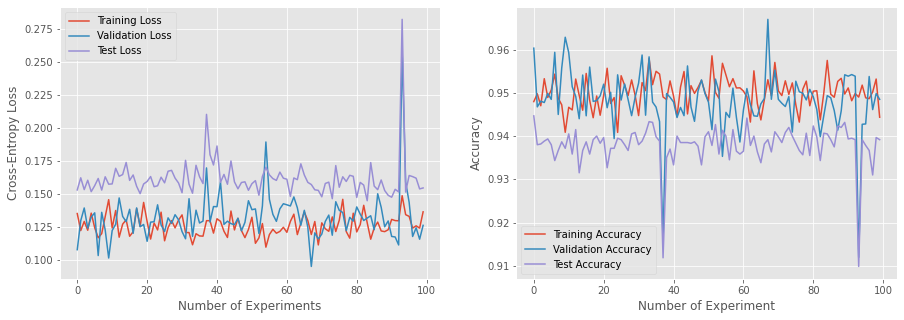

In [13]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiments')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

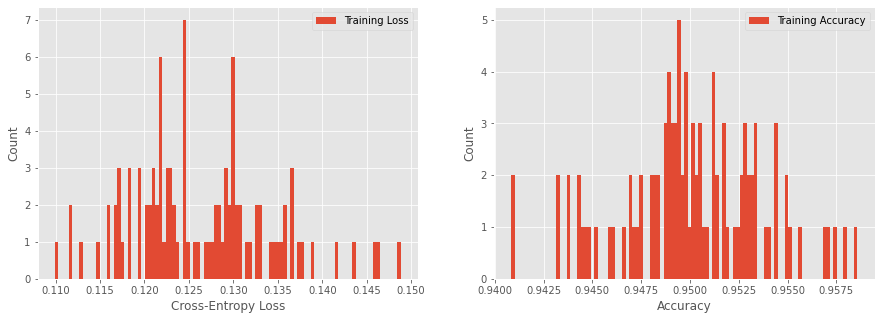

In [14]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.hist(exp_losses_train, label='Training Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(train_acc_exp, label='Training Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

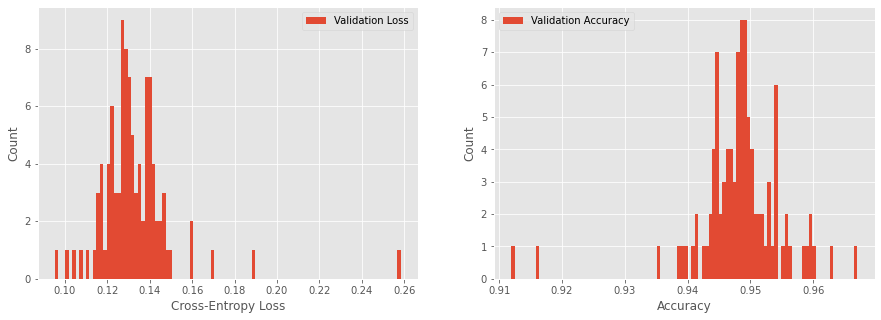

In [15]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(exp_losses_val, label='Validation Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(val_acc_exp, label='Validation Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

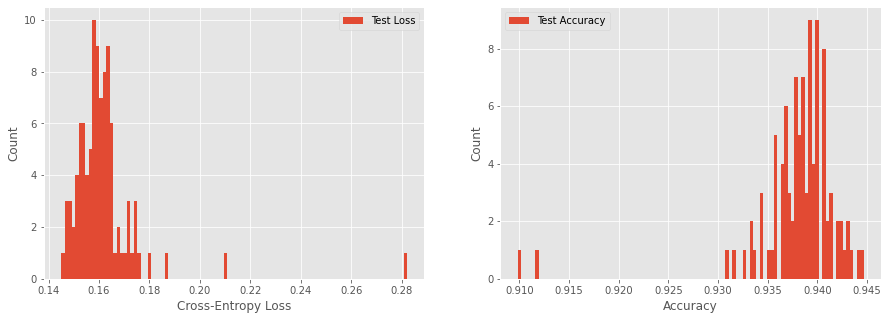

In [16]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(test_loss_exp, label='Test Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(test_accuracy_exp, label='Test Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

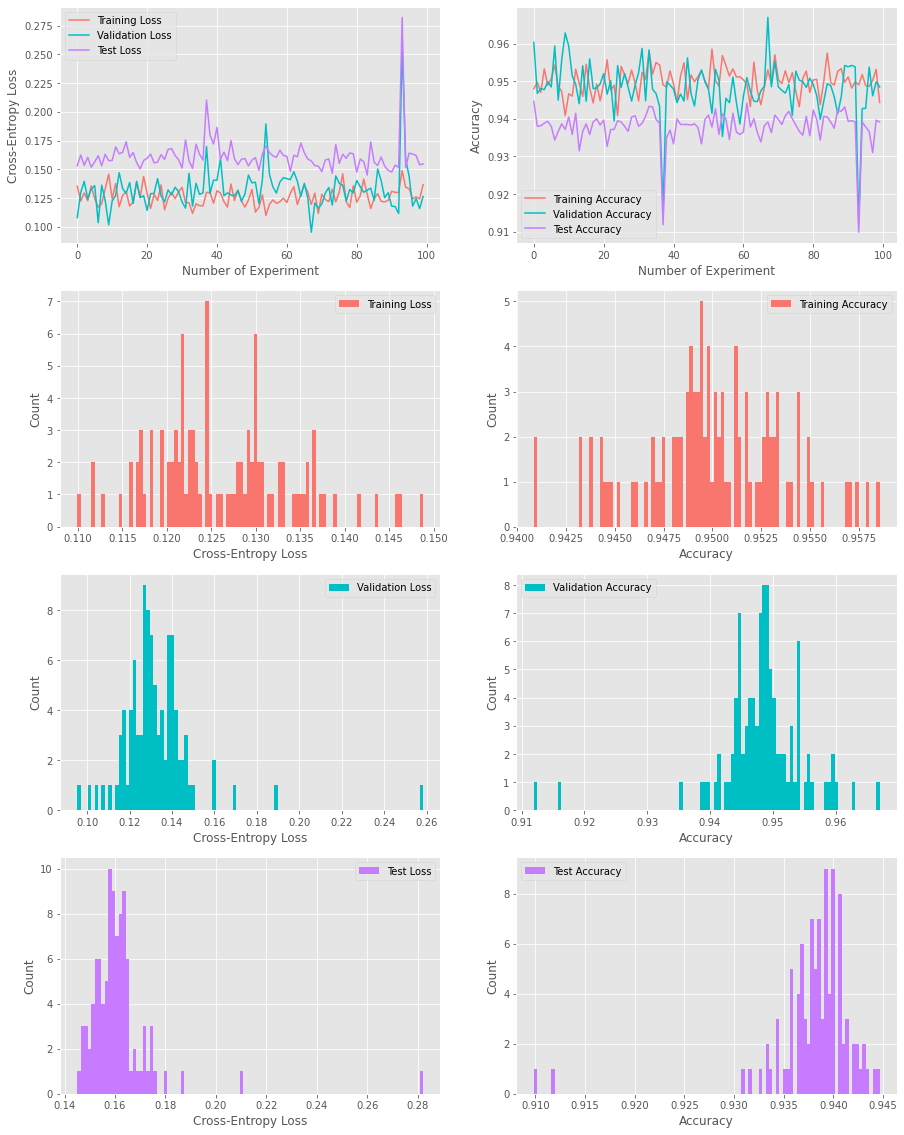

In [17]:
plt.subplots(figsize=(15,20))

plt.subplot(421)
plt.plot(exp_losses_train, label='Training Loss',color='#F8766D')
plt.plot(exp_losses_val, label='Validation Loss',color='#00BFC4')
plt.plot(test_loss_exp, label='Test Loss',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(422)
plt.plot(train_acc_exp, label='Training Accuracy',color='#F8766D')
plt.plot(val_acc_exp, label='Validation Accuracy',color='#00BFC4')
plt.plot(test_accuracy_exp, label='Test Accuracy',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(423)
plt.hist(exp_losses_train, label='Training Loss',color='#F8766D',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(424)
plt.hist(train_acc_exp, label='Training Accuracy',color='#F8766D',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(425)
plt.hist(exp_losses_val, label='Validation Loss',color='#00BFC4',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(426)
plt.hist(val_acc_exp, label='Validation Accuracy',color='#00BFC4',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(427)
plt.hist(test_loss_exp, label='Test Loss',color='#C77CFF',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(428)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='#C77CFF',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()